In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
#from keras.models import load_model
#import tensorflow as tf

### William Hill: WHH,WHD,WHA

In [2]:
%run update_stash.py

unzipping  ../../Football_Data/Zipstash\data_0.zip
unzipping  ../../Football_Data/Zipstash\data_1.zip
unzipping  ../../Football_Data/Zipstash\data_10.zip
unzipping  ../../Football_Data/Zipstash\data_11.zip
unzipping  ../../Football_Data/Zipstash\data_12.zip
unzipping  ../../Football_Data/Zipstash\data_13.zip
unzipping  ../../Football_Data/Zipstash\data_14.zip
unzipping  ../../Football_Data/Zipstash\data_15.zip
unzipping  ../../Football_Data/Zipstash\data_16.zip
unzipping  ../../Football_Data/Zipstash\data_17.zip
unzipping  ../../Football_Data/Zipstash\data_18.zip
unzipping  ../../Football_Data/Zipstash\data_19.zip
unzipping  ../../Football_Data/Zipstash\data_2.zip
unzipping  ../../Football_Data/Zipstash\data_20.zip
unzipping  ../../Football_Data/Zipstash\data_21.zip
unzipping  ../../Football_Data/Zipstash\data_22.zip
unzipping  ../../Football_Data/Zipstash\data_23.zip
unzipping  ../../Football_Data/Zipstash\data_24.zip
unzipping  ../../Football_Data/Zipstash\data_25.zip
unzipping  ../.

In [3]:
all_seasons = []
for filename in os.listdir('C:/Users/bfesc/Documents/Football_Data/Stash/'):
    #if filename[0] == 'B':
    with open("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename) as file:
        season = file.read().rstrip().split('\n')
        for i in range(len(season)):
            season[i] = season[i].rstrip(',').split(',')
        all_seasons.append(season)

In [4]:
with open("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename) as file:
    season = file.read().rstrip().split('\n')

In [5]:
#Kvitt deg med trailing commas i update_stash.py så kan du lese inn som pdf.

In [6]:
#pd.read_csv("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename,sep=',',error_bad_lines=False)

In [7]:
columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA']

all_data = pd.DataFrame(columns=columns)
for season in all_seasons:
    if not np.in1d(columns, season[0]).all():
        continue
    if len(season[0]) != max([len(s) for s in season]):
        for i in range(len(season)):
            season[i] = season[i][:len(season[0])]
    df = pd.DataFrame(season[1:])
    df.columns = season[0]
    all_data = all_data.append(df[columns])
    
all_data['Date'] = pd.to_datetime(all_data['Date'], dayfirst=True)
all_data.index = all_data['Date']
all_data = all_data.drop(columns=['Date','Div'])
for column in all_data.columns:
    all_data = all_data[pd.notnull(all_data[column])]
all_data = all_data[pd.notnull(all_data.index)]
all_data = all_data.iloc[np.where(all_data['WHH'] != "")]
all_data = all_data.iloc[np.where(all_data['WHD'] != "")]
all_data = all_data.iloc[np.where(all_data['WHA'] != "")]
all_data = all_data.iloc[np.where(all_data['FTHG'] != "")]
all_data = all_data.sort_index(ascending=False)
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'A')] = -1
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'D')] = 0
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'H')] = 1
all_data['FTHG'] = all_data['FTHG'].astype(int)
all_data['FTAG'] = all_data['FTAG'].astype(int)
all_data['WHH'] = all_data['WHH'].astype(np.float32)
all_data['WHD'] = all_data['WHD'].astype(np.float32)
all_data['WHA'] = all_data['WHA'].astype(np.float32)

In [8]:
model_date = pd.to_datetime('2018-03-28')
day = pd.Timedelta('1d')

new_data = all_data.loc[:model_date + day]
old_data = all_data.loc[model_date - day:]
new_data.shape

(22300, 8)

In [9]:
all_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA
Date,,,,,,,,
2021-04-15,Stranraer,Stenhousemuir,4,0,1,1.95,3.7,3.25
2021-04-15,Rotherham,Coventry,0,1,-1,2.50,3.2,2.88
2021-04-15,Partick,Montrose,5,0,1,1.83,3.5,3.90
2021-04-15,Clyde,Dumbarton,0,1,-1,1.95,3.4,3.50
2021-04-14,Clermont,Amiens,3,0,1,1.53,3.6,7.50


In [10]:
def make_team_dicts(data):
    all_teams = np.unique(np.append(data['HomeTeam'], data['AwayTeam']))
    team_dict = {}
    
    for team in all_teams:
        team_dict[team] = data.iloc[np.where(np.logical_or(data['HomeTeam'] == team, 
                                                      data['AwayTeam'] == team))].sort_index(ascending=False)
        
    return team_dict

def make_training_set(all_data, n_matches=None):


    
    training_data = []
    kolonner = ['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame', 'HomeTeamOdds', 'AwayTeamOdds', 'Result']
    team_dict = make_team_dicts(all_data)
    
    if n_matches is None:
        n_matches = len(all_data.index)

    history = pd.Timedelta('90d')
    year = pd.Timedelta('365d')

    for i in tqdm(range(n_matches)):#
        game = all_data.iloc[i]

        home_team = game['HomeTeam']
        away_team = game['AwayTeam']
        game_date = game.name 

        ht_games = team_dict[home_team].loc[game_date - pd.Timedelta('1h'):game_date - year]
        at_games = team_dict[away_team].loc[game_date - pd.Timedelta('1h'):game_date - year]

    #     ht_games['FTHG'] = ht_games['FTHG'].values / ht_time_diff
    #     ht_ag = ht_games['FTAG'].values / ht_time_diff

    #     at_hg = at_games['FTHG'].values / at_time_diff
    #     at_ag = at_games['FTAG'].values /at_time_diff

        #result = game['FTR']
        result = game['FTHG'] - game['FTAG']

        ht_hgames = ht_games.iloc[np.where(ht_games['HomeTeam'] == home_team)]
        ht_agames = ht_games.iloc[np.where(ht_games['AwayTeam'] == home_team)]

        at_hgames = at_games.iloc[np.where(at_games['HomeTeam'] == away_team)]
        at_agames = at_games.iloc[np.where(at_games['AwayTeam'] == away_team)]


        if len(ht_hgames) > 1 and len(at_agames) > 1:

            ht_time_diff = np.log((game_date - ht_games.index).days.values + 1)
            at_time_diff = np.log((game_date - at_games.index).days.values + 1)

            ht_h_td = ht_time_diff[np.where(ht_games['HomeTeam'] == home_team)]
            ht_a_td = ht_time_diff[np.where(ht_games['AwayTeam'] == home_team)]
            at_h_td = at_time_diff[np.where(at_games['HomeTeam'] == away_team)]
            at_a_td = at_time_diff[np.where(at_games['AwayTeam'] == away_team)]


            it_games = np.append(np.where(ht_hgames['AwayTeam'] == away_team)[0],
                                 np.where(ht_agames['HomeTeam'] == away_team)[0])

            litgr = 0
            if len(it_games) > 0:
                litgr += np.mean((ht_games['FTHG'].iloc[it_games].values - ht_games['FTAG'].iloc[it_games].values) / ht_time_diff[it_games])

            dslhtm = ht_time_diff[0]
            dslatm = at_time_diff[0]

            ht_form = np.mean(np.append(((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td),
                              (ht_agames['FTAG'].values - ht_agames['FTHG'].values) / ht_a_td))
            at_form = np.mean(np.append((at_hgames['FTHG'].values - at_hgames['FTAG'].values) / at_h_td,
                              (at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td))

            ht_hform = np.mean((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td)
            at_aform = np.mean((at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td)

            hto = np.mean(np.append(ht_hgames['FTHG'].values / ht_h_td, ht_agames['FTAG'].values / ht_a_td))
            htd = -np.mean(np.append(ht_hgames['FTAG'].values / ht_h_td, ht_agames['FTHG'].values /ht_a_td))

            ato = np.mean(np.append(at_hgames['FTHG'] / at_h_td, at_agames['FTAG'].values / at_a_td))
            atd = -np.mean(np.append(at_hgames['FTAG'].values / at_h_td, at_agames['FTHG'].values / at_a_td))
            
            htodd = game['WHH']
            atodd = game['WHA']

            #training_data = training_data.append(pd.DataFrame([[dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
            #                                                    hto, htd, ato, atd, litgr, htodd, atodd, result]], 
            #                                                  columns=training_data.columns))
            training_data.append(dict(zip(kolonner, [dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
                                                    hto, htd, ato, atd, litgr, htodd, atodd, result])))
        else:
            print(home_team,away_team)

    return pd.DataFrame(training_data)
    


In [11]:
#Det er noe rart med william hill

In [12]:
all_data.columns

Index(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA'], dtype='object')

In [13]:
matches = make_training_set(all_data)#, n_matches=len(new_data.index))
matches.head()

  3%|██▎                                                                        | 4651/151290 [00:35<18:00, 135.73it/s]

Altrincham Solihull


  3%|██▍                                                                        | 4984/151290 [00:38<19:20, 126.04it/s]

Olympiakos Apollon
Cittadella Monza


  3%|██▌                                                                        | 5103/151290 [00:39<19:12, 126.83it/s]

Giannina AEK


  3%|██▌                                                                        | 5187/151290 [00:39<18:07, 134.40it/s]

Hamburg Wurzburger Kickers


  3%|██▌                                                                        | 5214/151290 [00:40<19:37, 124.03it/s]

Spal Vicenza
Monza Chievo


  3%|██▌                                                                        | 5263/151290 [00:40<23:34, 103.24it/s]

Apollon Giannina
Ascoli Reggiana


  4%|██▋                                                                         | 5298/151290 [00:40<24:23, 99.73it/s]

Vicenza Salernitana
Reggina Cosenza


  4%|██▋                                                                        | 5364/151290 [00:41<20:19, 119.67it/s]

Farense Famalicao


  4%|██▋                                                                        | 5404/151290 [00:41<21:41, 112.09it/s]

Aris Apollon


  4%|██▋                                                                        | 5430/151290 [00:42<20:51, 116.56it/s]

Volos NFC Giannina
Braunschweig Bochum
Albacete Sabadell


  4%|██▋                                                                        | 5473/151290 [00:42<18:47, 129.32it/s]

Wealdstone Wrexham
Logrones Leganes
Virtus Entella Reggina
Reggiana Chievo
Sp Braga Nacional


  4%|██▋                                                                        | 5502/151290 [00:42<18:25, 131.89it/s]

King’s Lynn Boreham Wood
Barnet Weymouth
Wealdstone Stockport
Ponferradina Cartagena
Fuenlabrada Castellon
Weymouth Sutton
Dag and Red Wealdstone
Solihull King’s Lynn


  4%|██▋                                                                        | 5535/151290 [00:42<18:03, 134.46it/s]

Eastleigh Altrincham
Logrones Almeria
Sabadell Mirandes


  4%|██▊                                                                        | 5563/151290 [00:42<18:16, 132.93it/s]

Notts County Altrincham
Yeovil Wealdstone
Weymouth Woking
Maidenhead King’s Lynn
Nacional Belenenses


  4%|██▊                                                                        | 5591/151290 [00:43<18:35, 130.58it/s]

Alanyaspor Hatayspor
Benfica Farense
Giannina Olympiakos


  4%|██▊                                                                        | 5638/151290 [00:43<17:19, 140.14it/s]

Apollon Larisa
Wurzburger Kickers Greuther Furth
Cartagena Lugo
Castellon Leganes
Sabadell Espanol
King’s Lynn Yeovil
Altrincham Weymouth
Hannover Braunschweig
Erzurum BB Rizespor
Fenerbahce Karagumruk
Virtus Entella Reggiana


  4%|██▊                                                                        | 5682/151290 [00:43<18:18, 132.53it/s]

Vicenza Pordenone
Las Palmas Logrones
Empoli Monza
Reggina Pescara


  4%|██▊                                                                        | 5783/151290 [00:44<17:35, 137.86it/s]

Farense Nacional


  4%|██▉                                                                        | 5812/151290 [00:44<17:41, 137.04it/s]

Aris Giannina
Reggiana Pisa


  4%|██▉                                                                        | 5841/151290 [00:45<17:47, 136.20it/s]

Braunschweig Holstein Kiel
Fortuna Dusseldorf Wurzburger Kickers
Venezia Vicenza
Salernitana Reggina


  4%|██▉                                                                        | 5898/151290 [00:45<18:07, 133.66it/s]

Rodez Dunkerque
Hatayspor Kasimpasa
Kayserispor Erzurum BB
Monza Spal
Karagumruk Buyuksehyr


  4%|██▉                                                                        | 5924/151290 [00:45<22:05, 109.64it/s]

Fenerbahce Hatayspor
Gaziantep Karagumruk


  4%|██▉                                                                        | 5951/151290 [00:45<20:14, 119.66it/s]

Cartagena Sp Gijon
Moreirense Farense
Heidenheim Braunschweig


  4%|██▉                                                                        | 5964/151290 [00:46<22:58, 105.43it/s]

Erzurum BB Sivasspor


  4%|██▉                                                                        | 5998/151290 [00:46<23:50, 101.58it/s]

Castellon Malaga
Vallecano Sabadell
Pau FC Guingamp
Dunkerque Valenciennes


  4%|██▉                                                                        | 6036/151290 [00:46<21:20, 113.45it/s]

Nacional Boavista
Wurzburger Kickers Erzgebirge Aue


  4%|███                                                                        | 6077/151290 [00:47<19:44, 122.63it/s]

Hatayspor Buyuksehyr


  4%|███                                                                        | 6102/151290 [00:47<23:05, 104.81it/s]

Ankaragucu Erzurum BB
Oviedo Cartagena


  4%|███                                                                        | 6140/151290 [00:47<21:18, 113.54it/s]

Troyes Pau FC


  4%|███                                                                        | 6165/151290 [00:47<21:23, 113.05it/s]

Karagumruk Yeni Malatyaspor
Ponferradina Castellon
Sp Gijon Logrones


  4%|███                                                                        | 6217/151290 [00:48<19:53, 121.56it/s]

Beerschot VA Standard
Dunkerque Clermont
Pau FC Rodez
Waasland-Beveren Oud-Heverlee Leuven
Club Brugge Beerschot VA


  4%|███                                                                        | 6245/151290 [00:48<19:23, 124.71it/s]

Valenciennes Pau FC
Oud-Heverlee Leuven Charleroi
Toulouse Dunkerque
Beerschot VA Waregem


  4%|███                                                                        | 6270/151290 [00:48<21:45, 111.12it/s]

Genk Oud-Heverlee Leuven
Oud-Heverlee Leuven Eupen
Oostende Beerschot VA


  8%|█████▊                                                                    | 11836/151290 [01:32<16:59, 136.75it/s]

Trapani Salernitana


  8%|█████▊                                                                    | 11876/151290 [01:33<20:54, 111.13it/s]

Chievo Pisa
Pescara Virtus Entella
Livorno Pordenone


  8%|█████▊                                                                    | 11910/151290 [01:33<21:54, 106.06it/s]

Juve Stabia Ascoli
Volos NFC OFI Crete


  8%|█████▉                                                                    | 12077/151290 [01:34<17:25, 133.18it/s]

Pisa Cremonese
Denizlispor Konyaspor
Trabzonspor Genclerbirligi


  8%|█████▉                                                                    | 12122/151290 [01:35<16:50, 137.76it/s]

Cittadella Trapani
Famalicao Pacos Ferreira
Benfica Gil Vicente
Gaziantep Besiktas


  8%|█████▉                                                                    | 12164/151290 [01:35<18:33, 124.94it/s]

Virtus Entella Frosinone


  8%|█████▉                                                                    | 12192/151290 [01:35<18:59, 122.12it/s]

Olympiakos Volos NFC


  8%|█████▉                                                                    | 12220/151290 [01:35<19:03, 121.61it/s]

Perugia Juve Stabia
Pordenone Spezia
Vallecano Santander
Mirandes Oviedo


  8%|██████                                                                    | 12284/151290 [01:36<16:23, 141.35it/s]

Fuenlabrada Ponferradina


  8%|██████                                                                    | 12316/151290 [01:36<16:29, 140.40it/s]

Sparta Rotterdam Ajax
Pescara Pordenone
Genclerbirligi Buyuksehyr
Sivasspor Gaziantep
Juve Stabia Pisa


  8%|██████                                                                    | 12346/151290 [01:36<16:38, 139.09it/s]

Ponferradina Tenerife
Goztep Denizlispor


  8%|██████                                                                    | 12376/151290 [01:37<17:32, 131.99it/s]

Fuenlabrada Oviedo
Numancia Mirandes
Las Palmas Santander
Volos NFC Aris


  8%|██████                                                                    | 12461/151290 [01:37<17:43, 130.60it/s]

Pacos Ferreira Maritimo
Trapani Venezia
Cremonese Virtus Entella


  8%|██████                                                                    | 12504/151290 [01:38<19:00, 121.68it/s]

Pordenone Frosinone
Gaziantep Genclerbirligi
Gil Vicente Sp Braga
Guimaraes Famalicao
Karlsruhe Hamburg


  8%|██████▏                                                                   | 12546/151290 [01:38<17:47, 130.03it/s]

Waalwijk Den Haag
Nurnberg Osnabruck
Antalyaspor Denizlispor
Extremadura UD Fuenlabrada
Panionios Volos NFC
Ponferradina Zaragoza
Empoli Juve Stabia


  8%|██████▏                                                                   | 12589/151290 [01:38<17:14, 134.13it/s]

Mirandes Cadiz
Santander Almeria
Bochum Wehen


  8%|██████▏                                                                   | 12618/151290 [01:38<17:15, 133.94it/s]

Virtus Entella Livorno
Ascoli Trapani
Boavista Pacos Ferreira


  8%|██████▏                                                                   | 12663/151290 [01:39<16:51, 137.10it/s]

Stirling Cove Rangers
Heerenveen Twente
Pisa Benevento


  8%|██████▏                                                                   | 12738/151290 [01:39<16:14, 142.13it/s]

Osnabruck Darmstadt
Fenerbahce Gaziantep
Holstein Kiel Karlsruhe
Pacos Ferreira Santa Clara


  8%|██████▏                                                                   | 12767/151290 [01:40<17:42, 130.34it/s]

Cadiz Ponferradina
Twente Waalwijk
Moreirense Gil Vicente
Genclerbirligi Rizespor


  8%|██████▎                                                                   | 12797/151290 [01:40<19:13, 120.03it/s]

Santander Malaga
Elche Fuenlabrada
Den Haag Sparta Rotterdam
Vallecano Mirandes


  8%|██████▎                                                                   | 12852/151290 [01:40<18:49, 122.56it/s]

Cove Rangers Cowdenbeath
Mechelen Cercle Brugge
Wehen Hannover


  9%|██████▎                                                                   | 12878/151290 [01:40<18:32, 124.37it/s]

Denizlispor Galatasaray
Famalicao Rio Ave
Valenciennes Rodez
Nancy Le Mans
Caen Chambly
Torquay Maidenhead
Stockport Barrow
Chorley Solihull


  9%|██████▎                                                                   | 12905/151290 [01:41<18:26, 125.11it/s]

Chesterfield Woking
Waalwijk AZ Alkmaar


  9%|██████▎                                                                   | 12918/151290 [01:41<19:09, 120.35it/s]

Woking Harrogate
Santa Clara Famalicao
Yeovil Stockport
Sutton Chorley
Bromley Torquay
Gil Vicente Porto


  9%|██████▎                                                                   | 12945/151290 [01:41<19:21, 119.07it/s]

Benfica Pacos Ferreira
Albion Rvs Cove Rangers


  9%|██████▎                                                                   | 13016/151290 [01:42<17:30, 131.57it/s]

Groningen Twente
Sparta Rotterdam VVV Venlo
Anderlecht Mechelen
Rodez Paris FC
Le Mans Valenciennes
Chambly Grenoble
Woking Aldershot
Solihull Torquay
Notts County Stockport
Fylde Chorley


  9%|██████▍                                                                   | 13056/151290 [01:42<19:43, 116.83it/s]

Erzgebirge Aue Wehen
Feyenoord Sparta Rotterdam
Mechelen Genk


  9%|██████▍                                                                   | 13088/151290 [01:42<17:49, 129.22it/s]

Chorley Bromley
Dag and Red Woking
Torquay Boreham Wood
Stockport Maidenhead
Karlsruhe Dresden
Twente PSV Eindhoven
VVV Venlo Waalwijk
Cove Rangers Edinburgh City


  9%|██████▍                                                                   | 13134/151290 [01:42<17:05, 134.71it/s]

Orleans Chambly
Chateauroux Rodez
Auxerre Le Mans
Sandhausen Osnabruck
Wehen Karlsruhe
Osnabruck Heidenheim
Le Mans Lens
Waregem Mechelen
Rodez

  9%|██████▍                                                                   | 13162/151290 [01:43<17:24, 132.28it/s]

 Auxerre
Chambly Valenciennes


 13%|█████████▎                                                                | 19128/151290 [02:30<15:37, 140.91it/s]

Erzurum BB Alanyaspor


 13%|█████████▍                                                                | 19295/151290 [02:32<14:49, 148.38it/s]

OFI Crete AEK


 13%|█████████▌                                                                | 19451/151290 [02:33<14:42, 149.35it/s]

Livorno Lecce


 13%|█████████▌                                                                | 19482/151290 [02:33<15:06, 145.36it/s]

Padova Cremonese


 13%|█████████▋                                                                 | 19566/151290 [02:34<32:59, 66.53it/s]

Lecce Venezia
Cosenza Livorno


 13%|█████████▋                                                                 | 19635/151290 [02:35<32:03, 68.46it/s]

Giannina Aris


 13%|█████████▋                                                                 | 19652/151290 [02:35<29:51, 73.49it/s]

Erzurum BB Ankaragucu


 13%|█████████▊                                                                 | 19677/151290 [02:36<28:45, 76.28it/s]

Livorno Crotone
Aris Levadeiakos
Beziers Metz
Rizespor Bursaspor


 13%|█████████▊                                                                 | 19702/151290 [02:36<31:40, 69.25it/s]

Sivasspor Erzurum BB


 13%|█████████▊                                                                 | 19711/151290 [02:36<30:19, 72.30it/s]

Salernitana Padova


 13%|█████████▊                                                                 | 19841/151290 [02:38<31:16, 70.05it/s]

Ascoli Lecce
Cittadella Cosenza
OFI Crete PAOK


 13%|█████████▊                                                                 | 19869/151290 [02:38<46:08, 47.46it/s]

Rayo Majadahonda Lugo
Numancia Elche
Extremadura UD Granada


 13%|█████████▊                                                                 | 19914/151290 [02:39<40:26, 54.15it/s]

Mallorca Cadiz


 13%|█████████▉                                                                 | 19928/151290 [02:40<39:32, 55.36it/s]

Panetolikos OFI Crete
Holstein Kiel Magdeburg
Aris Larisa
Nacional

 13%|█████████▉                                                                 | 19945/151290 [02:40<33:17, 65.76it/s]

 Benfica
Kasimpasa Ankaragucu
Sp Gijon Extremadura UD
Gimnastic Rayo Majadahonda
Antalyaspor

 13%|█████████▉                                                                 | 19962/151290 [02:40<30:13, 72.41it/s]

 Rizespor
Pescara Livorno


 13%|█████████▉                                                                 | 19981/151290 [02:40<27:28, 79.67it/s]

Lecce Salernitana


 13%|█████████▉                                                                 | 19998/151290 [02:40<33:27, 65.39it/s]

For Sittard Utrecht


 13%|█████████▉                                                                 | 20051/151290 [02:41<32:49, 66.64it/s]

Padova Venezia
Santa Clara Boavista
Cosenza Verona


 13%|█████████▉                                                                 | 20095/151290 [02:42<33:18, 65.63it/s]

Elche Reus Deportiu


 13%|█████████▉                                                                 | 20102/151290 [02:42<32:45, 66.74it/s]

Paderborn Bochum
Alcorcon Mallorca


 13%|█████████▉                                                                 | 20117/151290 [02:42<34:48, 62.81it/s]

FC Emmen Graafschap
Lamia Aris
Rayo Majadahonda Mallorca


 13%|█████████▉                                                                 | 20143/151290 [02:43<31:07, 70.23it/s]

Benevento Lecce
Verona Padova
Panionios OFI Crete


 13%|██████████                                                                 | 20172/151290 [02:43<26:56, 81.12it/s]

Ascoli Cosenza
Setubal Nacional
Osasuna Elche


 13%|██████████                                                                 | 20207/151290 [02:43<27:30, 79.43it/s]

Ajax FC Emmen
Graafschap Groningen
Portimonense Santa Clara


 13%|██████████                                                                 | 20267/151290 [02:45<36:34, 59.72it/s]

Ankaragucu Trabzonspor
Magdeburg Ingolstadt


 13%|██████████                                                                 | 20289/151290 [02:45<38:10, 57.20it/s]

Greuther Furth Paderborn


 13%|██████████                                                                 | 20318/151290 [02:45<29:01, 75.20it/s]

Den Haag For Sittard
Extremadura UD La Coruna


 13%|██████████                                                                 | 20377/151290 [02:46<28:37, 76.21it/s]

Akhisar Belediyespor Rizespor
Santa Clara Sp Braga
Alanyaspor Ankaragucu


 13%|██████████                                                                 | 20393/151290 [02:46<28:37, 76.22it/s]

Zaragoza Rayo Majadahonda
Oviedo Extremadura UD
Mallorca Osasuna
FC Emmen AZ Alkmaar
Nacional Moreirense


 14%|██████████▏                                                                | 20454/151290 [02:47<23:06, 94.35it/s]

Cercle Brugge Waregem


 14%|██████████                                                                | 20490/151290 [02:47<21:22, 102.00it/s]

NAC Breda Graafschap
For Sittard PSV Eindhoven
Elche Granada


 14%|██████████▏                                                                | 20511/151290 [02:47<23:55, 91.13it/s]

Chateauroux Red Star
Ajaccio GFCO Grenoble
Braintree Town Hartlepool
Salford Halifax
Harrogate Barnet
Dover Athletic Havant & Waterlooville
Erzgebirge Aue Magdeburg
Graafschap Feyenoord


 14%|██████████                                                                | 20542/151290 [02:48<19:36, 111.16it/s]

Den Haag FC Emmen
Konyaspor Erzurum BB
Maritimo Santa Clara
Sp Braga Nacional


 14%|██████████                                                                | 20592/151290 [02:48<20:33, 105.96it/s]

Excelsior For Sittard


 14%|██████████▏                                                                | 20617/151290 [02:48<26:26, 82.35it/s]

Standard Cercle Brugge
Sutton Salford


 14%|██████████▏                                                                | 20646/151290 [02:49<26:57, 80.76it/s]

Rizespor Kasimpasa
Bromley Harrogate
Chesterfield Braintree Town
Havant & Waterlooville Fylde
Ankaragucu Galatasaray
Paderborn Regensburg


 14%|██████████▏                                                                | 20665/151290 [02:49<25:38, 84.91it/s]

Troyes Beziers
Red Star Le Havre
Grenoble Niort
Gateshead Salford
Hartlepool Harrogate
Havant & Waterlooville Boreham Wood
Barnet Braintree Town


 14%|██████████▎                                                                | 20688/151290 [02:49<26:29, 82.18it/s]

Magdeburg St Pauli
Darmstadt Paderborn


 14%|██████████▏                                                               | 20718/151290 [02:50<21:08, 102.97it/s]

Lens Red Star
Braintree Town Halifax
Barrow Havant & Waterlooville
Beziers Ajaccio
Harrogate Sutton
Cercle Brugge Lokeren


 14%|██████████▏                                                               | 20760/151290 [02:50<18:23, 118.25it/s]

Salford Leyton Orient
Le Havre Grenoble


 14%|██████████▏                                                               | 20804/151290 [02:50<17:03, 127.48it/s]

St Truiden Cercle Brugge
Nancy Beziers
Red Star Niort
Grenoble Sochaux


 18%|█████████████▎                                                            | 27237/151290 [03:41<15:04, 137.21it/s]

Apollon Platanias


 18%|█████████████▍                                                            | 27451/151290 [03:42<14:41, 140.43it/s]

Lamia AEK
Perugia Parma
Foggia Palermo


 18%|█████████████▍                                                            | 27483/151290 [03:43<14:37, 141.12it/s]

Cremonese Carpi


 18%|█████████████▍                                                            | 27572/151290 [03:43<14:26, 142.71it/s]

Venezia Spezia


 18%|█████████████▌                                                            | 27644/151290 [03:44<15:11, 135.64it/s]

Apollon PAOK
Kasimpasa Yeni Malatyaspor


 18%|█████████████▌                                                            | 27661/151290 [03:44<14:59, 137.50it/s]

Parma Brescia
Albacete Lugo
Leonesa Valladolid
Osmanlispor Goztep
AZ Alkmaar NAC Breda
Groningen VVV Venlo


 18%|█████████████▌                                                            | 27702/151290 [03:44<16:15, 126.75it/s]

Asteras Tripolis Lamia


 18%|█████████████▌                                                            | 27729/151290 [03:44<15:52, 129.78it/s]

Sivasspor Kayserispor


 18%|█████████████▌                                                            | 27789/151290 [03:45<14:32, 141.53it/s]

Avellino Foggia
Bari Venezia
Pro Vercelli Cremonese
Barcelona B Cordoba
Almeria Lorca


 18%|█████████████▌                                                            | 27833/151290 [03:45<15:15, 134.88it/s]

Alcorcon Albacete
Sevilla B Leonesa
Novara Parma
Foggia Virtus Entella
Cremonese Avellino
Cesena Venezia


 18%|█████████████▋                                                            | 27890/151290 [03:46<16:23, 125.52it/s]

Lorca Vallecano
Granada Barcelona B
Barcelona B Tenerife
Portimonense Maritimo
Panionios Apollon


 18%|█████████████▋                                                            | 27920/151290 [03:46<16:18, 126.13it/s]

Pescara Foggia
VVV Venlo Ajax
Boavista Aves


 18%|█████████████▋                                                            | 27971/151290 [03:46<17:44, 115.90it/s]

Venezia Salernitana
Huesca Lorca
Leonesa Osasuna
Lamia Olympiakos


 19%|█████████████▋                                                            | 28015/151290 [03:47<15:46, 130.22it/s]

Goztep Trabzonspor
Yeni Malatyaspor Antalyaspor


 19%|█████████████▋                                                            | 28058/151290 [03:47<15:48, 129.93it/s]

Regensburg Holstein Kiel
Albacete Cordoba
Galatasaray Sivasspor
Duisburg Darmstadt


 19%|█████████████▋                                                            | 28106/151290 [03:47<14:53, 137.87it/s]

Parma Cremonese
NAC Breda Sparta Rotterdam
Atromitos Apollon
Chateauroux Nimes
Holstein Kiel Greuther Furth


 19%|█████████████▊                                                            | 28134/151290 [03:48<16:27, 124.74it/s]

Aves Sp Braga
Granada Albacete
NAC Breda PSV Eindhoven
Kayserispor Goztep


 19%|█████████████▊                                                            | 28160/151290 [03:48<17:02, 120.40it/s]

Ingolstadt Regensburg
Xanthi Lamia


 19%|█████████████▊                                                            | 28187/151290 [03:48<16:59, 120.70it/s]

Heidenheim Duisburg


 19%|█████████████▊                                                            | 28214/151290 [03:48<16:45, 122.45it/s]

Sivasspor Yeni Malatyaspor
Twente VVV Venlo


 19%|█████████████▊                                                            | 28251/151290 [03:49<18:42, 109.61it/s]

Valladolid Barcelona B
Mechelen Antwerp
Rio Ave Portimonense


 19%|█████████████▊                                                            | 28292/151290 [03:49<16:48, 121.95it/s]

Ajaccio Paris FC
Lorca Leonesa
Ajaccio GFCO Quevilly Rouen
Halifax Dover Athletic
Fylde Maidenhead
Dag and Red Ebbsfleet


 19%|█████████████▊                                                            | 28317/151290 [03:49<18:33, 110.40it/s]

Lorient Chateauroux
Antwerp Genk
Yeni Malatyaspor Osmanlispor
Pacos Ferreira Aves
Sp Braga

 19%|█████████████▊                                                            | 28344/151290 [03:49<17:05, 119.94it/s]

 Portimonense
Chester Halifax
Ebbsfleet Fylde
Akhisar Belediyespor Sivasspor


 19%|█████████████▉                                                            | 28380/151290 [03:50<20:08, 101.72it/s]

Goztep Fenerbahce
Vitesse NAC Breda
VVV Venlo Sparta Rotterdam
Maidenhead Hartlepool


 19%|█████████████▉                                                            | 28462/151290 [03:50<15:23, 132.96it/s]

Quevilly Rouen Bourg Peronnas
Paris FC Le Havre
Maidenhead Wrexham
Chester Fylde
Ebbsfleet Maidstone
Barrow Halifax
Portimonense Boavista
Aves Sp Lisbon


 19%|█████████████▉                                                            | 28490/151290 [03:51<15:53, 128.85it/s]

Regensburg Nurnberg
Gent Antwerp
Duisburg Bochum


 19%|█████████████▉                                                            | 28519/151290 [03:51<15:22, 133.11it/s]

Halifax Aldershot
Guiseley Ebbsfleet
Fylde Boreham Wood
Maidstone Maidenhead


 19%|█████████████▉                                                            | 28562/151290 [03:51<17:33, 116.49it/s]

Bourg Peronnas Paris FC
Chateauroux Valenciennes
Union Berlin Holstein Kiel
Quevilly Rouen Sochaux
Holstein Kiel Sandhausen
Dresden Duisburg


 19%|█████████████▉                                                            | 28588/151290 [03:51<17:28, 117.03it/s]

Lorient Quevilly Rouen
Bielefeld Regensburg
Brest Chateauroux
Paris FC Clermont
Antwerp Anderlecht


 23%|████████████████▉                                                         | 34604/151290 [04:39<13:55, 139.60it/s]

Panetolikos Kerkyra


 23%|█████████████████                                                         | 34860/151290 [04:41<13:52, 139.77it/s]

Levadeiakos Larisa


 23%|█████████████████                                                         | 34965/151290 [04:42<13:33, 143.03it/s]

Levadeiakos Kerkyra
Larisa Olympiakos


 23%|█████████████████▏                                                        | 35244/151290 [04:44<14:46, 130.97it/s]

Osmanlispor Adanaspor
Kerkyra Larisa


 23%|█████████████████▎                                                        | 35340/151290 [04:45<16:19, 118.32it/s]

Spal Virtus Entella
Pisa Brescia
Latina Benevento
Cittadella Novara


 23%|█████████████████▎                                                        | 35378/151290 [04:45<18:40, 103.46it/s]

Alanyaspor Trabzonspor


 23%|█████████████████▌                                                         | 35410/151290 [04:45<20:05, 96.13it/s]

Karabukspor Antalyaspor


 23%|█████████████████▌                                                         | 35440/151290 [04:46<20:55, 92.27it/s]

Larisa Iraklis
Virtus Entella Pisa
Feirense Tondela
Chaves Setubal
Hannover

 23%|█████████████████▌                                                         | 35461/151290 [04:46<20:12, 95.55it/s]

 Dresden
Cadiz Getafe
UCAM Murcia Elche


 23%|█████████████████▍                                                        | 35529/151290 [04:47<18:15, 105.68it/s]

Kerkyra Platanias


 24%|█████████████████▍                                                        | 35556/151290 [04:47<16:31, 116.78it/s]

Lugo Sevilla B
Reus Deportiu Numancia
Adanaspor Gaziantepspor
Besiktas Karabukspor
Genclerbirligi Alanyaspor
Pro Vercelli Cittadella


 24%|█████████████████▍                                                        | 35632/151290 [04:47<13:44, 140.33it/s]

Ascoli Spal
Benevento Verona
Erzgebirge Aue Braunschweig
Wurzburger Kickers Bochum
Ternana Pisa
Pisa Novara
Nacional Chaves
Spal Vicenza


 24%|█████████████████▍                                                        | 35661/151290 [04:48<14:56, 129.04it/s]

Cittadella Ternana
Carpi Benevento
Mirandes Cadiz
Getafe Reus Deportiu


 24%|█████████████████▍                                                        | 35701/151290 [04:48<15:19, 125.77it/s]

Sevilla B UCAM Murcia
UCAM Murcia Cordoba
Karabukspor Rizespor


 24%|█████████████████▍                                                        | 35727/151290 [04:48<15:33, 123.75it/s]

Boavista Chaves
Rio Ave Feirense
Cadiz Mallorca
Dresden St Pauli
Go Ahead Eagles Ajax


 24%|█████████████████▍                                                        | 35756/151290 [04:48<15:08, 127.19it/s]

Kasimpasa Adanaspor


 24%|█████████████████▌                                                        | 35798/151290 [04:49<14:56, 128.80it/s]

Twente Sparta Rotterdam
Greuther Furth Erzgebirge Aue


 24%|█████████████████▌                                                        | 35823/151290 [04:49<17:25, 110.47it/s]

Bari Cittadella
Benevento Spal
Edinburgh City Berwick


 24%|█████████████████▌                                                        | 35865/151290 [04:49<15:48, 121.67it/s]

Reus Deportiu Mirandes
Lokeren Mouscron
Alanyaspor Antalyaspor


 24%|█████████████████▌                                                        | 35891/151290 [04:50<17:28, 110.03it/s]

Heidenheim Wurzburger Kickers
Tenerife Sevilla B
Galatasaray Karabukspor
Zaragoza UCAM Murcia
Feirense Moreirense


 24%|█████████████████▌                                                        | 35917/151290 [04:50<17:03, 112.67it/s]

Sevilla B Girona
Eupen Anderlecht
Sparta Rotterdam

 24%|█████████████████▌                                                        | 35942/151290 [04:50<17:59, 106.89it/s]

 Go Ahead Eagles


 24%|█████████████████▌                                                        | 35993/151290 [04:51<17:29, 109.82it/s]

Mallorca Reus Deportiu
Chaves Tondela
Besiktas Alanyaspor


 24%|█████████████████▌                                                        | 36018/151290 [04:51<18:02, 106.53it/s]

Cowdenbeath Edinburgh City


 24%|█████████████████▋                                                        | 36045/151290 [04:51<16:22, 117.29it/s]

Lens Amiens
Strasbourg Nimes
Sochaux Orleans
Almeria Cadiz
Adanaspor Bursaspor


 24%|█████████████████▋                                                        | 36071/151290 [04:51<16:38, 115.40it/s]

Wrexham Solihull
North Ferriby Guiseley
Maidstone Braintree Town
Sutton Torquay


 24%|█████████████████▋                                                        | 36122/151290 [04:52<16:16, 117.88it/s]

Estoril Feirense
Union Berlin Dresden
Go Ahead Eagles Nijmegen
Wurzburger Kickers Kaiserslautern
Oostende Mouscron


 24%|█████████████████▋                                                        | 36166/151290 [04:52<14:41, 130.67it/s]

Westerlo Eupen
Zwolle Sparta Rotterdam
Elgin Edinburgh City
Solihull Bromley
Lincoln Sutton


 24%|█████████████████▋                                                        | 36196/151290 [04:52<14:25, 133.04it/s]

Dover Athletic North Ferriby
Chester Maidstone


 24%|█████████████████▋                                                        | 36242/151290 [04:52<13:48, 138.93it/s]

Erzgebirge Aue Sandhausen
Tours Strasbourg
Orleans Ajaccio
Amiens Niort
Lincoln North Ferriby
Aldershot Maidstone
Forest Green Sutton
Solihull Woking


 24%|█████████████████▋                                                        | 36256/151290 [04:53<15:24, 124.43it/s]

Sparta Rotterdam Ajax
Heidenheim Erzgebirge Aue
Braunschweig Wurzburger Kickers


 24%|█████████████████▊                                                        | 36293/151290 [04:53<16:35, 115.52it/s]

North Ferriby Braintree Town
Edinburgh City Forfar
Sutton Solihull
Maidstone York
Mouscron Charleroi
Den Haag

 24%|█████████████████▊                                                        | 36305/151290 [04:53<17:03, 112.34it/s]

 Go Ahead Eagles
Eupen Mechelen
Strasbourg Amiens


 24%|█████████████████▊                                                        | 36340/151290 [04:53<18:09, 105.51it/s]

Dresden Nurnberg
Brest Orleans
Amiens

 24%|█████████████████▊                                                        | 36368/151290 [04:54<16:50, 113.72it/s]

 Reims
Waregem Eupen
Mouscron Anderlecht
Bourg Peronnas Strasbourg
Orleans Le Havre


 28%|████████████████████▉                                                     | 42804/151290 [05:48<15:05, 119.87it/s]

Ponferradina Ath Bilbao B


 28%|████████████████████▉                                                     | 42845/151290 [05:48<14:25, 125.33it/s]

PAOK AEK
Avellino Novara


 28%|████████████████████▉                                                     | 42871/151290 [05:48<14:27, 124.94it/s]

Platanias Iraklis
Pescara Salernitana


 28%|████████████████████▉                                                     | 42898/151290 [05:48<14:37, 123.49it/s]

Latina Ascoli
Como Trapani


 28%|█████████████████████                                                     | 42993/151290 [05:49<13:59, 129.05it/s]

Vicenza Como
Salernitana Spezia


 28%|█████████████████████                                                     | 43047/151290 [05:50<14:20, 125.80it/s]

Ascoli Cesena


 28%|█████████████████████                                                     | 43076/151290 [05:50<14:18, 126.12it/s]

Novara Virtus Entella


 29%|█████████████████████                                                     | 43131/151290 [05:50<14:10, 127.24it/s]

Ascoli Virtus Entella
Kayserispor Trabzonspor
Iraklis Levadeiakos
AEK Giannina


 29%|█████████████████████                                                     | 43172/151290 [05:51<15:00, 120.01it/s]

Osmanlispor Konyaspor
Girona Huesca
Tenerife Oviedo
Moreirense Uniao Madeira
Guimaraes Tondela


 29%|█████████████████████▏                                                    | 43199/151290 [05:51<14:24, 125.05it/s]

Graafschap AZ Alkmaar
Virtus Lanciano Ascoli


 29%|█████████████████████▏                                                    | 43251/151290 [05:51<14:17, 126.02it/s]

Brescia Salernitana
Como Livorno
Crotone Novara


 29%|█████████████████████▏                                                    | 43316/151290 [05:52<14:51, 121.14it/s]

Elche Gimnastic
Valladolid Ath Bilbao B
Antalyaspor Eskisehirspor
Le Havre Red Star


 29%|█████████████████████▏                                                    | 43342/151290 [05:52<14:41, 122.51it/s]

Perugia Como
Novara Latina
Salernitana Avellino
Ath Bilbao B Mallorca
Oviedo Albacete
Gimnastic Girona
Huesca Tenerife


 29%|█████████████████████▏                                                    | 43410/151290 [05:52<13:55, 129.08it/s]

Uniao Madeira Guimaraes
Fenerbahce Antalyaspor


 29%|█████████████████████▏                                                    | 43438/151290 [05:53<14:18, 125.69it/s]

Tenerife Gimnastic
Sivasspor Osmanlispor
Tondela Nacional
Alaves Oviedo


 29%|█████████████████████▎                                                    | 43464/151290 [05:53<14:16, 125.88it/s]

Iraklis Panionios
AZ Alkmaar Roda


 29%|█████████████████████▎                                                    | 43506/151290 [05:53<14:48, 121.32it/s]

Albacete Huesca


 29%|█████████████████████▎                                                    | 43575/151290 [05:54<14:44, 121.77it/s]

Mersin Idman Yurdu Kayserispor
Xanthi AEK


 29%|█████████████████████▎                                                    | 43600/151290 [05:54<15:41, 114.38it/s]

Willem II Nijmegen
Galatasaray Osmanlispor
Ath Bilbao B Girona
Nijmegen Ajax


 29%|█████████████████████▎                                                    | 43638/151290 [05:54<16:00, 112.04it/s]

Boavista Tondela
Antalyaspor Genclerbirligi
Nacional Uniao Madeira
Oviedo Lugo
Gimnastic Albacete


 29%|█████████████████████▎                                                    | 43675/151290 [05:55<16:20, 109.75it/s]

Kayserispor Konyaspor
Roda Graafschap


 29%|█████████████████████▎                                                    | 43699/151290 [05:55<16:24, 109.31it/s]

Karlsruhe Duisburg


 29%|█████████████████████▍                                                    | 43772/151290 [05:56<16:03, 111.59it/s]

Kallonis Iraklis
AEK Platanias
Huesca Alaves
Sochaux Paris FC
Laval

 29%|█████████████████████▍                                                    | 43798/151290 [05:56<15:33, 115.20it/s]

 Red Star
Valenciennes Bourg Peronnas
Bielefeld Braunschweig
Barrow

 29%|█████████████████████▍                                                    | 43823/151290 [05:56<15:33, 115.07it/s]

 Guiseley
Bromley Braintree Town
Boreham Wood Forest Green


 29%|█████████████████████▍                                                    | 43848/151290 [05:56<15:41, 114.17it/s]

Duisburg Bielefeld
Gent St Truiden
Oud-Heverlee Leuven Charleroi
Uniao Madeira Maritimo


 29%|█████████████████████▍                                                    | 43884/151290 [05:57<16:37, 107.72it/s]

Osmanlispor Kayserispor
Heracles Nijmegen
Forest Green Barrow
Grimsby Bromley


 29%|█████████████████████▍                                                    | 43910/151290 [05:57<17:25, 102.74it/s]

Gateshead Boreham Wood
Graafschap Zwolle


 29%|█████████████████████▍                                                    | 43938/151290 [05:57<15:35, 114.72it/s]

Buyuksehyr Antalyaspor
Guiseley Kidderminster


 29%|█████████████████████▌                                                    | 43979/151290 [05:57<14:31, 123.08it/s]

Bourg Peronnas Dijon
Paris FC Le Havre
Red Star Tours
Vitesse Roda
Tondela Sp Lisbon
Nijmegen Excelsior


 29%|█████████████████████▌                                                    | 44018/151290 [05:58<14:23, 124.21it/s]

Woking Bromley
Heerenveen Graafschap
Eastleigh Boreham Wood
Grimsby Barrow
Guiseley Altrincham


 29%|█████████████████████▌                                                    | 44060/151290 [05:58<13:59, 127.77it/s]

Boreham Wood Halifax
Westerlo Oud-Heverlee Leuven
Barrow Dover Athletic
Bromley Wrexham
Welling United Guiseley


 29%|█████████████████████▌                                                    | 44087/151290 [05:58<14:04, 127.01it/s]

St Truiden Oostende
Roda Heracles


 29%|█████████████████████▌                                                    | 44127/151290 [05:59<14:55, 119.72it/s]

Tours Paris FC
Creteil Bourg Peronnas
Oud-Heverlee Leuven Anderlecht
Mouscron-Peruwelz St Truiden


 29%|█████████████████████▌                                                    | 44154/151290 [05:59<14:55, 119.63it/s]

Bochum Duisburg
Red Star Creteil
Paris FC Laval
Bielefeld Frankfurt FSV
Bourg Peronnas Le Havre


 29%|█████████████████████▌                                                    | 44167/151290 [05:59<14:38, 121.91it/s]

St Pauli Bielefeld
Genk Oud-Heverlee Leuven
St Truiden Club Brugge
Duisburg Kaiserslautern


 33%|████████████████████████▌                                                 | 50322/151290 [06:51<15:23, 109.32it/s]

Balikesirspor Besiktas


 33%|████████████████████████▋                                                 | 50507/151290 [06:53<14:50, 113.19it/s]

Gaziantepspor Buyuksehyr
Karabukspor Mersin Idman Yurdu


 33%|████████████████████████▋                                                 | 50564/151290 [06:53<12:55, 129.94it/s]

Genclerbirligi Balikesirspor


 34%|████████████████████████▊                                                 | 50746/151290 [06:54<12:18, 136.07it/s]

Modena Perugia


 34%|████████████████████████▊                                                 | 50776/151290 [06:55<12:50, 130.48it/s]

Buyuksehyr Trabzonspor
Kerkyra Giannina


 34%|████████████████████████▊                                                 | 50805/151290 [06:55<12:51, 130.22it/s]

Niki Volos Ergotelis
Perugia Vicenza
Mersin Idman Yurdu Rizespor


 34%|████████████████████████▊                                                 | 50851/151290 [06:55<13:24, 124.80it/s]

Pro Vercelli Varese
Virtus Lanciano Frosinone
Balikesirspor Galatasaray


 34%|████████████████████████▉                                                 | 50957/151290 [06:56<13:00, 128.54it/s]

Spezia Virtus Entella


 34%|████████████████████████▉                                                 | 51041/151290 [06:57<12:29, 133.81it/s]

Vicenza Ternana
Betis Albacete
Kasimpasa Mersin Idman Yurdu
Lugo Leganes
Boavista Academica


 34%|████████████████████████▉                                                 | 51084/151290 [06:57<12:22, 135.00it/s]

Maritimo Penafiel
Karabukspor Buyuksehyr
Veria Kerkyra
PAOK Niki Volos


 34%|█████████████████████████                                                 | 51126/151290 [06:57<12:52, 129.72it/s]

Konyaspor Balikesirspor
Frosinone Bari
Modena Pro Vercelli
Perugia Catania
Virtus Entella Brescia


 34%|█████████████████████████                                                 | 51154/151290 [06:57<13:00, 128.24it/s]

Moreirense Rio Ave


 34%|█████████████████████████                                                 | 51182/151290 [06:58<13:43, 121.54it/s]

Llagostera Osasuna
Santander Las Palmas


 34%|█████████████████████████                                                 | 51225/151290 [06:58<12:29, 133.58it/s]

Vicenza Latina
Bologna Virtus Entella
Pro Vercelli Catania
Spezia Frosinone
Trapani Vicenza
Bari Perugia
Leganes Mallorca


 34%|█████████████████████████                                                 | 51254/151290 [06:58<13:02, 127.77it/s]

Valladolid Santander
Recreativo Llagostera


 34%|█████████████████████████                                                 | 51282/151290 [06:58<12:47, 130.28it/s]

Albacete Sp Gijon
Rio Ave Boavista


 34%|█████████████████████████                                                 | 51309/151290 [06:59<13:03, 127.67it/s]

Llagostera Leganes
Porto Moreirense
Xanthi Kerkyra
Niki Volos Atromitos
Penafiel Pacos Ferreira


 34%|█████████████████████████                                                 | 51356/151290 [06:59<12:13, 136.23it/s]

Munich 1860 Darmstadt
Avellino Pro Vercelli
Excelsior Heracles
Dordrecht AZ Alkmaar


 34%|█████████████████████████▏                                                | 51384/151290 [06:59<12:49, 129.86it/s]

Frosinone Brescia
Karlsruhe Heidenheim


 34%|█████████████████████████▏                                                | 51412/151290 [06:59<12:44, 130.57it/s]

Mersin Idman Yurdu Besiktas
Tenerife Albacete
Santander Mirandes
Buyuksehyr Kasimpasa


 34%|█████████████████████████▏                                                | 51456/151290 [07:00<12:32, 132.71it/s]

Virtus Entella Bari
Go Ahead Eagles Willem II


 34%|█████████████████████████▏                                                | 51486/151290 [07:00<12:14, 135.81it/s]

Perugia Bologna
Frankfurt FSV RB Leipzig
Moreirense Sp Braga


 34%|█████████████████████████▏                                                | 51514/151290 [07:00<12:44, 130.59it/s]

Darmstadt Aalen
Boavista Benfica
Albacete Alcorcon
Girona Santander
Leganes Alaves


 34%|█████████████████████████▏                                                | 51543/151290 [07:00<12:36, 131.85it/s]

Heerenveen Excelsior
Willem II AZ Alkmaar
Kerkyra Panthrakikos
Las Palmas Llagostera
Go Ahead Eagles Dordrecht
Olympiakos Niki Volos


 34%|█████████████████████████▏                                                | 51616/151290 [07:01<12:30, 132.83it/s]

Dover Athletic Eastleigh
Southport Altrincham


 34%|█████████████████████████▎                                                | 51659/151290 [07:01<12:43, 130.53it/s]

Bristol Rvs Telford United
RB Leipzig Erzgebirge Aue
Clermont Ajaccio GFCO
Heidenheim Munich 1860
Orleans Brest
Guimaraes Penafiel


 34%|█████████████████████████▎                                                | 51719/151290 [07:02<11:56, 138.97it/s]

Ajaccio GFCO Ajaccio
Westerlo Anderlecht
Telford United Aldershot
Excelsior Go Ahead Eagles
Sp Braga Boavista
Nacional Moreirense
Penafiel Belenenses
Utrecht Willem II


 34%|█████████████████████████▎                                                | 51748/151290 [07:02<12:47, 129.62it/s]

Dordrecht Zwolle


 34%|█████████████████████████▎                                                | 51805/151290 [07:02<12:49, 129.24it/s]

Altrincham Bristol Rvs
Grimsby Dover Athletic
Eastleigh Gateshead
Auxerre Orleans
Mouscron-Peruwelz Standard


 34%|█████████████████████████▎                                                | 51847/151290 [07:03<12:51, 128.95it/s]

Eastleigh Aldershot
Braintree Town Dover Athletic
Telford United Macclesfield
Altrincham Lincoln
Ingolstadt Darmstadt
Munich 1860 RB Leipzig


 34%|█████████████████████████▎                                                | 51875/151290 [07:03<12:54, 128.44it/s]

Willem II PSV Eindhoven
Heerenveen Dordrecht
NAC Breda Excelsior
Braunschweig Heidenheim
Nuneaton Town Eastleigh
Welling United Telford United


 34%|█████████████████████████▍                                                | 51901/151290 [07:03<13:33, 122.19it/s]

Dover Athletic Halifax
Aldershot Altrincham


 34%|█████████████████████████▍                                                | 51940/151290 [07:04<13:30, 122.56it/s]

Waasland-Beveren Westerlo
Lierse Mouscron-Peruwelz


 34%|█████████████████████████▍                                                | 51953/151290 [07:04<14:16, 115.95it/s]

Orleans Nancy
Le Havre Ajaccio GFCO
Darmstadt Sandhausen
Heidenheim Frankfurt FSV
Mouscron-Peruwelz Waasland-Beveren
RB Leipzig Aalen
Sochaux

 34%|█████████████████████████▍                                                | 51981/151290 [07:04<14:03, 117.68it/s]

 Orleans
Charleroi Westerlo
Ajaccio GFCO Valenciennes
Anderlecht Mouscron-Peruwelz
Westerlo Lokeren


 39%|████████████████████████████▌                                             | 58472/151290 [07:50<10:00, 154.56it/s]

Carpi Brescia


 39%|████████████████████████████▋                                             | 58540/151290 [07:51<09:57, 155.30it/s]

Ergotelis Panionios


 39%|████████████████████████████▋                                             | 58741/151290 [07:52<09:59, 154.49it/s]

Nacional Arouca
Apollon Kallonis
Elazigspor Konyaspor


 39%|████████████████████████████▋                                             | 58774/151290 [07:52<10:03, 153.42it/s]

Academica Belenenses
Gaziantepspor Rizespor


 39%|████████████████████████████▊                                             | 58823/151290 [07:53<10:04, 152.98it/s]

Cittadella Latina
Erciyesspor Akhisar Belediyespor
Carpi Empoli
Trapani Reggina


 39%|████████████████████████████▊                                             | 58857/151290 [07:53<10:21, 148.61it/s]

Virtus Lanciano Avellino


 39%|████████████████████████████▊                                             | 58909/151290 [07:53<09:56, 154.76it/s]

Panetolikos Ergotelis
Tenerife Barcelona B
Jaen Girona
Eibar Cordoba


 39%|████████████████████████████▊                                             | 58941/151290 [07:54<10:20, 148.78it/s]

Latina Varese
Empoli Trapani
Avellino Ternana
Spezia Carpi
Alaves Sabadell


 39%|████████████████████████████▊                                             | 58973/151290 [07:54<10:22, 148.21it/s]

Caen Metz
Trapani Pescara
Panthrakikos Panetolikos
Arouca Rio Ave
Belenenses Nacional


 39%|████████████████████████████▊                                             | 59005/151290 [07:54<10:20, 148.68it/s]

Asteras Tripolis Apollon
Rizespor Erciyesspor
Mirandes Tenerife
Lugo Jaen
Cordoba Alaves
Xanthi Ergotelis


 39%|████████████████████████████▉                                             | 59054/151290 [07:54<10:08, 151.65it/s]

Las Palmas Eibar
Kallonis Giannina


 39%|████████████████████████████▉                                             | 59140/151290 [07:55<12:23, 123.95it/s]

Latina Avellino
Konyaspor Kasimpasa


 39%|████████████████████████████▉                                             | 59165/151290 [07:55<14:32, 105.58it/s]

Erciyesspor Besiktas
Sp Braga Belenenses
Trabzonspor Rizespor
Ergotelis Levadeiakos


 39%|████████████████████████████▉                                             | 59205/151290 [07:56<13:00, 118.06it/s]

Arouca Estoril
Tenerife Hercules
Numancia Jaen
Aris

 39%|████████████████████████████▉                                             | 59233/151290 [07:56<13:14, 115.87it/s]

 Kallonis
Giannina Apollon
Go Ahead Eagles Groningen
Sivasspor Konyaspor
Ternana Carpi


 39%|████████████████████████████▉                                             | 59261/151290 [07:56<13:01, 117.72it/s]

Padova Trapani
Zwolle Cambuur
Eibar Girona
Alaves Las Palmas


 39%|████████████████████████████▉                                             | 59286/151290 [07:56<13:15, 115.70it/s]

Avellino Novara
Empoli Latina
Woking

 39%|█████████████████████████████                                             | 59310/151290 [07:57<13:32, 113.27it/s]

 Welling United
Panetolikos PAOK
Kidderminster Chester


 39%|█████████████████████████████                                             | 59340/151290 [07:57<12:25, 123.32it/s]

Macclesfield Halifax
Salisbury Aldershot


 39%|█████████████████████████████                                             | 59380/151290 [07:57<12:54, 118.70it/s]

CA Bastia Angers
Creteil Istres
Kallonis Olympiakos


 39%|█████████████████████████████                                             | 59407/151290 [07:57<12:06, 126.49it/s]

Apollon Aris
Panathinaikos Panetolikos
Sp Lisbon Arouca
Jaen Eibar
Alcorcon Tenerife
Belenenses Rio Ave


 39%|█████████████████████████████                                             | 59436/151290 [07:57<11:58, 127.80it/s]

Cercle Brugge Oostende


 39%|█████████████████████████████                                             | 59466/151290 [07:58<12:14, 125.04it/s]

Rizespor Genclerbirligi
Konyaspor Fenerbahce
Atromitos Ergotelis
Cambuur Groningen
PSV Eindhoven

 39%|█████████████████████████████                                             | 59493/151290 [07:58<11:56, 128.05it/s]

 Go Ahead Eagles
Halifax Dartford


 39%|█████████████████████████████                                             | 59522/151290 [07:58<11:20, 134.87it/s]

Chester Woking
Alfreton Town Salisbury
Welling United Grimsby
Karlsruhe Greuther Furth


 39%|█████████████████████████████▏                                            | 59552/151290 [07:58<11:18, 135.31it/s]

Bielefeld Paderborn
Girona Alaves
Antalyaspor Erciyesspor
Istres CA Bastia
Metz Arles
Caen Creteil
Welling United Cambridge
Luton Salisbury
Halifax Wrexham
Chester Hereford


 39%|█████████████████████████████▏                                            | 59594/151290 [07:59<11:28, 133.18it/s]

Cambridge Halifax
St Pauli Bielefeld
CA Bastia Nancy


 39%|█████████████████████████████▏                                            | 59621/151290 [07:59<12:29, 122.30it/s]

Barnet Chester
Wrexham Welling United
Salisbury Tamworth


 39%|█████████████████████████████▏                                            | 59664/151290 [07:59<11:36, 131.56it/s]

Go Ahead Eagles Den Haag
Ingolstadt Karlsruhe
Oostende Oud-Heverlee Leuven


 39%|█████████████████████████████▏                                            | 59693/151290 [07:59<11:52, 128.61it/s]

Creteil Metz
Roda Cambuur
Oostende Club Brugge
Cambuur NAC Breda
Utrecht Go Ahead Eagles
Lens CA Bastia


 40%|█████████████████████████████▏                                            | 59761/151290 [08:00<11:41, 130.48it/s]

Metz Laval
Nimes Creteil
Karlsruhe St Pauli
Genk Oostende
Bielefeld Union Berlin
Frankfurt FSV Karlsruhe
Greuther Furth

 40%|█████████████████████████████▏                                            | 59789/151290 [08:00<11:31, 132.29it/s]

 Bielefeld


 44%|████████████████████████████████▎                                         | 66070/151290 [08:46<09:31, 149.10it/s]

Panthrakikos Veria


 44%|████████████████████████████████▍                                         | 66287/151290 [08:48<11:12, 126.37it/s]

Estoril Maritimo


 44%|████████████████████████████████▍                                         | 66415/151290 [08:49<10:33, 134.07it/s]

Asteras Tripolis Platanias


 44%|████████████████████████████████▌                                         | 66473/151290 [08:49<10:29, 134.64it/s]

Moreirense Guimaraes


 44%|████████████████████████████████▌                                         | 66515/151290 [08:50<10:35, 133.36it/s]

Besiktas Elazigspor


 44%|████████████████████████████████▌                                         | 66559/151290 [08:50<10:29, 134.56it/s]

Platanias Atromitos
Akhisar Belediyespor Buyuksehyr
Ascoli Spezia


 44%|████████████████████████████████▌                                         | 66632/151290 [08:51<10:05, 139.88it/s]

Cittadella Virtus Lanciano
Panthrakikos Panathinaikos
Levadeiakos Veria


 44%|████████████████████████████████▌                                         | 66662/151290 [08:51<09:59, 141.20it/s]

Kasimpasa Gaziantepspor
Sassuolo Pro Vercelli
Ternana Cesena


 44%|████████████████████████████████▋                                         | 66722/151290 [08:51<09:58, 141.39it/s]

Sp Gijon Lugo
Pro Vercelli Livorno
Spezia Brescia
Virtus Lanciano Ascoli
Bari Ternana
Mirandes Numancia
Ponferradina Villarreal
Real Madrid B Xerez


 44%|████████████████████████████████▋                                         | 66797/151290 [08:52<10:15, 137.36it/s]

Beira Mar Moreirense
Regensburg Bochum


 44%|████████████████████████████████▋                                         | 66841/151290 [08:52<10:19, 136.29it/s]

Almeria Real Madrid B
Lugo Cordoba
Girona Ponferradina


 44%|████████████████████████████████▋                                         | 66870/151290 [08:52<10:22, 135.70it/s]

Xerez Mirandes
Elazigspor Kasimpasa
Kayserispor Akhisar Belediyespor


 44%|████████████████████████████████▋                                         | 66900/151290 [08:53<10:14, 137.33it/s]

Reggina Pro Vercelli
Ternana Modena
Verona Spezia
Virtus Lanciano Varese
Zwolle Nijmegen


 44%|████████████████████████████████▋                                         | 66928/151290 [08:53<10:42, 131.37it/s]

St Pauli Sandhausen
Aalen Braunschweig
Roda Willem II
Guimaraes Estoril
Platanias

 44%|████████████████████████████████▋                                         | 66955/151290 [08:53<10:58, 128.13it/s]

 Panthrakikos
Veria Panionios


 44%|████████████████████████████████▊                                         | 67012/151290 [08:53<10:42, 131.11it/s]

Willem II Vitesse
Trabzonspor Elazigspor
Bochum Aalen
Moreirense Nacional
Veria Olympiakos
PAOK

 44%|████████████████████████████████▊                                         | 67026/151290 [08:54<11:03, 126.98it/s]

 Panthrakikos
Estoril Pacos Ferreira
Las Palmas Lugo
Ponferradina Alcorcon
Real Madrid B Barcelona B
Recreativo Mirandes


 44%|████████████████████████████████▊                                         | 67083/151290 [08:54<10:56, 128.19it/s]

Akhisar Belediyespor Genclerbirligi


 44%|████████████████████████████████▊                                         | 67111/151290 [08:54<10:49, 129.63it/s]

Dartford Kidderminster
Forest Green Woking
Luton Telford United
Mansfield Hyde United
Nuneaton Town Cambridge
Spezia Vicenza
Pro Vercelli Ternana
Padova Virtus Lanciano
Utrecht Zwolle


 44%|████████████████████████████████▊                                         | 67166/151290 [08:55<10:44, 130.57it/s]

Giannina Platanias
Nimes Caen
Hertha Regensburg
Sandhausen Union Berlin
Kasimpasa Karabukspor


 44%|████████████████████████████████▉                                         | 67227/151290 [08:55<10:21, 135.31it/s]

Galatasaray Kasimpasa
Elche Ponferradina
Charleroi Standard


 44%|████████████████████████████████▉                                         | 67257/151290 [08:55<10:20, 135.50it/s]

Pacos Ferreira Moreirense
Groningen Willem II
Telford United Braintree Town
Woking Barrow
Macclesfield Dartford
Grimsby Nuneaton Town


 44%|████████████████████████████████▉                                         | 67285/151290 [08:55<10:54, 128.26it/s]

Elazigspor Fenerbahce


 44%|████████████████████████████████▉                                         | 67313/151290 [08:56<10:39, 131.27it/s]

Waasland-Beveren Gent
Lugo Hercules
Zwolle Vitesse


 45%|████████████████████████████████▉                                         | 67374/151290 [08:56<10:25, 134.14it/s]

Le Havre Ajaccio GFCO
Laval Niort
Eskisehirspor Akhisar Belediyespor
Hyde United Luton
Mirandes Huesca
Villarreal Real Madrid B
Olhanense Estoril
Telford United Forest Green
Newport County Nuneaton Town
Hyde United Barrow
Woking Dartford


 45%|████████████████████████████████▉                                         | 67402/151290 [08:56<10:25, 134.14it/s]

Regensburg Duisburg
Roda Zwolle
Wrexham Woking
Kortrijk Charleroi


 45%|████████████████████████████████▉                                         | 67444/151290 [08:57<10:26, 133.87it/s]

Nuneaton Town Ebbsfleet
Dartford Tamworth
Braintree Town Hyde United
Barrow Telford United
Standard Waasland-Beveren
Clermont Nimes
Ajaccio GFCO Arles
Niort Caen
Aalen Kaiserslautern
FC Koln

 45%|█████████████████████████████████                                         | 67476/151290 [08:57<10:22, 134.58it/s]

 Sandhausen
Willem II NAC Breda
Duisburg Aalen
Sandhausen Frankfurt FSV
Waasland-Beveren Mechelen
Nimes Nantes
Charleroi Club Brugge
Munich 1860 Regensburg
Istres Ajaccio GFCO
Tours Niort


 45%|█████████████████████████████████                                         | 67507/151290 [08:57<09:59, 139.75it/s]

Club Brugge Waasland-Beveren
Mechelen Charleroi
Niort Clermont
Ajaccio GFCO Caen
Auxerre Nimes


 48%|███████████████████████████████████▏                                      | 72026/151290 [09:29<08:56, 147.64it/s]

Levadeiakos Panionios
Doxa Dramas Xanthi


 48%|███████████████████████████████████▎                                      | 72185/151290 [09:30<08:42, 151.42it/s]

Olympiakos Doxa Dramas


 48%|███████████████████████████████████▎                                      | 72217/151290 [09:30<08:47, 149.99it/s]

Levadeiakos Doxa Dramas


 48%|███████████████████████████████████▍                                      | 72397/151290 [09:31<09:15, 142.05it/s]

AEK Levadeiakos


 48%|███████████████████████████████████▍                                      | 72426/151290 [09:32<10:02, 130.95it/s]

Atromitos Levadeiakos
Doxa Dramas Panionios


 48%|███████████████████████████████████▊                                      | 73327/151290 [09:38<09:44, 133.35it/s]

PAOK OFI


 49%|████████████████████████████████████                                      | 73618/151290 [09:40<09:28, 136.68it/s]

Atromitos Panetolikos


 49%|████████████████████████████████████                                      | 73711/151290 [09:41<09:24, 137.33it/s]

OFI Ergotelis


 49%|████████████████████████████████████                                      | 73810/151290 [09:41<08:32, 151.18it/s]

Orduspor Samsunspor
Panetolikos Giannina
Xanthi OFI


 49%|████████████████████████████████████▏                                     | 73908/151290 [09:42<08:44, 147.60it/s]

Mersin Idman Yurdu Gaziantepspor


 49%|████████████████████████████████████▏                                     | 73999/151290 [09:43<09:09, 140.58it/s]

Antalyaspor Mersin Idman Yurdu
Samsunspor Trabzonspor


 49%|████████████████████████████████████▏                                     | 74044/151290 [09:43<09:22, 137.28it/s]

Buyuksehyr Orduspor
Villarreal B Guadalajara
Feirense Porto
Galatasaray Samsunspor
Mersin Idman Yurdu Bursaspor


 49%|████████████████████████████████████▏                                     | 74104/151290 [09:44<09:28, 135.79it/s]

Giannina Asteras Tripolis
Kerkyra Panetolikos
Valladolid Murcia


 49%|████████████████████████████████████▎                                     | 74167/151290 [09:44<08:57, 143.37it/s]

Huesca Alcoyano
La Coruna Sabadell


 49%|████████████████████████████████████▎                                     | 74212/151290 [09:44<09:15, 138.74it/s]

Orduspor Manisaspor


 49%|████████████████████████████████████▎                                     | 74241/151290 [09:45<09:22, 136.92it/s]

Panetolikos Asteras Tripolis


 49%|████████████████████████████████████▎                                     | 74287/151290 [09:45<09:30, 135.05it/s]

Fenerbahce Orduspor
Sp Braga Gil Vicente
Olhanense Feirense


 49%|████████████████████████████████████▎                                     | 74318/151290 [09:45<09:21, 137.04it/s]

Panathinaikos Giannina
Sabadell Cartagena


 49%|████████████████████████████████████▎                                     | 74365/151290 [09:45<09:01, 141.99it/s]

Juve Stabia Brescia
Murcia Almeria
Guadalajara Huesca
Alcoyano Xerez
Gubbio Reggina
Grosseto Verona


 49%|████████████████████████████████████▍                                     | 74412/151290 [09:46<09:35, 133.51it/s]

Nocerina Ascoli
Ankaragucu Mersin Idman Yurdu
Panetolikos Panionios


 49%|████████████████████████████████████▍                                     | 74442/151290 [09:46<10:32, 121.47it/s]

Samsunspor Genclerbirligi
Sampdoria Gubbio


 49%|████████████████████████████████████▍                                     | 74476/151290 [09:46<09:37, 133.03it/s]

Verona Sassuolo
Livorno Nocerina
Crotone Juve Stabia


 49%|████████████████████████████████████▍                                     | 74520/151290 [09:47<09:21, 136.71it/s]

Elche Murcia
Las Palmas Alcoyano
Xerez Guadalajara
Villarreal B Sabadell
Juve Stabia Verona
Nocerina Brescia
Gubbio Ascoli


 49%|████████████████████████████████████▍                                     | 74548/151290 [09:47<09:42, 131.84it/s]

Murcia Celta


 49%|████████████████████████████████████▍                                     | 74590/151290 [09:47<09:47, 130.59it/s]

Feirense Pacos Ferreira
Sabadell Huesca
Guadalajara Las Palmas
Alcoyano Numancia
Sassuolo Nocerina
AFC Telford United Newport County


 49%|████████████████████████████████████▌                                     | 74633/151290 [09:47<09:36, 132.99it/s]

Gil Vicente Academica
OFI Atromitos
Giannina Aris
Grosseto Gubbio


 49%|████████████████████████████████████▌                                     | 74660/151290 [09:48<10:15, 124.43it/s]

Empoli Juve Stabia


 49%|████████████████████████████████████▌                                     | 74689/151290 [09:48<09:53, 129.05it/s]

Waalwijk NAC Breda
Verona Pescara


 49%|████████████████████████████████████▌                                     | 74729/151290 [09:48<10:06, 126.28it/s]

Forest Green Braintree Town
Ebbsfleet Newport County
Darlington Alfreton Town
AFC Telford United Lincoln
Nantes Guingamp
Anderlecht Bergen


 49%|████████████████████████████████████▌                                     | 74800/151290 [09:49<09:35, 132.81it/s]

York AFC Telford United
Alfreton Town Forest Green
Benfica Feirense
Braintree Town Mansfield
Oud-Heverlee Leuven Mechelen


 49%|████████████████████████████████████▌                                     | 74857/151290 [09:49<09:13, 138.14it/s]

Stockport Ebbsfleet
Porto Gil Vicente
Le Havre Bastia
Roda Waalwijk
Monaco Amiens


 49%|████████████████████████████████████▋                                     | 74885/151290 [09:49<09:41, 131.40it/s]

Tamworth Ebbsfleet


 50%|████████████████████████████████████▋                                     | 74913/151290 [09:50<09:49, 129.66it/s]

Cambridge AFC Telford United
Braintree Town Grimsby
Alfreton Town Southport
Feirense 

 50%|████████████████████████████████████▋                                     | 74943/151290 [09:50<09:31, 133.67it/s]

 Nacional
Duisburg Hansa Rostock
Hayes & Yeading Alfreton Town
Darlington Braintree Town


 50%|████████████████████████████████████▋                                     | 74986/151290 [09:50<09:22, 135.58it/s]

Ebbsfleet York


 50%|████████████████████████████████████▋                                     | 75030/151290 [09:51<09:06, 139.52it/s]

PSV Eindhoven Waalwijk
Bergen St Truiden
Club Brugge Oud-Heverlee Leuven
Bastia Le Mans
Gil Vicente Benfica


 50%|████████████████████████████████████▋                                     | 75060/151290 [09:51<09:07, 139.21it/s]

Amiens Le Havre
Guingamp Metz
Karlsruhe Braunschweig
Dresden Union Berlin
Hansa Rostock Bochum
Braunschweig Ein Frankfurt


 50%|████████████████████████████████████▋                                     | 75090/151290 [09:51<09:39, 131.58it/s]

Waalwijk Heracles
Cercle Brugge Bergen


 50%|████████████████████████████████████▋                                     | 75118/151290 [09:51<09:47, 129.60it/s]

Waregem Oud-Heverlee Leuven


 50%|████████████████████████████████████▊                                     | 75148/151290 [09:51<09:24, 134.99it/s]

Greuther Furth Dresden
Reims Amiens
Nantes Bastia
Clermont Guingamp


 50%|████████████████████████████████████▊                                     | 75193/151290 [09:52<09:06, 139.31it/s]

Bergen Standard
Oud-Heverlee Leuven Anderlecht
Amiens Troyes
Guingamp Chateauroux
Bastia Istres
Dresden Hansa Rostock
Aachen Braunschweig


 50%|████████████████████████████████████▊                                     | 75221/151290 [09:52<10:07, 125.15it/s]

Hansa Rostock Paderborn
Braunschweig Munich 1860
Cottbus Dresden


 53%|███████████████████████████████████████▌                                  | 80859/151290 [10:34<07:58, 147.06it/s]

Feyenoord  VVV Venlo
Ajax  Heerenveen
Graafschap  AZ Alkmaar
Groningen  Den Haag
Utrecht  Excelsior
Vitesse  PSV Eindhoven
Willem II  Twente
Heracles  NAC Breda
Roda  Nijmegen


 54%|███████████████████████████████████████▊                                  | 81359/151290 [10:38<08:03, 144.49it/s]

Panserraikos Larisa


 54%|███████████████████████████████████████▉                                  | 81616/151290 [10:40<08:16, 140.22it/s]

Olympiakos Volou AEK
Larisa Kerkyra


 54%|████████████████████████████████████████                                  | 81859/151290 [10:41<08:11, 141.29it/s]

Kerkyra Atromitos
Granada Ponferradina
Panserraikos Olympiakos


 54%|████████████████████████████████████████                                  | 81889/151290 [10:42<08:15, 140.09it/s]

PAOK Olympiakos Volou
Augsburg Osnabruck
Bielefeld Ingolstadt
Erzgebirge Aue Duisburg


 54%|████████████████████████████████████████                                  | 81934/151290 [10:42<08:21, 138.17it/s]

Barcelona B Elche
Alcorcon Girona


 54%|████████████████████████████████████████▏                                 | 82068/151290 [10:43<09:31, 121.06it/s]

Setubal Beira Mar
Kasimpasa Karabukspor


 54%|████████████████████████████████████████▏                                 | 82093/151290 [10:43<10:24, 110.75it/s]

Olympiakos Volou Ergotelis
AEK Panserraikos
Portimonense Rio Ave


 54%|████████████████████████████████████████▏                                 | 82116/151290 [10:44<11:06, 103.84it/s]

Pescara Atalanta
Novara Grosseto
Konyaspor Bucaspor


 54%|████████████████████████████████████████▏                                 | 82156/151290 [10:44<10:10, 113.23it/s]

Frosinone Portogruaro
Albinoleffe Varese


 54%|████████████████████████████████████████▏                                 | 82227/151290 [10:44<08:36, 133.80it/s]

Ponferradina Villarreal B
Las Palmas Alcorcon
Cartagena Barcelona B
Albacete Granada
Olympiakos Kerkyra


 54%|████████████████████████████████████████▏                                 | 82273/151290 [10:45<08:21, 137.53it/s]

Ingolstadt Oberhausen
Osnabruck Erzgebirge Aue
Granada Valladolid
Triestina Pescara
Cittadella Novara
Barcelona B Xerez
Alcorcon Ponferradina
Portogruaro Sassuolo
Varese Empoli


 54%|████████████████████████████████████████▎                                 | 82332/151290 [10:45<08:20, 137.71it/s]

Empoli Pescara
PAOK Panserraikos
AZ Alkmaar Excelsior
Graafschap Ajax


 54%|████████████████████████████████████████▎                                 | 82376/151290 [10:45<08:14, 139.36it/s]

Kerkyra AEK
Karabukspor Besiktas
Beira Mar Academica
Pacos Ferreira Portimonense
Munich 1860 Osnabruck
Betis Granada
Albacete Alcorcon


 54%|████████████████████████████████████████▎                                 | 82429/151290 [10:46<09:56, 115.47it/s]

Panionios Olympiakos Volou
Duisburg Ingolstadt


 55%|████████████████████████████████████████▎                                 | 82471/151290 [10:46<09:04, 126.47it/s]

Bucaspor Genclerbirligi
Vicenza Portogruaro
Varese Atalanta
Roda Heracles


 55%|████████████████████████████████████████▎                                 | 82511/151290 [10:47<08:58, 127.66it/s]

Celta Barcelona B
Ponferradina Huesca
Erzgebirge Aue Bochum
Gaziantepspor Konyaspor
Novara Triestina


 55%|████████████████████████████████████████▎                                 | 82539/151290 [10:47<08:45, 130.72it/s]

Southport Altrincham
Crawley Town Bath City
Gateshead Fleetwood Town
Luton Newport County
Kasimpasa Bucaspor
Torino Varese
Porto Beira Mar


 55%|████████████████████████████████████████▍                                 | 82567/151290 [10:47<08:49, 129.87it/s]

Portimonense Naval
Pescara Siena
Osnabruck Duisburg
Portogruaro Cittadella
Padova Novara
Eupen Genk


 55%|████████████████████████████████████████▍                                 | 82627/151290 [10:47<08:10, 139.94it/s]

Groningen Graafschap
Ajax Roda
Newport County Histon
Lierse Kortrijk


 55%|████████████████████████████████████████▍                                 | 82689/151290 [10:48<08:09, 140.09it/s]

Paderborn Erzgebirge Aue
Ingolstadt Augsburg
Fleetwood Town Luton
Cambridge Southport
Bath City York
Excelsior Nijmegen
Troyes Ajaccio
Evian Thonon Gaillard Tours
Le Havre Reims


 55%|████████████████████████████████████████▍                                 | 82704/151290 [10:48<08:04, 141.69it/s]

Konyaspor Eskisehirspor
Kayserispor Karabukspor
Nantes Evian Thonon Gaillard
Fleetwood Town Mansfield
Reims Istres
Kidderminster Southport
Newport County Tamworth
Bath City Rushden & D
Bursaspor Konyaspor
Metz Troyes


 55%|████████████████████████████████████████▍                                 | 82735/151290 [10:48<08:16, 138.06it/s]

Excelsior Feyenoord
Beira Mar Leiria
Den Haag Roda
Karabukspor Manisaspor


 55%|████████████████████████████████████████▍                                 | 82763/151290 [10:48<08:44, 130.60it/s]

Bucaspor Besiktas
Rushden & D Fleetwood Town


 55%|████████████████████████████████████████▌                                 | 82819/151290 [10:49<09:06, 125.19it/s]

Southport AFC Wimbledon
Gent Eupen
Mechelen Lierse
Hayes & Yeading Bath City
Darlington Newport County
PSV Eindhoven Graafschap
Troyes 

 55%|████████████████████████████████████████▌                                 | 82849/151290 [10:49<08:31, 133.68it/s]

Nantes
Le Mans Reims
Evian Thonon Gaillard Vannes
Sp Braga Portimonense


 55%|████████████████████████████████████████▌                                 | 82924/151290 [10:50<07:56, 143.33it/s]

Eupen Westerlo
Graafschap Excelsior
Lierse Standard
Roda Twente


 55%|████████████████████████████████████████▌                                 | 82954/151290 [10:50<08:45, 130.15it/s]

Vannes Troyes
Metz Evian Thonon Gaillard
Reims Laval
Anderlecht Eupen
St Truiden Lierse


 59%|███████████████████████████████████████████▌                              | 89083/151290 [11:35<07:24, 139.94it/s]

Atromitos PAOK


 59%|███████████████████████████████████████████▋                              | 89351/151290 [11:37<07:07, 144.89it/s]

Giannina AEK
Hercules Cadiz
Recreativo Villarreal B
Vallecano Real Union


 59%|███████████████████████████████████████████▋                              | 89413/151290 [11:38<07:31, 136.91it/s]

Cartagena Castellon


 59%|███████████████████████████████████████████▊                              | 89485/151290 [11:38<07:55, 130.01it/s]

Kavala Atromitos


 59%|███████████████████████████████████████████▊                              | 89531/151290 [11:38<07:52, 130.67it/s]

Padova Piacenza
Olhanense Academica
Setubal Leiria


 59%|███████████████████████████████████████████▊                              | 89608/151290 [11:39<07:07, 144.12it/s]

Larisa Atromitos
Olympiakos Kavala
Aris Giannina


 59%|███████████████████████████████████████████▊                              | 89654/151290 [11:39<07:43, 133.02it/s]

Crotone Cesena
Frosinone Padova


 59%|███████████████████████████████████████████▊                              | 89682/151290 [11:40<07:58, 128.77it/s]

Gallipoli Sassuolo
Cadiz Cordoba
Real Union Cartagena
Villarreal B Hercules


 59%|███████████████████████████████████████████▉                              | 89752/151290 [11:40<07:39, 133.86it/s]

Cesena Cittadella
Albacete Real Union
Empoli Crotone
Grosseto Gallipoli
Levante Cadiz
Cordoba Villarreal B


 59%|███████████████████████████████████████████▉                              | 89782/151290 [11:40<07:35, 135.07it/s]

Cartagena Vallecano
Nacional Olhanense


 59%|███████████████████████████████████████████▉                              | 89810/151290 [11:41<08:07, 126.00it/s]

Duisburg Fortuna Dusseldorf
Leiria Maritimo
Sivasspor Diyarbakirspor
Giannina Panthrakikos
Atromitos

 59%|███████████████████████████████████████████▉                              | 89838/151290 [11:41<07:47, 131.41it/s]

 AEK
Cadiz Salamanca
Fenerbahce Manisaspor
Paderborn Kaiserslautern
Augsburg Union Berlin
Kasimpasa Genclerbirligi


 59%|███████████████████████████████████████████▉                              | 89897/151290 [11:41<07:24, 138.22it/s]

Reggina Padova
Crotone Brescia
Kavala Asteras Tripolis
Gallipoli Cesena


 59%|███████████████████████████████████████████▉                              | 89941/151290 [11:41<07:32, 135.43it/s]

Real Union Recreativo
Girona Cartagena
Villarreal B Levante


 59%|████████████████████████████████████████████                              | 90000/151290 [11:42<07:19, 139.58it/s]

Istres Dijon
Cesena Reggina
Diyarbakirspor Fenerbahce


 60%|████████████████████████████████████████████                              | 90028/151290 [11:42<07:48, 130.87it/s]

Antalyaspor Kasimpasa
Twente Waalwijk
Manisaspor Trabzonspor
Levadeiakos Kavala


 60%|████████████████████████████████████████████                              | 90057/151290 [11:42<07:47, 131.06it/s]

St Truiden Roeselare
Tamworth Cambridge
Crawley Town Gateshead


 60%|████████████████████████████████████████████                              | 90104/151290 [11:43<07:23, 137.82it/s]

Aris Atromitos
VVV Venlo Groningen
Xanthi Giannina


 60%|████████████████████████████████████████████                              | 90164/151290 [11:43<07:04, 144.07it/s]

Padova Modena
Nantes Istres
Sassuolo Crotone
Laval Tours
Olhanense Leiria
Arles Brest
Union Berlin Hansa Rostock
Ascoli Gallipoli
Frankfurt FSV Paderborn
Fortuna Dusseldorf Koblenz


 60%|████████████████████████████████████████████                              | 90211/151290 [11:43<07:06, 143.24it/s]

Clermont Laval
Strasbourg Arles
Rushden & D Hayes & Yeading
Gateshead Tamworth
AFC Wimbledon Salisbury
Ahlen Kaiserslautern


 60%|████████████████████████████████████████████▏                             | 90240/151290 [11:44<07:39, 132.76it/s]

Utrecht VVV Venlo
Kasimpasa Buyuksehyr
Leiria Rio Ave
Naval Olhanense


 60%|████████████████████████████████████████████▏                             | 90314/151290 [11:44<07:27, 136.36it/s]

Lokeren St Truiden
Ankaragucu Manisaspor
Trabzonspor Diyarbakirspor
Tamworth Grays
Hayes & Yeading Altrincham
Kettering Town AFC Wimbledon
Luton Gateshead


 60%|████████████████████████████████████████████▏                             | 90357/151290 [11:45<07:36, 133.40it/s]

Union Berlin Fortuna Dusseldorf
Waalwijk AZ Alkmaar
Paderborn Karlsruhe
Arles Ajaccio


 60%|████████████████████████████████████████████▏                             | 90371/151290 [11:45<07:41, 131.98it/s]

Metz Istres
Laval Strasbourg
Eastbourne Borough AFC Wimbledon
Hayes & Yeading Stevenage


 60%|████████████████████████████████████████████▏                             | 90398/151290 [11:45<08:06, 125.29it/s]

Bursaspor Kasimpasa
VVV Venlo Den Haag
Manisaspor Eskisehirspor
Diyarbakirspor Ankaragucu


 60%|████████████████████████████████████████████▎                             | 90468/151290 [11:45<07:27, 135.95it/s]

AFC Wimbledon Luton
Gateshead Histon
Kidderminster Hayes & Yeading
Stevenage Tamworth
Fortuna Dusseldorf Paderborn
St Truiden Charleroi


 60%|████████████████████████████████████████████▎                             | 90496/151290 [11:46<07:54, 128.05it/s]

Ajax Waalwijk
Istres Bastia
Oberhausen Union Berlin
Clermont Arles
Brest Laval
PSV Eindhoven VVV Venlo


 60%|████████████████████████████████████████████▎                             | 90522/151290 [11:46<08:14, 122.82it/s]

Waalwijk Utrecht
Standard St Truiden


 63%|██████████████████████████████████████████████▎                           | 94810/151290 [12:18<07:06, 132.28it/s]

Kaiserslautern  Freiburg


 64%|███████████████████████████████████████████████                           | 96284/151290 [12:30<08:27, 108.37it/s]

Maritimo Rio Ave


 64%|███████████████████████████████████████████████▏                          | 96414/151290 [12:31<08:31, 107.31it/s]

Trofense Academica


 64%|███████████████████████████████████████████████▎                          | 96763/151290 [12:34<06:16, 144.78it/s]

Thrasyvoulos Panserraikos


 64%|███████████████████████████████████████████████▍                          | 96977/151290 [12:36<06:23, 141.45it/s]

Iraklis Panthrakikos
Hacettepespor Ankaragucu


 64%|███████████████████████████████████████████████▍                          | 97006/151290 [12:36<06:36, 136.78it/s]

Den Haag Utrecht
Trofense Guimaraes


 64%|███████████████████████████████████████████████▍                          | 97064/151290 [12:36<06:38, 136.15it/s]

Setubal Rio Ave
PSV Eindhoven Volendam


 64%|███████████████████████████████████████████████▌                          | 97121/151290 [12:37<06:39, 135.54it/s]

Panserraikos Larisa


 64%|███████████████████████████████████████████████▌                          | 97197/151290 [12:37<06:16, 143.85it/s]

Salernitana Triestina
Graafschap Den Haag
Volendam Twente


 64%|███████████████████████████████████████████████▌                          | 97212/151290 [12:37<06:41, 134.68it/s]

Girona Salamanca
Thrasyvoulos Asteras Tripolis
Olympiakos Panserraikos
Tenerife Huesca
Naval Trofense


 64%|███████████████████████████████████████████████▌                          | 97257/151290 [12:38<06:28, 139.09it/s]

Rio Ave Porto
Ankaraspor Hacettepespor
Frankfurt FSV Oberhausen
Antalyaspor Konyaspor
Kocaelispor Galatasaray
Sevilla B Vallecano
Gimnastic Alicante


 64%|███████████████████████████████████████████████▌                          | 97301/151290 [12:38<06:44, 133.34it/s]

Kortrijk Bergen


 64%|███████████████████████████████████████████████▌                          | 97348/151290 [12:38<06:27, 139.07it/s]

Eskisehirspor Sivasspor
Panthrakikos PAOK
Ancona Piacenza
Triestina Sassuolo


 64%|███████████████████████████████████████████████▋                          | 97407/151290 [12:39<06:31, 137.57it/s]

Modena Salernitana
Cittadella Mantova
Sassuolo Pisa
Vallecano Alaves
Albacete Girona


 64%|███████████████████████████████████████████████▋                          | 97453/151290 [12:39<06:18, 142.34it/s]

Genclerbirligi Eskisehirspor
Levadeiakos Thrasyvoulos
Osnabruck Frankfurt FSV


 64%|███████████████████████████████████████████████▋                          | 97501/151290 [12:39<06:10, 145.06it/s]

Parma Ancona
Panserraikos Panionios
Panathinaikos Panthrakikos
Galatasaray Antalyaspor
Hacettepespor Fenerbahce
Kayserispor Kocaelispor
Avellino Cittadella
Sassuolo Grosseto


 64%|███████████████████████████████████████████████▋                          | 97544/151290 [12:40<06:45, 132.55it/s]

Mechelen Tubize


 64%|███████████████████████████████████████████████▋                          | 97573/151290 [12:40<06:50, 130.79it/s]

Huesca Eibar
Alicante Castellon
Feyenoord Volendam
Den Haag AZ Alkmaar


 65%|███████████████████████████████████████████████▋                          | 97601/151290 [12:40<07:02, 127.11it/s]

Oberhausen Ahlen
Aachen Ingolstadt
Ancona Ascoli
Girona Alicante
Gimnastic

 65%|███████████████████████████████████████████████▊                          | 97628/151290 [12:40<06:59, 127.96it/s]

 Huesca
Cittadella Salernitana
Hercules Vallecano


 65%|███████████████████████████████████████████████▊                          | 97698/151290 [12:41<06:31, 136.81it/s]

Eskisehirspor Hacettepespor
Ahlen Munich 1860
St Pauli Oberhausen
Larisa Thrasyvoulos
Sparta Den Haag
Denizlispor Antalyaspor
Volendam Heerenveen
Huesca Castellon


 65%|███████████████████████████████████████████████▊                          | 97727/151290 [12:41<06:36, 135.08it/s]

Iraklis Panserraikos


 65%|███████████████████████████████████████████████▊                          | 97771/151290 [12:41<06:27, 138.23it/s]

Salernitana Sassuolo
Panthrakikos

 65%|███████████████████████████████████████████████▊                          | 97799/151290 [12:42<06:27, 138.09it/s]

 Ergotelis
Kocaelispor Sivasspor
Treviso

 65%|███████████████████████████████████████████████▊                          | 97829/151290 [12:42<06:36, 134.69it/s]

 Ancona
Anderlecht Kortrijk
Piacenza Cittadella
Vallecano Murcia
Celta Girona
Alicante Xerez


 65%|███████████████████████████████████████████████▊                          | 97872/151290 [12:42<06:40, 133.42it/s]

Tubize Club Brugge
Ingolstadt Kaiserslautern 
Nimes Lens
Genclerbirligi Kocaelispor
Oberhausen Ingolstadt


 65%|███████████████████████████████████████████████▉                          | 97901/151290 [12:42<06:41, 132.87it/s]

Antalyaspor Besiktas
Rio Ave Benfica
Augsburg Ahlen
Buyuksehyr Eskisehirspor
Weymouth Lewes
Kettering Town Rushden & D


 65%|███████████████████████████████████████████████▉                          | 97945/151290 [12:43<06:31, 136.27it/s]

Montrose Annan Athletic
Eastbourne Borough Cambridge


 65%|███████████████████████████████████████████████▉                          | 97988/151290 [12:43<06:34, 134.99it/s]

Barrow Mansfield
Kortrijk Cercle Brugge
Lokeren Tubize
Sp Lisbon Trofense
Frankfurt FSV Koblenz
Vannes Troyes


 65%|███████████████████████████████████████████████▉                          | 98020/151290 [12:43<06:27, 137.47it/s]

Dijon Tours
Ingolstadt Greuther Furth
Koblenz Oberhausen
Ahlen Frankfurt FSV
Altrincham Kettering Town


 65%|███████████████████████████████████████████████▉                          | 98051/151290 [12:44<06:34, 134.87it/s]

Cambridge Barrow
Lewes Salisbury
Annan Athletic

 65%|███████████████████████████████████████████████▉                          | 98080/151290 [12:44<06:44, 131.41it/s]

 East Stirling
Oxford Eastbourne Borough


 65%|███████████████████████████████████████████████▉                          | 98126/151290 [12:44<06:43, 131.75it/s]

Roeselare Kortrijk
Tubize Mouscron
Tours Vannes
Clermont Nimes


 65%|████████████████████████████████████████████████                          | 98157/151290 [12:44<06:24, 138.02it/s]

Stevenage Eastbourne Borough
Altrincham Barrow
Lewes Crawley Town
Grays Kettering Town
Vannes Lens


 65%|████████████████████████████████████████████████                          | 98232/151290 [12:45<06:19, 139.79it/s]

Eastbourne Borough Rushden & D
Kettering Town Forest Green
Kidderminster Lewes
Annan Athletic Stenhousemuir
Barrow Oxford
Sedan Nimes
Metz Tours


 65%|████████████████████████████████████████████████                          | 98265/151290 [12:45<06:15, 141.19it/s]

Cowdenbeath Annan Athletic
Tours Sedan
Clermont Vannes
Nimes Brest


 68%|█████████████████████████████████████████████████▍                       | 102392/151290 [13:14<05:46, 141.03it/s]

York Droylsden


 68%|█████████████████████████████████████████████████▍                       | 102576/151290 [13:15<05:36, 144.88it/s]

Angers Dijon


 68%|█████████████████████████████████████████████████▌                       | 102744/151290 [13:17<05:52, 137.84it/s]

Dender Standard


 68%|█████████████████████████████████████████████████▌                       | 102787/151290 [13:17<06:02, 133.78it/s]

VVV Venlo Feyenoord
Paderborn Wehen


 68%|█████████████████████████████████████████████████▌                       | 102832/151290 [13:17<05:58, 135.26it/s]

Pisa Avellino


 68%|█████████████████████████████████████████████████▋                       | 102860/151290 [13:18<06:35, 122.36it/s]

Westerlo Mechelen


 68%|█████████████████████████████████████████████████▋                       | 102985/151290 [13:19<06:25, 125.17it/s]

Guimaraes Academica
Koblenz Hoffenheim
Dender Genk
Greuther Furth Osnabruck
Salisbury Aldershot


 68%|█████████████████████████████████████████████████▋                       | 103013/151290 [13:19<06:20, 126.81it/s]

Asteras Tripolis PAOK
Kalamaria Levadeiakos
Veria Ergotelis
Est Amadora Leixoes
Galatasaray Buyuksehyr
Kayserispor Oftasspor


 68%|█████████████████████████████████████████████████▋                       | 103059/151290 [13:19<06:06, 131.47it/s]

Messina Avellino
Ravenna Rimini
Pisa Lecce
Grosseto Ascoli


 68%|█████████████████████████████████████████████████▋                       | 103089/151290 [13:19<05:57, 134.94it/s]

Mechelen Roeselare
Graafschap

 68%|█████████████████████████████████████████████████▊                       | 103117/151290 [13:20<06:02, 132.99it/s]

 PSV Eindhoven
Kasimpasa Bursaspor
Altrincham Histon


 68%|█████████████████████████████████████████████████▊                       | 103147/151290 [13:20<05:56, 134.89it/s]

Sedan Clermont
Boulogne Troyes
St Pauli Kaiserslautern 
Angers Libourne
Woking Ebbsfleet


 68%|█████████████████████████████████████████████████▊                       | 103176/151290 [13:20<05:46, 138.66it/s]

Boavista Guimaraes
Rizespor Kasimpasa
Eibar Hercules
Ferrol Sevilla B
Numancia Granada 74


 68%|█████████████████████████████████████████████████▊                       | 103206/151290 [13:20<05:51, 136.70it/s]

Hoffenheim FC Koln
Erzgebirge Aue St Pauli
Ergotelis Asteras Tripolis


 68%|█████████████████████████████████████████████████▊                       | 103252/151290 [13:21<05:41, 140.70it/s]

Histon Exeter
Droylsden Forest Green
Crawley Town Farsley
Oftasspor Besiktas
Buyuksehyr Denizlispor
Olympiakos Veria
Halifax Salisbury


 68%|█████████████████████████████████████████████████▊                       | 103299/151290 [13:21<05:41, 140.64it/s]

Levadeiakos Aris
Heracles VVV Venlo
Heerenveen Graafschap
Avellino Spezia
Las Palmas Cordoba
Leixoes Sp Lisbon


 68%|█████████████████████████████████████████████████▊                       | 103331/151290 [13:21<05:43, 139.79it/s]

Lecce Ravenna
Frosinone Grosseto
Ebbsfleet Stafford Rangers
Osnabruck CZ Jena
Wehen Koblenz
Farsley Altrincham
Cordoba Poli Ejido
Castellon Eibar
Grays Farsley
Granada 74

 68%|█████████████████████████████████████████████████▊                       | 103361/151290 [13:21<05:48, 137.65it/s]

 Albacete
Malaga Ferrol
Sevilla B Sp Gijon
Oxford Ebbsfleet
York Salisbury
Forest Green Histon
Droylsden Stafford Rangers


 68%|█████████████████████████████████████████████████▉                       | 103407/151290 [13:22<05:53, 135.57it/s]

Veria Kalamaria
OFI Levadeiakos


 68%|█████████████████████████████████████████████████▉                       | 103439/151290 [13:22<05:55, 134.61it/s]

Xerez Granada 74
Gent Mechelen
Numancia Sevilla B
CZ Jena Hoffenheim
St Pauli Augsburg
Aachen Kaiserslautern 
Avellino Vicenza
Ankaraspor Buyuksehyr
Kasimpasa

 68%|█████████████████████████████████████████████████▉                       | 103469/151290 [13:22<05:49, 136.64it/s]

 Oftasspor
Clermont Amiens
Messina Pisa
Piacenza Ravenna
Ferrol Gimnastic
Triestina Grosseto
Eibar Cordoba


 68%|█████████████████████████████████████████████████▉                       | 103513/151290 [13:23<05:45, 138.46it/s]

Graafschap Excelsior
FC Brussels Dender
Asteras Tripolis Olympiakos
VVV Venlo Sparta
Guimaraes Pacos Ferreira


 68%|█████████████████████████████████████████████████▉                       | 103543/151290 [13:23<05:43, 139.00it/s]

Belenenses Leixoes
Nantes Angers
Dijon Boulogne
Mainz Osnabruck
Offenbach Wehen
Guingamp Clermont


 68%|█████████████████████████████████████████████████▉                       | 103589/151290 [13:23<05:51, 135.87it/s]

Maritimo Guimaraes
Boulogne Nantes
Kalamaria Asteras Tripolis
Farsley York
Aris Veria
Levadeiakos Panathinaikos
Mechelen FC Brussels


 68%|█████████████████████████████████████████████████▉                       | 103621/151290 [13:23<05:37, 141.15it/s]

Cordoba Castellon
Celta Ferrol
Clermont Niort
Augsburg Kaiserslautern 
Wehen Munich 1860
Buyuksehyr Kayserispor
Sivasspor Kasimpasa
Feyenoord Graafschap


 69%|██████████████████████████████████████████████████                       | 103683/151290 [13:24<05:48, 136.76it/s]

Ebbsfleet Forest Green
Woking Droylsden
Salisbury Grays
Charleroi Dender
Grosseto Avellino
Ravenna Spezia
Vicenza Pisa
Leixoes Sp Braga
Histon

 69%|██████████████████████████████████████████████████                       | 103711/151290 [13:24<05:54, 134.07it/s]

 Altrincham
Oftasspor Konyaspor
Alaves

 69%|██████████████████████████████████████████████████                       | 103739/151290 [13:24<05:50, 135.52it/s]

 Eibar
Granada 74 Elche
Sevilla B Albacete


 69%|██████████████████████████████████████████████████                       | 103781/151290 [13:25<06:01, 131.49it/s]

Chateauroux Angers
Libourne Boulogne
Willem II VVV Venlo
Hoffenheim St Pauli
Osnabruck FC Koln


 73%|█████████████████████████████████████████████████████                    | 110003/151290 [14:09<05:11, 132.54it/s]

Munich 1860 CZ Jena


 73%|█████████████████████████████████████████████████████▏                   | 110217/151290 [14:11<04:43, 145.10it/s]

FC Koln Essen


 73%|█████████████████████████████████████████████████████▏                   | 110275/151290 [14:11<05:02, 135.39it/s]

Egaleo Kerkyra
Feyenoord Excelsior
Napoli Triestina


 73%|█████████████████████████████████████████████████████▏                   | 110318/151290 [14:12<04:58, 137.34it/s]

Genoa Piacenza
Aves Sp Lisbon
Frosinone Spezia


 73%|█████████████████████████████████████████████████████▎                   | 110415/151290 [14:12<05:09, 132.17it/s]

Porto Beira Mar
Spezia Verona
Arezzo Napoli


 73%|█████████████████████████████████████████████████████▎                   | 110445/151290 [14:12<05:00, 135.76it/s]

Modena Genoa
Rimini Frosinone
Koblenz Burghausen


 73%|█████████████████████████████████████████████████████▎                   | 110495/151290 [14:13<04:40, 145.56it/s]

Beira Mar Est Amadora
Maritimo Aves
Xerez Salamanca


 73%|█████████████████████████████████████████████████████▎                   | 110539/151290 [14:13<04:55, 137.68it/s]

Ponferradina Las Palmas
Vecindario Alaves
Piacenza Napoli


 73%|█████████████████████████████████████████████████████▎                   | 110600/151290 [14:14<04:54, 138.27it/s]

Genoa Rimini
Frosinone Arezzo
Bologna Spezia
Aris Ionikos
PAOK Ergotelis


 73%|█████████████████████████████████████████████████████▍                   | 110644/151290 [14:14<04:58, 136.26it/s]

Unterhaching Augsburg
Essen CZ Jena


 73%|█████████████████████████████████████████████████████▍                   | 110706/151290 [14:14<04:46, 141.86it/s]

Leiria Beira Mar
Spezia Cesena
Kerkyra Larisa
Ergotelis Panionios
Egaleo Aris


 73%|█████████████████████████████████████████████████████▍                   | 110737/151290 [14:15<04:44, 142.63it/s]

Sp Gijon Ponferradina
Salamanca Almeria
Hercules Vecindario
Napoli Treviso
Triestina Frosinone
Vicenza Genoa


 73%|█████████████████████████████████████████████████████▍                   | 110825/151290 [14:15<04:53, 137.77it/s]

Las Palmas Lorca


 73%|█████████████████████████████████████████████████████▍                   | 110855/151290 [14:15<04:49, 139.49it/s]

Excelsior Heerenveen
Aves Sp Braga


 73%|█████████████████████████████████████████████████████▌                   | 110884/151290 [14:16<05:00, 134.39it/s]

Valladolid Las Palmas
Poli Ejido Salamanca
Ponferradina Numancia


 73%|█████████████████████████████████████████████████████▌                   | 110913/151290 [14:16<05:11, 129.45it/s]

Vecindario Castellon


 73%|█████████████████████████████████████████████████████▌                   | 110957/151290 [14:16<04:56, 135.96it/s]

Rizespor Bursaspor
Sakaryaspor Fenerbahce
Xanthi Ergotelis
Aris Kerkyra
Antalyaspor Sivasspor
Salamanca Murcia
Augsburg Essen


 73%|█████████████████████████████████████████████████████▌                   | 110985/151290 [14:16<05:01, 133.71it/s]

Braunschweig Koblenz
Cadiz Vecindario
Albacete Ponferradina
Bergen Westerlo


 73%|█████████████████████████████████████████████████████▌                   | 111064/151290 [14:17<04:49, 138.79it/s]

Las Palmas Xerez
Altrincham St. Albans


 73%|█████████████████████████████████████████████████████▌                   | 111093/151290 [14:17<04:56, 135.59it/s]

Beira Mar Aves
Crawley Town Stafford Rangers
Oxford Northwich
Kidderminster Weymouth
Waalwijk Excelsior


 73%|█████████████████████████████████████████████████████▌                   | 111122/151290 [14:17<04:53, 136.83it/s]

CZ Jena FC Koln
Bursaspor Genclerbirligi
Konyaspor Antalyaspor
Sivasspor Sakaryaspor


 73%|█████████████████████████████████████████████████████▋                   | 111155/151290 [14:18<04:37, 144.71it/s]

Ergotelis Ionikos
Kerkyra Kalamaria
Larisa Aris
Paderborn Augsburg
Koblenz Greuther Furth
Essen Freiburg


 74%|█████████████████████████████████████████████████████▋                   | 111200/151290 [14:18<04:51, 137.44it/s]

Germinal Bergen


 74%|█████████████████████████████████████████████████████▋                   | 111228/151290 [14:18<04:59, 133.57it/s]

Excelsior Roda JC
Northwich Kidderminster
St. Albans Aldershot
Stafford Rangers Southport


 74%|█████████████████████████████████████████████████████▋                   | 111259/151290 [14:18<04:55, 135.35it/s]

Weymouth Cambridge
CZ Jena Braunschweig
Libourne Dijon
St. Albans

 74%|█████████████████████████████████████████████████████▋                   | 111291/151290 [14:19<04:51, 137.00it/s]

 Cambridge
Northwich Morecambe
Stafford Rangers Altrincham
Weymouth Aldershot
Augsburg FC Koln
Erciyesspor Bursaspor
Sakaryaspor Antalyaspor
Duisburg Koblenz
Kidderminster St. Albans


 74%|█████████████████████████████████████████████████████▋                   | 111338/151290 [14:19<04:48, 138.72it/s]

Tamworth Weymouth
Grays Stafford Rangers


 74%|█████████████████████████████████████████████████████▋                   | 111367/151290 [14:19<04:58, 133.63it/s]

Cambridge Northwich


 74%|█████████████████████████████████████████████████████▊                   | 111396/151290 [14:19<04:50, 137.18it/s]

Tours Ajaccio
Niort Strasbourg


 74%|█████████████████████████████████████████████████████▊                   | 111443/151290 [14:20<04:44, 140.25it/s]

Gueugnon Niort
Le Havre Tours
Libourne Bastia
Konyaspor Sakaryaspor
Antalyaspor Rizespor
Bursaspor Ankaragucu
Bergen St Truiden


 74%|█████████████████████████████████████████████████████▊                   | 111546/151290 [14:20<04:50, 136.73it/s]

Brest Libourne
Tours Creteil
Niort Grenoble
FC Brussels Bergen
Caen Libourne
Ajaccio Niort


 74%|█████████████████████████████████████████████████████▊                   | 111577/151290 [14:21<05:02, 131.27it/s]

Chateauroux Tours


 78%|████████████████████████████████████████████████████████▋                | 117526/151290 [15:03<04:02, 139.49it/s]

Egaleo OFI


 78%|████████████████████████████████████████████████████████▋                | 117602/151290 [15:04<03:59, 140.60it/s]

Atromitos Xanthi


 78%|████████████████████████████████████████████████████████▊                | 117632/151290 [15:04<04:04, 137.61it/s]

Iraklis Kalamaria


 78%|████████████████████████████████████████████████████████▊                | 117847/151290 [15:05<03:52, 143.94it/s]

Kalamaria Atromitos
Larisa AEK
OFI Iraklis
Ionikos Kallithea
Xanthi Levadeiakos
PAOK Egaleo


 78%|████████████████████████████████████████████████████████▉                | 117894/151290 [15:06<03:49, 145.43it/s]

Panathinaikos Panionios
Olympiakos Akratitos


 78%|████████████████████████████████████████████████████████▉                | 117971/151290 [15:06<04:04, 136.14it/s]

Mantova Rimini


 78%|████████████████████████████████████████████████████████▉                | 118092/151290 [15:07<03:59, 138.83it/s]

Vicenza Mantova
Iraklis PAOK


 78%|████████████████████████████████████████████████████████▉                | 118120/151290 [15:07<04:07, 134.24it/s]

Xanthi Kalamaria
Panionios Ionikos
Levadeiakos Panathinaikos
Atromitos OFI
Pacos Ferreira Academica
Rio Ave Est Amadora


 78%|█████████████████████████████████████████████████████████                | 118163/151290 [15:08<04:03, 136.13it/s]

AEK Egaleo
Albacete Lorca
Real Madrid B Tenerife


 78%|█████████████████████████████████████████████████████████                | 118211/151290 [15:08<03:48, 144.99it/s]

Castellon Hercules


 78%|█████████████████████████████████████████████████████████                | 118258/151290 [15:08<03:58, 138.43it/s]

Kallithea Olympiakos
Akratitos Larisa
Pescara Cremonese
Modena Avellino


 78%|█████████████████████████████████████████████████████████                | 118317/151290 [15:09<03:51, 142.48it/s]

Naval Boavista
Albinoleffe Rimini
Brescia Cremonese
Modena Mantova
Larisa Kallithea


 78%|█████████████████████████████████████████████████████████                | 118349/151290 [15:09<03:53, 141.06it/s]

Braunschweig Greuther Furth
Groningen Sparta
Paderborn Ahlen
AEK Iraklis
Siegen Cottbus
OFI Xanthi
Kalamaria Levadeiakos
Ionikos Panathinaikos
Offenbach Freiburg
Egaleo Akratitos
Ciudad de Murcia Real Madrid B


 78%|█████████████████████████████████████████████████████████                | 118379/151290 [15:09<04:08, 132.67it/s]

Lorca Murcia
Xerez Castellon
Est Amadora Naval
Boavista Pacos Ferreira
Olympiakos

 78%|█████████████████████████████████████████████████████████▏               | 118408/151290 [15:09<04:06, 133.31it/s]

 Panionios
PAOK Atromitos
Heerenveen Heracles


 78%|█████████████████████████████████████████████████████████▏               | 118437/151290 [15:10<04:10, 131.17it/s]

Leverkusen Schalke 04


 78%|█████████████████████████████████████████████████████████▏               | 118481/151290 [15:10<04:14, 128.72it/s]

Rimini Catanzaro
Mantova Cesena
Cremonese Verona


 78%|█████████████████████████████████████████████████████████▏               | 118523/151290 [15:10<04:08, 131.91it/s]

Hercules Almeria
Avellino Brescia
Elche Lorca
Avellino Triestina
Cremonese Catanzaro


 78%|█████████████████████████████████████████████████████████▏               | 118552/151290 [15:11<03:59, 136.64it/s]

Mantova Arezzo
Rimini Modena
Real Madrid B Hercules
Levadeiakos Ionikos
Castellon Numancia
Accrington Woking


 78%|█████████████████████████████████████████████████████████▏               | 118599/151290 [15:11<03:53, 139.80it/s]

York Cambridge
Est Amadora Boavista


 78%|█████████████████████████████████████████████████████████▎               | 118649/151290 [15:11<03:45, 144.75it/s]

Atromitos AEK
Hercules Malaga B
Lleida Castellon
Roeselare Lokeren
Setubal Pacos Ferreira
Cottbus Paderborn
Saarbrucken Siegen
Panionios Larisa
Panathinaikos Olympiakos
Kalamaria OFI


 78%|█████████████████████████████████████████████████████████▎               | 118679/151290 [15:11<03:51, 141.10it/s]

Akratitos Iraklis
Heracles Groningen
Ankaragucu Erciyesspor
Middlesbrough Charlton
Kidderminster Southport
Hereford Grays
Morecambe Crawley Town
Stevenage Tamworth


 78%|█████████████████████████████████████████████████████████▎               | 118712/151290 [15:12<03:42, 146.56it/s]

Sparta NAC Breda
Gravesend Cambridge
Forest Green Halifax
Dag and Red Scarborough
Burton Canvey Island
Aldershot Altrincham
Accrington Exeter
Lorca Ferrol
Cercle Brugge Waregem
Sivasspor Manisaspor


 79%|█████████████████████████████████████████████████████████▎               | 118772/151290 [15:12<03:56, 137.76it/s]

Schalke 04 M'gladbach
Kallithea Egaleo
Xanthi PAOK


 79%|█████████████████████████████████████████████████████████▎               | 118815/151290 [15:12<03:56, 137.12it/s]

Xerez Real Madrid B
Naval Porto
Verona Avellino
Hansa Rostock Braunschweig
Dresden Offenbach
Birmingham Middlesbrough
Valenciennes

 79%|█████████████████████████████████████████████████████████▎               | 118847/151290 [15:13<03:59, 135.20it/s]

 Bastia
Porto Est Amadora
Sparta Feyenoord
Erciyesspor Konyaspor
Manisaspor Gaziantepspor
Pacos Ferreira Nacional
Guimaraes Naval
Tottenham Middlesbrough


 79%|█████████████████████████████████████████████████████████▎               | 118895/151290 [15:13<03:47, 142.54it/s]

Wrexham Carlisle
Samsunspor Sivasspor
Woking Burton
Tamworth Dag and Red
Southport Stevenage
Scarborough Kidderminster
Halifax Aldershot
Grays York
Exeter Morecambe
Crawley Town Hereford
Canvey Island Gravesend
Cambridge Accrington
Altrincham Forest Green
Waregem Louvieroise


 79%|█████████████████████████████████████████████████████████▍               | 118924/151290 [15:13<03:59, 135.03it/s]

Club Brugge Roeselare
Den Haag Heracles
Barnet Macclesfield


 79%|█████████████████████████████████████████████████████████▍               | 118971/151290 [15:14<03:45, 143.32it/s]

Sete Dijon
Lorient Sete
Exeter Kidderminster
Crawley Town Dag and Red
Canvey Island Aldershot
Cambridge Hereford
Altrincham Accrington
Scarborough Morecambe
Southport York
Halifax Burton
Tamworth Forest Green
Woking Stevenage
Caen Valenciennes
Grays Gravesend
Roeselare Beveren
Waregem Standard


 79%|█████████████████████████████████████████████████████████▍               | 119002/151290 [15:14<03:48, 141.47it/s]

Siegen Unterhaching
Braunschweig Ahlen
Paderborn Saarbrucken
Offenbach Greuther Furth
Kayserispor Erciyesspor


 79%|█████████████████████████████████████████████████████████▍               | 119033/151290 [15:14<03:51, 139.45it/s]

Dortmund Schalke 04
York Crawley Town
Malatyaspor Manisaspor
Gaziantepspor Sivasspor


 79%|█████████████████████████████████████████████████████████▍               | 119062/151290 [15:14<04:01, 133.35it/s]

Stevenage Altrincham
Middlesbrough Liverpool
Heracles PSV Eindhoven


 79%|█████████████████████████████████████████████████████████▍               | 119091/151290 [15:14<03:52, 138.48it/s]

Dag and Red Southport
Accrington Canvey Island
Aldershot Tamworth
Burton Grays
Forest Green Cambridge
Gravesend Exeter
Hereford Scarborough
Kidderminster Woking
Morecambe Halifax
Carlisle Barnet
AZ Alkmaar Sparta


 79%|█████████████████████████████████████████████████████████▍               | 119138/151290 [15:15<03:44, 143.44it/s]

Sete Istres
Valenciennes Grenoble
Northampton Barnet
Carlisle Peterboro


 79%|█████████████████████████████████████████████████████████▌               | 119167/151290 [15:15<03:52, 138.00it/s]

Manisaspor Ankaragucu
Schalke 04 Kaiserslautern
Hansa Rostock Offenbach
Unterhaching Paderborn
Karlsruhe Siegen
Sivasspor Malatyaspor
Erciyesspor Besiktas
Barnet Bristol Rvs


 79%|█████████████████████████████████████████████████████████▌               | 119214/151290 [15:15<03:55, 136.37it/s]

Wycombe Carlisle
St Truiden Roeselare
Gent Waregem


 79%|█████████████████████████████████████████████████████████▌               | 119243/151290 [15:16<03:53, 137.46it/s]

Cottbus Braunschweig
Sedan Sete
Gueugnon Valenciennes


 82%|███████████████████████████████████████████████████████████▋             | 123608/151290 [15:47<03:24, 135.21it/s]

Ross County Raith


 83%|████████████████████████████████████████████████████████████▏            | 124841/151290 [15:56<03:18, 133.02it/s]

Ciudad de Murcia Pontevedra
Ferrol Murcia
Salamanca Gimnastic


 83%|████████████████████████████████████████████████████████████▎            | 124869/151290 [15:57<03:39, 120.50it/s]

Catanzaro Crotone


 83%|████████████████████████████████████████████████████████████▎            | 124912/151290 [15:57<03:27, 127.12it/s]

Cordoba Lleida


 83%|████████████████████████████████████████████████████████████▎            | 124972/151290 [15:57<03:11, 137.25it/s]

Estoril Belenenses
Verona Arezzo
Lleida Poli Ejido
Recreativo Ferrol
Leiria Penafiel


 83%|████████████████████████████████████████████████████████████▎            | 125113/151290 [15:58<03:00, 144.67it/s]

Pontevedra Tenerife
Gimnastic Malaga B
Piacenza Cesena
Crotone Modena
Ascoli Catanzaro


 83%|████████████████████████████████████████████████████████████▍            | 125143/151290 [15:59<03:15, 133.81it/s]

Setubal Beira Mar


 83%|████████████████████████████████████████████████████████████▍            | 125192/151290 [15:59<03:04, 141.47it/s]

Arezzo Ascoli
Cesena Bari
Catanzaro Catania
Cadiz Gimnastic


 83%|████████████████████████████████████████████████████████████▍            | 125236/151290 [15:59<03:07, 138.64it/s]

Rizespor Kayserispor
Penafiel Rio Ave
Valladolid Pontevedra


 83%|████████████████████████████████████████████████████████████▍            | 125264/151290 [15:59<03:12, 135.41it/s]

Graafschap Groningen
Porto Estoril
Treviso Arezzo


 83%|████████████████████████████████████████████████████████████▍            | 125292/151290 [16:00<03:16, 132.07it/s]

Triestina Catanzaro
Ferrol Sp Gijon


 83%|████████████████████████████████████████████████████████████▍            | 125325/151290 [16:00<03:10, 136.45it/s]

Crotone Cesena
Salamanca Lleida


 83%|████████████████████████████████████████████████████████████▌            | 125385/151290 [16:00<03:06, 138.85it/s]

Boavista Setubal
Erfurt Munich 1860


 83%|████████████████████████████████████████████████████████████▌            | 125415/151290 [16:01<03:05, 139.16it/s]

Gimnastic Ferrol
Duisburg Essen
Setubal Sp Lisbon
Lleida Malaga B
Pontevedra Elche


 83%|████████████████████████████████████████████████████████████▌            | 125476/151290 [16:01<03:07, 137.93it/s]

Leiria Estoril
Arezzo Catania
Perugia Crotone
Cesena Triestina
Catanzaro Bari
Wolfsburg Schalke


 83%|████████████████████████████████████████████████████████████▌            | 125523/151290 [16:01<03:02, 141.19it/s]

Maritimo Penafiel


 83%|████████████████████████████████████████████████████████████▌            | 125567/151290 [16:02<03:08, 136.64it/s]

Burghausen Saarbrucken
Ein Frankfurt Dresden
AZ Alkmaar Den Bosch


 83%|████████████████████████████████████████████████████████████▌            | 125611/151290 [16:02<03:07, 136.80it/s]

Creteil Brest


 83%|████████████████████████████████████████████████████████████▋            | 125657/151290 [16:02<03:04, 139.10it/s]

Saarbrucken Cottbus
Estoril Rio Ave
Dresden Burghausen
Penafiel Setubal


 83%|████████████████████████████████████████████████████████████▋            | 125699/151290 [16:03<03:09, 135.20it/s]

Roda JC Graafschap
Sakaryaspor Galatasaray
Middlesboro Crystal Palace
Ankaraspor Denizlispor


 83%|████████████████████████████████████████████████████████████▋            | 125761/151290 [16:03<02:58, 142.76it/s]

Standard FC Brussels
Bergen Oostende
Schalke

 83%|████████████████████████████████████████████████████████████▋            | 125792/151290 [16:03<03:03, 139.17it/s]

 Hansa Rostock
Le Havre Reims
Dijon Nancy
Essen Erfurt
Den Bosch Willem II
Fulham Middlesboro
Gaziantepspor Sakaryaspor
Kayserispor Ankaragucu
Graafschap Den Bosch


 83%|████████████████████████████████████████████████████████████▋            | 125823/151290 [16:03<03:01, 140.22it/s]

Arsenal Middlesboro
FC Brussels Louvieroise
Bury Chester
Milton Keynes Dons Bournemouth
Oostende Club Brugge


 83%|████████████████████████████████████████████████████████████▋            | 125866/151290 [16:04<03:10, 133.30it/s]

Genclerbirligi Ankaraspor
Shrewsbury Northampton


 83%|████████████████████████████████████████████████████████████▊            | 125928/151290 [16:04<02:59, 141.18it/s]

Amiens Brest
Dijon Angers
Brest Niort
Le Mans Reims
Cottbus Dresden
Ein Trier Essen
Erfurt Oberhausen


 83%|████████████████████████████████████████████████████████████▊            | 125959/151290 [16:04<02:56, 143.33it/s]

Sakaryaspor Denizlispor
Feyenoord Graafschap
Den Bosch Den Haag
Germinal Oostende


 83%|████████████████████████████████████████████████████████████▊            | 125974/151290 [16:05<02:55, 144.41it/s]

Ankaraspor Malatyaspor
Diyarbakirspor Kayserispor
Cambridge Shrewsbury
Chester

 83%|████████████████████████████████████████████████████████████▊            | 126003/151290 [16:05<03:09, 133.45it/s]

 Mansfield
Schalke Kaiserslautern
Middlesboro Newcastle


 83%|████████████████████████████████████████████████████████████▊            | 126036/151290 [16:05<03:02, 138.07it/s]

Lokeren FC Brussels
Swindon Milton Keynes Dons
Troyes Dijon
Duisburg Saarbrucken
Reims

 83%|████████████████████████████████████████████████████████████▊            | 126066/151290 [16:05<03:01, 138.79it/s]

 Laval
Port Vale Milton Keynes Dons
Macclesfield Shrewsbury


 83%|████████████████████████████████████████████████████████████▊            | 126096/151290 [16:05<03:00, 139.27it/s]

Chester Wycombe
Oostende Westerlo
Saarbrucken Erfurt
A. Sebatspor Ankaraspor
FC Brussels Genk


 83%|████████████████████████████████████████████████████████████▊            | 126156/151290 [16:06<03:00, 138.86it/s]

Dresden Duisburg
Essen Erzgebirge Aue
Kayserispor Trabzonspor


 83%|████████████████████████████████████████████████████████████▉            | 126200/151290 [16:06<02:58, 140.24it/s]

Notts County Chester
Milton Keynes Dons Barnsley
Shrewsbury Lincoln
Genclerbirligi Sakaryaspor
Laval Dijon
Brest Nancy
Reims Creteil
Werder Bremen Schalke


 87%|███████████████████████████████████████████████████████████████▌         | 131859/151290 [16:47<02:12, 146.18it/s]

Est Amadora Maritimo


 87%|███████████████████████████████████████████████████████████████▋         | 131978/151290 [16:48<02:15, 142.87it/s]

Venezia Avellino
Treviso Como
Pescara Triestina
Bari Albinoleffe
Fiorentina Atalanta


 87%|███████████████████████████████████████████████████████████████▋         | 132008/151290 [16:48<02:18, 139.40it/s]

Avellino Torino
Alaves Malaga B
Getafe Cadiz
Las Palmas Ciudad de Murcia


 87%|███████████████████████████████████████████████████████████████▋         | 132084/151290 [16:49<02:15, 141.56it/s]

Algeciras Almeria
Cagliari Treviso
Ascoli Pescara
Albinoleffe Fiorentina


 87%|███████████████████████████████████████████████████████████████▊         | 132230/151290 [16:50<02:25, 131.11it/s]

Alverca Boavista
Atalanta Albinoleffe
Livorno Avellino
Pescara Venezia
Sp Gijon Algeciras


 87%|███████████████████████████████████████████████████████████████▊         | 132258/151290 [16:50<02:30, 126.57it/s]

Ciudad de Murcia Salamanca
Cadiz Terrassa
Rio Ave Beira Mar
Treviso Bari


 87%|███████████████████████████████████████████████████████████████▊         | 132284/151290 [16:50<02:45, 114.50it/s]

Vicenza Fiorentina


 87%|███████████████████████████████████████████████████████████████▊         | 132336/151290 [16:51<02:39, 118.72it/s]

Est Amadora Moreirense


 87%|███████████████████████████████████████████████████████████████▊         | 132374/151290 [16:51<02:37, 120.38it/s]

Malaga B Getafe


 88%|███████████████████████████████████████████████████████████████▉         | 132399/151290 [16:51<02:48, 111.84it/s]

Den Haag Volendam
Verona Treviso
Fiorentina Triestina
Avellino Palermo
Cagliari Pescara
Albinoleffe Ternana
Belenenses Est Amadora
Cordoba Ciudad de Murcia
Algeciras Tenerife


 88%|███████████████████████████████████████████████████████████████▉         | 132455/151290 [16:52<02:32, 123.26it/s]

Malaga B Cadiz


 88%|███████████████████████████████████████████████████████████████▉         | 132485/151290 [16:52<02:24, 130.30it/s]

Nacional Est Amadora
Gent Heusden Zolder
Maritimo Rio Ave
Beira Mar Alverca
Eibar Algeciras
Ciudad de Murcia Recreativo
Groningen Den Haag
Waalwijk

 88%|███████████████████████████████████████████████████████████████▉         | 132513/151290 [16:52<02:25, 129.13it/s]

 Volendam
Trabzonspor A. Sebatspor
Istanbulspor Rizespor


 88%|███████████████████████████████████████████████████████████████▉         | 132542/151290 [16:52<02:21, 132.51it/s]

Cercle Brugge Germinal


 88%|███████████████████████████████████████████████████████████████▉         | 132601/151290 [16:53<02:16, 137.38it/s]

Gaziantepspor Konyaspor
Almeria Malaga B
Cadiz Poli Ejido


 88%|████████████████████████████████████████████████████████████████         | 132661/151290 [16:53<02:09, 143.30it/s]

Doncaster Huddersfield
Yeovil Northampton
Konyaspor Diyarbakirspor
Volendam Groningen
Aachen Erzgebirge Aue
Unterhaching Bielefeld
Osnabruck Mainz
Charleroi Cercle Brugge


 88%|████████████████████████████████████████████████████████████████         | 132690/151290 [16:53<02:19, 133.55it/s]

Rio Ave Gil Vicente
Rizespor Malatyaspor


 88%|████████████████████████████████████████████████████████████████         | 132733/151290 [16:54<02:18, 133.51it/s]

Lincoln Doncaster
Leyton Orient Yeovil
A. Sebatspor Istanbulspor


 88%|████████████████████████████████████████████████████████████████         | 132775/151290 [16:54<02:21, 131.05it/s]

Den Haag Utrecht


 88%|████████████████████████████████████████████████████████████████         | 132803/151290 [16:54<02:22, 129.92it/s]

Regensburg Lubeck
Alverca Maritimo
Heusden Zolder Antwerp
Besancon Gueugnon
Rouen Angers
Malatyaspor A. Sebatspor


 88%|████████████████████████████████████████████████████████████████         | 132834/151290 [16:54<02:15, 135.78it/s]

Burghausen Osnabruck
Elazigspor Konyaspor
Volendam Heerenveen
Duisburg Regensburg
Cercle Brugge Club Brugge
Gil Vicente Alverca
Moreirense Rio Ave


 88%|████████████████████████████████████████████████████████████████         | 132865/151290 [16:55<02:12, 139.12it/s]

Laval Besancon
Grenoble Rouen
Yeovil Carlisle
Doncaster Southend
Angers Sedan


 88%|████████████████████████████████████████████████████████████████▏        | 132942/151290 [16:55<02:13, 137.37it/s]

Louvieroise Heusden Zolder
Waalwijk Den Haag
Denizlispor Rizespor
Lubeck Unterhaching
Erzgebirge Aue Union Berlin


 88%|████████████████████████████████████████████████████████████████▏        | 132970/151290 [16:55<02:14, 136.29it/s]

A. Sebatspor Denizlispor
Rizespor Ankaragucu
Osnabruck Karlsruhe
Unterhaching Duisburg
Heusden Zolder Cercle Brugge


 88%|████████████████████████████████████████████████████████████████▏        | 132999/151290 [16:56<02:15, 135.05it/s]

Besancon Istres
Konyaspor Trabzonspor
Rouen Laval
Amiens Angers


 88%|████████████████████████████████████████████████████████████████▏        | 133027/151290 [16:56<02:13, 137.12it/s]

Leyton Orient Doncaster
Rochdale Yeovil


 88%|████████████████████████████████████████████████████████████████▏        | 133073/151290 [16:56<02:11, 138.90it/s]

Regensburg Greuther Furth
Ein Trier Erzgebirge Aue
Erzgebirge Aue Regensburg
Greuther Furth Unterhaching
Ahlen Osnabruck
Grenoble Besancon
Clermont Rouen
Angers Valence


 89%|████████████████████████████████████████████████████████████████▋        | 134177/151290 [17:04<02:01, 140.47it/s]

Valence Niort


 89%|████████████████████████████████████████████████████████████████▉        | 134498/151290 [17:06<01:59, 140.00it/s]

Caen St Etienne
Clermont Amiens
Grenoble Gueugnon
Nancy Reims


 89%|████████████████████████████████████████████████████████████████▉        | 134635/151290 [17:07<01:55, 144.11it/s]

Toulouse Nancy
St Etienne Beauvais
Reims Chateauroux
Niort Wasquehal
Metz Valence
Istres Caen


 89%|████████████████████████████████████████████████████████████████▉        | 134694/151290 [17:08<02:00, 137.96it/s]

Le Mans Creteil


 89%|█████████████████████████████████████████████████████████████████        | 134739/151290 [17:08<02:00, 137.01it/s]

Amiens Creteil
Gueugnon Chateauroux


 89%|█████████████████████████████████████████████████████████████████        | 134901/151290 [17:09<02:04, 131.56it/s]

Beauvais Laval
Caen Nancy


 89%|█████████████████████████████████████████████████████████████████▏       | 135005/151290 [17:10<01:57, 138.67it/s]

Beauvais Metz
Nancy Le Mans
Caen Lorient
Chateauroux Istres
Clermont Grenoble
Laval Amiens
Niort Gueugnon


 89%|█████████████████████████████████████████████████████████████████▏       | 135035/151290 [17:10<01:58, 137.17it/s]

Valence Reims
Wasquehal St Etienne


 89%|█████████████████████████████████████████████████████████████████▏       | 135079/151290 [17:11<02:03, 131.66it/s]

Creteil Toulouse


 89%|█████████████████████████████████████████████████████████████████▏       | 135137/151290 [17:11<01:59, 134.70it/s]

Laval Creteil


 89%|█████████████████████████████████████████████████████████████████▎       | 135260/151290 [17:12<01:51, 143.66it/s]

Toulouse Valence
Reims Caen
Metz Clermont
Amiens Chateauroux
Gueugnon Nancy
Istres Creteil
Le Mans Wasquehal
Lorient Beauvais


 89%|█████████████████████████████████████████████████████████████████▎       | 135305/151290 [17:12<01:51, 143.20it/s]

St Etienne Niort
Grenoble Laval


 90%|█████████████████████████████████████████████████████████████████▎       | 135427/151290 [17:13<01:49, 144.54it/s]

Niort Le Mans
Laval Clermont
Creteil Reims
Chateauroux Grenoble
Caen Gueugnon
Beauvais Amiens
St Etienne Metz
Valence Istres
Wasquehal Toulouse


 91%|██████████████████████████████████████████████████████████████████▎      | 137444/151290 [17:28<01:35, 145.21it/s]

Zaragoza Almeria


 91%|██████████████████████████████████████████████████████████████████▋      | 138137/151290 [17:33<01:35, 137.11it/s]

Ferrol Almeria
Livorno Ternana
Murcia Terrassa


 91%|██████████████████████████████████████████████████████████████████▋      | 138270/151290 [17:34<01:31, 142.96it/s]

Catania Ancona
Ascoli Messina
Vicenza Triestina
Getafe Compostela


 91%|██████████████████████████████████████████████████████████████████▊      | 138362/151290 [17:34<01:30, 143.23it/s]

Ferrol Getafe
Waalwijk Excelsior


 91%|██████████████████████████████████████████████████████████████████▊      | 138408/151290 [17:35<01:33, 138.03it/s]

Verona Catania
Venezia Ascoli
Triestina Palermo


 92%|██████████████████████████████████████████████████████████████████▊      | 138466/151290 [17:35<01:32, 138.26it/s]

Salernitana Livorno
Compostela Oviedo
Cordoba Terrassa


 92%|██████████████████████████████████████████████████████████████████▊      | 138523/151290 [17:36<01:32, 137.49it/s]

Terrassa Salamanca
Getafe Tenerife
Beira Mar Nacional
Gil Vicente Academica
Sp Braga Moreirense


 92%|██████████████████████████████████████████████████████████████████▉      | 138617/151290 [17:36<01:33, 136.16it/s]

Las Palmas Compostela
Messina Catania


 92%|██████████████████████████████████████████████████████████████████▉      | 138648/151290 [17:37<01:33, 135.03it/s]

Livorno Triestina
Almeria Levante
Ascoli Sampdoria


 92%|██████████████████████████████████████████████████████████████████▉      | 138677/151290 [17:37<01:34, 132.99it/s]

Mainz Ein Trier


 92%|██████████████████████████████████████████████████████████████████▉      | 138722/151290 [17:37<01:30, 139.15it/s]

Nacional Maritimo


 92%|██████████████████████████████████████████████████████████████████▉      | 138750/151290 [17:37<01:36, 130.60it/s]

Murcia Getafe
Ajax Zwolle
Verona Livorno
Triestina Venezia


 92%|██████████████████████████████████████████████████████████████████▉      | 138792/151290 [17:38<01:33, 133.88it/s]

Moreirense Benfica
Catania Genoa
Bari Ascoli


 92%|██████████████████████████████████████████████████████████████████▉      | 138849/151290 [17:38<01:37, 127.86it/s]

Excelsior Groningen
Vitesse Roosendaal


 92%|███████████████████████████████████████████████████████████████████      | 138877/151290 [17:38<01:33, 132.07it/s]

Academica Boavista
Le Havre Guingamp
St Pauli Braunschweig
Freiburg Lubeck


 92%|███████████████████████████████████████████████████████████████████      | 138922/151290 [17:39<01:30, 136.33it/s]

Burghausen Aachen
Mannheim Ein Trier


 92%|███████████████████████████████████████████████████████████████████      | 138967/151290 [17:39<01:30, 135.59it/s]

Compostela Tenerife
Varzim Moreirense
Roosendaal Heerenveen


 92%|███████████████████████████████████████████████████████████████████      | 138995/151290 [17:39<01:33, 132.16it/s]

Elazigspor Gaziantepspor
Bergen Standard
Club Brugge Mechelen
Queens Park Gretna
Zwolle Vitesse
Paris SG

 92%|███████████████████████████████████████████████████████████████████      | 139024/151290 [17:39<01:30, 135.20it/s]

 Nice
Almeria Salamanca
Guimaraes Nacional
Belenenses Academica
Altay Ankaragucu
Adanaspor Trabzonspor


 92%|███████████████████████████████████████████████████████████████████      | 139066/151290 [17:40<01:35, 127.86it/s]

Airdrie Utd Cowdenbeath
Getafe Levante
Terrassa Albacete


 92%|███████████████████████████████████████████████████████████████████      | 139109/151290 [17:40<01:31, 132.60it/s]

Braunschweig Reutlingen
Duisburg Burghausen
Ankaragucu Elazigspor
Moreirense Beira Mar
Nacional Gil Vicente


 92%|███████████████████████████████████████████████████████████████████▏     | 139155/151290 [17:40<01:28, 136.90it/s]

Bordeaux Strasbourg
Ajaccio Sedan
Mechelen Bergen
Zwolle Excelsior
Graafschap Roosendaal


 92%|███████████████████████████████████████████████████████████████████▏     | 139185/151290 [17:41<01:25, 142.29it/s]

Dumbarton Airdrie Utd
Boston Lincoln
Goztep Adanaspor
Trabzonspor Altay


 92%|███████████████████████████████████████████████████████████████████▏     | 139232/151290 [17:41<01:25, 141.61it/s]

Academica Sp Lisbon
Lubeck St Pauli
Ein Trier Karlsruhe
Adanaspor Diyarbakirspor
Altay Goztep
Reutlingen Lubeck
Oberhausen Braunschweig
Burghausen Karlsruhe


 92%|███████████████████████████████████████████████████████████████████▏     | 139262/151290 [17:41<01:24, 142.83it/s]

Gretna Montrose
Airdrie Utd Stranraer
Excelsior PSV Eindhoven
Anderlecht Mechelen
Bergen Westerlo


 92%|███████████████████████████████████████████████████████████████████▏     | 139293/151290 [17:41<01:35, 125.59it/s]

Wrexham Boston
Elazigspor Trabzonspor
Lille

 92%|███████████████████████████████████████████████████████████████████▏     | 139321/151290 [17:42<01:35, 124.73it/s]

 Nice
Paris SG Ajaccio
Strasbourg Le Havre
Roosendaal Zwolle


 92%|███████████████████████████████████████████████████████████████████▏     | 139365/151290 [17:42<01:32, 128.63it/s]

Hartlepool Boston
Braunschweig Mannheim
Lubeck Oberhausen
Goztep Elazigspor


 92%|███████████████████████████████████████████████████████████████████▎     | 139410/151290 [17:42<01:28, 134.00it/s]

Ein Trier Burghausen
Boston Bournemouth
Elgin Gretna
Diyarbakirspor Altay
Nice Strasbourg


 92%|███████████████████████████████████████████████████████████████████▎     | 139438/151290 [17:43<01:28, 133.81it/s]

Le Havre Lille
Ajaccio Guingamp
Istanbulspor Adanaspor
Beveren Bergen
Mechelen Charleroi


 92%|███████████████████████████████████████████████████████████████████▎     | 139466/151290 [17:43<01:30, 130.09it/s]

Hamilton Airdrie Utd
Gretna Morton


 92%|███████████████████████████████████████████████████████████████████▎     | 139511/151290 [17:43<01:28, 133.62it/s]

Nice Le Havre
Strasbourg Ajaccio


 92%|███████████████████████████████████████████████████████████████████▍     | 139839/151290 [17:45<01:22, 138.04it/s]

Osasuna Real Madrid


 93%|███████████████████████████████████████████████████████████████████▌     | 139972/151290 [17:46<01:22, 138.01it/s]

Betis Osasuna


 93%|███████████████████████████████████████████████████████████████████▋     | 140185/151290 [17:48<01:17, 144.18it/s]

Osasuna Malaga


 93%|███████████████████████████████████████████████████████████████████▋     | 140372/151290 [17:49<01:17, 140.84it/s]

Valencia Osasuna


 95%|█████████████████████████████████████████████████████████████████████▌   | 144159/151290 [18:17<00:48, 148.20it/s]

Eibar Burgos


 95%|█████████████████████████████████████████████████████████████████████▌   | 144219/151290 [18:17<00:50, 139.55it/s]

Gimnastic Levante


 95%|█████████████████████████████████████████████████████████████████████▌   | 144266/151290 [18:18<00:51, 136.30it/s]

Levante Poli Ejido
Ferrol Oviedo
Malatyaspor Rizespor


 95%|█████████████████████████████████████████████████████████████████████▌   | 144294/151290 [18:18<00:54, 129.41it/s]

Salamanca Ath Madrid
Eibar Extremadura
Leganes Gimnastic


 95%|█████████████████████████████████████████████████████████████████████▋   | 144432/151290 [18:19<00:47, 145.23it/s]

Sevilla Vallecano
Valladolid Betis


 95%|█████████████████████████████████████████████████████████████████████▋   | 144462/151290 [18:19<00:47, 142.39it/s]

Albacete Badajoz
Xerez Numancia


 96%|█████████████████████████████████████████████████████████████████████▊   | 144568/151290 [18:20<00:47, 142.60it/s]

Barcelona Tenerife


 96%|█████████████████████████████████████████████████████████████████████▊   | 144630/151290 [18:20<00:47, 141.53it/s]

Bari Palermo
Badajoz Numancia
Santander Xerez
Levante Murcia
Leganes Ath Madrid
Jaen Oviedo


 96%|█████████████████████████████████████████████████████████████████████▊   | 144661/151290 [18:20<00:46, 142.39it/s]

Como Salernitana
Messina Ancona
Tenerife Villarreal
Ternana Modena
Sp Gijon Albacete
Burgos Extremadura
Espanol Sevilla


 96%|█████████████████████████████████████████████████████████████████████▊   | 144720/151290 [18:21<00:46, 140.87it/s]

Malatyaspor Galatasaray


 96%|█████████████████████████████████████████████████████████████████████▊   | 144751/151290 [18:21<00:47, 137.50it/s]

Salamanca Elche
Recreativo Cordoba
Betis Real Madrid


 96%|█████████████████████████████████████████████████████████████████████▊   | 144798/151290 [18:21<00:46, 140.79it/s]

Modena Napoli
Istanbulspor Goztep
Farense Santa Clara
Porto Varzim
Setubal Salgueiros
Oviedo Burgos
Willem II Den Bosch
Genoa Como
Empoli Messina


 96%|█████████████████████████████████████████████████████████████████████▉   | 144829/151290 [18:22<00:45, 141.33it/s]

Molenbeek Germinal
Numancia Sp Gijon
Murcia Leganes
Extremadura Santander
Poli Ejido Eibar
Cordoba Salamanca
Zaragoza Sevilla
Celta Tenerife
Betis Espanol
Palermo Pistoiese


 96%|█████████████████████████████████████████████████████████████████████▉   | 144858/151290 [18:22<00:50, 128.28it/s]

Duisburg Schweinfurt
Albacete Recreativo
Ath Madrid Ferrol
Elche Levante
Gimnastic Jaen


 96%|█████████████████████████████████████████████████████████████████████▉   | 144901/151290 [18:22<00:48, 130.98it/s]

Westerlo Lommel
Diyarbakirspor Trabzonspor


 96%|█████████████████████████████████████████████████████████████████████▉   | 144961/151290 [18:23<00:45, 139.36it/s]

Palermo Cagliari
Sp Gijon Badajoz
Burgos Gimnastic
Extremadura Xerez
Jaen Poli Ejido
Leganes Elche
Levante Cordoba
Recreativo Numancia
Salamanca Albacete
Messina Ternana
Crotone Modena
Reggina Como
Santa Clara Alverca


 96%|█████████████████████████████████████████████████████████████████████▉   | 144990/151290 [18:23<00:47, 132.78it/s]

Ferrol Murcia


 96%|█████████████████████████████████████████████████████████████████████▉   | 145019/151290 [18:23<00:46, 135.39it/s]

Rushden & D Plymouth
Standard Molenbeek
Tenerife Alaves
Sevilla Barcelona
Malaga Betis
Xerez

 96%|█████████████████████████████████████████████████████████████████████▉   | 145050/151290 [18:23<00:44, 140.24it/s]

 Sp Gijon
Albacete Levante
Como Crotone
Modena Bari
Empoli Palermo
Cagliari Messina
Badajoz Recreativo
Numancia Salamanca
Murcia Eibar
Cordoba Leganes
Oviedo Extremadura
Varzim Beira Mar
Den Bosch For Sittard


 96%|██████████████████████████████████████████████████████████████████████   | 145096/151290 [18:24<00:43, 141.17it/s]

Elche Ferrol
Poli Ejido Burgos
Ath Madrid Jaen
Benfica Setubal
Macclesfield Rushden & D


 96%|██████████████████████████████████████████████████████████████████████   | 145154/151290 [18:24<00:45, 135.05it/s]

Santa Clara Gil Vicente
Goztep Samsunspor
Lommel Mouscron
Besiktas Diyarbakirspor


 96%|██████████████████████████████████████████████████████████████████████   | 145168/151290 [18:24<00:46, 133.03it/s]

PSV Eindhoven Den Bosch
Setubal Varzim
Ankaragucu Malatyaspor
Leiria Santa Clara


 96%|██████████████████████████████████████████████████████████████████████   | 145217/151290 [18:25<00:43, 138.05it/s]

Mainz Karlsruhe
Babelsberg Union Berlin
Lille Montpellier
Sochaux Lorient


 96%|██████████████████████████████████████████████████████████████████████   | 145246/151290 [18:25<00:44, 135.02it/s]

Den Bosch Heerenveen
Diyarbakirspor Goztep


 96%|██████████████████████████████████████████████████████████████████████   | 145291/151290 [18:25<00:43, 137.22it/s]

St Truiden Lommel
Molenbeek Charleroi
Schweinfurt Bielefeld
Rushden & D Lincoln
Karlsruhe Saarbrucken
Maritimo Setubal
Greuther Furth Babelsberg
Lorient Auxerre


 96%|██████████████████████████████████████████████████████████████████████▏  | 145337/151290 [18:25<00:43, 137.94it/s]

Istanbulspor Malatyaspor
Varzim Benfica
Lommel Molenbeek


 96%|██████████████████████████████████████████████████████████████████████▏  | 145365/151290 [18:26<00:44, 132.75it/s]

Goztep Bursaspor
Genclerbirligi Diyarbakirspor
Paris SG Sochaux
Montpellier Metz
York Rushden & D


 96%|██████████████████████████████████████████████████████████████████████▏  | 145409/151290 [18:26<00:43, 134.02it/s]

Union Berlin Ahlen
Babelsberg Duisburg


 96%|██████████████████████████████████████████████████████████████████████▏  | 145438/151290 [18:26<00:43, 134.66it/s]

Sochaux Rennes
Monaco Montpellier
Lille Lorient
Bochum Karlsruhe


 96%|██████████████████████████████████████████████████████████████████████▏  | 145467/151290 [18:26<00:43, 133.48it/s]

Schweinfurt Saarbrucken
Oberhausen Union Berlin
Union Berlin Hannover
Karlsruhe Schweinfurt
Lorient Metz
Montpellier Marseille
Monaco Sochaux
Bielefeld

 96%|██████████████████████████████████████████████████████████████████████▏  | 145495/151290 [18:27<00:43, 132.91it/s]

 Babelsberg


 99%|████████████████████████████████████████████████████████████████████████▏| 149561/151290 [18:55<00:11, 144.88it/s]

Rizespor Trabzonspor
Bologna Reggina
Atalanta Verona
Fiorentina Bari
Vicenza Perugia
Parma Milan
Lecce Napoli
Lazio Brescia
Juventus Udinese
Inter

 99%|████████████████████████████████████████████████████████████████████████▏| 149591/151290 [18:56<00:12, 138.55it/s]

 Roma


 99%|████████████████████████████████████████████████████████████████████████▎| 149781/151290 [18:57<00:10, 146.31it/s]

Empoli Cosenza
Reggina Lecce
Roma Vicenza
Verona Lazio
Napoli Bologna
Perugia Parma
Brescia Fiorentina


 99%|████████████████████████████████████████████████████████████████████████▎| 149814/151290 [18:57<00:10, 144.24it/s]

Bari Atalanta
Oviedo Celta
Alaves Espanol


 99%|████████████████████████████████████████████████████████████████████████▎| 149861/151290 [18:58<00:10, 139.28it/s]

Rizespor Ankaragucu


 99%|████████████████████████████████████████████████████████████████████████▎| 149907/151290 [18:58<00:09, 140.60it/s]

Milan Juventus
Udinese Inter


 99%|████████████████████████████████████████████████████████████████████████▎| 149937/151290 [18:58<00:09, 138.30it/s]

Espanol Sociedad


 99%|████████████████████████████████████████████████████████████████████████▎| 149971/151290 [18:58<00:09, 144.57it/s]

Bologna Milan
Brescia Parma
Fiorentina Reggina
Vicenza Atalanta
Verona Udinese
Juventus Bari
Lecce Roma
Espanol Vallecano


 99%|████████████████████████████████████████████████████████████████████████▍| 150082/151290 [18:59<00:08, 148.58it/s]

Inter Napoli
Lazio Perugia


 99%|████████████████████████████████████████████████████████████████████████▍| 150112/151290 [18:59<00:08, 142.99it/s]

AZ Alkmaar NAC Breda
Ternana Genoa
Venezia Crotone
Sampdoria Empoli
Salernitana Siena
Monza Torino


 99%|████████████████████████████████████████████████████████████████████████▍| 150157/151290 [19:00<00:07, 144.65it/s]

Piacenza Cagliari
Heerenveen Ajax
Torino Sampdoria
Ath Bilbao Mallorca
Treviso Crotone
Ancona Venezia


 99%|████████████████████████████████████████████████████████████████████████▍| 150189/151290 [19:00<00:07, 146.61it/s]

Graafschap Feyenoord
Roda JC AZ Alkmaar
Atalanta Lazio
Malaga Numancia
Roma Bologna
La Coruna Barcelona
Reggina Inter
Perugia Lecce
Parma Fiorentina
Milan Vicenza
Oviedo Zaragoza
Valencia Las Palmas
Valladolid Villarreal
Vallecano Celta


 99%|████████████████████████████████████████████████████████████████████████▍| 150222/151290 [19:00<00:07, 141.55it/s]

Udinese Brescia


 99%|████████████████████████████████████████████████████████████████████████▌| 150298/151290 [19:01<00:07, 138.58it/s]

Santander Real Madrid
Napoli Juventus
Bari Verona


 99%|████████████████████████████████████████████████████████████████████████▌| 150328/151290 [19:01<00:06, 141.84it/s]

Salernitana Cagliari
Genoa Ravenna
Groningen Utrecht
Crotone Chievo
Pescara Monza
Pistoiese Cittadella
Mallorca Malaga
Fenerbahce Yozgatspor
Trabzonspor Genclerbirligi
Villarreal Oviedo
Numancia Valencia
Celta Espanol


 99%|████████████████████████████████████████████████████████████████████████▌| 150438/151290 [19:02<00:05, 148.32it/s]

Sociedad La Coruna
Adanaspor Antalyaspor
Gaziantepspor Siirt Jet-PA
Zaragoza Alaves
Real Madrid Ath Bilbao
Las Palmas Valladolid
Barcelona Santander
Ankaragucu Besiktas
Torino Venezia
Sampdoria Pistoiese
Ravenna Piacenza
Monza

 99%|████████████████████████████████████████████████████████████████████████▌| 150473/151290 [19:02<00:05, 154.94it/s]

 Salernitana
Boavista Sp Braga
Campomaiorense Porto
Benfica Est Amadora
Cagliari Pescara
Cittadella Ternana
Cosenza Crotone
Vallecano Zaragoza
Oviedo Las Palmas
Empoli Genoa
Celta Sociedad
Alaves Villarreal
Siena Ancona
AZ Alkmaar Ajax
Roosendaal Groningen
Germinal Club Brugge
Nijmegen For Sittard


 99%|████████████████████████████████████████████████████████████████████████▌| 150506/151290 [19:02<00:05, 153.84it/s]

Farense Salgueiros
Pacos Ferreira Beira Mar
Maritimo Aves
Belenenses Leiria
Antalyaspor Rizespor
Istanbulspor Trabzonspor
Siirt Jet-PA Ankaragucu
PSV Eindhoven Sparta
NAC Breda Graafschap


100%|████████████████████████████████████████████████████████████████████████▋| 150539/151290 [19:02<00:05, 146.66it/s]

Samsunspor Erzurumspor
Besiktas Fenerbahce
Valladolid Numancia
Valencia Mallorca
Santander La Coruna
Malaga Real Madrid
Ath Bilbao Barcelona
Aston Villa Bradford


100%|████████████████████████████████████████████████████████████████████████▋| 150569/151290 [19:02<00:05, 142.92it/s]

Lierse Antwerp
Lokeren St Truiden
Brentford Millwall
Sp Lisbon Alverca


100%|████████████████████████████████████████████████████████████████████████▋| 150599/151290 [19:03<00:04, 139.89it/s]

Colchester Wrexham
Bristol Rvs Wigan
Chievo Treviso
Kocaelispor Galatasaray
Guimaraes Gil Vicente


100%|████████████████████████████████████████████████████████████████████████▋| 150651/151290 [19:03<00:04, 152.83it/s]

Alverca Guimaraes
Salernitana Sampdoria
Aachen Duisburg
Nijmegen Utrecht
Pistoiese Torino
Oberhausen M'gladbach
Pescara Empoli
Piacenza Cosenza
Ternana Chievo
Treviso Cagliari
Venezia Cittadella
Salgueiros Maritimo
Gil Vicente Farense
Est Amadora Boavista
Beira Mar Belenenses
Aves Campomaiorense
Cottbus Ein Frankfurt
Ulm Greuther Furth
St Pauli Stuttgarter K
Osnabruck Chemnitz
Numancia Oviedo
Erzurumspor Bursaspor
Fenerbahce Siirt Jet-PA
Gaziantepspor Istanbulspor
Villarreal Vallecano
Las Palmas Alaves
Hansa Rostock Freiburg


100%|████████████████████████████████████████████████████████████████████████▋| 150686/151290 [19:03<00:03, 159.34it/s]

Mallorca Valladolid
Genoa Siena
Crotone Ravenna
Ancona Monza
Bochum Hamburg
Willem II Vitesse
Ajax Groningen
Feyenoord Waalwijk
Heerenveen NAC Breda
Roda JC Twente
Elgin Peterhead
East Fife Cowdenbeath
Hamilton Albion Rvs
Stenhousemuir Stirling
Queen of Sth Stranraer
Dumbarton East Stirling
Airdrie Alloa
Mansfield Halifax
Stuttgart Bayern Munich
Ahlen Mannheim
Nurnberg Reutlingen


100%|████████████████████████████████████████████████████████████████████████▋| 150719/151290 [19:03<00:03, 152.68it/s]

Berwick Clydebank
Falkirk Raith Rvs
Coventry Leeds
Inverness C Clyde
Barcelona Malaga
La Coruna Ath Bilbao
Real Madrid Valencia
Sociedad Santander
Zaragoza Espanol
Trabzonspor Kocaelispor
Galatasaray Samsunspor
Antalyaspor Denizlispor
Ankaragucu Genclerbirligi


100%|████████████████████████████████████████████████████████████████████████▋| 150751/151290 [19:04<00:03, 151.02it/s]

Livingston Ayr
Bournemouth Port Vale
St Truiden Mouscron
Beveren Genk
Antwerp Anderlecht
Leiria Benfica
Porto Pacos Ferreira
Werder Bremen Dortmund
Wolfsburg

100%|████████████████████████████████████████████████████████████████████████▊| 150785/151290 [19:04<00:03, 156.88it/s]

 Hertha
Munich 1860 Schalke 04
FC Koln Leverkusen
Wigan Colchester
Unterhaching Kaiserslautern
Sp Braga Sp Lisbon
For Sittard PSV Eindhoven
Adanaspor Besiktas
Saarbrucken Hannover
Mainz Bielefeld
Hertha Bochum
Hamburg Werder Bremen
Ein Frankfurt Hansa Rostock
Dortmund Munich 1860
Mouscron Aalst
Chelsea Arsenal
Charlton Southampton
Coventry Newcastle
Derby Middlesbrough
Bursaspor Galatasaray
Leicester Ipswich
Liverpool Aston Villa
Louvieroise Germinal
Lierse Beveren
Bayern Munich Wolfsburg
Lokeren Mechelen
Standard Club Brugge


100%|████████████████████████████████████████████████████████████████████████▊| 150820/151290 [19:04<00:02, 161.53it/s]

Groningen Graafschap
Ajax Nijmegen
Antwerp Harelbeke
Gent St Truiden
Greuther Furth Osnabruck
Twente Heerenveen
Mannheim Nurnberg
Stuttgarter K Aachen
Waalwijk AZ Alkmaar
Genk Westerlo
Vitesse Sparta
Leeds Man City
Man United Bradford
Sunderland West Ham
Tottenham Everton
Reutlingen St Pauli
Hannover Ahlen
Duisburg Mainz
Chemnitz Saarbrucken
Leverkusen Unterhaching
Anderlecht Charleroi
Schalke 04 Cottbus
Bielefeld Oberhausen
Freiburg FC Koln
PSV Eindhoven Willem II
Kaiserslautern Stuttgart
M'gladbach

100%|████████████████████████████████████████████████████████████████████████▊| 150861/151290 [19:04<00:02, 158.58it/s]

 Ulm
Cittadella Piacenza
Ravenna Salernitana
Monza Venezia
Empoli Pistoiese
Cosenza Pescara
Siena Treviso
Chievo Genoa
Waalwijk Roosendaal
Cagliari Crotone
Sampdoria Ternana
Maritimo Gil Vicente
Chesterfield Barnet
Raith Rvs Ross County
Torino Ancona
Reading Stoke
Walsall

100%|████████████████████████████████████████████████████████████████████████▊| 150901/151290 [19:04<00:02, 171.25it/s]

 Oxford
Colchester Oldham
Crewe Grimsby
Shrewsbury Carlisle
Darlington Plymouth
Bristol City Rotherham
Bury Northampton
Brighton Kidderminster
Leyton Orient Exeter
Notts County Cambridge
Halifax Rochdale
Wycombe Luton
Port Vale Swindon
Peterboro Swansea
Cardiff Southend
Brentford Bristol Rvs
Crystal Palace Nott'm Forest
Birmingham Barnsley
Hartlepool Cheltenham
West Brom QPR
Watford Sheffield United
Tranmere Bolton
Stockport Huddersfield
Sheffield Weds Blackburn
Preston Wimbledon
Portsmouth Wolves
Norwich Fulham
Hull Lincoln
Burnley Gillingham
Boavista Leiria
York Barnet
Torquay Blackpool
Scunthorpe Chesterfield
Mansfield Macclesfield
Pacos Ferreira Aves
Benfica Beira Mar
Motherwell Aberdeen
Dundee Hearts
Belenenses Porto
Nijmegen Vitesse
Sparta Ajax
Twente Feyenoord
Utrecht PSV Eindhoven
Farense

100%|████████████████████████████████████████████████████████████████████████▊| 150940/151290 [19:05<00:01, 180.91it/s]

 Alverca
Yozgatspor Antalyaspor
Besiktas Rizespor
Harelbeke Louvieroise
Istanbulspor Ankaragucu
Aston Villa Chelsea
Aalst Gent
Charleroi Antwerp
Club Brugge Lokeren
Westerlo Lierse
Kocaelispor Gaziantepspor
Campomaiorense Salgueiros
Oxford Brentford
Clyde Morton
Cambridge Bristol City
Luton Bournemouth
Millwall Wycombe
Alloa Livingston
Northampton Reading
Oldham Peterboro
Stoke Notts County
Rotherham Bury
Guimaraes Sp Lisbon
Anderlecht Beveren
Mechelen Mouscron
Swansea Colchester
Swindon Walsall
Wrexham Wigan
Ross County Airdrie
St Truiden Genk
AZ Alkmaar Roosendaal
Southend Darlington
Huddersfield Crystal Palace
Nott'm Forest Birmingham
Barnet Cardiff
Blackpool

100%|████████████████████████████████████████████████████████████████████████▊| 150980/151290 [19:05<00:01, 185.10it/s]

 Leyton Orient
Cheltenham Torquay
Chesterfield Shrewsbury
Exeter Hartlepool
Kidderminster Halifax
Lincoln Brighton
Macclesfield Hull
Plymouth Mansfield
Rochdale Scunthorpe
West Ham Man United
Graafschap Roda JC
Southampton Liverpool
Newcastle Tottenham
Middlesbrough Leeds
Man City Coventry
Ipswich Sunderland
Everton Derby
Bradford Leicester
Arsenal Charlton
QPR Crewe
Sheffield United Tranmere
Wimbledon Watford
Wolves Burnley
Grimsby Sheffield Weds
Fulham Stockport
Bolton Preston
Blackburn Norwich
For Sittard Heerenveen
NAC Breda Groningen
Willem II Waalwijk
Cowdenbeath Elgin
East Stirling Hamilton
Montrose East Fife
Peterhead Brechin


100%|████████████████████████████████████████████████████████████████████████▊| 151020/151290 [19:05<00:01, 184.64it/s]

Denizlispor Erzurumspor
Stranraer Arbroath
Stirling Queens Park
Partick Berwick
Forfar Stenhousemuir
Clydebank Queen of Sth
Genclerbirligi Fenerbahce
St Johnstone Kilmarnock
Hibernian St Mirren
Dunfermline Dundee United
Barnsley West Brom
Raith Rvs Inverness C
Germinal Standard
Gillingham Portsmouth
Est Amadora Sp Braga
Carlisle York
Newcastle Derby
Groningen Nijmegen
Everton Charlton
Man City Sunderland
Southampton Coventry
West Ham Leicester
Middlesbrough Tottenham
Ipswich Man United
Bradford Chelsea
Ajax For Sittard
Ulm Bielefeld
Arsenal Liverpool
Saarbrucken Greuther Furth
Mouscron Club Brugge
Groningen Willem II
Man United Newcastle
FC Koln Ein Frankfurt
Trabzonspor Bursaspor
Genclerbirligi Adanaspor
Gaziantepspor Samsunspor
Crystal Palace QPR


100%|████████████████████████████████████████████████████████████████████████▉| 151058/151290 [19:05<00:01, 182.19it/s]

Fenerbahce Istanbulspor
Leiria Est Amadora
Peterboro Bristol Rvs
Hansa Rostock Schalke 04
Roosendaal Nijmegen
Nurnberg Ahlen
Alverca Maritimo
Aves Belenenses
Gil Vicente Campomaiorense
Salgueiros Pacos Ferreira
Mainz Stuttgarter K
Monaco Guingamp
Oberhausen Duisburg
Vitesse Twente
Utrecht Heerenveen
Sp Lisbon Farense
Charlton Man City
Sunderland Arsenal
St Etienne Bordeaux
Coventry Middlesbrough
Derby Southampton
Leeds Everton
Leicester Aston Villa
Liverpool Bradford
Chelsea West Ham
Rennes Strasbourg
Tottenham Ipswich
Lens Toulouse
Metz Paris SG
Nantes Marseille
York Cheltenham
Sedan Lille
NAC Breda Waalwijk
Feyenoord AZ Alkmaar
Graafschap PSV Eindhoven
Troyes Auxerre
Scunthorpe Kidderminster


100%|████████████████████████████████████████████████████████████████████████▉| 151101/151290 [19:06<00:00, 190.57it/s]

Torquay Southend
Wigan Luton
Galatasaray Erzurumspor
Siirt Jet-PA Rizespor
Bournemouth Cambridge
Brentford Swansea
Bristol City Stoke
Bury Wrexham
Notts County Millwall
Port Vale Oxford
Reading Swindon
Osnabruck M'gladbach
Wycombe Northampton
Shrewsbury Macclesfield
Aachen Reutlingen
Barnet Mansfield
Brighton Rochdale
Cardiff Blackpool
Darlington Exeter
Halifax Lincoln
Hartlepool Chesterfield
Hull Plymouth
Leyton Orient Carlisle
Ankaragucu Kocaelispor
Walsall Oldham
Yozgatspor Denizlispor
Wolfsburg Kaiserslautern
St Truiden Lierse
Genk Aalst
Charleroi Harelbeke
Antwerp Beveren
Gent Mechelen
Morton Alloa
Inverness C Falkirk
Clyde Livingston
Ayr Airdrie
Albion Rvs Elgin
Brechin Cowdenbeath
Hearts Celtic
East Stirling East Fife
Hamilton Montrose
Rangers

100%|████████████████████████████████████████████████████████████████████████▉| 151142/151290 [19:06<00:00, 191.09it/s]

 Dunfermline
Peterhead Dumbarton
Stranraer Berwick
Arbroath Clydebank
Queens Park Queen of Sth
Stenhousemuir Partick
Lokeren Germinal
Anderlecht Westerlo
Standard Louvieroise
Stuttgart Leverkusen
Unterhaching Freiburg
West Brom Bolton
Watford Barnsley
Tranmere Gillingham
Stockport Wolves
Sheffield Weds Huddersfield
Sp Braga Guimaraes
Preston Sheffield United
Portsmouth Grimsby
Norwich Nott'm Forest
Crewe Blackburn
Burnley Wimbledon
Porto Benfica
Stirling Forfar
Hertha Hamburg
Munich 1860 Werder Bremen
Bochum Bayern Munich
Bastia Lyon
Beira Mar Boavista
Chemnitz Hannover
Sparta Roda JC
Cottbus Dortmund
Colchester Rotherham
St Pauli Mannheim
Birmingham Fulham
Motherwell Dunfermline
Kilmarnock Hibernian
Duisburg Ulm
Marseille Lens
Reutlingen Mainz
Mannheim Aachen
Denizlispor Galatasaray


100%|████████████████████████████████████████████████████████████████████████▉| 151185/151290 [19:06<00:00, 195.87it/s]

Paris SG Sedan
Bielefeld Osnabruck
Istanbulspor Adanaspor
St Truiden Anderlecht
Celtic Kilmarnock
St Mirren Rangers
Aalst Lierse
Club Brugge Gent
Harelbeke Standard
Samsunspor Ankaragucu
Ein Frankfurt Unterhaching
Schalke 04 FC Koln
Wolves Sheffield Weds
Greuther Furth Chemnitz
Aberdeen Hearts
Werder Bremen Cottbus
Leverkusen Wolfsburg
Mechelen Genk
Hamburg Munich 1860
Freiburg Stuttgart
Kaiserslautern Bochum
Westerlo Antwerp
Louvieroise Lokeren
Ross County Clyde
Beveren Charleroi
Cambridge Bury
Rotherham Walsall
Oxford Peterboro
Oldham Port Vale
Northampton Brentford
Millwall Reading
Luton Notts County
Bristol Rvs Bournemouth
Stoke Wycombe
Alloa Ayr
Airdrie Raith Rvs
Swansea Wigan
Wrexham Bristol City
Falkirk Morton
Livingston

100%|████████████████████████████████████████████████████████████████████████▉| 151225/151290 [19:06<00:00, 189.05it/s]

 Inverness C
Swindon Colchester
Bayern Munich Hertha
Toulouse St Etienne
Besiktas Yozgatspor
Erzurumspor Trabzonspor
Genclerbirligi Rizespor
M'gladbach Saarbrucken
Ahlen St Pauli
QPR Birmingham
Sheffield United Portsmouth
Barnet Shrewsbury
Blackpool Hull
Carlisle Halifax
Cheltenham Mansfield
Chesterfield York
Exeter Cardiff
Kidderminster Torquay
Lincoln Hartlepool
Macclesfield Scunthorpe
Plymouth Leyton Orient
Rochdale Darlington
Southend Brighton
Wimbledon Tranmere
Forfar Queens Park
Clydebank Stenhousemuir
Bursaspor Gaziantepspor
Nott'm Forest West Brom
Berwick Arbroath
Huddersfield Watford
Lyon Metz
Lille Rennes
Guingamp Nantes
Bordeaux Troyes
Auxerre Bastia
Cowdenbeath Albion Rvs
Dumbarton Brechin
East Fife Peterhead
Elgin Hamilton
Montrose East Stirling
Queen of Sth Stirling
Partick Stranraer
Hibernian Dundee
Dunfermline St Johnstone
Dundee United Motherwell
Barnsley Norwich
Blackburn Crystal Palace
Bolton Burnley
Fulham Crewe


100%|████████████████████████████████████████████████████████████████████████▉| 151265/151290 [19:06<00:00, 182.73it/s]

Gillingham Stockport
Grimsby Preston
Strasbourg Monaco
Dortmund Hansa Rostock
Hannover Nurnberg
Stuttgarter K Oberhausen
St Johnstone Hearts
Stranraer Forfar
Metz Auxerre
Ayr Ross County
Clyde Falkirk
Inverness C Airdrie
Morton Livingston
Raith Rvs Alloa
Bastia Bordeaux
Lens Guingamp
Rennes Paris SG
Stenhousemuir Queen of Sth
Strasbourg Lille
Troyes Toulouse
Peterhead Montrose
Hamilton Dumbarton
East Stirling Cowdenbeath
Brechin Elgin
Albion Rvs East Fife
Kilmarnock Rangers
Hibernian Dundee United
Dundee Dunfermline
Celtic Motherwell
Queens Park Berwick
Arbroath Partick
Stirling Clydebank
Aberdeen St Mirren
Monaco Nantes
St Etienne Marseille
Sedan

100%|█████████████████████████████████████████████████████████████████████████| 151290/151290 [19:07<00:00, 131.89it/s]


 Lyon
Dundee United Celtic
Hearts Hibernian
Guingamp St Etienne
Toulouse Bastia
Auxerre Sedan
Bordeaux Metz
Lyon Rennes
Lille Monaco
Nantes Lens
Motherwell Dundee
Rangers St Johnstone
St Mirren Kilmarnock
Dunfermline Aberdeen
Paris SG Strasbourg
Marseille Troyes


,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,1.098612,1.098612,0.083513,0.045613,0.120235,-0.208626,0.387007,-0.303494,0.438486,-0.392873,0.629316,1.95,3.25,4
1,1.098612,1.791759,-0.044662,-0.136513,-0.042938,-0.318582,0.293640,-0.338302,0.215881,-0.352394,-0.238683,2.50,2.88,-1
2,1.098612,1.791759,0.298568,0.081675,0.275752,-0.025023,0.531743,-0.233175,0.416703,-0.335028,0.000000,1.83,3.90,5
3,1.098612,1.791759,-0.201344,-0.133148,-0.025987,-0.175435,0.372493,-0.573837,0.144110,-0.277258,-0.606826,1.95,3.50,-1
4,1.609438,1.386294,0.196266,0.016300,0.328063,-0.073163,0.354958,-0.158691,0.208535,-0.192235,0.226926,1.53,7.50,3


In [14]:
matches.shape

(148176, 14)

In [15]:
# new_data_d = new_data[new_data['AwayTeam'] != 'Entella']
new_data_d = new_data.copy()

In [16]:
#with tf.device('/cpu:0'):
#    model = load_model('football_model.h5')

In [17]:
#matches = matches.rename(columns={"Result":"HomeTeamOdds","HomeValue":"AwayTeamOdds","AwayValue":"Result"})

In [18]:
matches.head()

,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,1.098612,1.098612,0.083513,0.045613,0.120235,-0.208626,0.387007,-0.303494,0.438486,-0.392873,0.629316,1.95,3.25,4
1,1.098612,1.791759,-0.044662,-0.136513,-0.042938,-0.318582,0.293640,-0.338302,0.215881,-0.352394,-0.238683,2.50,2.88,-1
2,1.098612,1.791759,0.298568,0.081675,0.275752,-0.025023,0.531743,-0.233175,0.416703,-0.335028,0.000000,1.83,3.90,5
3,1.098612,1.791759,-0.201344,-0.133148,-0.025987,-0.175435,0.372493,-0.573837,0.144110,-0.277258,-0.606826,1.95,3.50,-1
4,1.609438,1.386294,0.196266,0.016300,0.328063,-0.073163,0.354958,-0.158691,0.208535,-0.192235,0.226926,1.53,7.50,3


In [19]:
!pip install xgboost

In [20]:
from xgboost import XGBClassifier

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
gb = XGBClassifier(objective="multi:softprob",n_classes=3)

In [23]:
rs = RandomizedSearchCV(gb,param_distributions={"n_estimators": np.unique(([int(i) for i in 2**np.linspace(0,10,100)])),
                                          "max_depth" : [i for i in range(20)],
                                          "gamma" : np.linspace(0,0.99,100),
                                          "learning_rate" : np.linspace(0,0.99,100)},
                  n_iter=30,
                  scoring="accuracy",
                  verbose=True,
                  n_jobs=3)

In [24]:
def res_to_category(result):
    if result < 0: return 0
    if result == 0: return 1
    else: return 2

In [25]:
matches["ResultCategorical"] = matches["Result"].apply(res_to_category)

In [26]:
import time
s = time.time()
rs.fit(X=matches.drop(["Result","ResultCategorical"],axis=1),y=matches["ResultCategorical"])
print(time.time() - s)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 72.3min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed: 273.5min finished
C:\Users\bfesc\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:07:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
16415.4258313179


In [27]:
rs.cv_results_

{'mean_fit_time': array([1.26297074e+02, 3.34852899e+01, 8.19535405e+02, 9.09208930e+01,
        1.22131698e+03, 1.02184080e+02, 1.31432132e+02, 5.44410844e+00,
        7.69523430e+01, 2.79965093e+01, 1.26660728e+00, 1.50938706e+03,
        1.21401798e+02, 2.25194869e+02, 5.31953979e+01, 3.74825729e+02,
        2.87859736e+02, 2.51787330e+01, 1.23601910e+02, 2.16282738e+01,
        3.26613364e+00, 4.86762520e+01, 6.90229927e+02, 4.40448956e+00,
        1.94510327e+03, 1.06558114e+03, 5.56200804e+02, 4.02160036e+01,
        5.34423854e+01, 3.28421908e+01]),
 'std_fit_time': array([2.73675146e+00, 1.05473639e+00, 1.25570067e+01, 1.54284082e+00,
        8.04647200e+01, 2.93349878e+00, 6.69917783e+00, 3.69062095e-02,
        4.73902490e+00, 1.09725204e+00, 3.08288500e-02, 2.24860343e+01,
        6.07987963e+00, 1.71655930e+01, 4.12457776e+00, 6.97564829e+00,
        6.56001060e+00, 5.79160432e-01, 3.10208109e+00, 4.93937180e-01,
        3.33817020e-01, 1.50465965e+00, 2.24962874e+01, 5.024

In [27]:
gb = XGBClassifier(n_estimators= 10, max_depth= 3, learning_rate= 0.71, gamma=0.22)
gb.fit(X=matches.drop(["Result","ResultCategorical"],axis=1).iloc[:int(0.9*len(matches))],
       y=matches["ResultCategorical"].iloc[:int(0.9*len(matches))])

C:\Users\bfesc\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.22, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.71, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [28]:
gb.score(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1),matches.iloc[int(0.9*len(matches)):]['Result'])

0.17465244972330948

In [103]:
#gboost = GradientBoostingRegressor(n_estimators=400,verbose=1,learning_rate=0.01,subsample=0.5)
#gboost.fit(matches.iloc[int(0.05*len(matches)):int(0.2*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[int(0.05*len(matches)):int(0.2*len(matches))]['Result'])
#gboost.score(matches.iloc[:int(0.05*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[:int(0.05*len(matches))]['Result'])


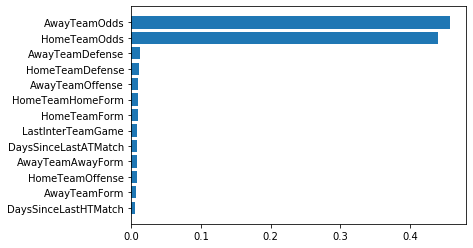

In [29]:
srt = np.argsort(gb.feature_importances_)
plt.barh(matches.drop(['ResultCategorical','Result'],axis=1).columns[srt],gb.feature_importances_[srt])
plt.show()

In [110]:
gb.predict_proba(matches.iloc[:int(0.8*len(matches))].drop(['ResultCategorical','Result'],axis=1))

array([[0.22693129, 0.24736899, 0.52569973],
       [0.37384108, 0.2978125 , 0.3283464 ],
       [0.52778625, 0.22273637, 0.24947739],
       ...,
       [0.2611593 , 0.29785958, 0.44098106],
       [0.10282702, 0.17954625, 0.71762675],
       [0.48408532, 0.2363201 , 0.27959454]], dtype=float32)

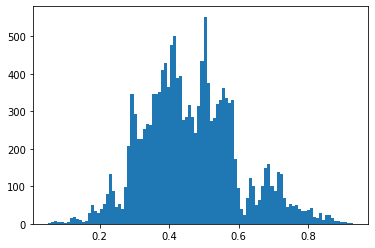

In [116]:
plt.hist(gb.predict_proba(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))[:,2],bins=100)
plt.show()

In [30]:
pred = gb.predict(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))
pred_prob = gb.predict_proba(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))

In [132]:
#endre uavgjort til hjemmeseier...
#pd.Series(np.where(pred==1,0,pred)).value_counts()
pred = np.where(pred==1,0,pred)

array([2, 0, 0, ..., 2, 2, 0], dtype=int64)

In [143]:
odds = matches[["AwayTeamOdds","Result","HomeTeamOdds"]].iloc[int(0.9*len(matches)):].values[range(len(pred)),pred.tolist()]
all_odds = matches[["AwayTeamOdds","Result","HomeTeamOdds"]].iloc[int(0.9*len(matches)):]

In [33]:
def kelly_criterion(prob_win, net_fractional_odds):
    prob_loss = 1 - prob_win
    
    return (((net_fractional_odds*prob_win) - prob_loss) / prob_loss)

In [182]:
def kelly(y, y_hat, odds, cash=1000,bet_frac=0.25):    
    
    cash_at_t = [cash]
    for t in range(len(y)):
        bet = bet_frac * cash
        if y[t] == y_hat[t]:
            cash += bet*odds[t]
        else:
            cash -= bet
    
        cash_at_t.append(cash)
    
    return cash_at_t

def kelly_batch(y, y_hat, odds, probs, cash=1000,bet_frac=0.25, mean_batch_size=15):    
    
    
    odds_ratio = odds*probs
    cash_at_t = [cash]
    
    
    t = 0
    while t < len(y):
    #for t in range(0,len(y),batch_size):
        batch_size = np.random.randint(low=mean_batch_size - int(mean_batch_size/2), high=mean_batch_size + int(mean_batch_size/2))
        y_t = y[t:t+batch_size]
        y_hat_t = y_hat[t:t+batch_size]
        probs_t = probs[t:t+batch_size]
        odds_t = odds[t:t+batch_size]
        
        assert kelly_criterion(np.mean(probs_t),np.mean(odds_t) - 1) < 1, f"{np.mean(probs_t)},{np.mean(odds_t) - 1,t}"
        bet = (cash*kelly_criterion(np.mean(probs_t),np.mean(odds_t) - 1)) / batch_size#(bet_frac * cash) / batch_size
        assert bet*batch_size < cash, f"{bet*batch_size}, {cash}"
        
        for i in range(len(y_t)):
            #if odds_ratio[t] > 0.95:
            cash -= bet
            if y_t[i] == y_hat_t[i]:
                cash += bet*odds_t[i]

        t+=batch_size
        cash_at_t.append(cash)
    
    return cash_at_t

def kelly_batch_single(y, y_hat, odds, probs, cash=1000, mean_batch_size=15):    
    
    cash_at_t = [cash]
    n_bets = 0
    t = 0
    while t < len(y):
        
        batch_size = np.random.randint(low=mean_batch_size - int(mean_batch_size/2), high=mean_batch_size + int(mean_batch_size/2))    
        y_t = y[t:t+batch_size]
        y_hat_t = y_hat[t:t+batch_size]
        probs_t = probs[t:t+batch_size]
        odds_t = odds[t:t+batch_size]
        
        batch_wins = 0
        for i in range(len(y_t)):
            
            kelly_away = kelly_criterion(probs_t[i,0],odds_t[i,0]-1)
            kelly_home = kelly_criterion(probs_t[i,-1],odds_t[i,-1]-1)
            
            if  kelly_away > 0:
                bet = (cash*kelly_away)
                cash -= bet
                if y_t[i] == 0:
                    batch_wins += bet*odds_t[i,0]
                n_bets += 1
                
            elif kelly_home > 0:
                bet = (cash*kelly_home)
                cash -= bet
                if y_t[i] == 2:
                    batch_wins += bet*odds_t[i,-1]
                n_bets +=1
                
        cash += batch_wins
        t+=batch_size
        cash_at_t.append(cash)
        
    return cash_at_t, n_bets

In [275]:
runs = {}
for i in np.linspace(0.1,1,20):
    runs[i] = kelly(matches["ResultCategorical"].iloc[int(len(matches)*0.9):].values, pred, odds, bet_frac=i)

C:\Users\bfesc\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\bfesc\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [352]:
np.quantile(odds*,0.95)

1.0002321336617825

In [35]:
probs = pred_prob[range(len(pred)),pred.tolist()]

In [58]:
len(probs) / 20

740.9

In [60]:
range(0,len(probs),20)[-1]

14800

In [157]:
all_odds.shape, pred_prob.shape

((14818, 3), (14818, 3))

In [183]:
#batch_runs = {}
#for i in np.linspace(0.1,1,10):
#batch_runs = kelly_batch(matches["ResultCategorical"].iloc[int(len(matches)*0.9):].values, pred, odds, probs)
single_batch_runs, n_bets = kelly_batch_single(matches["ResultCategorical"].iloc[int(len(matches)*0.9):].values, pred, all_odds.values, pred_prob)

In [185]:
n_bets / int(len(matches)*0.9)

0.016226998005369007

In [92]:
res = []
for start_point in range(0,len(pred),50):
    batch_r = {}
    batch_r[i] = kelly_batch(matches["ResultCategorical"].iloc[int(len(matches)*0.9)+start_point:].values, 
                                 pred[start_point:], odds[start_point:],probs[start_point:])
    batch_r = pd.DataFrame(batch_r).T.fillna(0)
    mx = (batch_r[max(batch_r.columns)].max())
    wins = (sum(batch_r[max(batch_r.columns)] != 0))
    res.append({"start" : start_point, "max_win" : mx, "wins" : wins})

In [180]:
#runs = pd.DataFrame(runs).T.fillna(0)
#batch_runs = pd.DataFrame(batch_runs).T.fillna(0)
single_batch_runs = pd.DataFrame(single_batch_runs).T.fillna(0)

In [127]:
batch_runs.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1000.0,1026.334334,1043.633886,1026.395947,1010.452582,988.273658,1025.126865,1059.177933,1049.240133,1066.876109,...,7.945483e+12,8.361368e+12,8.470352e+12,8.581127e+12,8.838544e+12,8.850040e+12,9.043760e+12,9.114200e+12,9.097188e+12,9.083591e+12


In [172]:
single_batch_runs.head()

,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,1000.0,999.504634,999.504634,999.504634,999.504634,999.504634,999.504634,999.504634,999.504634,999.504634,...,0.158523,0.159863,0.15841,0.158582,0.156767,0.156394,0.159864,0.161045,0.165304,0.165304


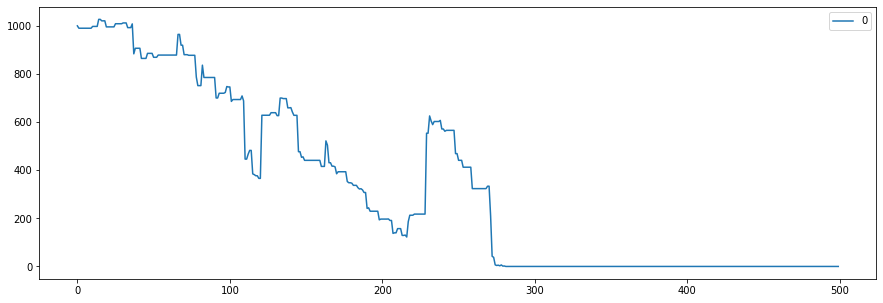

In [181]:
n=500

fig, ax = plt.subplots()
fig.set_size_inches(15,5)
#batch_runs.iloc[0].T.iloc[:n].plot(legend=True,ax=ax)
single_batch_runs.iloc[0].T.iloc[:n].plot(legend=True,ax=ax)


In [243]:
runs.loc[(runs == 0).idxmax(axis=1).loc[lambda s: s== 0].index]#[range(90)].T.plot()

,0,1,2,3,4,5,6,7,8,9,...,14786,14787,14788,14789,14790,14791,14792,14793,14794,14795
0.672727,1000.0,5036.363636,1648.264463,9410.091660,3079.666362,1007.890809,3720.033350,1217.465460,3838.336599,14683.381697,...,1.385661e+283,4.508437e+283,2.422260e+284,1.301414e+285,4.259174e+284,1.393912e+284,4.561892e+283,1.453585e+284,4.757187e+283,1.275791e+284
0.681818,1000.0,5090.909091,1619.834711,9350.864012,2975.274913,946.678381,3528.528512,1122.713618,3572.270638,13801.954273,...,3.582476e+218,1.176518e+219,6.390630e+219,3.471274e+220,1.104496e+220,3.514306e+219,1.118188e+219,3.595992e+219,1.144179e+219,3.094485e+219
0.690909,1000.0,5145.454545,1590.413223,9282.229902,2869.052879,886.798163,3337.585812,1031.617433,3312.429827,12924.498489,...,9.041970e+150,2.997002e+151,1.645627e+152,9.035986e+152,2.792941e+152,8.632727e+151,2.668297e+151,8.659838e+151,2.676677e+151,7.300029e+151
0.700000,1000.0,5200.000000,1560.000000,9204.000000,2761.200000,828.360000,3147.768000,944.330400,3059.630528,12054.943870,...,1.551643e+80,5.190247e+80,2.880587e+81,1.598726e+82,4.796177e+81,1.438853e+81,4.316559e+80,1.413673e+81,4.241020e+80,1.166280e+81
0.709091,1000.0,5254.545455,1528.595041,9115.984974,2651.922901,771.468480,2959.633625,860.984327,2814.636066,11197.133643,...,1.217536e+06,4.109739e+06,2.305190e+07,1.293002e+08,3.761460e+07,1.094243e+07,3.183252e+06,1.051920e+07,3.060132e+06,8.484910e+06


In [91]:
accs = np.zeros((150,150))
y = np.sign(matches.iloc[int(0.8*len(matches)):]['Result'])

for i, t_1 in enumerate(np.linspace(0,1.5,150)):
    for j ,t_2 in enumerate(np.linspace(-1.5,0,150)):
        y_hat = np.where(pred > t_1,1,np.where(pred < t_2,-1,0))
        acc = (y_hat == y).mean()
        accs[i,j] = acc

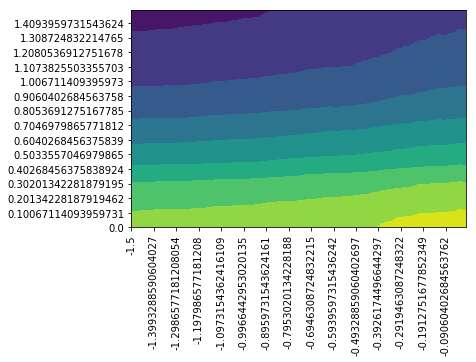

In [100]:
plt.contourf(accs)
plt.xticks(range(0,150,10),np.linspace(-1.5,0,150)[range(0,150,10)],rotation=90)
plt.yticks(range(0,150,10),np.linspace(0,1.5,150)[range(0,150,10)])
plt.show()

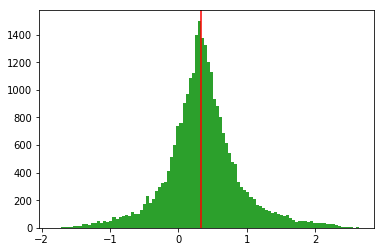

In [123]:
plt.hist(pred,bins=100)
plt.axvline(np.median(pred),color='red')
plt.show()

Average return on bet: 21.803363427456052%
Bets made: 6559 home, 220 away
33.13173034370851% losing bets
1478.0500067472458


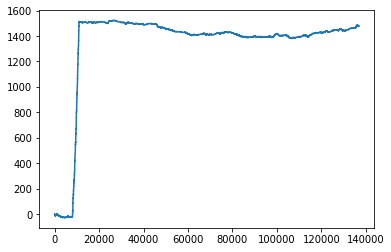

0.6686826965629149

In [45]:

test_matches = matches#.iloc[:int(0.05*len(matches))] 
y = test_matches['Result'].values
pred = gboost.predict(test_matches.drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1))
cash = 0
bet = 1
home_prod = test_matches['HomeTeamOdds'].values * pred
away_prod = test_matches['AwayTeamOdds'].values * -pred
#home_prod = pred
#away_prod = -pred

tot_winnings = [cash]
winnings = []
home_threshold = 2
away_threshold = 3
home_bets = 0
away_bets = 0
losing_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if home_prod[i] > home_threshold:
        cash -= bet
        home_bets += 1
        if pred[i] > 0 and y[i] > 0:
            cash += bet * test_matches.iloc[i]['HomeTeamOdds']
        else:
            losing_bets +=1
    elif away_prod[i] > away_threshold:
        cash -= bet
        away_bets += 1
        if pred[i] < 0 and y[i] < 0:
            cash += bet * test_matches.iloc[i]['AwayTeamOdds']
        else:
            losing_bets +=1
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print("{}% losing bets".format((losing_bets/(home_bets+away_bets))*100))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
#plt.bar(np.arange(len(winnings)),np.sort(winnings))
#plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

In [24]:
np.sign(test_matches.Result).value_counts() / test_matches.shape[0]

 1    0.472478
-1    0.268798
 0    0.258724
Name: Result, dtype: float64

In [156]:
np.where(pred>t,test_matches['HomeTeamOdds'],np.where(pred<-t,test_matches['AwayTeamOdds'],0)).sum()

404.1700015068054

In [167]:
t=0
np.where((pred>t) | (pred<-t))[0].shape

(27396,)

In [171]:
res = test_matches['Result']

In [182]:
(np.where((pred>t) | (np.sign(res)>0),test_matches['HomeTeamOdds'],
                             np.where((pred<-t) | (np.sign(res)<0),test_matches['AwayTeamOdds'],-1)))

array([2.25      , 4.        , 3.20000005, ..., 2.75      , 2.5       ,
       2.61999989])

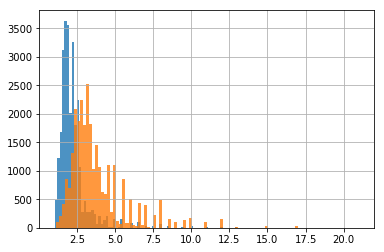

In [186]:
test_matches['HomeTeamOdds'].hist(alpha=0.8,bins=100)
test_matches['AwayTeamOdds'].hist(alpha=0.8,bins=100)
plt.show()

In [174]:
winnings = []
for t in np.linspace(0,2,20):
    winnings.append(np.where((pred>t) | (np.sign(res)>0),test_matches['HomeTeamOdds'],
                             np.where((pred<-t) | (np.sign(res)<0),test_matches['AwayTeamOdds'],-1)).sum())
    

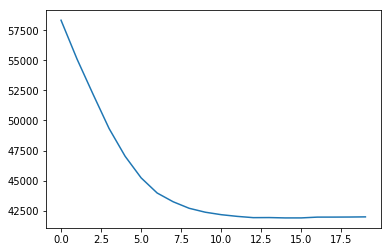

In [175]:
plt.plot(winnings)
plt.show()

In [200]:
winnings = []
n_bets = []
bet=1
for t in tqdm(np.linspace(0,10,10)):
    cash = 0
    n = 0
    for i in range(len(pred)):
        
        if pred[i]*test_matches.iloc[i]['HomeTeamOdds'] > t:
            cash -= bet
            n+=1
            if y[i] > 0:
                cash += bet * test_matches.iloc[i]['HomeTeamOdds']
            
        elif pred[i]*test_matches.iloc[i]['AwayTeamOdds'] < -t:
            cash -= bet
            n+=1
            if y[i] < 0:
                cash += bet * test_matches.iloc[i]['AwayTeamOdds']
    n_bets.append(n)
    winnings.append(cash)

    
plt.plot(np.linspace(0,2,20),winnings)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.77s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

717.3789998292923
3.3333333333333335


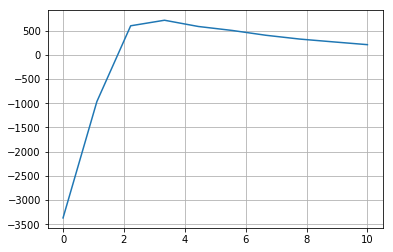

In [201]:
print(max(winnings))
print(np.linspace(0,10,10)[np.argmax(winnings)])
plt.plot(np.linspace(0,10,10),winnings)
plt.grid()
plt.show()

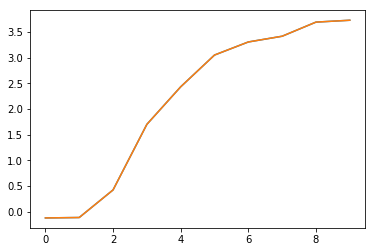

In [204]:
plt.plot(np.array(winnings) / np.array(n_bets))
plt.show()

In [101]:
accs.max()

0.48528982333187326

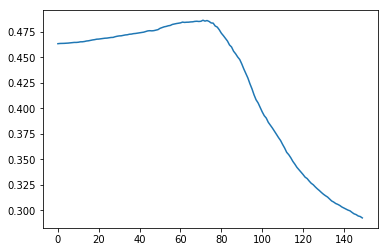

In [90]:
plt.plot(accs)
plt.show()

In [231]:
matches_X = matches[['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                                            'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                                          'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame']]

pred = None
with tf.device('/cpu:0'):
    pred = model.predict(matches_X)

Average return on bet: -3.197604096578267%
Bets made: 133 home, 34 away
-106.799976826


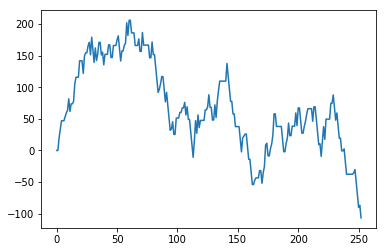

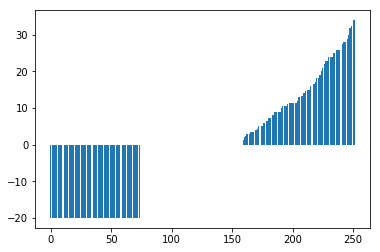

0.5568862275449101

In [18]:
y = matches['Result'].values
cash = 0
bet = 20

home_prod = new_data_d['WHH'].values * pred.squeeze()
away_prod = new_data_d['WHA'].values * -pred.squeeze()

tot_winnings = [cash]
winnings = []
home_threshold = 21
away_threshold = 7
home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if home_prod[i] > home_threshold:
        cash -= bet
        home_bets += 1
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif away_prod[i] > away_threshold:
        cash -= bet
        away_bets += 1
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

In [ ]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
threshold = 10
home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i][0] > threshold:
        cash -= bet
        home_bets += 1
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif pred[i][0] < -threshold:
        cash -= bet
        away_bets += 1
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

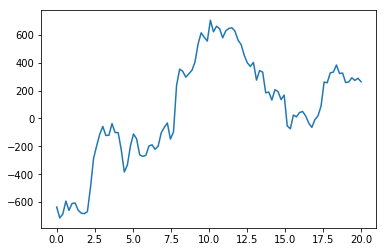

In [13]:
winnings = []

for t in np.linspace(0,20,100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] > t:
            cash -= bet
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] < -t:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.linspace(0,20,100),winnings)
plt.show()

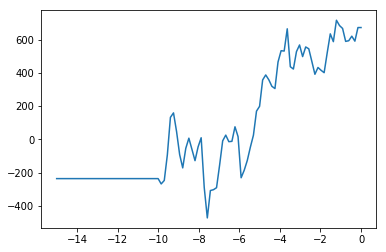

In [14]:
winnings = []
home_threshold = 10

for t in np.linspace(0,-15,100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] > home_threshold:
            cash -= bet
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] < -t:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.linspace(0,-15,100),winnings)
plt.show()

In [15]:
np.linspace(0,15,100)[np.argmax(winnings)]

1.2121212121212122

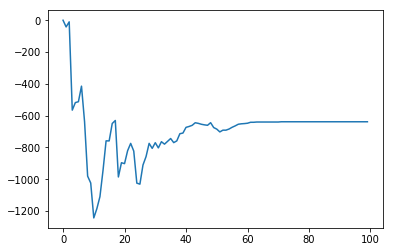

In [16]:
winnings = []


for t in range(100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] < t and pred[i][0] > 0.5:
            cash -= bet
            if y[i] > 0 :
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] > -t and pred[i][0] < -0.5:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.arange(100),winnings)
plt.show()

In [17]:
cash_h = 0
cash_a = 0

for i in range(len(pred)):
    cash_h -= bet
    cash_a -= bet
    
    if y[i] > 0:
        cash_h += bet * new_data.iloc[i]['WHH']
    if y[i] < 0:
        cash_a += bet * new_data.iloc[i]['WHH']

    
    

In [18]:
pred_n = pred + pred.max()
pred_n /= pred_n.max()
len(np.where(pred_n > 0.5)[0]) / len(pred_n) == len(np.where(pred > 0)[0]) / len(pred)

True

In [31]:
odds = np.zeros((len(pred),2))

for i in range(len(pred_n)):
    if pred_n[i] == 0:
        odds[i][0] = 5000
        odds[i][1] = 1
    elif pred_n[i] == 1:
        odds[i][1] = 5000
        odds[i][0] = 1
    else:
        odds[i][0] = 1/pred_n[i]
        odds[i][1] = 1/(1 - pred_n[i])

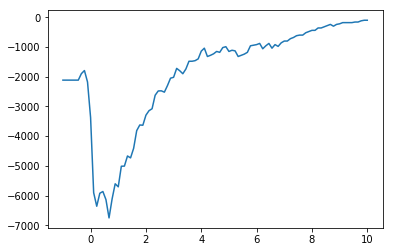

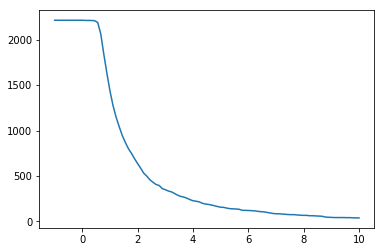

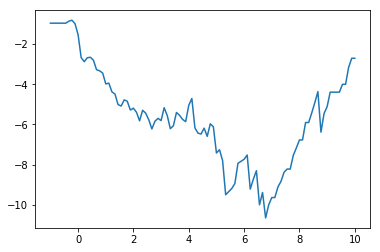

In [20]:
winnings = []
bets_made = []

home_diff = new_data_d['WHH'].values - odds[:,0]
away_diff = new_data_d['WHA'].values - odds[:,1]

for t in np.linspace(-1,10,100):
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_diff[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif away_diff[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
plt.plot(np.linspace(-1,10,100),winnings)
plt.show()
plt.plot(np.linspace(-1,10,100),bets_made)
plt.show()
plt.plot(np.linspace(-1,10,100), winnings_per_bet)
plt.show()

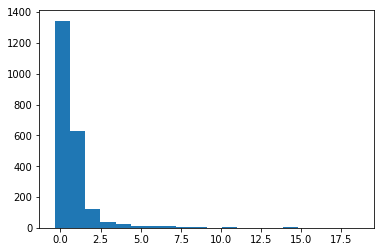

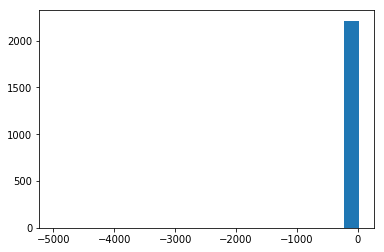

In [21]:
plt.hist(home_diff, bins=20)
plt.show()
plt.hist(away_diff, bins=20)
plt.show()

In [22]:
bets_made = [] #prediction, odds, odds*pred, utbetaling
bet = 1
for i in range(len(pred)):
    
    if pred[i][0] > threshold:
        cash = 0
        odd = new_data_d.iloc[i]['WHH']
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * odd
            
        bets_made.append([pred[i][0], odd, odd*pred[i][0] , cash])
        
    elif pred[i][0] < -threshold:
        cash = 0 
        odd = new_data_d.iloc[i]['WHA']
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * odd
            
        bets_made.append([-pred[i][0], odd, odd*-pred[i][0], cash])



In [23]:
from sklearn.linear_model import LinearRegression
bets_made = np.array(bets_made)

lr = LinearRegression()
lr.fit(bets_made[:,:-1],bets_made[:,-1])
lr.coef_

array([ 0.01038985,  0.1825837 , -0.0057339 ])

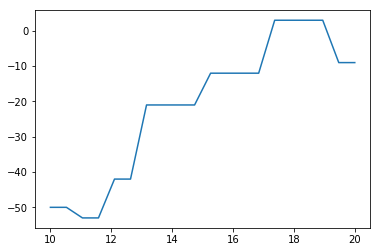

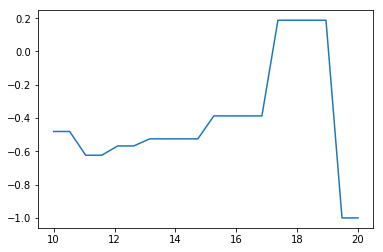

In [24]:
threshold = np.linspace(10,20,20)
winnings = []
n_bets = []
for t in threshold:
    cash=0
    bets = 0
    for i in range(len(pred)):
        h_odd = new_data_d.iloc[i]['WHH']
        a_odd = new_data_d.iloc[i]['WHA']
        
        if h_odd > t:
            cash -= bet
            bets += 1
            if y[i] > 0 :
                cash += bet * h_odd
            
        elif a_odd > t:
            cash -= bet
            bets += 1
            if y[i] < 0:
                cash += bet * a_odd
    
    n_bets.append(bets)
    winnings.append(cash)
    
plt.plot(threshold,winnings)
plt.show()
plt.plot(threshold,np.array(winnings)/np.array(n_bets))
plt.show()

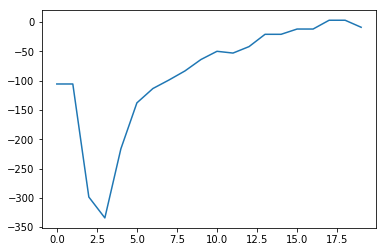

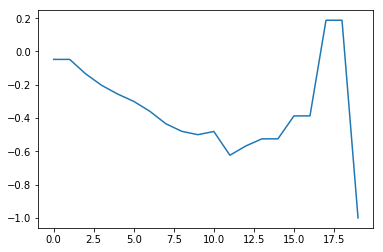

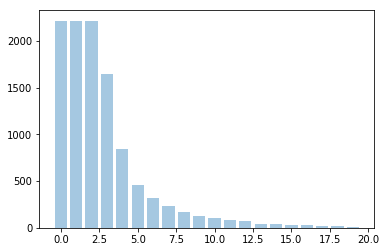

In [25]:
threshold = np.arange(0,20)
winnings = []
n_bets = []
for t in threshold:
    cash=0
    bets = 0
    for i in range(len(pred)):
        h_odd = new_data_d.iloc[i]['WHH']
        a_odd = new_data_d.iloc[i]['WHA']
        
        if h_odd > t:
            cash -= bet
            bets += 1
            if y[i] > 0 :
                cash += bet * h_odd
            
        elif a_odd > t:
            cash -= bet
            bets += 1
            if y[i] < 0:
                cash += bet * a_odd
    
    n_bets.append(bets)
    winnings.append(cash)
    
plt.plot(winnings)
plt.show()
plt.plot(np.array(winnings)/np.array(n_bets))
plt.show()
plt.bar(threshold,n_bets,alpha=0.4)
plt.show()

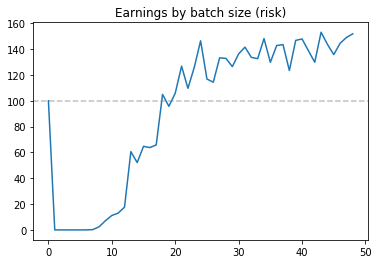

In [26]:
cash = 100
bet = 1

tot_winnings = [cash]
winnings = []
threshold = 10
home_bets = 0
away_bets = 0

prev_j = 0

batch_size = np.arange(2,50,1)

for b in batch_size:
    cash = 100
    prev_j = len(pred)
    for j in range(len(pred)-7,-1,-b):
        cur_pred = pred[j:prev_j]
        cur_bet = cash/len(cur_pred)
        home_odds = new_data_d.iloc[j:prev_j]['WHH']
        away_odds = new_data_d.iloc[j:prev_j]['WHA']
        y_j = y[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i][0] > threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i][0] < -threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
    #     print("BET: ", b)
    #     print("WON: ", w)
    #     print("")
        prev_j = j
    
    tot_winnings.append(cash)
    #winnings.append(tot_winnings[-1] - tot_winnings[-2])

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Earnings by batch size (risk)")
plt.show()

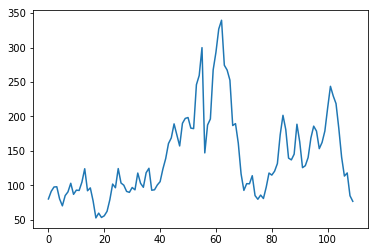

In [27]:
tot_winnings = []
cash = 100
prev_j = len(pred)

for j in range(len(pred)-20,-1,-20):
        cur_pred = pred[j:prev_j]
        cur_bet = cash/len(cur_pred)
        home_odds = new_data_d.iloc[j:prev_j]['WHH']
        away_odds = new_data_d.iloc[j:prev_j]['WHA']
        y_j = y[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i][0] > threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i][0] < -threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
    #     print("BET: ", b)
    #     print("WON: ", w)
    #     print("")
        prev_j = j
    
        tot_winnings.append(cash)
        
plt.plot(tot_winnings)
plt.show()

70.1244 12.7328


C:\Users\bfesc\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


10.0


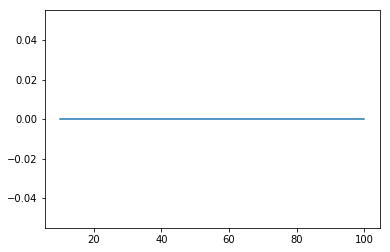

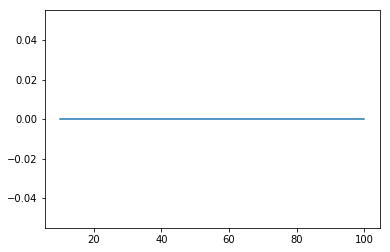

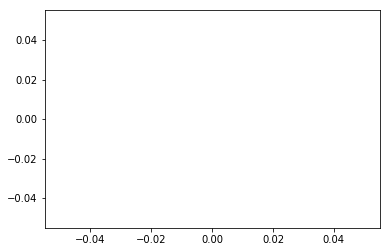

In [48]:
winnings = []
bets_made = []

print(np.max(pred.squeeze()),-np.min(pred.squeeze()))
home_prod = new_data_d['WHH'].values * (pred.squeeze() / np.max(pred.squeeze()))
away_prod = new_data_d['WHA'].values * (-pred.squeeze() / -np.min(pred.squeeze()))

home_ts = np.linspace(10,100,100)

for t in home_ts:
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_prod[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
#         elif away_diff[i] > t:
#             cash -= bet
#             bets += 1
            
#             if y[i] < 0:
#                 cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
print(home_ts[np.argmax(winnings)])
plt.plot(home_ts,winnings)
plt.show()
plt.plot(home_ts,bets_made)
plt.show()
plt.plot(home_ts, winnings_per_bet)
plt.show()

7.07070707071


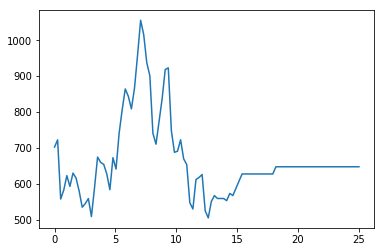

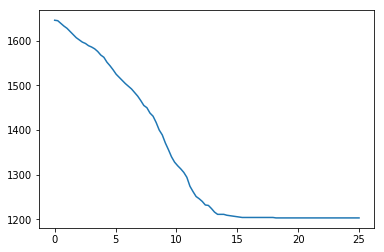

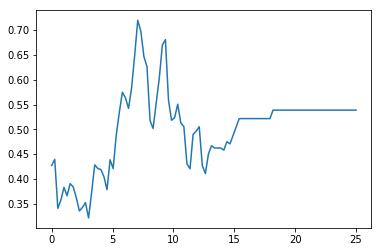

In [42]:
winnings = []
bets_made = []

home_prod = new_data_d['WHH'].values * pred.squeeze()
away_prod = new_data_d['WHA'].values * -pred.squeeze()

away_ts = np.linspace(0,25,100)
home_t = 21

for t in away_ts:
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_prod[i] > home_t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif away_prod[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
print(away_ts[np.argmax(winnings)])
plt.plot(away_ts,winnings)
plt.show()
plt.plot(away_ts,bets_made)
plt.show()
plt.plot(away_ts, winnings_per_bet)
plt.show()

In [19]:

odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_t in np.linspace(2,20,20):
        cash = 0
        
        for i in range(len(pred)):

            if pred[i] > pred_t and new_data_d['WHH'].iloc[i] > odd_t:
                cash -= bet

                if y[i] > 0:
                    cash += bet * new_data_d.iloc[i]['WHH']

    #         elif away_prod[i] > t:
    #             cash -= bet
    #             bets += 1

    #             if y[i] < 0:
    #                 cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.25it/s]


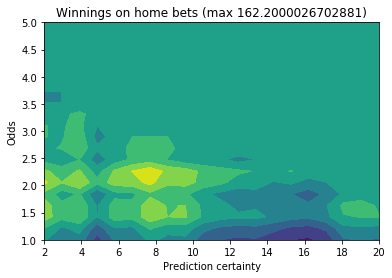

In [22]:

home_odd = 2
home_pred = 10.5
odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_t in np.linspace(-10,5,20):
        cash = 0
        
        for i in range(len(pred)):

            if pred[i] > home_pred and new_data_d['WHH'].iloc[i] > home_odd:
                cash -= bet

                if y[i] > 0:
                    cash += bet * new_data_d.iloc[i]['WHH']

            elif pred[i] < pred_t and new_data_d['WHA'].iloc[i] > odd_t:
                cash -= bet


                if y[i] < 0:
                    cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)
    

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]


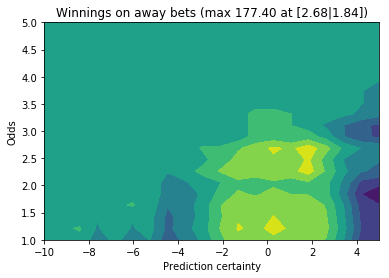

In [100]:
np.argmax(np.array(odd_winnings))

69

Average return on bet: 3.046154792492206%
Bets made: 40 home, 25 away
39.6000123024


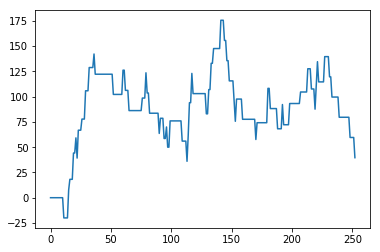

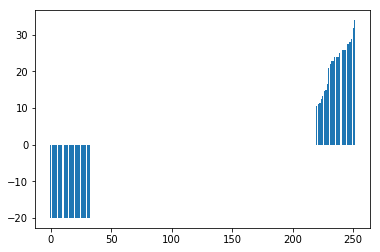

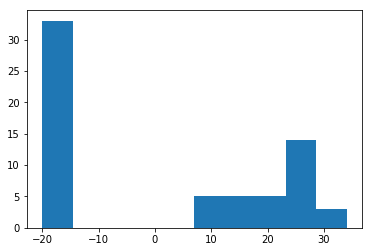

In [24]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3

home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i] > home_pred and new_data_d.iloc[i]['WHH'] > home_odd:
        cash -= bet
        home_bets += 1
        if y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif pred[i] < away_pred and new_data_d.iloc[i]['WHA'] > away_odd:
        cash -= bet
        away_bets += 1
        if y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)
plt.hist(np.array(winnings)[np.where(np.array(winnings) != 0)[0]],bins=10)
plt.show()

**TODO:** Test batch earnings

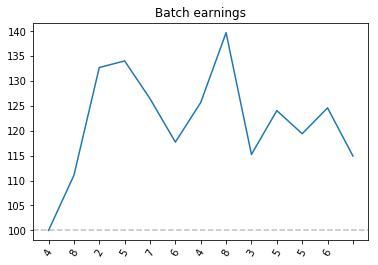

In [28]:
cash = 100
tot_winnings = [cash]
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3
batch = 20
prev_j = len(pred)
bets_made = []

for j in range(len(pred)-batch,-1,-batch):
    cur_pred = pred[j:prev_j]
    
    cur_bet = cash/len(cur_pred)
    home_odds = new_data_d.iloc[j:prev_j]['WHH']
    away_odds = new_data_d.iloc[j:prev_j]['WHA']
    y_j = y[j:prev_j]
    w = 0
    b = 0

    for i in range(len(cur_pred)):
        if cur_pred[i][0] > home_pred and home_odds[i] > home_odd:
            cash -= cur_bet
            b+=1
            if y_j[i] > 0:
                cash += cur_bet * home_odds[i]
                w+=1

        elif cur_pred[i][0] < away_pred and away_odds[i] > away_odd:
            cash -= cur_bet
            b+=1
            if y_j[i] < 0:
                cash += cur_bet * away_odds[i]
                w+=1
    prev_j = j
    bets_made.append(b)
    tot_winnings.append(cash)

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.xticks(np.arange(len(tot_winnings)),bets_made,rotation=60)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Batch earnings")
plt.show()

In [27]:
tot_winnings = []
avg_bets_made = []
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3

home_odds = new_data_d['WHH']
g = pd.DataFrame(pred, columns=['pred'])
g['odds'] = home_odds.values

g['aOdds'] = new_data_d['WHA'].values
g['y'] = y
bets_to_make = g.iloc[np.append(np.where((g['pred'] > home_pred) & (g['odds'] > home_odd))[0],
                         np.where((g2['pred'] < away_pred) & (g['aOdds'] > away_odd))[0])]


print(bets_to_make.shape)
pred_m = bets_to_make['pred'].values
home_odds_m = bets_to_make['odds'].values
away_odds_m = bets_to_make['aOdds'].values
y_m = bets_to_make['y'].values

for batch in range(3,20,1):
    cash = 100
    prev_j = len(pred_m)
    
    bets_made = []
    for j in range(len(pred_m)-batch,-1,-batch):
        cur_pred = pred_m[j:prev_j]
        cur_bet = cash/batch
        home_odds = home_odds_m
        away_odds = away_odds_m
        y_j = y_m[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i] > home_pred:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i] < away_pred:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
        prev_j = j
    
        bets_made.append(b)
    avg_bets_made.append(np.mean(bets_made))
    tot_winnings.append(cash)

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Batch earnings")
plt.show()

NameError: name 'g2' is not defined

In [182]:
from sklearn.linear_model import LinearRegression
home_odds = new_data_d['WHH']

linreg = LinearRegression()
linreg = linreg.fit(X=np.array([home_odds,pred.squeeze()]).T,y=(y*home_odds).values)
linreg.coef_

array([-1.766505  ,  0.00887195], dtype=float32)

In [189]:
p = linreg.predict(np.array([home_odds,pred.squeeze()]).T)

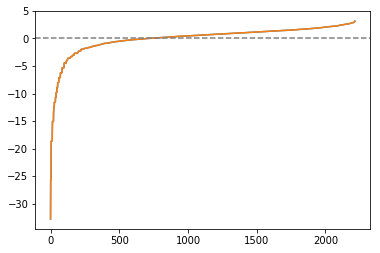

In [195]:
plt.plot(np.sort(p))
plt.axhline(0,ls='--',color='grey')
plt.show()

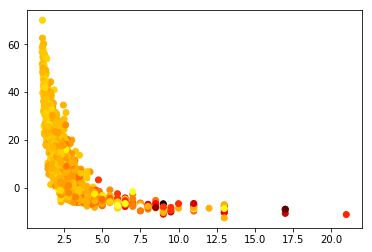

In [207]:
plt.scatter(home_odds,pred.squeeze().T, c=(y*home_odds).values.astype(np.float32), cmap='hot')
plt.show()

In [26]:
y_hot = np.zeros(len(y))
y_hot[y > 0] +=1

g = pd.DataFrame(pred, columns=['pred'])
g['odds'] = home_odds.values
g['winnings'] = home_odds.values*y_hot - 1
g.head()

NameError: name 'home_odds' is not defined

In [25]:
winnings = np.zeros((60,8))

for i in range(60):
    b1 = g.iloc[np.where((g['pred'] > i) & (g['pred'] <= i+1))[0]]
    for j in range(8):
        b2 = b1['winnings'].iloc[np.where((b1['odds'] > j) & (b1['odds'] <= j+1))[0]]
        if len(b2) > 0:
            winnings[i,j] = np.sum(b2)

NameError: name 'g' is not defined

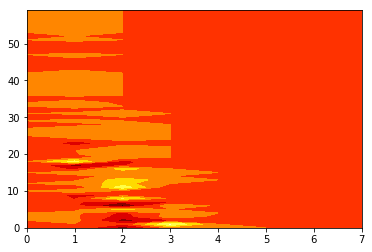

In [278]:
plt.contourf(range(winnings.shape[1]),range(winnings.shape[0]),winnings, cmap='hot')
plt.show()

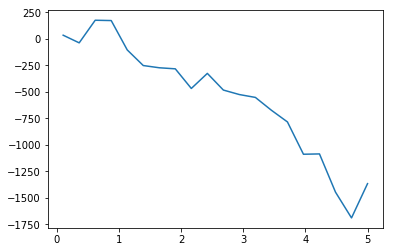

In [372]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = []
winnings = []
home_threshold = 21
away_threshold = 7
home_bets = 0
away_bets = 0

threshold = np.linspace(0.1,5,20)
for t in threshold:
    cash = 0
    for i in range(len(pred)-1,-1,-1):

        if pred[i] > -t and pred[i] < t:
            cash -= bet
            if y[i] == 0:
                cash += bet * new_data_d.iloc[i]['WHD']
    
    tot_winnings.append(cash)


plt.plot(threshold, tot_winnings)
plt.show()

In [70]:
training_matches = make_training_set(old_data, n_matches=len(old_data.index))

  4%|███▍                                                                        | 5818/129936 [01:01<21:44, 95.15it/s]

Apollon Platanias


  5%|███▌                                                                        | 6027/129936 [01:03<21:39, 95.39it/s]

Lamia AEK


  5%|███▌                                                                        | 6115/129936 [01:04<21:36, 95.48it/s]

Perugia Parma
Foggia Palermo


  5%|███▌                                                                        | 6126/129936 [01:04<21:36, 95.49it/s]

Cremonese Carpi


  5%|███▌                                                                        | 6192/129936 [01:04<21:34, 95.56it/s]

Venezia Spezia


  5%|███▋                                                                        | 6258/129936 [01:05<21:33, 95.62it/s]

Apollon PAOK
Kasimpasa Yeni Malatyaspor


  5%|███▋                                                                        | 6269/129936 [01:05<21:33, 95.63it/s]

Osmanlispor Goztep


  5%|███▋                                                                        | 6291/129936 [01:05<21:32, 95.65it/s]

AZ Alkmaar NAC Breda
Groningen VVV Venlo
Parma Brescia


  5%|███▋                                                                        | 6302/129936 [01:05<21:32, 95.66it/s]

Leonesa Valladolid
Albacete Lugo


  5%|███▋                                                                        | 6313/129936 [01:05<21:32, 95.67it/s]

Avellino Foggia
Bari Venezia
Pro Vercelli Cremonese


  5%|███▊                                                                        | 6422/129936 [01:07<21:30, 95.74it/s]

Asteras Tripolis Lamia
Barcelona B Cordoba
Almeria Lorca


  5%|███▊                                                                        | 6433/129936 [01:07<21:29, 95.75it/s]

Sivasspor Kayserispor


  5%|███▊                                                                        | 6455/129936 [01:07<21:29, 95.77it/s]

Alcorcon Albacete
Novara Parma


  5%|███▊                                                                        | 6466/129936 [01:07<21:29, 95.78it/s]

Cremonese Avellino
Foggia Virtus Entella
Cesena Venezia
Sevilla B Leonesa


  5%|███▊                                                                        | 6499/129936 [01:07<21:28, 95.80it/s]

Lorca Vallecano


  5%|███▊                                                                        | 6510/129936 [01:07<21:28, 95.81it/s]

Granada Barcelona B


  5%|███▊                                                                        | 6521/129936 [01:08<21:28, 95.82it/s]

Barcelona B Tenerife
Portimonense Maritimo


  5%|███▊                                                                        | 6543/129936 [01:08<21:27, 95.84it/s]

Boavista Aves


  5%|███▊                                                                        | 6565/129936 [01:08<21:26, 95.86it/s]

Panionios Apollon
VVV Venlo Ajax


  5%|███▊                                                                        | 6576/129936 [01:08<21:26, 95.87it/s]

Pescara Foggia


  5%|███▊                                                                        | 6587/129936 [01:08<21:26, 95.88it/s]

Venezia Salernitana


  5%|███▉                                                                        | 6642/129936 [01:09<21:25, 95.93it/s]

Huesca Lorca
Leonesa Osasuna
Regensburg Holstein Kiel


  5%|███▉                                                                        | 6653/129936 [01:09<21:25, 95.94it/s]

Goztep Trabzonspor
Yeni Malatyaspor Antalyaspor


  5%|███▉                                                                        | 6686/129936 [01:09<21:24, 95.96it/s]

Lamia Olympiakos


  5%|███▉                                                                        | 6708/129936 [01:09<21:23, 95.98it/s]

Albacete Cordoba
Parma Cremonese


  5%|███▉                                                                        | 6719/129936 [01:10<21:23, 95.98it/s]

NAC Breda Sparta Rotterdam
Duisburg Darmstadt
Galatasaray Sivasspor


  5%|███▉                                                                        | 6730/129936 [01:10<21:23, 95.99it/s]

Atromitos Apollon


  5%|███▉                                                                        | 6741/129936 [01:10<21:23, 96.00it/s]

Chateauroux Nimes
Kayserispor Goztep


  5%|███▉                                                                        | 6763/129936 [01:10<21:22, 96.02it/s]

Ingolstadt Regensburg
Granada Albacete


  5%|███▉                                                                        | 6774/129936 [01:10<21:22, 96.03it/s]

NAC Breda PSV Eindhoven
Holstein Kiel Greuther Furth
Aves Sp Braga


  5%|███▉                                                                        | 6785/129936 [01:10<21:22, 96.04it/s]

Twente VVV Venlo


  5%|███▉                                                                        | 6796/129936 [01:10<21:22, 96.05it/s]

Mechelen Antwerp


  5%|███▉                                                                        | 6807/129936 [01:10<21:21, 96.05it/s]

Heidenheim Duisburg


  5%|███▉                                                                        | 6818/129936 [01:10<21:21, 96.06it/s]

Valladolid Barcelona B


  5%|███▉                                                                        | 6829/129936 [01:11<21:21, 96.06it/s]

Sivasspor Yeni Malatyaspor


  5%|████                                                                        | 6858/129936 [01:14<22:08, 92.65it/s]

Xanthi Lamia


  5%|████                                                                        | 6896/129936 [01:14<22:08, 92.64it/s]

Lorca Leonesa


  5%|████                                                                        | 6906/129936 [01:14<22:07, 92.65it/s]

Rio Ave Portimonense


  5%|████                                                                        | 6916/129936 [01:14<22:07, 92.65it/s]

Ajaccio Paris FC
Ajaccio GFCO Quevilly Rouen
Fylde Maidenhead


  5%|████                                                                        | 6927/129936 [01:14<22:07, 92.67it/s]

Halifax Dover Athletic
Dag and Red Ebbsfleet


  5%|████                                                                        | 6947/129936 [01:14<22:06, 92.68it/s]

Lorient Chateauroux
Pacos Ferreira Aves


  5%|████                                                                        | 6958/129936 [01:15<22:06, 92.70it/s]

Sp Braga Portimonense
Yeni Malatyaspor Osmanlispor


  5%|████                                                                        | 6969/129936 [01:15<22:06, 92.71it/s]

Antwerp Genk
Goztep Fenerbahce
Akhisar Belediyespor Sivasspor


  5%|████                                                                        | 6991/129936 [01:15<22:05, 92.74it/s]

Maidenhead Hartlepool
VVV Venlo Sparta Rotterdam


  5%|████                                                                        | 7013/129936 [01:15<22:05, 92.75it/s]

Vitesse NAC Breda


  5%|████                                                                        | 7046/129936 [01:15<22:04, 92.79it/s]

Chester Halifax
Ebbsfleet Fylde


  5%|████▏                                                                       | 7068/129936 [01:16<22:03, 92.81it/s]

Paris FC Le Havre
Quevilly Rouen Bourg Peronnas


  5%|████▏                                                                       | 7079/129936 [01:16<22:03, 92.83it/s]

Maidenhead Wrexham
Chester Fylde


  5%|████▏                                                                       | 7090/129936 [01:16<22:03, 92.84it/s]

Ebbsfleet Maidstone
Barrow Halifax


  5%|████▏                                                                       | 7101/129936 [01:16<22:02, 92.85it/s]

Portimonense Boavista
Gent Antwerp


  5%|████▏                                                                       | 7112/129936 [01:16<22:02, 92.85it/s]

Regensburg Nurnberg
Aves Sp Lisbon
Maidstone Maidenhead


  5%|████▏                                                                       | 7122/129936 [01:16<22:02, 92.85it/s]

Guiseley Ebbsfleet
Halifax Aldershot


  5%|████▏                                                                       | 7133/129936 [01:16<22:02, 92.86it/s]

Fylde Boreham Wood


  6%|████▏                                                                       | 7173/129936 [01:17<22:02, 92.86it/s]

Duisburg Bochum


  6%|████▏                                                                       | 7192/129936 [01:17<22:04, 92.66it/s]

Bourg Peronnas Paris FC
Chateauroux Valenciennes


  6%|████▏                                                                       | 7200/129936 [01:17<22:05, 92.61it/s]

Union Berlin Holstein Kiel
Quevilly Rouen Sochaux


  6%|████▏                                                                       | 7207/129936 [01:17<22:05, 92.57it/s]

Dresden Duisburg


  6%|████▏                                                                       | 7214/129936 [01:17<22:06, 92.53it/s]

Holstein Kiel Sandhausen
Lorient Quevilly Rouen
Bielefeld Regensburg


  6%|████▏                                                                       | 7222/129936 [01:18<22:06, 92.51it/s]

Brest Chateauroux
Antwerp Anderlecht


  6%|████▏                                                                       | 7232/129936 [01:18<22:06, 92.51it/s]

Paris FC Clermont


 10%|███████▌                                                                   | 13193/129936 [02:20<20:47, 93.61it/s]

Panetolikos Kerkyra


 10%|███████▊                                                                   | 13435/129936 [02:23<20:46, 93.49it/s]

Levadeiakos Larisa


 10%|███████▊                                                                   | 13573/129936 [02:25<20:45, 93.41it/s]

Levadeiakos Kerkyra


 10%|███████▊                                                                   | 13601/129936 [02:25<20:45, 93.40it/s]

Larisa Olympiakos


 11%|███████▉                                                                   | 13851/129936 [02:28<20:44, 93.28it/s]

Osmanlispor Adanaspor
Kerkyra Larisa


 11%|████████                                                                   | 13952/129936 [02:29<20:44, 93.23it/s]

Cittadella Novara


 11%|████████                                                                   | 13980/129936 [02:29<20:43, 93.22it/s]

Latina Benevento
Pisa Brescia


 11%|████████                                                                   | 13990/129936 [02:30<20:43, 93.22it/s]

Alanyaspor Trabzonspor


 11%|████████                                                                   | 13999/129936 [02:30<20:43, 93.21it/s]

Spal Virtus Entella


 11%|████████                                                                   | 14026/129936 [02:30<20:43, 93.19it/s]

Karabukspor Antalyaspor


 11%|████████                                                                   | 14072/129936 [02:31<20:43, 93.17it/s]

Larisa Iraklis
Feirense Tondela
Virtus Entella Pisa


 11%|████████▏                                                                  | 14090/129936 [02:31<20:43, 93.16it/s]

Cadiz Getafe
UCAM Murcia Elche


 11%|████████▏                                                                  | 14099/129936 [02:31<20:43, 93.16it/s]

Hannover Dresden


 11%|████████▏                                                                  | 14109/129936 [02:31<20:43, 93.16it/s]

Chaves Setubal


 11%|████████▏                                                                  | 14139/129936 [02:31<20:43, 93.15it/s]

Besiktas Karabukspor
Adanaspor Gaziantepspor
Genclerbirligi Alanyaspor


 11%|████████▏                                                                  | 14149/129936 [02:31<20:42, 93.15it/s]

Lugo Sevilla B


 11%|████████▏                                                                  | 14169/129936 [02:32<20:42, 93.14it/s]

Benevento Verona


 11%|████████▏                                                                  | 14178/129936 [02:32<20:42, 93.14it/s]

Ascoli Spal
Kerkyra Platanias


 11%|████████▏                                                                  | 14214/129936 [02:32<20:42, 93.12it/s]

Reus Deportiu Numancia


 11%|████████▏                                                                  | 14242/129936 [02:32<20:42, 93.11it/s]

Pro Vercelli Cittadella


 11%|████████▏                                                                  | 14252/129936 [02:33<20:42, 93.11it/s]

Erzgebirge Aue Braunschweig


 11%|████████▏                                                                  | 14261/129936 [02:33<20:42, 93.10it/s]

Wurzburger Kickers Bochum


 11%|████████▏                                                                  | 14271/129936 [02:33<20:42, 93.10it/s]

Ternana Pisa
Nacional Chaves
Carpi Benevento
Cittadella Ternana


 11%|████████▏                                                                  | 14281/129936 [02:33<20:42, 93.10it/s]

Pisa Novara
Spal Vicenza


 11%|████████▎                                                                  | 14317/129936 [02:33<20:42, 93.08it/s]

Mirandes Cadiz


 11%|████████▎                                                                  | 14326/129936 [02:33<20:42, 93.07it/s]

Getafe Reus Deportiu
Sevilla B UCAM Murcia


 11%|████████▎                                                                  | 14344/129936 [02:34<20:42, 93.07it/s]

Dresden St Pauli
UCAM Murcia Cordoba


 11%|████████▎                                                                  | 14353/129936 [02:34<20:41, 93.06it/s]

Go Ahead Eagles Ajax


 11%|████████▎                                                                  | 14371/129936 [02:34<20:41, 93.05it/s]

Cadiz Mallorca
Rio Ave Feirense


 11%|████████▎                                                                  | 14381/129936 [02:34<20:41, 93.05it/s]

Boavista Chaves
Karabukspor Rizespor


 11%|████████▎                                                                  | 14399/129936 [02:34<20:41, 93.04it/s]

Twente Sparta Rotterdam


 11%|████████▎                                                                  | 14426/129936 [02:35<20:41, 93.03it/s]

Lokeren Mouscron


 11%|████████▎                                                                  | 14435/129936 [02:35<20:41, 93.02it/s]

Benevento Spal
Greuther Furth Erzgebirge Aue
Bari Cittadella


 11%|████████▎                                                                  | 14454/129936 [02:35<20:41, 93.01it/s]

Reus Deportiu Mirandes


 11%|████████▎                                                                  | 14464/129936 [02:35<20:41, 93.01it/s]

Edinburgh City Berwick


 11%|████████▎                                                                  | 14501/129936 [02:35<20:41, 92.99it/s]

Kasimpasa Adanaspor


 11%|████████▍                                                                  | 14510/129936 [02:36<20:41, 92.99it/s]

Alanyaspor Antalyaspor


 11%|████████▍                                                                  | 14519/129936 [02:36<20:41, 92.99it/s]

Heidenheim Wurzburger Kickers
Tenerife Sevilla B


 11%|████████▍                                                                  | 14529/129936 [02:36<20:41, 92.98it/s]

Galatasaray Karabukspor


 11%|████████▍                                                                  | 14538/129936 [02:36<20:41, 92.98it/s]

Zaragoza UCAM Murcia


 11%|████████▍                                                                  | 14556/129936 [02:36<20:41, 92.97it/s]

Sparta Rotterdam Go Ahead Eagles


 11%|████████▍                                                                  | 14565/129936 [02:36<20:40, 92.97it/s]

Eupen Anderlecht
Feirense Moreirense
Sevilla B Girona


 11%|████████▍                                                                  | 14575/129936 [02:36<20:40, 92.97it/s]

Besiktas Alanyaspor


 11%|████████▍                                                                  | 14602/129936 [02:37<20:40, 92.95it/s]

Cowdenbeath Edinburgh City


 11%|████████▍                                                                  | 14630/129936 [02:37<20:40, 92.93it/s]

Mallorca Reus Deportiu


 11%|████████▍                                                                  | 14639/129936 [02:37<20:40, 92.93it/s]

Lens Amiens


 11%|████████▍                                                                  | 14658/129936 [02:37<20:40, 92.92it/s]

Chaves Tondela


 11%|████████▍                                                                  | 14676/129936 [02:37<20:40, 92.91it/s]

Sochaux Orleans
Strasbourg Nimes


 11%|████████▍                                                                  | 14685/129936 [02:38<20:40, 92.91it/s]

Adanaspor Bursaspor


 11%|████████▍                                                                  | 14694/129936 [02:38<20:40, 92.90it/s]

Almeria Cadiz


 11%|████████▍                                                                  | 14703/129936 [02:38<20:40, 92.90it/s]

North Ferriby Guiseley
Sutton Torquay
Wrexham Solihull


 11%|████████▍                                                                  | 14712/129936 [02:38<20:40, 92.90it/s]

Maidstone Braintree Town


 11%|████████▌                                                                  | 14739/129936 [02:38<20:40, 92.88it/s]

Estoril Feirense


 11%|████████▌                                                                  | 14748/129936 [02:38<20:40, 92.87it/s]

Union Berlin Dresden
Wurzburger Kickers Kaiserslautern


 11%|████████▌                                                                  | 14758/129936 [02:38<20:40, 92.87it/s]

Oostende Mouscron
Go Ahead Eagles Nijmegen


 11%|████████▌                                                                  | 14795/129936 [02:39<20:40, 92.85it/s]

Chester Maidstone
Dover Athletic North Ferriby
Lincoln Sutton


 11%|████████▌                                                                  | 14814/129936 [02:39<20:39, 92.85it/s]

Solihull Bromley


 11%|████████▌                                                                  | 14841/129936 [02:39<20:39, 92.83it/s]

Elgin Edinburgh City


 11%|████████▌                                                                  | 14850/129936 [02:39<20:39, 92.83it/s]

Westerlo Eupen


 11%|████████▌                                                                  | 14859/129936 [02:40<20:39, 92.83it/s]

Zwolle Sparta Rotterdam
Erzgebirge Aue Sandhausen
Tours Strasbourg


 11%|████████▌                                                                  | 14869/129936 [02:40<20:39, 92.83it/s]

Orleans Ajaccio
Amiens Niort


 11%|████████▌                                                                  | 14878/129936 [02:40<20:39, 92.82it/s]

Forest Green Sutton
Lincoln North Ferriby
Solihull Woking
Aldershot Maidstone


 11%|████████▌                                                                  | 14887/129936 [02:40<20:39, 92.82it/s]

Sparta Rotterdam Ajax
Braunschweig Wurzburger Kickers


 11%|████████▌                                                                  | 14896/129936 [02:40<20:39, 92.81it/s]

Heidenheim Erzgebirge Aue


 11%|████████▌                                                                  | 14915/129936 [02:40<20:39, 92.81it/s]

Edinburgh City Forfar


 11%|████████▌                                                                  | 14925/129936 [02:40<20:39, 92.80it/s]

Den Haag Go Ahead Eagles


 11%|████████▌                                                                  | 14934/129936 [02:40<20:39, 92.80it/s]

Mouscron Charleroi
Eupen Mechelen


 12%|████████▋                                                                  | 14961/129936 [02:41<20:39, 92.78it/s]

Strasbourg Amiens


 12%|████████▋                                                                  | 14970/129936 [02:41<20:39, 92.77it/s]

Maidstone York
North Ferriby Braintree Town
Sutton Solihull


 12%|████████▋                                                                  | 14980/129936 [02:41<20:39, 92.77it/s]

Dresden Nurnberg


 12%|████████▋                                                                  | 14989/129936 [02:41<20:39, 92.77it/s]

Brest Orleans
Amiens Reims


 12%|████████▋                                                                  | 14998/129936 [02:41<20:39, 92.76it/s]

Mouscron Anderlecht
Waregem Eupen


 12%|████████▋                                                                  | 15008/129936 [02:41<20:38, 92.76it/s]

Orleans Le Havre
Bourg Peronnas Strasbourg
Valladolid  Mallorca
Gimnastic  Alaves
Ath Bilbao B  Tenerife
Ponferradina  Girona
Oviedo  Osasuna


 12%|████████▋                                                                  | 15018/129936 [02:41<20:38, 92.77it/s]

Numancia  Albacete
Mirandes  Leganes
Llagostera  Zaragoza
Huesca  Lugo
Cordoba  Almeria
Alcorcon  Elche


 16%|████████████▎                                                              | 21381/129936 [03:54<19:52, 91.00it/s]

Ponferradina Ath Bilbao B


 17%|████████████▍                                                              | 21480/129936 [03:56<19:52, 90.96it/s]

PAOK AEK


 17%|████████████▍                                                              | 21517/129936 [03:56<19:52, 90.95it/s]

Pescara Salernitana
Latina Ascoli
Como Trapani
Avellino Novara


 17%|████████████▍                                                              | 21526/129936 [03:56<19:52, 90.95it/s]

Platanias Iraklis


 17%|████████████▍                                                              | 21607/129936 [03:57<19:51, 90.91it/s]

Ascoli Cesena
Novara Virtus Entella


 17%|████████████▍                                                              | 21617/129936 [03:57<19:51, 90.91it/s]

Salernitana Spezia
Vicenza Como


 17%|████████████▌                                                              | 21761/129936 [03:59<19:50, 90.84it/s]

Ascoli Virtus Entella


 17%|████████████▌                                                              | 21770/129936 [03:59<19:50, 90.84it/s]

Iraklis Levadeiakos
Kayserispor Trabzonspor


 17%|████████████▌                                                              | 21779/129936 [03:59<19:50, 90.84it/s]

Girona Huesca


 17%|████████████▌                                                              | 21788/129936 [03:59<19:50, 90.83it/s]

AEK Giannina
Tenerife Oviedo


 17%|████████████▌                                                              | 21797/129936 [03:59<19:50, 90.83it/s]

Osmanlispor Konyaspor


 17%|████████████▌                                                              | 21806/129936 [04:00<19:50, 90.83it/s]

Guimaraes Tondela
Moreirense Uniao Madeira


 17%|████████████▌                                                              | 21824/129936 [04:00<19:50, 90.83it/s]

Virtus Lanciano Ascoli


 17%|████████████▌                                                              | 21833/129936 [04:00<19:50, 90.82it/s]

Brescia Salernitana
Como Livorno
Crotone Novara


 17%|████████████▌                                                              | 21843/129936 [04:00<19:50, 90.82it/s]

Graafschap AZ Alkmaar
Elche Gimnastic
Valladolid Ath Bilbao B


 17%|████████████▋                                                              | 21889/129936 [04:01<19:49, 90.80it/s]

Antalyaspor Eskisehirspor


 17%|████████████▋                                                              | 21962/129936 [04:01<19:49, 90.77it/s]

Le Havre Red Star


 17%|████████████▋                                                              | 21971/129936 [04:02<19:49, 90.77it/s]

Oviedo Albacete
Ath Bilbao B Mallorca


 17%|████████████▋                                                              | 21980/129936 [04:02<19:49, 90.76it/s]

Novara Latina
Perugia Como
Salernitana Avellino


 17%|████████████▋                                                              | 21989/129936 [04:02<19:49, 90.76it/s]

Gimnastic Girona
Huesca Tenerife


 17%|████████████▋                                                              | 22034/129936 [04:02<19:49, 90.74it/s]

Uniao Madeira Guimaraes


 17%|████████████▋                                                              | 22052/129936 [04:03<19:49, 90.73it/s]

Alaves Oviedo


 17%|████████████▋                                                              | 22061/129936 [04:03<19:48, 90.73it/s]

Iraklis Panionios


 17%|████████████▋                                                              | 22079/129936 [04:03<19:48, 90.72it/s]

AZ Alkmaar Roda
Tondela Nacional


 17%|████████████▋                                                              | 22089/129936 [04:03<19:48, 90.72it/s]

Fenerbahce Antalyaspor
Sivasspor Osmanlispor


 17%|████████████▊                                                              | 22099/129936 [04:03<19:48, 90.72it/s]

Tenerife Gimnastic


 17%|████████████▊                                                              | 22108/129936 [04:03<19:48, 90.72it/s]

Albacete Huesca


 17%|████████████▊                                                              | 22144/129936 [04:04<19:48, 90.70it/s]

Mersin Idman Yurdu Kayserispor


 17%|████████████▊                                                              | 22153/129936 [04:04<19:48, 90.70it/s]

Xanthi AEK


 17%|████████████▊                                                              | 22225/129936 [04:05<19:47, 90.67it/s]

Willem II Nijmegen


 17%|████████████▊                                                              | 22234/129936 [04:05<19:47, 90.67it/s]

Galatasaray Osmanlispor


 17%|████████████▊                                                              | 22243/129936 [04:05<19:47, 90.67it/s]

Ath Bilbao B Girona
Antalyaspor Genclerbirligi


 17%|████████████▊                                                              | 22252/129936 [04:05<19:47, 90.67it/s]

Oviedo Lugo


 17%|████████████▊                                                              | 22261/129936 [04:05<19:47, 90.66it/s]

Gimnastic Albacete
Nijmegen Ajax


 17%|████████████▊                                                              | 22280/129936 [04:05<19:47, 90.66it/s]

Boavista Tondela


 17%|████████████▊                                                              | 22289/129936 [04:05<19:47, 90.66it/s]

Nacional Uniao Madeira


 17%|████████████▊                                                              | 22298/129936 [04:05<19:47, 90.65it/s]

Karlsruhe Duisburg


 17%|████████████▉                                                              | 22316/129936 [04:06<19:47, 90.65it/s]

Huesca Alaves
AEK Platanias
Kallonis Iraklis


 17%|████████████▉                                                              | 22344/129936 [04:06<19:47, 90.64it/s]

Kayserispor Konyaspor


 17%|████████████▉                                                              | 22389/129936 [04:07<19:46, 90.62it/s]

Roda Graafschap


 17%|████████████▉                                                              | 22407/129936 [04:07<19:46, 90.61it/s]

Valenciennes Bourg Peronnas


 17%|████████████▉                                                              | 22416/129936 [04:07<19:46, 90.61it/s]

Bielefeld Braunschweig


 17%|████████████▉                                                              | 22425/129936 [04:07<19:46, 90.60it/s]

Laval Red Star
Sochaux Paris FC


 17%|████████████▉                                                              | 22434/129936 [04:07<19:46, 90.60it/s]

Barrow Guiseley
Boreham Wood Forest Green


 17%|████████████▉                                                              | 22461/129936 [04:07<19:46, 90.58it/s]

Bromley Braintree Town


 17%|████████████▉                                                              | 22488/129936 [04:08<19:46, 90.57it/s]

Duisburg Bielefeld
Oud-Heverlee Leuven Charleroi
Gent St Truiden


 17%|████████████▉                                                              | 22506/129936 [04:08<19:46, 90.56it/s]

Uniao Madeira Maritimo
Heracles Nijmegen
Osmanlispor Kayserispor


 17%|█████████████                                                              | 22525/129936 [04:08<19:46, 90.56it/s]

Forest Green Barrow
Gateshead Boreham Wood
Grimsby Bromley
Guiseley Kidderminster


 17%|█████████████                                                              | 22552/129936 [04:09<19:45, 90.55it/s]

Graafschap Zwolle


 17%|█████████████                                                              | 22588/129936 [04:09<19:45, 90.53it/s]

Buyuksehyr Antalyaspor


 17%|█████████████                                                              | 22604/129936 [04:09<19:45, 90.52it/s]

Tondela Sp Lisbon


 17%|█████████████                                                              | 22613/129936 [04:09<19:45, 90.52it/s]

Bourg Peronnas Dijon


 17%|█████████████                                                              | 22622/129936 [04:09<19:45, 90.51it/s]

Paris FC Le Havre
Red Star Tours
Vitesse Roda


 17%|█████████████                                                              | 22631/129936 [04:10<19:45, 90.51it/s]

Nijmegen Excelsior
Woking Bromley


 17%|█████████████                                                              | 22641/129936 [04:10<19:45, 90.51it/s]

Eastleigh Boreham Wood
Heerenveen Graafschap
Guiseley Altrincham
Grimsby Barrow


 17%|█████████████                                                              | 22659/129936 [04:10<19:45, 90.51it/s]

Roda Heracles


 17%|█████████████                                                              | 22668/129936 [04:10<19:45, 90.51it/s]

Westerlo Oud-Heverlee Leuven


 17%|█████████████                                                              | 22677/129936 [04:10<19:45, 90.51it/s]

St Truiden Oostende


 17%|█████████████                                                              | 22704/129936 [04:10<19:44, 90.49it/s]

Bromley Wrexham


 17%|█████████████                                                              | 22713/129936 [04:11<19:44, 90.49it/s]

Boreham Wood Halifax
Barrow Dover Athletic


 17%|█████████████                                                              | 22731/129936 [04:11<19:44, 90.48it/s]

Welling United Guiseley


 18%|█████████████▏                                                             | 22749/129936 [04:11<19:44, 90.47it/s]

Tours Paris FC


 18%|█████████████▏                                                             | 22757/129936 [04:11<19:44, 90.46it/s]

Creteil Bourg Peronnas


 18%|█████████████▏                                                             | 22766/129936 [04:11<19:44, 90.46it/s]

Oud-Heverlee Leuven Anderlecht
Mouscron-Peruwelz St Truiden


 18%|█████████████▏                                                             | 22775/129936 [04:11<19:44, 90.46it/s]

Bochum Duisburg
Bourg Peronnas Le Havre
Paris FC Laval


 18%|█████████████▏                                                             | 22785/129936 [04:11<19:44, 90.46it/s]

Red Star Creteil
Bielefeld Frankfurt FSV


 18%|█████████████▏                                                             | 22794/129936 [04:11<19:44, 90.46it/s]

Genk Oud-Heverlee Leuven


 18%|█████████████▏                                                             | 22803/129936 [04:12<19:44, 90.46it/s]

St Pauli Bielefeld
St Truiden Club Brugge
Duisburg Kaiserslautern


 22%|████████████████▋                                                          | 28946/129936 [05:39<19:45, 85.16it/s]

Balikesirspor Besiktas


 22%|████████████████▊                                                          | 29126/129936 [05:42<19:45, 85.02it/s]

Gaziantepspor Buyuksehyr
Karabukspor Mersin Idman Yurdu


 22%|████████████████▊                                                          | 29182/129936 [05:43<19:45, 84.99it/s]

Genclerbirligi Balikesirspor


 23%|████████████████▉                                                          | 29384/129936 [05:46<19:45, 84.85it/s]

Modena Perugia


 23%|████████████████▉                                                          | 29392/129936 [05:46<19:44, 84.85it/s]

Buyuksehyr Trabzonspor


 23%|████████████████▉                                                          | 29409/129936 [05:46<19:44, 84.85it/s]

Kerkyra Giannina
Niki Volos Ergotelis


 23%|█████████████████                                                          | 29474/129936 [05:47<19:44, 84.81it/s]

Pro Vercelli Varese
Virtus Lanciano Frosinone


 23%|█████████████████                                                          | 29482/129936 [05:47<19:44, 84.81it/s]

Perugia Vicenza


 23%|█████████████████                                                          | 29532/129936 [05:48<19:44, 84.79it/s]

Mersin Idman Yurdu Rizespor


 23%|█████████████████                                                          | 29573/129936 [05:48<19:43, 84.78it/s]

Balikesirspor Galatasaray


 23%|█████████████████                                                          | 29590/129936 [05:49<19:43, 84.78it/s]

Spezia Virtus Entella


 23%|█████████████████                                                          | 29655/129936 [05:49<19:43, 84.75it/s]

Maritimo Penafiel


 23%|█████████████████▏                                                         | 29671/129936 [05:50<19:43, 84.75it/s]

Vicenza Ternana


 23%|█████████████████▏                                                         | 29689/129936 [05:50<19:42, 84.75it/s]

Boavista Academica
Lugo Leganes
Kasimpasa Mersin Idman Yurdu


 23%|█████████████████▏                                                         | 29698/129936 [05:50<19:42, 84.75it/s]

Betis Albacete


 23%|█████████████████▏                                                         | 29707/129936 [05:50<19:42, 84.75it/s]

Santander Las Palmas
Llagostera Osasuna


 23%|█████████████████▏                                                         | 29766/129936 [05:51<19:42, 84.73it/s]

Konyaspor Balikesirspor


 23%|█████████████████▏                                                         | 29775/129936 [05:51<19:42, 84.73it/s]

Karabukspor Buyuksehyr
Virtus Entella Brescia


 23%|█████████████████▏                                                         | 29784/129936 [05:51<19:42, 84.73it/s]

Perugia Catania
Modena Pro Vercelli
Frosinone Bari


 23%|█████████████████▏                                                         | 29802/129936 [05:51<19:41, 84.73it/s]

PAOK Niki Volos


 23%|█████████████████▏                                                         | 29820/129936 [05:51<19:41, 84.72it/s]

Moreirense Rio Ave


 23%|█████████████████▏                                                         | 29829/129936 [05:52<19:41, 84.72it/s]

Veria Kerkyra


 23%|█████████████████▏                                                         | 29853/129936 [05:52<19:41, 84.71it/s]

Vicenza Latina


 23%|█████████████████▏                                                         | 29869/129936 [05:52<19:41, 84.71it/s]

Leganes Mallorca
Bologna Virtus Entella
Pro Vercelli Catania


 23%|█████████████████▏                                                         | 29878/129936 [05:52<19:41, 84.71it/s]

Spezia Frosinone
Trapani Vicenza
Valladolid Santander
Bari Perugia


 23%|█████████████████▎                                                         | 29896/129936 [05:52<19:41, 84.70it/s]

Recreativo Llagostera


 23%|█████████████████▎                                                         | 29904/129936 [05:53<19:41, 84.70it/s]

Albacete Sp Gijon


 23%|█████████████████▎                                                         | 29920/129936 [05:53<19:40, 84.69it/s]

Rio Ave Boavista


 23%|█████████████████▎                                                         | 29929/129936 [05:53<19:40, 84.69it/s]

Xanthi Kerkyra
Llagostera Leganes
Niki Volos Atromitos


 23%|█████████████████▎                                                         | 29946/129936 [05:53<19:40, 84.69it/s]

Munich 1860 Darmstadt


 23%|█████████████████▎                                                         | 29962/129936 [05:53<19:40, 84.68it/s]

Penafiel Pacos Ferreira
Porto Moreirense


 23%|█████████████████▎                                                         | 29970/129936 [05:53<19:40, 84.66it/s]

Mersin Idman Yurdu Besiktas
Buyuksehyr Kasimpasa


 23%|█████████████████▎                                                         | 29996/129936 [05:54<19:40, 84.66it/s]

Karlsruhe Heidenheim


 23%|█████████████████▎                                                         | 30013/129936 [05:54<19:40, 84.65it/s]

Excelsior Heracles
Dordrecht AZ Alkmaar


 23%|█████████████████▎                                                         | 30021/129936 [05:54<19:40, 84.65it/s]

Virtus Entella Bari
Frosinone Brescia


 23%|█████████████████▎                                                         | 30030/129936 [05:54<19:40, 84.65it/s]

Avellino Pro Vercelli


 23%|█████████████████▎                                                         | 30086/129936 [05:55<19:39, 84.62it/s]

Santander Mirandes


 23%|█████████████████▎                                                         | 30094/129936 [05:55<19:39, 84.62it/s]

Tenerife Albacete


 23%|█████████████████▍                                                         | 30110/129936 [05:55<19:39, 84.62it/s]

Perugia Bologna


 23%|█████████████████▍                                                         | 30118/129936 [05:55<19:39, 84.61it/s]

Frankfurt FSV RB Leipzig
Go Ahead Eagles Willem II


 23%|█████████████████▍                                                         | 30126/129936 [05:56<19:39, 84.61it/s]

Moreirense Sp Braga


 23%|█████████████████▍                                                         | 30158/129936 [05:56<19:39, 84.60it/s]

Albacete Alcorcon


 23%|█████████████████▍                                                         | 30167/129936 [05:56<19:39, 84.60it/s]

Girona Santander
Darmstadt Aalen
Leganes Alaves


 23%|█████████████████▍                                                         | 30175/129936 [05:56<19:39, 84.60it/s]

Boavista Benfica


 23%|█████████████████▍                                                         | 30207/129936 [05:57<19:39, 84.59it/s]

Southport Altrincham


 23%|█████████████████▍                                                         | 30216/129936 [05:57<19:38, 84.59it/s]

Las Palmas Llagostera
Bristol Rvs Telford United


 23%|█████████████████▍                                                         | 30224/129936 [05:57<19:38, 84.58it/s]

Go Ahead Eagles Dordrecht
Heerenveen Excelsior


 23%|█████████████████▍                                                         | 30232/129936 [05:57<19:38, 84.58it/s]

Willem II AZ Alkmaar
Dover Athletic Eastleigh


 23%|█████████████████▍                                                         | 30280/129936 [05:58<19:38, 84.55it/s]

Kerkyra Panthrakikos
Olympiakos Niki Volos


 23%|█████████████████▍                                                         | 30288/129936 [05:58<19:38, 84.55it/s]

Guimaraes Penafiel
Orleans Brest
Clermont Ajaccio GFCO


 23%|█████████████████▍                                                         | 30297/129936 [05:58<19:38, 84.55it/s]

RB Leipzig Erzgebirge Aue
Heidenheim Munich 1860


 23%|█████████████████▌                                                         | 30343/129936 [05:59<19:38, 84.50it/s]

Ajaccio GFCO Ajaccio
Westerlo Anderlecht
Nacional Moreirense
Telford United Aldershot
Sp Braga Boavista


 23%|█████████████████▌                                                         | 30351/129936 [05:59<19:38, 84.50it/s]

Penafiel Belenenses
Excelsior Go Ahead Eagles
Utrecht Willem II


 23%|█████████████████▌                                                         | 30366/129936 [05:59<19:38, 84.49it/s]

Eastleigh Gateshead
Dordrecht Zwolle


 23%|█████████████████▌                                                         | 30387/129936 [05:59<19:38, 84.47it/s]

Grimsby Dover Athletic


 23%|█████████████████▌                                                         | 30442/129936 [06:00<19:38, 84.45it/s]

Altrincham Bristol Rvs


 23%|█████████████████▌                                                         | 30450/129936 [06:00<19:38, 84.45it/s]

Auxerre Orleans


 23%|█████████████████▌                                                         | 30459/129936 [06:00<19:37, 84.45it/s]

Mouscron-Peruwelz Standard
Eastleigh Aldershot


 23%|█████████████████▌                                                         | 30468/129936 [06:00<19:37, 84.45it/s]

Altrincham Lincoln


 23%|█████████████████▌                                                         | 30476/129936 [06:00<19:37, 84.45it/s]

Braintree Town Dover Athletic
Telford United Macclesfield


 23%|█████████████████▌                                                         | 30484/129936 [06:00<19:37, 84.44it/s]

Munich 1860 RB Leipzig
Willem II PSV Eindhoven


 23%|█████████████████▌                                                         | 30492/129936 [06:01<19:37, 84.44it/s]

Ingolstadt Darmstadt


 23%|█████████████████▌                                                         | 30510/129936 [06:01<19:37, 84.44it/s]

Waasland-Beveren Westerlo


 23%|█████████████████▌                                                         | 30527/129936 [06:01<19:37, 84.44it/s]

Heerenveen Dordrecht


 24%|█████████████████▋                                                         | 30535/129936 [06:01<19:37, 84.44it/s]

NAC Breda Excelsior
Lierse Mouscron-Peruwelz


 24%|█████████████████▋                                                         | 30553/129936 [06:01<19:37, 84.44it/s]

Aldershot Altrincham


 24%|█████████████████▋                                                         | 30561/129936 [06:01<19:36, 84.43it/s]

Braunschweig Heidenheim


 24%|█████████████████▋                                                         | 30569/129936 [06:02<19:36, 84.43it/s]

Nuneaton Town Eastleigh
Dover Athletic Halifax


 24%|█████████████████▋                                                         | 30577/129936 [06:02<19:36, 84.43it/s]

Welling United Telford United


 24%|█████████████████▋                                                         | 30585/129936 [06:02<19:36, 84.43it/s]

Orleans Nancy


 24%|█████████████████▋                                                         | 30594/129936 [06:02<19:36, 84.43it/s]

Le Havre Ajaccio GFCO
Darmstadt Sandhausen
Heidenheim Frankfurt FSV


 24%|█████████████████▋                                                         | 30603/129936 [06:02<19:36, 84.43it/s]

Charleroi Westerlo
Sochaux Orleans
Mouscron-Peruwelz Waasland-Beveren
RB Leipzig Aalen


 24%|█████████████████▋                                                         | 30621/129936 [06:02<19:36, 84.43it/s]

Ajaccio GFCO Valenciennes
Anderlecht Mouscron-Peruwelz


 24%|█████████████████▋                                                         | 30630/129936 [06:02<19:36, 84.43it/s]

Westerlo Lokeren


 29%|█████████████████████▍                                                     | 37097/129936 [07:28<18:43, 82.63it/s]

Carpi Brescia


 29%|█████████████████████▍                                                     | 37127/129936 [07:29<18:43, 82.61it/s]

Ergotelis Panionios


 29%|█████████████████████▌                                                     | 37362/129936 [07:32<18:42, 82.48it/s]

Apollon Kallonis


 29%|█████████████████████▌                                                     | 37370/129936 [07:33<18:42, 82.48it/s]

Elazigspor Konyaspor


 29%|█████████████████████▌                                                     | 37378/129936 [07:33<18:42, 82.48it/s]

Academica Belenenses


 29%|█████████████████████▌                                                     | 37402/129936 [07:33<18:41, 82.47it/s]

Nacional Arouca


 29%|█████████████████████▌                                                     | 37418/129936 [07:33<18:41, 82.47it/s]

Carpi Empoli
Cittadella Latina


 29%|█████████████████████▌                                                     | 37427/129936 [07:33<18:41, 82.47it/s]

Trapani Reggina


 29%|█████████████████████▌                                                     | 37457/129936 [07:34<18:41, 82.45it/s]

Virtus Lanciano Avellino


 29%|█████████████████████▋                                                     | 37474/129936 [07:34<18:41, 82.44it/s]

Panetolikos Ergotelis


 29%|█████████████████████▋                                                     | 37498/129936 [07:34<18:41, 82.44it/s]

Gaziantepspor Rizespor
Erciyesspor Akhisar Belediyespor


 29%|█████████████████████▋                                                     | 37546/129936 [07:35<18:41, 82.42it/s]

Jaen Girona
Eibar Cordoba
Avellino Ternana
Empoli Trapani


 29%|█████████████████████▋                                                     | 37555/129936 [07:35<18:40, 82.42it/s]

Latina Varese
Tenerife Barcelona B


 29%|█████████████████████▋                                                     | 37586/129936 [07:36<18:40, 82.40it/s]

Alaves Sabadell


 29%|█████████████████████▋                                                     | 37594/129936 [07:36<18:40, 82.40it/s]

Spezia Carpi
Trapani Pescara


 29%|█████████████████████▋                                                     | 37602/129936 [07:36<18:40, 82.40it/s]

Caen Metz
Arouca Rio Ave
Belenenses Nacional


 29%|█████████████████████▋                                                     | 37619/129936 [07:36<18:40, 82.39it/s]

Lugo Jaen
Mirandes Tenerife
Rizespor Erciyesspor


 29%|█████████████████████▋                                                     | 37628/129936 [07:36<18:40, 82.39it/s]

Panthrakikos Panetolikos


 29%|█████████████████████▋                                                     | 37636/129936 [07:36<18:40, 82.39it/s]

Asteras Tripolis Apollon


 29%|█████████████████████▋                                                     | 37645/129936 [07:36<18:40, 82.39it/s]

Cordoba Alaves


 29%|█████████████████████▋                                                     | 37653/129936 [07:36<18:40, 82.39it/s]

Kallonis Giannina
Xanthi Ergotelis


 29%|█████████████████████▊                                                     | 37710/129936 [07:37<18:39, 82.37it/s]

Las Palmas Eibar


 29%|█████████████████████▊                                                     | 37741/129936 [07:38<18:39, 82.36it/s]

Latina Avellino


 29%|█████████████████████▊                                                     | 37782/129936 [07:38<18:39, 82.35it/s]

Konyaspor Kasimpasa


 29%|█████████████████████▊                                                     | 37798/129936 [07:39<18:38, 82.34it/s]

Trabzonspor Rizespor
Sp Braga Belenenses


 29%|█████████████████████▊                                                     | 37807/129936 [07:39<18:38, 82.34it/s]

Ergotelis Levadeiakos
Erciyesspor Besiktas


 29%|█████████████████████▊                                                     | 37816/129936 [07:39<18:38, 82.34it/s]

Sivasspor Konyaspor


 29%|█████████████████████▊                                                     | 37824/129936 [07:39<18:38, 82.34it/s]

Tenerife Hercules


 29%|█████████████████████▊                                                     | 37832/129936 [07:39<18:38, 82.34it/s]

Numancia Jaen


 29%|█████████████████████▊                                                     | 37840/129936 [07:39<18:38, 82.33it/s]

Giannina Apollon


 29%|█████████████████████▊                                                     | 37848/129936 [07:39<18:38, 82.33it/s]

Arouca Estoril
Aris Kallonis
Go Ahead Eagles Groningen


 29%|█████████████████████▊                                                     | 37872/129936 [07:40<18:38, 82.33it/s]

Avellino Novara
Empoli Latina
Ternana Carpi
Padova Trapani


 29%|█████████████████████▉                                                     | 37904/129936 [07:40<18:38, 82.31it/s]

Woking Welling United
Salisbury Aldershot
Macclesfield Halifax


 29%|█████████████████████▉                                                     | 37945/129936 [07:41<18:37, 82.30it/s]

Kidderminster Chester


 29%|█████████████████████▉                                                     | 37961/129936 [07:41<18:37, 82.30it/s]

Alaves Las Palmas
Eibar Girona


 29%|█████████████████████▉                                                     | 37969/129936 [07:41<18:37, 82.30it/s]

Panetolikos PAOK


 29%|█████████████████████▉                                                     | 37985/129936 [07:41<18:37, 82.29it/s]

Zwolle Cambuur


 29%|█████████████████████▉                                                     | 37994/129936 [07:41<18:37, 82.29it/s]

CA Bastia Angers


 29%|█████████████████████▉                                                     | 38002/129936 [07:41<18:37, 82.29it/s]

Creteil Istres


 29%|█████████████████████▉                                                     | 38018/129936 [07:42<18:37, 82.28it/s]

Kallonis Olympiakos


 29%|█████████████████████▉                                                     | 38034/129936 [07:42<18:36, 82.28it/s]

Jaen Eibar
Alcorcon Tenerife
Apollon Aris


 29%|█████████████████████▉                                                     | 38042/129936 [07:42<18:36, 82.28it/s]

Panathinaikos Panetolikos


 29%|█████████████████████▉                                                     | 38050/129936 [07:42<18:36, 82.28it/s]

Sp Lisbon Arouca
Belenenses Rio Ave


 29%|█████████████████████▉                                                     | 38058/129936 [07:42<18:36, 82.27it/s]

Konyaspor Fenerbahce


 29%|█████████████████████▉                                                     | 38074/129936 [07:42<18:36, 82.27it/s]

Alfreton Town Salisbury


 29%|█████████████████████▉                                                     | 38082/129936 [07:42<18:36, 82.27it/s]

PSV Eindhoven Go Ahead Eagles
Cambuur Groningen
Chester Woking
Rizespor Genclerbirligi


 29%|█████████████████████▉                                                     | 38091/129936 [07:43<18:36, 82.27it/s]

Welling United Grimsby


 29%|█████████████████████▉                                                     | 38099/129936 [07:43<18:36, 82.27it/s]

Atromitos Ergotelis
Halifax Dartford


 29%|██████████████████████                                                     | 38157/129936 [07:43<18:35, 82.25it/s]

Cercle Brugge Oostende


 29%|██████████████████████                                                     | 38173/129936 [07:44<18:35, 82.25it/s]

Bielefeld Paderborn


 29%|██████████████████████                                                     | 38181/129936 [07:44<18:35, 82.25it/s]

Karlsruhe Greuther Furth
Metz Arles
Istres CA Bastia


 29%|██████████████████████                                                     | 38189/129936 [07:44<18:35, 82.25it/s]

Caen Creteil
Girona Alaves
Antalyaspor Erciyesspor
Welling United Cambridge


 29%|██████████████████████                                                     | 38197/129936 [07:44<18:35, 82.25it/s]

Chester Hereford
Halifax Wrexham
Luton Salisbury


 29%|██████████████████████                                                     | 38214/129936 [07:44<18:35, 82.24it/s]

Cambridge Halifax


 29%|██████████████████████                                                     | 38222/129936 [07:44<18:35, 82.24it/s]

St Pauli Bielefeld


 29%|██████████████████████                                                     | 38246/129936 [07:45<18:34, 82.23it/s]

CA Bastia Nancy


 29%|██████████████████████                                                     | 38262/129936 [07:45<18:34, 82.23it/s]

Oostende Oud-Heverlee Leuven


 29%|██████████████████████                                                     | 38285/129936 [07:45<18:34, 82.22it/s]

Salisbury Tamworth
Wrexham Welling United


 29%|██████████████████████                                                     | 38294/129936 [07:45<18:34, 82.22it/s]

Go Ahead Eagles Den Haag
Ingolstadt Karlsruhe


 29%|██████████████████████                                                     | 38302/129936 [07:45<18:34, 82.22it/s]

Barnet Chester


 29%|██████████████████████                                                     | 38310/129936 [07:45<18:34, 82.21it/s]

Roda Cambuur


 29%|██████████████████████                                                     | 38318/129936 [07:46<18:34, 82.21it/s]

Creteil Metz


 29%|██████████████████████                                                     | 38327/129936 [07:46<18:34, 82.21it/s]

Oostende Club Brugge


 30%|██████████████████████▏                                                    | 38335/129936 [07:46<18:34, 82.21it/s]

Utrecht Go Ahead Eagles
Cambuur NAC Breda
Lens CA Bastia


 30%|██████████████████████▏                                                    | 38390/129936 [07:47<18:33, 82.19it/s]

Metz Laval
Nimes Creteil


 30%|██████████████████████▏                                                    | 38406/129936 [07:47<18:33, 82.19it/s]

Genk Oostende
Karlsruhe St Pauli


 30%|██████████████████████▏                                                    | 38414/129936 [07:47<18:33, 82.18it/s]

Bielefeld Union Berlin
Greuther Furth Bielefeld
Frankfurt FSV Karlsruhe


 34%|█████████████████████████▊                                                 | 44689/129936 [09:17<17:43, 80.15it/s]

Panthrakikos Veria


 35%|█████████████████████████▉                                                 | 44906/129936 [09:21<17:43, 79.98it/s]

Estoril Maritimo


 35%|█████████████████████████▉                                                 | 44976/129936 [09:22<17:42, 79.96it/s]

Asteras Tripolis Platanias


 35%|██████████████████████████                                                 | 45097/129936 [09:24<17:41, 79.91it/s]

Moreirense Guimaraes


 35%|██████████████████████████                                                 | 45155/129936 [09:25<17:41, 79.89it/s]

Besiktas Elazigspor
Platanias Atromitos
Akhisar Belediyespor Buyuksehyr


 35%|██████████████████████████                                                 | 45226/129936 [09:26<17:40, 79.86it/s]

Ternana Cesena


 35%|██████████████████████████                                                 | 45254/129936 [09:26<17:40, 79.85it/s]

Sassuolo Pro Vercelli


 35%|██████████████████████████                                                 | 45261/129936 [09:26<17:40, 79.85it/s]

Cittadella Virtus Lanciano
Ascoli Spezia


 35%|██████████████████████████▏                                                | 45289/129936 [09:27<17:40, 79.83it/s]

Kasimpasa Gaziantepspor


 35%|██████████████████████████▏                                                | 45303/129936 [09:27<17:40, 79.82it/s]

Levadeiakos Veria
Panthrakikos Panathinaikos


 35%|██████████████████████████▏                                                | 45346/129936 [09:28<17:39, 79.81it/s]

Pro Vercelli Livorno
Bari Ternana
Sp Gijon Lugo
Virtus Lanciano Ascoli
Spezia Brescia


 35%|██████████████████████████▏                                                | 45375/129936 [09:28<17:39, 79.79it/s]

Real Madrid B Xerez
Ponferradina Villarreal


 35%|██████████████████████████▏                                                | 45383/129936 [09:28<17:39, 79.79it/s]

Mirandes Numancia


 35%|██████████████████████████▏                                                | 45437/129936 [09:29<17:39, 79.78it/s]

Beira Mar Moreirense


 35%|██████████████████████████▏                                                | 45445/129936 [09:29<17:39, 79.78it/s]

Regensburg Bochum


 35%|██████████████████████████▎                                                | 45486/129936 [09:30<17:38, 79.77it/s]

Aalen Braunschweig


 35%|██████████████████████████▎                                                | 45493/129936 [09:30<17:38, 79.77it/s]

Xerez Mirandes
Almeria Real Madrid B


 35%|██████████████████████████▎                                                | 45500/129936 [09:30<17:38, 79.77it/s]

Reggina Pro Vercelli
Ternana Modena
Verona Spezia


 35%|██████████████████████████▎                                                | 45508/129936 [09:30<17:38, 79.76it/s]

Virtus Lanciano Varese


 35%|██████████████████████████▎                                                | 45515/129936 [09:30<17:38, 79.76it/s]

St Pauli Sandhausen


 35%|██████████████████████████▎                                                | 45522/129936 [09:30<17:38, 79.76it/s]

Zwolle Nijmegen


 35%|██████████████████████████▎                                                | 45530/129936 [09:30<17:38, 79.76it/s]

Kayserispor Akhisar Belediyespor


 35%|██████████████████████████▎                                                | 45537/129936 [09:30<17:38, 79.75it/s]

Elazigspor Kasimpasa


 35%|██████████████████████████▎                                                | 45545/129936 [09:31<17:38, 79.75it/s]

Roda Willem II


 35%|██████████████████████████▎                                                | 45561/129936 [09:31<17:38, 79.75it/s]

Girona Ponferradina
Lugo Cordoba


 35%|██████████████████████████▎                                                | 45569/129936 [09:31<17:37, 79.75it/s]

Platanias Panthrakikos
Veria Panionios


 35%|██████████████████████████▎                                                | 45577/129936 [09:31<17:37, 79.74it/s]

Guimaraes Estoril


 35%|██████████████████████████▎                                                | 45623/129936 [09:32<17:37, 79.73it/s]

PAOK Panthrakikos


 35%|██████████████████████████▎                                                | 45630/129936 [09:32<17:37, 79.73it/s]

Veria Olympiakos
Willem II Vitesse


 35%|██████████████████████████▎                                                | 45638/129936 [09:32<17:37, 79.73it/s]

Bochum Aalen


 35%|██████████████████████████▎                                                | 45646/129936 [09:32<17:37, 79.73it/s]

Trabzonspor Elazigspor


 35%|██████████████████████████▎                                                | 45655/129936 [09:32<17:37, 79.73it/s]

Estoril Pacos Ferreira


 35%|██████████████████████████▎                                                | 45663/129936 [09:32<17:37, 79.73it/s]

Moreirense Nacional


 35%|██████████████████████████▎                                                | 45694/129936 [09:33<17:36, 79.71it/s]

Las Palmas Lugo


 35%|██████████████████████████▍                                                | 45701/129936 [09:33<17:36, 79.71it/s]

Ponferradina Alcorcon
Real Madrid B Barcelona B


 35%|██████████████████████████▍                                                | 45708/129936 [09:33<17:36, 79.70it/s]

Akhisar Belediyespor Genclerbirligi
Recreativo Mirandes


 35%|██████████████████████████▍                                                | 45734/129936 [09:33<17:36, 79.68it/s]

Nuneaton Town Cambridge


 35%|██████████████████████████▍                                                | 45741/129936 [09:34<17:36, 79.68it/s]

Mansfield Hyde United
Luton Telford United
Forest Green Woking
Dartford Kidderminster


 35%|██████████████████████████▍                                                | 45749/129936 [09:34<17:36, 79.68it/s]

Spezia Vicenza


 35%|██████████████████████████▍                                                | 45756/129936 [09:34<17:36, 79.67it/s]

Pro Vercelli Ternana
Padova Virtus Lanciano


 35%|██████████████████████████▍                                                | 45764/129936 [09:34<17:36, 79.67it/s]

Utrecht Zwolle


 35%|██████████████████████████▍                                                | 45787/129936 [09:34<17:36, 79.65it/s]

Giannina Platanias


 35%|██████████████████████████▍                                                | 45793/129936 [09:34<17:36, 79.65it/s]

Nimes Caen
Kasimpasa Karabukspor


 35%|██████████████████████████▍                                                | 45801/129936 [09:35<17:36, 79.65it/s]

Sandhausen Union Berlin
Hertha Regensburg


 35%|██████████████████████████▍                                                | 45857/129936 [09:35<17:36, 79.61it/s]

Galatasaray Kasimpasa


 35%|██████████████████████████▍                                                | 45863/129936 [09:36<17:36, 79.61it/s]

Charleroi Standard


 35%|██████████████████████████▍                                                | 45870/129936 [09:36<17:36, 79.61it/s]

Elche Ponferradina


 35%|██████████████████████████▍                                                | 45877/129936 [09:36<17:35, 79.60it/s]

Pacos Ferreira Moreirense


 35%|██████████████████████████▍                                                | 45883/129936 [09:36<17:35, 79.60it/s]

Groningen Willem II


 35%|██████████████████████████▍                                                | 45902/129936 [09:36<17:35, 79.58it/s]

Lugo Hercules


 35%|██████████████████████████▍                                                | 45909/129936 [09:36<17:35, 79.58it/s]

Macclesfield Dartford


 35%|██████████████████████████▌                                                | 45930/129936 [09:37<17:35, 79.57it/s]

Telford United Braintree Town


 35%|██████████████████████████▌                                                | 45938/129936 [09:37<17:35, 79.57it/s]

Zwolle Vitesse


 35%|██████████████████████████▌                                                | 45953/129936 [09:37<17:35, 79.56it/s]

Grimsby Nuneaton Town


 35%|██████████████████████████▌                                                | 45961/129936 [09:37<17:35, 79.56it/s]

Elazigspor Fenerbahce


 35%|██████████████████████████▌                                                | 45977/129936 [09:37<17:35, 79.56it/s]

Waasland-Beveren Gent


 35%|██████████████████████████▌                                                | 45984/129936 [09:37<17:35, 79.56it/s]

Woking Barrow
Eskisehirspor Akhisar Belediyespor


 35%|██████████████████████████▌                                                | 45991/129936 [09:38<17:35, 79.56it/s]

Mirandes Huesca
Laval Niort
Le Havre Ajaccio GFCO


 35%|██████████████████████████▌                                                | 45999/129936 [09:38<17:35, 79.55it/s]

Hyde United Luton
Olhanense Estoril
Villarreal Real Madrid B
Telford United Forest Green


 35%|██████████████████████████▌                                                | 46007/129936 [09:38<17:34, 79.55it/s]

Woking Dartford
Hyde United Barrow


 35%|██████████████████████████▌                                                | 46015/129936 [09:38<17:34, 79.55it/s]

Newport County Nuneaton Town
Regensburg Duisburg


 35%|██████████████████████████▌                                                | 46031/129936 [09:38<17:34, 79.55it/s]

Kortrijk Charleroi


 35%|██████████████████████████▌                                                | 46062/129936 [09:39<17:34, 79.54it/s]

Wrexham Woking
Nuneaton Town Ebbsfleet


 35%|██████████████████████████▌                                                | 46070/129936 [09:39<17:34, 79.54it/s]

Dartford Tamworth
Barrow Telford United
Roda Zwolle


 35%|██████████████████████████▌                                                | 46079/129936 [09:39<17:34, 79.54it/s]

Braintree Town Hyde United
Niort Caen
Aalen Kaiserslautern
Clermont Nimes
Ajaccio GFCO Arles
Willem II NAC Breda


 35%|██████████████████████████▌                                                | 46088/129936 [09:39<17:34, 79.54it/s]

FC Koln Sandhausen
Standard Waasland-Beveren


 35%|██████████████████████████▌                                                | 46096/129936 [09:39<17:34, 79.54it/s]

Sandhausen Frankfurt FSV
Duisburg Aalen


 35%|██████████████████████████▌                                                | 46104/129936 [09:39<17:33, 79.54it/s]

Munich 1860 Regensburg
Nimes Nantes


 35%|██████████████████████████▌                                                | 46113/129936 [09:39<17:33, 79.54it/s]

Waasland-Beveren Mechelen
Charleroi Club Brugge


 35%|██████████████████████████▌                                                | 46121/129936 [09:39<17:33, 79.53it/s]

Tours Niort
Istres Ajaccio GFCO


 36%|██████████████████████████▋                                                | 46129/129936 [09:40<17:33, 79.53it/s]

Club Brugge Waasland-Beveren


 36%|██████████████████████████▋                                                | 46137/129936 [09:40<17:33, 79.53it/s]

Mechelen Charleroi
Auxerre Nimes
Niort Clermont


 36%|██████████████████████████▋                                                | 46145/129936 [09:40<17:33, 79.53it/s]

Ajaccio GFCO Caen


 39%|█████████████████████████████▏                                             | 50648/129936 [10:44<16:49, 78.53it/s]

Levadeiakos Panionios


 39%|█████████████████████████████▎                                             | 50678/129936 [10:45<16:49, 78.53it/s]

Doxa Dramas Xanthi


 39%|█████████████████████████████▎                                             | 50803/129936 [10:47<16:48, 78.49it/s]

Olympiakos Doxa Dramas


 39%|█████████████████████████████▎                                             | 50875/129936 [10:48<16:47, 78.47it/s]

Levadeiakos Doxa Dramas


 39%|█████████████████████████████▍                                             | 51019/129936 [10:50<16:46, 78.42it/s]

AEK Levadeiakos


 39%|█████████████████████████████▍                                             | 51034/129936 [10:50<16:46, 78.41it/s]

Atromitos Levadeiakos
Doxa Dramas Panionios


 40%|█████████████████████████████▉                                             | 51944/129936 [11:05<16:39, 78.07it/s]

PAOK OFI


 40%|██████████████████████████████▏                                            | 52317/129936 [11:11<16:36, 77.86it/s]

Atromitos Panetolikos
OFI Ergotelis


 40%|██████████████████████████████▎                                            | 52419/129936 [11:13<16:36, 77.80it/s]

Panetolikos Giannina


 40%|██████████████████████████████▎                                            | 52433/129936 [11:13<16:36, 77.80it/s]

Orduspor Samsunspor
Xanthi OFI


 40%|██████████████████████████████▎                                            | 52518/129936 [11:15<16:35, 77.77it/s]

Mersin Idman Yurdu Gaziantepspor


 40%|██████████████████████████████▎                                            | 52617/129936 [11:16<16:34, 77.73it/s]

Samsunspor Trabzonspor


 40%|██████████████████████████████▎                                            | 52624/129936 [11:17<16:34, 77.73it/s]

Antalyaspor Mersin Idman Yurdu


 41%|██████████████████████████████▍                                            | 52659/129936 [11:17<16:34, 77.71it/s]

Buyuksehyr Orduspor


 41%|██████████████████████████████▍                                            | 52681/129936 [11:17<16:34, 77.71it/s]

Feirense Porto
Galatasaray Samsunspor
Mersin Idman Yurdu Bursaspor


 41%|██████████████████████████████▍                                            | 52718/129936 [11:18<16:33, 77.70it/s]

Giannina Asteras Tripolis
Villarreal B Guadalajara


 41%|██████████████████████████████▍                                            | 52767/129936 [11:19<16:33, 77.68it/s]

Orduspor Manisaspor


 41%|██████████████████████████████▍                                            | 52782/129936 [11:19<16:33, 77.68it/s]

Kerkyra Panetolikos


 41%|██████████████████████████████▍                                            | 52803/129936 [11:19<16:33, 77.67it/s]

Valladolid Murcia


 41%|██████████████████████████████▌                                            | 52843/129936 [11:20<16:32, 77.64it/s]

La Coruna Sabadell
Huesca Alcoyano


 41%|██████████████████████████████▌                                            | 52868/129936 [11:20<16:32, 77.63it/s]

Panetolikos Asteras Tripolis


 41%|██████████████████████████████▌                                            | 52895/129936 [11:21<16:32, 77.62it/s]

Fenerbahce Orduspor


 41%|██████████████████████████████▌                                            | 52908/129936 [11:21<16:32, 77.61it/s]

Olhanense Feirense
Sp Braga Gil Vicente


 41%|██████████████████████████████▌                                            | 52929/129936 [11:22<16:32, 77.61it/s]

Panathinaikos Giannina


 41%|██████████████████████████████▌                                            | 52958/129936 [11:22<16:31, 77.60it/s]

Ankaragucu Mersin Idman Yurdu


 41%|██████████████████████████████▌                                            | 52973/129936 [11:22<16:31, 77.60it/s]

Samsunspor Genclerbirligi
Nocerina Ascoli


 41%|██████████████████████████████▌                                            | 52980/129936 [11:22<16:31, 77.59it/s]

Juve Stabia Brescia


 41%|██████████████████████████████▌                                            | 52987/129936 [11:22<16:31, 77.59it/s]

Sabadell Cartagena
Gubbio Reggina
Grosseto Verona


 41%|██████████████████████████████▌                                            | 52994/129936 [11:22<16:31, 77.59it/s]

Murcia Almeria


 41%|██████████████████████████████▌                                            | 53001/129936 [11:23<16:31, 77.59it/s]

Alcoyano Xerez


 41%|██████████████████████████████▌                                            | 53008/129936 [11:23<16:31, 77.58it/s]

Guadalajara Huesca


 41%|██████████████████████████████▋                                            | 53058/129936 [11:24<16:31, 77.57it/s]

Panetolikos Panionios


 41%|██████████████████████████████▋                                            | 53093/129936 [11:24<16:30, 77.55it/s]

Verona Sassuolo


 41%|██████████████████████████████▋                                            | 53100/129936 [11:24<16:30, 77.55it/s]

Crotone Juve Stabia


 41%|██████████████████████████████▋                                            | 53106/129936 [11:24<16:30, 77.54it/s]

Livorno Nocerina
Sampdoria Gubbio


 41%|██████████████████████████████▋                                            | 53128/129936 [11:25<16:30, 77.53it/s]

Elche Murcia
Las Palmas Alcoyano
Villarreal B Sabadell


 41%|██████████████████████████████▋                                            | 53143/129936 [11:25<16:30, 77.53it/s]

Xerez Guadalajara


 41%|██████████████████████████████▋                                            | 53150/129936 [11:25<16:30, 77.53it/s]

Juve Stabia Verona


 41%|██████████████████████████████▋                                            | 53157/129936 [11:25<16:30, 77.53it/s]

Nocerina Brescia
Gubbio Ascoli


 41%|██████████████████████████████▋                                            | 53200/129936 [11:26<16:29, 77.51it/s]

Feirense Pacos Ferreira


 41%|██████████████████████████████▋                                            | 53208/129936 [11:26<16:29, 77.51it/s]

Murcia Celta


 41%|██████████████████████████████▋                                            | 53231/129936 [11:26<16:29, 77.51it/s]

Waalwijk NAC Breda


 41%|██████████████████████████████▋                                            | 53238/129936 [11:26<16:29, 77.51it/s]

Sassuolo Nocerina
Grosseto Gubbio
Giannina Aris


 41%|██████████████████████████████▋                                            | 53245/129936 [11:26<16:29, 77.51it/s]

OFI Atromitos


 41%|██████████████████████████████▋                                            | 53252/129936 [11:27<16:29, 77.50it/s]

Empoli Juve Stabia
Sabadell Huesca


 41%|██████████████████████████████▋                                            | 53259/129936 [11:27<16:29, 77.50it/s]

Guadalajara Las Palmas


 41%|██████████████████████████████▋                                            | 53266/129936 [11:27<16:29, 77.49it/s]

Alcoyano Numancia


 41%|██████████████████████████████▊                                            | 53285/129936 [11:27<16:29, 77.48it/s]

AFC Telford United Newport County


 41%|██████████████████████████████▊                                            | 53323/129936 [11:28<16:29, 77.46it/s]

Gil Vicente Academica


 41%|██████████████████████████████▊                                            | 53330/129936 [11:28<16:28, 77.46it/s]

Verona Pescara


 41%|██████████████████████████████▊                                            | 53351/129936 [11:28<16:28, 77.45it/s]

Forest Green Braintree Town


 41%|██████████████████████████████▊                                            | 53358/129936 [11:28<16:28, 77.45it/s]

Ebbsfleet Newport County
Darlington Alfreton Town
AFC Telford United Lincoln


 41%|██████████████████████████████▊                                            | 53365/129936 [11:29<16:28, 77.45it/s]

Nantes Guingamp


 41%|██████████████████████████████▊                                            | 53386/129936 [11:29<16:28, 77.44it/s]

Anderlecht Bergen


 41%|██████████████████████████████▊                                            | 53407/129936 [11:29<16:28, 77.44it/s]

Stockport Ebbsfleet
York AFC Telford United


 41%|██████████████████████████████▊                                            | 53421/129936 [11:29<16:28, 77.43it/s]

Braintree Town Mansfield
Alfreton Town Forest Green
Oud-Heverlee Leuven Mechelen


 41%|██████████████████████████████▊                                            | 53444/129936 [11:30<16:27, 77.43it/s]

Benfica Feirense


 41%|██████████████████████████████▉                                            | 53493/129936 [11:31<16:27, 77.40it/s]

Porto Gil Vicente


 41%|██████████████████████████████▉                                            | 53500/129936 [11:31<16:27, 77.40it/s]

Monaco Amiens
Roda Waalwijk
Le Havre Bastia


 41%|██████████████████████████████▉                                            | 53530/129936 [11:31<16:27, 77.39it/s]

Tamworth Ebbsfleet


 41%|██████████████████████████████▉                                            | 53544/129936 [11:31<16:27, 77.39it/s]

Cambridge AFC Telford United
Alfreton Town Southport


 41%|██████████████████████████████▉                                            | 53551/129936 [11:32<16:27, 77.38it/s]

Braintree Town Grimsby


 41%|██████████████████████████████▉                                            | 53572/129936 [11:32<16:26, 77.38it/s]

Duisburg Hansa Rostock


 41%|██████████████████████████████▉                                            | 53579/129936 [11:32<16:26, 77.37it/s]

Feirense  Nacional


 41%|██████████████████████████████▉                                            | 53586/129936 [11:32<16:26, 77.37it/s]

Hayes & Yeading Alfreton Town


 41%|██████████████████████████████▉                                            | 53593/129936 [11:32<16:26, 77.37it/s]

Darlington Braintree Town
Ebbsfleet York


 41%|██████████████████████████████▉                                            | 53636/129936 [11:33<16:26, 77.35it/s]

Club Brugge Oud-Heverlee Leuven


 41%|██████████████████████████████▉                                            | 53643/129936 [11:33<16:26, 77.35it/s]

Bergen St Truiden


 41%|██████████████████████████████▉                                            | 53670/129936 [11:33<16:26, 77.34it/s]

PSV Eindhoven Waalwijk


 41%|██████████████████████████████▉                                            | 53678/129936 [11:34<16:26, 77.34it/s]

Dresden Union Berlin
Karlsruhe Braunschweig


 41%|██████████████████████████████▉                                            | 53685/129936 [11:34<16:25, 77.33it/s]

Bastia Le Mans
Guingamp Metz
Amiens Le Havre


 41%|██████████████████████████████▉                                            | 53693/129936 [11:34<16:25, 77.33it/s]

Gil Vicente Benfica
Hansa Rostock Bochum


 41%|██████████████████████████████▉                                            | 53700/129936 [11:34<16:25, 77.33it/s]

Braunschweig Ein Frankfurt


 41%|███████████████████████████████                                            | 53742/129936 [11:35<16:25, 77.32it/s]

Greuther Furth Dresden


 41%|███████████████████████████████                                            | 53777/129936 [11:35<16:25, 77.30it/s]

Waalwijk Heracles
Waregem Oud-Heverlee Leuven


 41%|███████████████████████████████                                            | 53784/129936 [11:35<16:25, 77.30it/s]

Cercle Brugge Bergen


 41%|███████████████████████████████                                            | 53790/129936 [11:35<16:25, 77.30it/s]

Reims Amiens
Nantes Bastia


 41%|███████████████████████████████                                            | 53796/129936 [11:36<16:25, 77.29it/s]

Clermont Guingamp


 41%|███████████████████████████████                                            | 53809/129936 [11:36<16:24, 77.29it/s]

Bergen Standard


 41%|███████████████████████████████                                            | 53816/129936 [11:36<16:24, 77.29it/s]

Amiens Troyes
Bastia Istres
Guingamp Chateauroux


 41%|███████████████████████████████                                            | 53823/129936 [11:36<16:24, 77.28it/s]

Oud-Heverlee Leuven Anderlecht


 41%|███████████████████████████████                                            | 53830/129936 [11:36<16:24, 77.28it/s]

Aachen Braunschweig
Dresden Hansa Rostock


 41%|███████████████████████████████                                            | 53837/129936 [11:36<16:24, 77.28it/s]

Braunschweig Munich 1860
Hansa Rostock Paderborn


 41%|███████████████████████████████                                            | 53845/129936 [11:36<16:24, 77.28it/s]

Cottbus Dresden


 46%|████████████████████████████████▍                                      | 59474/129936 [3:10:53<3:46:09,  5.19it/s]

Willem II  Twente
Vitesse  PSV Eindhoven
Utrecht  Excelsior


 46%|████████████████████████████████▌                                      | 59481/129936 [3:10:53<3:46:06,  5.19it/s]

Ajax  Heerenveen
Feyenoord  VVV Venlo
Groningen  Den Haag
Graafschap  AZ Alkmaar
Heracles  NAC Breda
Roda  Nijmegen


 46%|████████████████████████████████▊                                      | 59976/129936 [3:11:01<3:42:49,  5.23it/s]

Panserraikos Larisa


 46%|████████████████████████████████▉                                      | 60237/129936 [3:11:05<3:41:06,  5.25it/s]

Olympiakos Volou AEK


 46%|████████████████████████████████▉                                      | 60244/129936 [3:11:05<3:41:03,  5.25it/s]

Larisa Kerkyra


 47%|█████████████████████████████████                                      | 60480/129936 [3:11:09<3:39:31,  5.27it/s]

Bielefeld Ingolstadt
Erzgebirge Aue Duisburg


 47%|█████████████████████████████████                                      | 60495/129936 [3:11:09<3:39:26,  5.27it/s]

Augsburg Osnabruck


 47%|█████████████████████████████████                                      | 60502/129936 [3:11:10<3:39:23,  5.27it/s]

Granada Ponferradina


 47%|█████████████████████████████████                                      | 60516/129936 [3:11:10<3:39:17,  5.28it/s]

Kerkyra Atromitos


 47%|█████████████████████████████████                                      | 60523/129936 [3:11:10<3:39:15,  5.28it/s]

Panserraikos Olympiakos
PAOK Olympiakos Volou


 47%|█████████████████████████████████                                      | 60587/129936 [3:11:11<3:38:50,  5.28it/s]

Barcelona B Elche


 47%|█████████████████████████████████                                      | 60594/129936 [3:11:11<3:38:47,  5.28it/s]

Alcorcon Girona


 47%|█████████████████████████████████▏                                     | 60695/129936 [3:11:13<3:38:08,  5.29it/s]

Kasimpasa Karabukspor
Setubal Beira Mar


 47%|█████████████████████████████████▏                                     | 60702/129936 [3:11:13<3:38:05,  5.29it/s]

AEK Panserraikos


 47%|█████████████████████████████████▏                                     | 60709/129936 [3:11:13<3:38:03,  5.29it/s]

Portimonense Rio Ave
Olympiakos Volou Ergotelis


 47%|█████████████████████████████████▏                                     | 60738/129936 [3:11:13<3:37:52,  5.29it/s]

Cartagena Barcelona B
Albacete Granada


 47%|█████████████████████████████████▏                                     | 60758/129936 [3:11:14<3:37:44,  5.30it/s]

Las Palmas Alcorcon
Ponferradina Villarreal B


 47%|█████████████████████████████████▏                                     | 60770/129936 [3:11:14<3:37:39,  5.30it/s]

Konyaspor Bucaspor


 47%|█████████████████████████████████▏                                     | 60798/129936 [3:11:14<3:37:29,  5.30it/s]

Olympiakos Kerkyra


 47%|█████████████████████████████████▏                                     | 60833/129936 [3:11:15<3:37:15,  5.30it/s]

Novara Grosseto
Pescara Atalanta


 47%|█████████████████████████████████▎                                     | 60854/129936 [3:11:15<3:37:07,  5.30it/s]

Frosinone Portogruaro
Albinoleffe Varese


 47%|█████████████████████████████████▎                                     | 60875/129936 [3:11:16<3:36:59,  5.30it/s]

Ingolstadt Oberhausen
Osnabruck Erzgebirge Aue


 47%|█████████████████████████████████▎                                     | 60890/129936 [3:11:16<3:36:53,  5.31it/s]

Cittadella Novara


 47%|█████████████████████████████████▎                                     | 60897/129936 [3:11:16<3:36:50,  5.31it/s]

Triestina Pescara
Alcorcon Ponferradina
Portogruaro Sassuolo
Barcelona B Xerez
Granada Valladolid


 47%|█████████████████████████████████▎                                     | 60905/129936 [3:11:16<3:36:47,  5.31it/s]

Varese Empoli


 47%|█████████████████████████████████▎                                     | 60955/129936 [3:11:17<3:36:28,  5.31it/s]

Empoli Pescara


 47%|█████████████████████████████████▎                                     | 60976/129936 [3:11:18<3:36:21,  5.31it/s]

Kerkyra AEK
Karabukspor Besiktas


 47%|█████████████████████████████████▎                                     | 60994/129936 [3:11:18<3:36:14,  5.31it/s]

Beira Mar Academica
Munich 1860 Osnabruck


 47%|█████████████████████████████████▎                                     | 61000/129936 [3:11:18<3:36:12,  5.31it/s]

Albacete Alcorcon
Betis Granada


 47%|█████████████████████████████████▎                                     | 61005/129936 [3:11:18<3:36:10,  5.31it/s]

PAOK Panserraikos


 47%|█████████████████████████████████▎                                     | 61010/129936 [3:11:19<3:36:08,  5.31it/s]

Graafschap Ajax


 47%|█████████████████████████████████▎                                     | 61015/129936 [3:11:19<3:36:06,  5.32it/s]

Pacos Ferreira Portimonense
AZ Alkmaar Excelsior


 47%|█████████████████████████████████▎                                     | 61040/129936 [3:11:19<3:35:57,  5.32it/s]

Bucaspor Genclerbirligi
Roda Heracles


 47%|█████████████████████████████████▎                                     | 61060/129936 [3:11:19<3:35:49,  5.32it/s]

Celta Barcelona B
Duisburg Ingolstadt


 47%|█████████████████████████████████▎                                     | 61066/129936 [3:11:20<3:35:47,  5.32it/s]

Ponferradina Huesca
Panionios Olympiakos Volou


 47%|█████████████████████████████████▍                                     | 61103/129936 [3:11:20<3:35:33,  5.32it/s]

Vicenza Portogruaro
Varese Atalanta


 47%|█████████████████████████████████▍                                     | 61150/129936 [3:11:21<3:35:15,  5.33it/s]

Erzgebirge Aue Bochum


 47%|█████████████████████████████████▍                                     | 61157/129936 [3:11:21<3:35:12,  5.33it/s]

Gaziantepspor Konyaspor
Novara Triestina


 47%|█████████████████████████████████▍                                     | 61164/129936 [3:11:21<3:35:09,  5.33it/s]

Crawley Town Bath City
Southport Altrincham


 47%|█████████████████████████████████▍                                     | 61172/129936 [3:11:21<3:35:06,  5.33it/s]

Luton Newport County
Gateshead Fleetwood Town
Torino Varese


 47%|█████████████████████████████████▍                                     | 61179/129936 [3:11:21<3:35:04,  5.33it/s]

Kasimpasa Bucaspor
Porto Beira Mar


 47%|█████████████████████████████████▍                                     | 61186/129936 [3:11:22<3:35:01,  5.33it/s]

Portogruaro Cittadella
Pescara Siena
Padova Novara


 47%|█████████████████████████████████▍                                     | 61200/129936 [3:11:22<3:34:56,  5.33it/s]

Portimonense Naval
Eupen Genk


 47%|█████████████████████████████████▍                                     | 61215/129936 [3:11:22<3:34:50,  5.33it/s]

Osnabruck Duisburg


 47%|█████████████████████████████████▍                                     | 61222/129936 [3:11:22<3:34:47,  5.33it/s]

Lierse Kortrijk


 47%|█████████████████████████████████▍                                     | 61236/129936 [3:11:22<3:34:42,  5.33it/s]

Bath City York
Cambridge Southport


 47%|█████████████████████████████████▍                                     | 61243/129936 [3:11:22<3:34:39,  5.33it/s]

Fleetwood Town Luton


 47%|█████████████████████████████████▍                                     | 61250/129936 [3:11:23<3:34:37,  5.33it/s]

Newport County Histon


 47%|█████████████████████████████████▍                                     | 61271/129936 [3:11:23<3:34:29,  5.34it/s]

Ajax Roda


 47%|█████████████████████████████████▍                                     | 61285/129936 [3:11:23<3:34:23,  5.34it/s]

Ingolstadt Augsburg
Paderborn Erzgebirge Aue


 47%|█████████████████████████████████▍                                     | 61299/129936 [3:11:23<3:34:18,  5.34it/s]

Groningen Graafschap


 47%|█████████████████████████████████▌                                     | 61313/129936 [3:11:24<3:34:13,  5.34it/s]

Excelsior Nijmegen


 47%|█████████████████████████████████▌                                     | 61320/129936 [3:11:24<3:34:10,  5.34it/s]

Evian Thonon Gaillard Tours
Le Havre Reims


 47%|█████████████████████████████████▌                                     | 61327/129936 [3:11:24<3:34:07,  5.34it/s]

Troyes Ajaccio
Kayserispor Karabukspor
Konyaspor Eskisehirspor


 47%|█████████████████████████████████▌                                     | 61334/129936 [3:11:24<3:34:05,  5.34it/s]

Newport County Tamworth


 47%|█████████████████████████████████▌                                     | 61341/129936 [3:11:24<3:34:02,  5.34it/s]

Kidderminster Southport
Bath City Rushden & D
Fleetwood Town Mansfield


 47%|█████████████████████████████████▌                                     | 61348/129936 [3:11:24<3:33:59,  5.34it/s]

Reims Istres
Nantes Evian Thonon Gaillard


 47%|█████████████████████████████████▌                                     | 61355/129936 [3:11:24<3:33:57,  5.34it/s]

Bursaspor Konyaspor


 47%|█████████████████████████████████▌                                     | 61362/129936 [3:11:24<3:33:54,  5.34it/s]

Metz Troyes
Karabukspor Manisaspor


 47%|█████████████████████████████████▌                                     | 61376/129936 [3:11:25<3:33:49,  5.34it/s]

Excelsior Feyenoord
Den Haag Roda
Beira Mar Leiria


 47%|█████████████████████████████████▌                                     | 61391/129936 [3:11:25<3:33:43,  5.35it/s]

Rushden & D Fleetwood Town
Southport AFC Wimbledon


 47%|█████████████████████████████████▌                                     | 61412/129936 [3:11:25<3:33:35,  5.35it/s]

Hayes & Yeading Bath City
Darlington Newport County


 47%|█████████████████████████████████▌                                     | 61419/129936 [3:11:25<3:33:33,  5.35it/s]

PSV Eindhoven Graafschap


 47%|█████████████████████████████████▌                                     | 61440/129936 [3:11:26<3:33:25,  5.35it/s]

Bucaspor Besiktas


 47%|█████████████████████████████████▌                                     | 61455/129936 [3:11:26<3:33:19,  5.35it/s]

Mechelen Lierse
Gent Eupen


 47%|█████████████████████████████████▌                                     | 61477/129936 [3:11:26<3:33:11,  5.35it/s]

Sp Braga Portimonense


 47%|█████████████████████████████████▌                                     | 61484/129936 [3:11:26<3:33:08,  5.35it/s]

Evian Thonon Gaillard Vannes
Troyes Nantes
Le Mans Reims


 47%|█████████████████████████████████▌                                     | 61505/129936 [3:11:27<3:33:00,  5.35it/s]

Eupen Westerlo


 47%|█████████████████████████████████▌                                     | 61519/129936 [3:11:27<3:32:55,  5.36it/s]

Graafschap Excelsior


 47%|█████████████████████████████████▋                                     | 61564/129936 [3:11:28<3:32:38,  5.36it/s]

Roda Twente


 47%|█████████████████████████████████▋                                     | 61570/129936 [3:11:28<3:32:36,  5.36it/s]

Metz Evian Thonon Gaillard
Lierse Standard
Vannes Troyes


 47%|█████████████████████████████████▋                                     | 61576/129936 [3:11:28<3:32:34,  5.36it/s]

Reims Laval
St Truiden Lierse


 47%|█████████████████████████████████▋                                     | 61584/129936 [3:11:28<3:32:31,  5.36it/s]

Anderlecht Eupen


 52%|████████████████████████████████████▉                                  | 67710/129936 [3:13:03<2:57:24,  5.85it/s]

Atromitos PAOK


 52%|█████████████████████████████████████▏                                 | 67971/129936 [3:13:07<2:56:03,  5.87it/s]

Hercules Cadiz
Recreativo Villarreal B


 52%|█████████████████████████████████████▏                                 | 67978/129936 [3:13:07<2:56:01,  5.87it/s]

Giannina AEK


 52%|█████████████████████████████████████▏                                 | 68013/129936 [3:13:08<2:55:50,  5.87it/s]

Cartagena Castellon


 52%|█████████████████████████████████████▏                                 | 68020/129936 [3:13:08<2:55:48,  5.87it/s]

Vallecano Real Union


 52%|█████████████████████████████████████▏                                 | 68095/129936 [3:13:09<2:55:25,  5.88it/s]

Kavala Atromitos


 52%|█████████████████████████████████████▏                                 | 68152/129936 [3:13:10<2:55:07,  5.88it/s]

Padova Piacenza


 52%|█████████████████████████████████████▏                                 | 68170/129936 [3:13:10<2:55:02,  5.88it/s]

Olhanense Academica
Setubal Leiria


 53%|█████████████████████████████████████▎                                 | 68234/129936 [3:13:11<2:54:42,  5.89it/s]

Cadiz Cordoba


 53%|█████████████████████████████████████▎                                 | 68241/129936 [3:13:12<2:54:40,  5.89it/s]

Real Union Cartagena


 53%|█████████████████████████████████████▎                                 | 68275/129936 [3:13:12<2:54:29,  5.89it/s]

Villarreal B Hercules


 53%|█████████████████████████████████████▎                                 | 68294/129936 [3:13:13<2:54:23,  5.89it/s]

Olympiakos Kavala


 53%|█████████████████████████████████████▎                                 | 68309/129936 [3:13:13<2:54:19,  5.89it/s]

Larisa Atromitos
Aris Giannina


 53%|█████████████████████████████████████▎                                 | 68337/129936 [3:13:13<2:54:10,  5.89it/s]

Gallipoli Sassuolo
Frosinone Padova
Crotone Cesena


 53%|█████████████████████████████████████▎                                 | 68364/129936 [3:13:14<2:54:02,  5.90it/s]

Albacete Real Union


 53%|█████████████████████████████████████▎                                 | 68371/129936 [3:13:14<2:54:00,  5.90it/s]

Grosseto Gallipoli
Empoli Crotone


 53%|█████████████████████████████████████▎                                 | 68377/129936 [3:13:14<2:53:58,  5.90it/s]

Cesena Cittadella


 53%|█████████████████████████████████████▎                                 | 68384/129936 [3:13:14<2:53:56,  5.90it/s]

Levante Cadiz


 53%|█████████████████████████████████████▎                                 | 68391/129936 [3:13:14<2:53:53,  5.90it/s]

Cordoba Villarreal B
Cartagena Vallecano


 53%|█████████████████████████████████████▍                                 | 68433/129936 [3:13:15<2:53:41,  5.90it/s]

Duisburg Fortuna Dusseldorf
Nacional Olhanense


 53%|█████████████████████████████████████▍                                 | 68439/129936 [3:13:15<2:53:39,  5.90it/s]

Cadiz Salamanca


 53%|█████████████████████████████████████▍                                 | 68446/129936 [3:13:15<2:53:37,  5.90it/s]

Paderborn Kaiserslautern
Augsburg Union Berlin
Giannina Panthrakikos


 53%|█████████████████████████████████████▍                                 | 68461/129936 [3:13:15<2:53:32,  5.90it/s]

Atromitos AEK


 53%|█████████████████████████████████████▍                                 | 68468/129936 [3:13:15<2:53:30,  5.90it/s]

Leiria Maritimo


 53%|█████████████████████████████████████▍                                 | 68490/129936 [3:13:16<2:53:23,  5.91it/s]

Fenerbahce Manisaspor
Kasimpasa Genclerbirligi
Sivasspor Diyarbakirspor


 53%|█████████████████████████████████████▍                                 | 68531/129936 [3:13:16<2:53:11,  5.91it/s]

Girona Cartagena


 53%|█████████████████████████████████████▍                                 | 68537/129936 [3:13:17<2:53:09,  5.91it/s]

Reggina Padova


 53%|█████████████████████████████████████▍                                 | 68557/129936 [3:13:17<2:53:03,  5.91it/s]

Gallipoli Cesena
Crotone Brescia


 53%|█████████████████████████████████████▍                                 | 68571/129936 [3:13:17<2:52:58,  5.91it/s]

Kavala Asteras Tripolis


 53%|█████████████████████████████████████▍                                 | 68592/129936 [3:13:17<2:52:52,  5.91it/s]

Villarreal B Levante


 53%|█████████████████████████████████████▍                                 | 68599/129936 [3:13:18<2:52:50,  5.91it/s]

Real Union Recreativo


 53%|█████████████████████████████████████▍                                 | 68619/129936 [3:13:18<2:52:44,  5.92it/s]

Istres Dijon


 53%|█████████████████████████████████████▌                                 | 68632/129936 [3:13:18<2:52:40,  5.92it/s]

Diyarbakirspor Fenerbahce
Cesena Reggina


 53%|█████████████████████████████████████▌                                 | 68644/129936 [3:13:18<2:52:36,  5.92it/s]

Antalyaspor Kasimpasa


 53%|█████████████████████████████████████▌                                 | 68651/129936 [3:13:18<2:52:34,  5.92it/s]

Levadeiakos Kavala
Manisaspor Trabzonspor


 53%|█████████████████████████████████████▌                                 | 68666/129936 [3:13:19<2:52:29,  5.92it/s]

Twente Waalwijk


 53%|█████████████████████████████████████▌                                 | 68687/129936 [3:13:19<2:52:23,  5.92it/s]

Tamworth Cambridge


 53%|█████████████████████████████████████▌                                 | 68737/129936 [3:13:20<2:52:08,  5.93it/s]

St Truiden Roeselare


 53%|█████████████████████████████████████▌                                 | 68750/129936 [3:13:20<2:52:04,  5.93it/s]

VVV Venlo Groningen
Xanthi Giannina


 53%|█████████████████████████████████████▌                                 | 68757/129936 [3:13:20<2:52:02,  5.93it/s]

Aris Atromitos


 53%|█████████████████████████████████████▌                                 | 68764/129936 [3:13:20<2:52:00,  5.93it/s]

Crawley Town Gateshead


 53%|█████████████████████████████████████▌                                 | 68778/129936 [3:13:21<2:51:55,  5.93it/s]

Nantes Istres
Ascoli Gallipoli


 53%|█████████████████████████████████████▌                                 | 68785/129936 [3:13:21<2:51:53,  5.93it/s]

Padova Modena
Sassuolo Crotone


 53%|█████████████████████████████████████▌                                 | 68792/129936 [3:13:21<2:51:51,  5.93it/s]

Union Berlin Hansa Rostock
Arles Brest
Frankfurt FSV Paderborn


 53%|█████████████████████████████████████▌                                 | 68799/129936 [3:13:21<2:51:49,  5.93it/s]

Fortuna Dusseldorf Koblenz
Laval Tours
Olhanense Leiria


 53%|█████████████████████████████████████▌                                 | 68823/129936 [3:13:21<2:51:42,  5.93it/s]

AFC Wimbledon Salisbury


 53%|█████████████████████████████████████▌                                 | 68829/129936 [3:13:22<2:51:40,  5.93it/s]

Gateshead Tamworth
Rushden & D Hayes & Yeading


 53%|█████████████████████████████████████▌                                 | 68841/129936 [3:13:22<2:51:36,  5.93it/s]

Strasbourg Arles


 53%|█████████████████████████████████████▌                                 | 68853/129936 [3:13:22<2:51:33,  5.93it/s]

Clermont Laval


 53%|█████████████████████████████████████▋                                 | 68869/129936 [3:13:22<2:51:28,  5.94it/s]

Utrecht VVV Venlo


 53%|█████████████████████████████████████▋                                 | 68883/129936 [3:13:23<2:51:24,  5.94it/s]

Ahlen Kaiserslautern
Kasimpasa Buyuksehyr


 53%|█████████████████████████████████████▋                                 | 68890/129936 [3:13:23<2:51:22,  5.94it/s]

Naval Olhanense
Leiria Rio Ave
Waalwijk AZ Alkmaar


 53%|█████████████████████████████████████▋                                 | 68898/129936 [3:13:23<2:51:19,  5.94it/s]

Lokeren St Truiden


 53%|█████████████████████████████████████▋                                 | 68905/129936 [3:13:23<2:51:17,  5.94it/s]

Trabzonspor Diyarbakirspor


 53%|█████████████████████████████████████▋                                 | 68931/129936 [3:13:23<2:51:09,  5.94it/s]

Union Berlin Fortuna Dusseldorf


 53%|█████████████████████████████████████▋                                 | 68972/129936 [3:13:24<2:50:57,  5.94it/s]

Ankaragucu Manisaspor


 53%|█████████████████████████████████████▋                                 | 68978/129936 [3:13:24<2:50:55,  5.94it/s]

Hayes & Yeading Altrincham


 53%|█████████████████████████████████████▋                                 | 68985/129936 [3:13:24<2:50:53,  5.94it/s]

Kettering Town AFC Wimbledon
Luton Gateshead
Tamworth Grays


 53%|█████████████████████████████████████▋                                 | 68999/129936 [3:13:25<2:50:49,  5.95it/s]

Paderborn Karlsruhe
Metz Istres


 53%|█████████████████████████████████████▋                                 | 69005/129936 [3:13:25<2:50:47,  5.95it/s]

Arles Ajaccio
Laval Strasbourg


 53%|█████████████████████████████████████▋                                 | 69012/129936 [3:13:25<2:50:45,  5.95it/s]

Eastbourne Borough AFC Wimbledon
Hayes & Yeading Stevenage


 53%|█████████████████████████████████████▋                                 | 69019/129936 [3:13:25<2:50:43,  5.95it/s]

Manisaspor Eskisehirspor
Bursaspor Kasimpasa


 53%|█████████████████████████████████████▋                                 | 69033/129936 [3:13:25<2:50:38,  5.95it/s]

VVV Venlo Den Haag


 53%|█████████████████████████████████████▋                                 | 69040/129936 [3:13:25<2:50:36,  5.95it/s]

Diyarbakirspor Ankaragucu


 53%|█████████████████████████████████████▋                                 | 69061/129936 [3:13:26<2:50:30,  5.95it/s]

Fortuna Dusseldorf Paderborn


 53%|█████████████████████████████████████▋                                 | 69068/129936 [3:13:26<2:50:28,  5.95it/s]

AFC Wimbledon Luton
Gateshead Histon
Kidderminster Hayes & Yeading


 53%|█████████████████████████████████████▋                                 | 69075/129936 [3:13:26<2:50:26,  5.95it/s]

Stevenage Tamworth


 53%|█████████████████████████████████████▊                                 | 69089/129936 [3:13:26<2:50:21,  5.95it/s]

Ajax Waalwijk


 53%|█████████████████████████████████████▊                                 | 69103/129936 [3:13:26<2:50:17,  5.95it/s]

St Truiden Charleroi


 53%|█████████████████████████████████████▊                                 | 69122/129936 [3:13:27<2:50:11,  5.96it/s]

Istres Bastia


 53%|█████████████████████████████████████▊                                 | 69128/129936 [3:13:27<2:50:10,  5.96it/s]

Clermont Arles
Oberhausen Union Berlin
Brest Laval


 53%|█████████████████████████████████████▊                                 | 69142/129936 [3:13:27<2:50:05,  5.96it/s]

PSV Eindhoven VVV Venlo


 53%|█████████████████████████████████████▊                                 | 69150/129936 [3:13:27<2:50:03,  5.96it/s]

Waalwijk Utrecht


 53%|█████████████████████████████████████▊                                 | 69157/129936 [3:13:27<2:50:01,  5.96it/s]

Standard St Truiden


 53%|█████████████████████████████████████▉                                 | 69481/129936 [3:13:32<2:48:23,  5.98it/s]

Ingolstadt St. Pauli


 57%|████████████████████████████████████████▏                              | 73434/129936 [3:14:31<2:29:39,  6.29it/s]

Kaiserslautern  Freiburg


 58%|████████████████████████████████████████▉                              | 74915/129936 [3:14:57<2:23:11,  6.40it/s]

Maritimo Rio Ave


 58%|█████████████████████████████████████████                              | 75040/129936 [3:14:59<2:22:39,  6.41it/s]

Trofense Academica


 58%|█████████████████████████████████████████▏                             | 75408/129936 [3:15:06<2:21:05,  6.44it/s]

Thrasyvoulos Panserraikos


 58%|█████████████████████████████████████████▎                             | 75589/129936 [3:15:09<2:20:19,  6.46it/s]

Den Haag Utrecht


 58%|█████████████████████████████████████████▎                             | 75607/129936 [3:15:10<2:20:14,  6.46it/s]

Hacettepespor Ankaragucu


 58%|█████████████████████████████████████████▎                             | 75633/129936 [3:15:10<2:20:08,  6.46it/s]

Iraklis Panthrakikos


 58%|█████████████████████████████████████████▎                             | 75639/129936 [3:15:10<2:20:06,  6.46it/s]

Trofense Guimaraes


 58%|█████████████████████████████████████████▎                             | 75653/129936 [3:15:11<2:20:02,  6.46it/s]

Panserraikos Larisa


 58%|█████████████████████████████████████████▍                             | 75724/129936 [3:15:12<2:19:44,  6.47it/s]

Setubal Rio Ave


 58%|█████████████████████████████████████████▍                             | 75761/129936 [3:15:12<2:19:35,  6.47it/s]

PSV Eindhoven Volendam


 58%|█████████████████████████████████████████▍                             | 75804/129936 [3:15:13<2:19:24,  6.47it/s]

Salernitana Triestina


 58%|█████████████████████████████████████████▍                             | 75828/129936 [3:15:14<2:19:18,  6.47it/s]

Volendam Twente


 58%|█████████████████████████████████████████▍                             | 75835/129936 [3:15:14<2:19:16,  6.47it/s]

Naval Trofense
Rio Ave Porto


 58%|█████████████████████████████████████████▍                             | 75848/129936 [3:15:14<2:19:13,  6.47it/s]

Antalyaspor Konyaspor
Tenerife Huesca


 58%|█████████████████████████████████████████▍                             | 75855/129936 [3:15:14<2:19:11,  6.48it/s]

Girona Salamanca
Thrasyvoulos Asteras Tripolis


 58%|█████████████████████████████████████████▍                             | 75869/129936 [3:15:14<2:19:08,  6.48it/s]

Olympiakos Panserraikos
Graafschap Den Haag


 58%|█████████████████████████████████████████▍                             | 75876/129936 [3:15:14<2:19:06,  6.48it/s]

Ankaraspor Hacettepespor


 58%|█████████████████████████████████████████▍                             | 75883/129936 [3:15:15<2:19:04,  6.48it/s]

Frankfurt FSV Oberhausen


 58%|█████████████████████████████████████████▍                             | 75889/129936 [3:15:15<2:19:03,  6.48it/s]

Kocaelispor Galatasaray


 58%|█████████████████████████████████████████▍                             | 75896/129936 [3:15:15<2:19:01,  6.48it/s]

Kortrijk Bergen


 58%|█████████████████████████████████████████▍                             | 75916/129936 [3:15:15<2:18:56,  6.48it/s]

Panthrakikos PAOK


 58%|█████████████████████████████████████████▍                             | 75923/129936 [3:15:15<2:18:54,  6.48it/s]

Eskisehirspor Sivasspor


 58%|█████████████████████████████████████████▍                             | 75930/129936 [3:15:15<2:18:52,  6.48it/s]

Ancona Piacenza


 58%|█████████████████████████████████████████▍                             | 75937/129936 [3:15:15<2:18:51,  6.48it/s]

Triestina Sassuolo


 58%|█████████████████████████████████████████▌                             | 75962/129936 [3:15:16<2:18:44,  6.48it/s]

Sevilla B Vallecano


 58%|█████████████████████████████████████████▌                             | 75968/129936 [3:15:16<2:18:43,  6.48it/s]

Gimnastic Alicante


 59%|█████████████████████████████████████████▌                             | 76022/129936 [3:15:17<2:18:29,  6.49it/s]

Cittadella Mantova


 59%|█████████████████████████████████████████▌                             | 76028/129936 [3:15:17<2:18:28,  6.49it/s]

Modena Salernitana


 59%|█████████████████████████████████████████▌                             | 76035/129936 [3:15:17<2:18:26,  6.49it/s]

Sassuolo Pisa


 59%|█████████████████████████████████████████▌                             | 76072/129936 [3:15:18<2:18:17,  6.49it/s]

Levadeiakos Thrasyvoulos
Genclerbirligi Eskisehirspor


 59%|█████████████████████████████████████████▌                             | 76079/129936 [3:15:18<2:18:15,  6.49it/s]

Albacete Girona


 59%|█████████████████████████████████████████▌                             | 76086/129936 [3:15:18<2:18:13,  6.49it/s]

Osnabruck Frankfurt FSV
Vallecano Alaves


 59%|█████████████████████████████████████████▌                             | 76105/129936 [3:15:18<2:18:09,  6.49it/s]

Mechelen Tubize


 59%|█████████████████████████████████████████▌                             | 76111/129936 [3:15:19<2:18:07,  6.49it/s]

Panathinaikos Panthrakikos
Panserraikos Panionios


 59%|█████████████████████████████████████████▌                             | 76138/129936 [3:15:19<2:18:00,  6.50it/s]

Huesca Eibar
Alicante Castellon


 59%|█████████████████████████████████████████▌                             | 76150/129936 [3:15:19<2:17:57,  6.50it/s]

Den Haag AZ Alkmaar
Feyenoord Volendam


 59%|█████████████████████████████████████████▌                             | 76171/129936 [3:15:20<2:17:52,  6.50it/s]

Parma Ancona


 59%|█████████████████████████████████████████▌                             | 76177/129936 [3:15:20<2:17:51,  6.50it/s]

Avellino Cittadella


 59%|█████████████████████████████████████████▋                             | 76183/129936 [3:15:20<2:17:49,  6.50it/s]

Sassuolo Grosseto
Kayserispor Kocaelispor


 59%|█████████████████████████████████████████▋                             | 76189/129936 [3:15:20<2:17:48,  6.50it/s]

Hacettepespor Fenerbahce
Galatasaray Antalyaspor


 59%|█████████████████████████████████████████▋                             | 76221/129936 [3:15:20<2:17:40,  6.50it/s]

Aachen Ingolstadt
Oberhausen Ahlen


 59%|█████████████████████████████████████████▋                             | 76235/129936 [3:15:21<2:17:36,  6.50it/s]

Ancona Ascoli


 59%|█████████████████████████████████████████▋                             | 76241/129936 [3:15:21<2:17:35,  6.50it/s]

Cittadella Salernitana
Gimnastic Huesca


 59%|█████████████████████████████████████████▋                             | 76248/129936 [3:15:21<2:17:33,  6.51it/s]

Girona Alicante


 59%|█████████████████████████████████████████▋                             | 76273/129936 [3:15:21<2:17:27,  6.51it/s]

Hercules Vallecano


 59%|█████████████████████████████████████████▋                             | 76315/129936 [3:15:22<2:17:16,  6.51it/s]

Iraklis Panserraikos
Larisa Thrasyvoulos


 59%|█████████████████████████████████████████▋                             | 76323/129936 [3:15:22<2:17:14,  6.51it/s]

Denizlispor Antalyaspor
Eskisehirspor Hacettepespor


 59%|█████████████████████████████████████████▋                             | 76330/129936 [3:15:22<2:17:12,  6.51it/s]

Huesca Castellon
Sparta Den Haag


 59%|█████████████████████████████████████████▋                             | 76344/129936 [3:15:23<2:17:09,  6.51it/s]

Ahlen Munich 1860
Volendam Heerenveen
St Pauli Oberhausen


 59%|█████████████████████████████████████████▋                             | 76365/129936 [3:15:23<2:17:04,  6.51it/s]

Piacenza Cittadella
Salernitana Sassuolo


 59%|█████████████████████████████████████████▋                             | 76378/129936 [3:15:23<2:17:00,  6.51it/s]

Treviso Ancona


 59%|█████████████████████████████████████████▊                             | 76410/129936 [3:15:24<2:16:52,  6.52it/s]

Kocaelispor Sivasspor


 59%|█████████████████████████████████████████▊                             | 76428/129936 [3:15:24<2:16:48,  6.52it/s]

Vallecano Murcia


 59%|█████████████████████████████████████████▊                             | 76434/129936 [3:15:24<2:16:47,  6.52it/s]

Celta Girona


 59%|█████████████████████████████████████████▊                             | 76440/129936 [3:15:24<2:16:45,  6.52it/s]

Alicante Xerez


 59%|█████████████████████████████████████████▊                             | 76446/129936 [3:15:24<2:16:44,  6.52it/s]

Anderlecht Kortrijk


 59%|█████████████████████████████████████████▊                             | 76453/129936 [3:15:25<2:16:42,  6.52it/s]

Panthrakikos Ergotelis


 59%|█████████████████████████████████████████▊                             | 76480/129936 [3:15:25<2:16:35,  6.52it/s]

Tubize Club Brugge


 59%|█████████████████████████████████████████▊                             | 76486/129936 [3:15:25<2:16:34,  6.52it/s]

Ingolstadt Kaiserslautern 


 59%|█████████████████████████████████████████▊                             | 76498/129936 [3:15:25<2:16:31,  6.52it/s]

Nimes Lens


 59%|█████████████████████████████████████████▊                             | 76516/129936 [3:15:26<2:16:26,  6.53it/s]

Oberhausen Ingolstadt


 59%|█████████████████████████████████████████▊                             | 76522/129936 [3:15:26<2:16:25,  6.53it/s]

Rio Ave Benfica
Augsburg Ahlen


 59%|█████████████████████████████████████████▊                             | 76529/129936 [3:15:26<2:16:23,  6.53it/s]

Antalyaspor Besiktas
Genclerbirligi Kocaelispor


 59%|█████████████████████████████████████████▊                             | 76547/129936 [3:15:26<2:16:18,  6.53it/s]

Buyuksehyr Eskisehirspor
Kortrijk Cercle Brugge
Lokeren Tubize


 59%|█████████████████████████████████████████▊                             | 76555/129936 [3:15:26<2:16:16,  6.53it/s]

Barrow Mansfield


 59%|█████████████████████████████████████████▊                             | 76575/129936 [3:15:27<2:16:12,  6.53it/s]

Montrose Annan Athletic


 59%|█████████████████████████████████████████▊                             | 76593/129936 [3:15:27<2:16:07,  6.53it/s]

Weymouth Lewes
Sp Lisbon Trofense


 59%|█████████████████████████████████████████▊                             | 76606/129936 [3:15:27<2:16:04,  6.53it/s]

Kettering Town Rushden & D
Eastbourne Borough Cambridge


 59%|█████████████████████████████████████████▊                             | 76633/129936 [3:15:28<2:15:57,  6.53it/s]

Vannes Troyes


 59%|█████████████████████████████████████████▉                             | 76641/129936 [3:15:28<2:15:55,  6.53it/s]

Frankfurt FSV Koblenz


 59%|█████████████████████████████████████████▉                             | 76648/129936 [3:15:28<2:15:53,  6.54it/s]

Dijon Tours


 59%|█████████████████████████████████████████▉                             | 76655/129936 [3:15:28<2:15:52,  6.54it/s]

Ingolstadt Greuther Furth
Ahlen Frankfurt FSV


 59%|█████████████████████████████████████████▉                             | 76662/129936 [3:15:28<2:15:50,  6.54it/s]

Koblenz Oberhausen


 59%|█████████████████████████████████████████▉                             | 76675/129936 [3:15:28<2:15:47,  6.54it/s]

Annan Athletic East Stirling


 59%|█████████████████████████████████████████▉                             | 76711/129936 [3:15:29<2:15:38,  6.54it/s]

Roeselare Kortrijk
Tubize Mouscron
Altrincham Kettering Town


 59%|█████████████████████████████████████████▉                             | 76719/129936 [3:15:29<2:15:36,  6.54it/s]

Cambridge Barrow


 59%|█████████████████████████████████████████▉                             | 76737/129936 [3:15:30<2:15:31,  6.54it/s]

Oxford Eastbourne Borough
Lewes Salisbury


 59%|█████████████████████████████████████████▉                             | 76763/129936 [3:15:30<2:15:25,  6.54it/s]

Clermont Nimes


 59%|█████████████████████████████████████████▉                             | 76770/129936 [3:15:30<2:15:23,  6.54it/s]

Tours Vannes


 59%|█████████████████████████████████████████▉                             | 76777/129936 [3:15:30<2:15:22,  6.54it/s]

Grays Kettering Town
Stevenage Eastbourne Borough


 59%|█████████████████████████████████████████▉                             | 76783/129936 [3:15:30<2:15:20,  6.55it/s]

Altrincham Barrow
Lewes Crawley Town
Vannes Lens


 59%|█████████████████████████████████████████▉                             | 76809/129936 [3:15:31<2:15:14,  6.55it/s]

Annan Athletic Stenhousemuir


 59%|█████████████████████████████████████████▉                             | 76858/129936 [3:15:32<2:15:02,  6.55it/s]

Kettering Town Forest Green
Kidderminster Lewes
Eastbourne Borough Rushden & D


 59%|██████████████████████████████████████████                             | 76865/129936 [3:15:32<2:15:00,  6.55it/s]

Sedan Nimes
Metz Tours


 59%|██████████████████████████████████████████                             | 76872/129936 [3:15:32<2:14:58,  6.55it/s]

Barrow Oxford


 59%|██████████████████████████████████████████                             | 76891/129936 [3:15:32<2:14:54,  6.55it/s]

Cowdenbeath Annan Athletic


 59%|██████████████████████████████████████████                             | 76897/129936 [3:15:32<2:14:52,  6.55it/s]

Tours Sedan
Nimes Brest
Clermont Vannes


 62%|████████████████████████████████████████████▎                          | 81010/129936 [3:16:45<1:58:50,  6.86it/s]

York Droylsden


 62%|████████████████████████████████████████████▎                          | 81203/129936 [3:16:49<1:58:07,  6.88it/s]

Angers Dijon


 63%|████████████████████████████████████████████▍                          | 81270/129936 [3:16:50<1:57:52,  6.88it/s]

Dender Standard


 63%|████████████████████████████████████████████▍                          | 81421/129936 [3:16:53<1:57:19,  6.89it/s]

Paderborn Wehen


 63%|████████████████████████████████████████████▍                          | 81433/129936 [3:16:53<1:57:16,  6.89it/s]

VVV Venlo Feyenoord


 63%|████████████████████████████████████████████▌                          | 81519/129936 [3:16:55<1:56:57,  6.90it/s]

Pisa Avellino


 63%|████████████████████████████████████████████▌                          | 81537/129936 [3:16:55<1:56:53,  6.90it/s]

Westerlo Mechelen


 63%|████████████████████████████████████████████▌                          | 81612/129936 [3:16:56<1:56:37,  6.91it/s]

Guimaraes Academica


 63%|████████████████████████████████████████████▌                          | 81618/129936 [3:16:57<1:56:35,  6.91it/s]

Dender Genk


 63%|████████████████████████████████████████████▌                          | 81643/129936 [3:16:57<1:56:30,  6.91it/s]

Est Amadora Leixoes
Asteras Tripolis PAOK


 63%|████████████████████████████████████████████▌                          | 81650/129936 [3:16:57<1:56:28,  6.91it/s]

Kalamaria Levadeiakos
Koblenz Hoffenheim
Kayserispor Oftasspor
Galatasaray Buyuksehyr


 63%|████████████████████████████████████████████▌                          | 81658/129936 [3:16:57<1:56:26,  6.91it/s]

Salisbury Aldershot


 63%|████████████████████████████████████████████▋                          | 81672/129936 [3:16:58<1:56:23,  6.91it/s]

Greuther Furth Osnabruck
Veria Ergotelis


 63%|████████████████████████████████████████████▋                          | 81679/129936 [3:16:58<1:56:22,  6.91it/s]

Altrincham Histon


 63%|████████████████████████████████████████████▋                          | 81704/129936 [3:16:58<1:56:16,  6.91it/s]

Graafschap PSV Eindhoven
Kasimpasa Bursaspor


 63%|████████████████████████████████████████████▋                          | 81710/129936 [3:16:58<1:56:15,  6.91it/s]

Ravenna Rimini
Pisa Lecce
Messina Avellino
Grosseto Ascoli


 63%|████████████████████████████████████████████▋                          | 81768/129936 [3:16:59<1:56:02,  6.92it/s]

Mechelen Roeselare
Sedan Clermont


 63%|████████████████████████████████████████████▋                          | 81773/129936 [3:16:59<1:56:01,  6.92it/s]

Boulogne Troyes


 63%|████████████████████████████████████████████▋                          | 81779/129936 [3:17:00<1:56:00,  6.92it/s]

St Pauli Kaiserslautern 
Angers Libourne


 63%|████████████████████████████████████████████▋                          | 81786/129936 [3:17:00<1:55:58,  6.92it/s]

Woking Ebbsfleet


 63%|████████████████████████████████████████████▋                          | 81798/129936 [3:17:00<1:55:56,  6.92it/s]

Boavista Guimaraes


 63%|████████████████████████████████████████████▋                          | 81828/129936 [3:17:00<1:55:49,  6.92it/s]

Rizespor Kasimpasa


 63%|████████████████████████████████████████████▋                          | 81834/129936 [3:17:00<1:55:48,  6.92it/s]

Ergotelis Asteras Tripolis


 63%|████████████████████████████████████████████▋                          | 81840/129936 [3:17:01<1:55:47,  6.92it/s]

Hoffenheim FC Koln
Erzgebirge Aue St Pauli


 63%|████████████████████████████████████████████▋                          | 81847/129936 [3:17:01<1:55:45,  6.92it/s]

Numancia Granada 74


 63%|████████████████████████████████████████████▋                          | 81854/129936 [3:17:01<1:55:43,  6.92it/s]

Eibar Hercules
Ferrol Sevilla B


 63%|████████████████████████████████████████████▋                          | 81861/129936 [3:17:01<1:55:42,  6.92it/s]

Buyuksehyr Denizlispor


 63%|████████████████████████████████████████████▋                          | 81868/129936 [3:17:01<1:55:40,  6.93it/s]

Oftasspor Besiktas


 63%|████████████████████████████████████████████▋                          | 81874/129936 [3:17:01<1:55:39,  6.93it/s]

Heracles VVV Venlo
Heerenveen Graafschap


 63%|████████████████████████████████████████████▋                          | 81886/129936 [3:17:01<1:55:36,  6.93it/s]

Olympiakos Veria
Levadeiakos Aris


 63%|████████████████████████████████████████████▊                          | 81929/129936 [3:17:02<1:55:27,  6.93it/s]

Leixoes Sp Lisbon
Las Palmas Cordoba


 63%|████████████████████████████████████████████▊                          | 81936/129936 [3:17:02<1:55:26,  6.93it/s]

Histon Exeter
Halifax Salisbury
Ebbsfleet Stafford Rangers
Droylsden Forest Green
Crawley Town Farsley


 63%|████████████████████████████████████████████▊                          | 81944/129936 [3:17:02<1:55:24,  6.93it/s]

Lecce Ravenna
Frosinone Grosseto


 63%|████████████████████████████████████████████▊                          | 81951/129936 [3:17:02<1:55:22,  6.93it/s]

Avellino Spezia


 63%|████████████████████████████████████████████▊                          | 81965/129936 [3:17:03<1:55:19,  6.93it/s]

Wehen Koblenz
Osnabruck CZ Jena


 63%|████████████████████████████████████████████▊                          | 81972/129936 [3:17:03<1:55:18,  6.93it/s]

Farsley Altrincham
Castellon Eibar
Cordoba Poli Ejido


 63%|████████████████████████████████████████████▊                          | 81993/129936 [3:17:03<1:55:13,  6.93it/s]

Malaga Ferrol
Granada 74 Albacete


 63%|████████████████████████████████████████████▊                          | 81999/129936 [3:17:03<1:55:12,  6.94it/s]

Sevilla B Sp Gijon
York Salisbury
Oxford Ebbsfleet
Grays Farsley
Forest Green Histon


 63%|████████████████████████████████████████████▊                          | 82007/129936 [3:17:03<1:55:10,  6.94it/s]

Droylsden Stafford Rangers


 63%|████████████████████████████████████████████▊                          | 82028/129936 [3:17:04<1:55:05,  6.94it/s]

St Pauli Augsburg
CZ Jena Hoffenheim
Aachen Kaiserslautern 


 63%|████████████████████████████████████████████▊                          | 82035/129936 [3:17:04<1:55:04,  6.94it/s]

Numancia Sevilla B


 63%|████████████████████████████████████████████▊                          | 82063/129936 [3:17:04<1:54:58,  6.94it/s]

OFI Levadeiakos
Gent Mechelen


 63%|████████████████████████████████████████████▊                          | 82070/129936 [3:17:04<1:54:56,  6.94it/s]

Veria Kalamaria
Xerez Granada 74


 63%|████████████████████████████████████████████▊                          | 82077/129936 [3:17:05<1:54:55,  6.94it/s]

Messina Pisa


 63%|████████████████████████████████████████████▊                          | 82084/129936 [3:17:05<1:54:53,  6.94it/s]

Piacenza Ravenna
FC Brussels Dender


 63%|████████████████████████████████████████████▊                          | 82091/129936 [3:17:05<1:54:52,  6.94it/s]

Graafschap Excelsior


 63%|████████████████████████████████████████████▊                          | 82098/129936 [3:17:05<1:54:50,  6.94it/s]

VVV Venlo Sparta


 63%|████████████████████████████████████████████▊                          | 82105/129936 [3:17:05<1:54:49,  6.94it/s]

Kasimpasa Oftasspor


 63%|████████████████████████████████████████████▊                          | 82112/129936 [3:17:05<1:54:47,  6.94it/s]

Ankaraspor Buyuksehyr
Asteras Tripolis Olympiakos
Triestina Grosseto


 63%|████████████████████████████████████████████▊                          | 82120/129936 [3:17:05<1:54:45,  6.94it/s]

Avellino Vicenza


 63%|████████████████████████████████████████████▉                          | 82127/129936 [3:17:05<1:54:44,  6.94it/s]

Guimaraes Pacos Ferreira
Eibar Cordoba
Ferrol Gimnastic


 63%|████████████████████████████████████████████▉                          | 82152/129936 [3:17:06<1:54:38,  6.95it/s]

Clermont Amiens


 63%|████████████████████████████████████████████▉                          | 82164/129936 [3:17:06<1:54:36,  6.95it/s]

Nantes Angers


 63%|████████████████████████████████████████████▉                          | 82171/129936 [3:17:06<1:54:34,  6.95it/s]

Belenenses Leixoes
Dijon Boulogne


 63%|████████████████████████████████████████████▉                          | 82178/129936 [3:17:06<1:54:33,  6.95it/s]

Mainz Osnabruck
Offenbach Wehen
Guingamp Clermont


 63%|████████████████████████████████████████████▉                          | 82215/129936 [3:17:07<1:54:25,  6.95it/s]

Boulogne Nantes


 63%|████████████████████████████████████████████▉                          | 82221/129936 [3:17:07<1:54:23,  6.95it/s]

Maritimo Guimaraes
Clermont Niort
Sivasspor Kasimpasa


 63%|████████████████████████████████████████████▉                          | 82253/129936 [3:17:08<1:54:16,  6.95it/s]

Mechelen FC Brussels
Farsley York


 63%|████████████████████████████████████████████▉                          | 82259/129936 [3:17:08<1:54:15,  6.95it/s]

Buyuksehyr Kayserispor
Levadeiakos Panathinaikos
Kalamaria Asteras Tripolis


 63%|████████████████████████████████████████████▉                          | 82266/129936 [3:17:08<1:54:14,  6.95it/s]

Aris Veria
Feyenoord Graafschap


 63%|████████████████████████████████████████████▉                          | 82274/129936 [3:17:08<1:54:12,  6.96it/s]

Cordoba Castellon
Celta Ferrol
Wehen Munich 1860


 63%|████████████████████████████████████████████▉                          | 82281/129936 [3:17:08<1:54:10,  6.96it/s]

Augsburg Kaiserslautern 
Oftasspor Konyaspor


 63%|████████████████████████████████████████████▉                          | 82289/129936 [3:17:08<1:54:09,  6.96it/s]

Leixoes Sp Braga
Woking Droylsden


 63%|████████████████████████████████████████████▉                          | 82296/129936 [3:17:08<1:54:07,  6.96it/s]

Salisbury Grays
Ebbsfleet Forest Green
Histon Altrincham


 63%|█████████████████████████████████████████████                          | 82369/129936 [3:17:10<1:53:51,  6.96it/s]

Ravenna Spezia
Vicenza Pisa
Charleroi Dender


 63%|█████████████████████████████████████████████                          | 82377/129936 [3:17:10<1:53:50,  6.96it/s]

Alaves Eibar
Granada 74 Elche
Sevilla B Albacete


 63%|█████████████████████████████████████████████                          | 82384/129936 [3:17:10<1:53:48,  6.96it/s]

Grosseto Avellino


 63%|█████████████████████████████████████████████                          | 82405/129936 [3:17:10<1:53:43,  6.97it/s]

Willem II VVV Venlo
Chateauroux Angers


 63%|█████████████████████████████████████████████                          | 82412/129936 [3:17:10<1:53:42,  6.97it/s]

Libourne Boulogne
Hoffenheim St Pauli
Osnabruck FC Koln


 68%|████████████████████████████████████████████████▍                      | 88676/129936 [3:18:57<1:32:34,  7.43it/s]

Munich 1860 CZ Jena


 68%|████████████████████████████████████████████████▌                      | 88839/129936 [3:19:00<1:32:03,  7.44it/s]

FC Koln Essen


 68%|████████████████████████████████████████████████▌                      | 88850/129936 [3:19:01<1:32:01,  7.44it/s]

Egaleo Kerkyra


 68%|████████████████████████████████████████████████▌                      | 88856/129936 [3:19:01<1:32:00,  7.44it/s]

Feyenoord Excelsior


 68%|████████████████████████████████████████████████▌                      | 88951/129936 [3:19:03<1:31:42,  7.45it/s]

Aves Sp Lisbon


 69%|████████████████████████████████████████████████▋                      | 89017/129936 [3:19:04<1:31:30,  7.45it/s]

Genoa Piacenza
Napoli Triestina


 69%|████████████████████████████████████████████████▋                      | 89023/129936 [3:19:04<1:31:29,  7.45it/s]

Frosinone Spezia


 69%|████████████████████████████████████████████████▋                      | 89041/129936 [3:19:04<1:31:26,  7.45it/s]

Porto Beira Mar


 69%|████████████████████████████████████████████████▋                      | 89053/129936 [3:19:05<1:31:23,  7.46it/s]

Spezia Verona
Modena Genoa
Arezzo Napoli


 69%|████████████████████████████████████████████████▋                      | 89066/129936 [3:19:05<1:31:21,  7.46it/s]

Rimini Frosinone


 69%|████████████████████████████████████████████████▋                      | 89079/129936 [3:19:05<1:31:18,  7.46it/s]

Xerez Salamanca


 69%|████████████████████████████████████████████████▋                      | 89105/129936 [3:19:05<1:31:14,  7.46it/s]

Maritimo Aves
Beira Mar Est Amadora


 69%|████████████████████████████████████████████████▋                      | 89127/129936 [3:19:06<1:31:09,  7.46it/s]

Koblenz Burghausen


 69%|████████████████████████████████████████████████▋                      | 89147/129936 [3:19:06<1:31:06,  7.46it/s]

Bologna Spezia
Frosinone Arezzo


 69%|████████████████████████████████████████████████▋                      | 89154/129936 [3:19:06<1:31:04,  7.46it/s]

Genoa Rimini
Piacenza Napoli


 69%|████████████████████████████████████████████████▋                      | 89179/129936 [3:19:07<1:31:00,  7.46it/s]

Vecindario Alaves
Ponferradina Las Palmas


 69%|████████████████████████████████████████████████▋                      | 89203/129936 [3:19:07<1:30:55,  7.47it/s]

PAOK Ergotelis
Aris Ionikos


 69%|████████████████████████████████████████████████▊                      | 89268/129936 [3:19:09<1:30:43,  7.47it/s]

Essen CZ Jena


 69%|████████████████████████████████████████████████▊                      | 89274/129936 [3:19:09<1:30:42,  7.47it/s]

Unterhaching Augsburg


 69%|████████████████████████████████████████████████▊                      | 89324/129936 [3:19:10<1:30:33,  7.47it/s]

Spezia Cesena
Leiria Beira Mar


 69%|████████████████████████████████████████████████▊                      | 89330/129936 [3:19:10<1:30:32,  7.48it/s]

Salamanca Almeria
Hercules Vecindario


 69%|████████████████████████████████████████████████▊                      | 89353/129936 [3:19:10<1:30:27,  7.48it/s]

Sp Gijon Ponferradina


 69%|████████████████████████████████████████████████▊                      | 89366/129936 [3:19:10<1:30:25,  7.48it/s]

Kerkyra Larisa
Ergotelis Panionios
Egaleo Aris


 69%|████████████████████████████████████████████████▊                      | 89380/129936 [3:19:11<1:30:22,  7.48it/s]

Excelsior Heerenveen


 69%|████████████████████████████████████████████████▊                      | 89417/129936 [3:19:11<1:30:15,  7.48it/s]

Vicenza Genoa


 69%|████████████████████████████████████████████████▊                      | 89435/129936 [3:19:12<1:30:12,  7.48it/s]

Las Palmas Lorca


 69%|████████████████████████████████████████████████▉                      | 89471/129936 [3:19:12<1:30:05,  7.49it/s]

Triestina Frosinone


 69%|████████████████████████████████████████████████▉                      | 89490/129936 [3:19:13<1:30:02,  7.49it/s]

Napoli Treviso


 69%|████████████████████████████████████████████████▉                      | 89502/129936 [3:19:13<1:30:00,  7.49it/s]

Aves Sp Braga
Poli Ejido Salamanca


 69%|████████████████████████████████████████████████▉                      | 89508/129936 [3:19:13<1:29:59,  7.49it/s]

Ponferradina Numancia


 69%|████████████████████████████████████████████████▉                      | 89521/129936 [3:19:13<1:29:56,  7.49it/s]

Valladolid Las Palmas


 69%|████████████████████████████████████████████████▉                      | 89545/129936 [3:19:14<1:29:52,  7.49it/s]

Vecindario Castellon


 69%|████████████████████████████████████████████████▉                      | 89578/129936 [3:19:15<1:29:46,  7.49it/s]

Cadiz Vecindario
Rizespor Bursaspor


 69%|████████████████████████████████████████████████▉                      | 89591/129936 [3:19:15<1:29:43,  7.49it/s]

Sakaryaspor Fenerbahce


 69%|████████████████████████████████████████████████▉                      | 89597/129936 [3:19:15<1:29:42,  7.49it/s]

Augsburg Essen
Braunschweig Koblenz


 69%|████████████████████████████████████████████████▉                      | 89603/129936 [3:19:15<1:29:41,  7.49it/s]

Salamanca Murcia


 69%|████████████████████████████████████████████████▉                      | 89610/129936 [3:19:15<1:29:40,  7.50it/s]

Aris Kerkyra


 69%|████████████████████████████████████████████████▉                      | 89622/129936 [3:19:15<1:29:37,  7.50it/s]

Albacete Ponferradina


 69%|████████████████████████████████████████████████▉                      | 89629/129936 [3:19:15<1:29:36,  7.50it/s]

Antalyaspor Sivasspor


 69%|████████████████████████████████████████████████▉                      | 89635/129936 [3:19:15<1:29:35,  7.50it/s]

Xanthi Ergotelis


 69%|████████████████████████████████████████████████▉                      | 89641/129936 [3:19:16<1:29:34,  7.50it/s]

Beira Mar Aves


 69%|████████████████████████████████████████████████▉                      | 89661/129936 [3:19:16<1:29:30,  7.50it/s]

Kidderminster Weymouth


 69%|████████████████████████████████████████████████▉                      | 89667/129936 [3:19:16<1:29:29,  7.50it/s]

Oxford Northwich


 69%|█████████████████████████████████████████████████                      | 89679/129936 [3:19:16<1:29:27,  7.50it/s]

Las Palmas Xerez


 69%|█████████████████████████████████████████████████                      | 89692/129936 [3:19:17<1:29:25,  7.50it/s]

Altrincham St. Albans
Bergen Westerlo


 69%|█████████████████████████████████████████████████                      | 89698/129936 [3:19:17<1:29:23,  7.50it/s]

Crawley Town Stafford Rangers


 69%|█████████████████████████████████████████████████                      | 89722/129936 [3:19:17<1:29:19,  7.50it/s]

Waalwijk Excelsior


 69%|█████████████████████████████████████████████████                      | 89734/129936 [3:19:17<1:29:17,  7.50it/s]

CZ Jena FC Koln


 69%|█████████████████████████████████████████████████                      | 89758/129936 [3:19:18<1:29:12,  7.51it/s]

Sivasspor Sakaryaspor


 69%|█████████████████████████████████████████████████                      | 89764/129936 [3:19:18<1:29:11,  7.51it/s]

Konyaspor Antalyaspor
Essen Freiburg


 69%|█████████████████████████████████████████████████                      | 89776/129936 [3:19:18<1:29:09,  7.51it/s]

Bursaspor Genclerbirligi
Koblenz Greuther Furth
Paderborn Augsburg


 69%|█████████████████████████████████████████████████                      | 89783/129936 [3:19:18<1:29:08,  7.51it/s]

Ergotelis Ionikos
Kerkyra Kalamaria
Larisa Aris


 69%|█████████████████████████████████████████████████                      | 89789/129936 [3:19:18<1:29:07,  7.51it/s]

Excelsior Roda JC


 69%|█████████████████████████████████████████████████                      | 89814/129936 [3:19:19<1:29:02,  7.51it/s]

Germinal Bergen


 69%|█████████████████████████████████████████████████                      | 89862/129936 [3:19:20<1:28:53,  7.51it/s]

Northwich Kidderminster
St. Albans Aldershot


 69%|█████████████████████████████████████████████████                      | 89869/129936 [3:19:20<1:28:52,  7.51it/s]

Stafford Rangers Southport
Weymouth Cambridge


 69%|█████████████████████████████████████████████████▏                     | 89904/129936 [3:19:21<1:28:45,  7.52it/s]

CZ Jena Braunschweig


 69%|█████████████████████████████████████████████████▏                     | 89910/129936 [3:19:21<1:28:44,  7.52it/s]

Libourne Dijon
Stafford Rangers Altrincham
Northwich Morecambe


 69%|█████████████████████████████████████████████████▏                     | 89916/129936 [3:19:21<1:28:43,  7.52it/s]

St. Albans Cambridge
Weymouth Aldershot


 69%|█████████████████████████████████████████████████▏                     | 89922/129936 [3:19:21<1:28:42,  7.52it/s]

Augsburg FC Koln


 69%|█████████████████████████████████████████████████▏                     | 89929/129936 [3:19:21<1:28:41,  7.52it/s]

Erciyesspor Bursaspor
Sakaryaspor Antalyaspor


 69%|█████████████████████████████████████████████████▏                     | 89942/129936 [3:19:21<1:28:38,  7.52it/s]

Duisburg Koblenz


 69%|█████████████████████████████████████████████████▏                     | 89948/129936 [3:19:21<1:28:37,  7.52it/s]

Tamworth Weymouth


 69%|█████████████████████████████████████████████████▏                     | 89960/129936 [3:19:21<1:28:35,  7.52it/s]

Grays Stafford Rangers


 69%|█████████████████████████████████████████████████▏                     | 89966/129936 [3:19:22<1:28:34,  7.52it/s]

Kidderminster St. Albans


 69%|█████████████████████████████████████████████████▏                     | 90001/129936 [3:19:22<1:28:28,  7.52it/s]

Cambridge Northwich


 69%|█████████████████████████████████████████████████▏                     | 90031/129936 [3:19:23<1:28:22,  7.53it/s]

Tours Ajaccio
Niort Strasbourg


 69%|█████████████████████████████████████████████████▏                     | 90062/129936 [3:19:23<1:28:16,  7.53it/s]

Le Havre Tours
Gueugnon Niort


 69%|█████████████████████████████████████████████████▏                     | 90079/129936 [3:19:24<1:28:13,  7.53it/s]

Libourne Bastia


 69%|█████████████████████████████████████████████████▏                     | 90085/129936 [3:19:24<1:28:12,  7.53it/s]

Bursaspor Ankaragucu
Antalyaspor Rizespor
Konyaspor Sakaryaspor


 69%|█████████████████████████████████████████████████▏                     | 90122/129936 [3:19:25<1:28:05,  7.53it/s]

Bergen St Truiden


 69%|█████████████████████████████████████████████████▎                     | 90171/129936 [3:19:26<1:27:56,  7.54it/s]

Brest Libourne
Niort Grenoble
Tours Creteil


 69%|█████████████████████████████████████████████████▎                     | 90184/129936 [3:19:26<1:27:54,  7.54it/s]

FC Brussels Bergen


 69%|█████████████████████████████████████████████████▎                     | 90197/129936 [3:19:26<1:27:52,  7.54it/s]

Chateauroux Tours
Caen Libourne
Ajaccio Niort


 74%|████████████████████████████████████████████████████▌                  | 96149/129936 [3:21:10<1:10:41,  7.97it/s]

Egaleo OFI


 74%|████████████████████████████████████████████████████▌                  | 96223/129936 [3:21:12<1:10:29,  7.97it/s]

Atromitos Xanthi


 74%|████████████████████████████████████████████████████▌                  | 96251/129936 [3:21:12<1:10:25,  7.97it/s]

Iraklis Kalamaria


 74%|████████████████████████████████████████████████████▋                  | 96467/129936 [3:21:17<1:09:50,  7.99it/s]

Kalamaria Atromitos


 74%|████████████████████████████████████████████████████▋                  | 96498/129936 [3:21:18<1:09:45,  7.99it/s]

Ionikos Kallithea
Larisa AEK
OFI Iraklis
PAOK Egaleo
Xanthi Levadeiakos


 74%|████████████████████████████████████████████████████▊                  | 96558/129936 [3:21:19<1:09:35,  7.99it/s]

Panathinaikos Panionios
Olympiakos Akratitos


 74%|████████████████████████████████████████████████████▊                  | 96618/129936 [3:21:20<1:09:25,  8.00it/s]

Mantova Rimini


 74%|████████████████████████████████████████████████████▊                  | 96738/129936 [3:21:22<1:09:06,  8.01it/s]

Vicenza Mantova


 74%|████████████████████████████████████████████████████▊                  | 96743/129936 [3:21:23<1:09:05,  8.01it/s]

Iraklis PAOK


 74%|████████████████████████████████████████████████████▊                  | 96761/129936 [3:21:23<1:09:02,  8.01it/s]

Xanthi Kalamaria


 74%|████████████████████████████████████████████████████▉                  | 96767/129936 [3:21:23<1:09:01,  8.01it/s]

Panionios Ionikos
Levadeiakos Panathinaikos
Atromitos OFI
AEK Egaleo


 74%|████████████████████████████████████████████████████▉                  | 96774/129936 [3:21:23<1:09:00,  8.01it/s]

Albacete Lorca


 74%|████████████████████████████████████████████████████▉                  | 96799/129936 [3:21:24<1:08:56,  8.01it/s]

Rio Ave Est Amadora


 75%|████████████████████████████████████████████████████▉                  | 96805/129936 [3:21:24<1:08:55,  8.01it/s]

Pacos Ferreira Academica


 75%|████████████████████████████████████████████████████▉                  | 96840/129936 [3:21:24<1:08:50,  8.01it/s]

Akratitos Larisa
Kallithea Olympiakos


 75%|████████████████████████████████████████████████████▉                  | 96851/129936 [3:21:25<1:08:48,  8.01it/s]

Castellon Hercules
Real Madrid B Tenerife


 75%|████████████████████████████████████████████████████▉                  | 96887/129936 [3:21:25<1:08:42,  8.02it/s]

Modena Avellino
Pescara Cremonese


 75%|████████████████████████████████████████████████████▉                  | 96939/129936 [3:21:26<1:08:34,  8.02it/s]

Naval Boavista


 75%|████████████████████████████████████████████████████▉                  | 96944/129936 [3:21:27<1:08:33,  8.02it/s]

Modena Mantova
Albinoleffe Rimini
Brescia Cremonese


 75%|████████████████████████████████████████████████████▉                  | 96963/129936 [3:21:27<1:08:30,  8.02it/s]

Larisa Kallithea


 75%|████████████████████████████████████████████████████▉                  | 96969/129936 [3:21:27<1:08:29,  8.02it/s]

Est Amadora Naval
Boavista Pacos Ferreira


 75%|████████████████████████████████████████████████████▉                  | 96992/129936 [3:21:27<1:08:25,  8.02it/s]

Braunschweig Greuther Furth
Offenbach Freiburg
Paderborn Ahlen
Siegen Cottbus


 75%|█████████████████████████████████████████████████████                  | 96999/129936 [3:21:28<1:08:24,  8.02it/s]

Kalamaria Levadeiakos
Egaleo Akratitos


 75%|█████████████████████████████████████████████████████                  | 97006/129936 [3:21:28<1:08:23,  8.02it/s]

Lorca Murcia
Ciudad de Murcia Real Madrid B
Groningen Sparta


 75%|█████████████████████████████████████████████████████                  | 97013/129936 [3:21:28<1:08:22,  8.03it/s]

AEK Iraklis
Ionikos Panathinaikos
OFI Xanthi


 75%|█████████████████████████████████████████████████████                  | 97020/129936 [3:21:28<1:08:21,  8.03it/s]

Xerez Castellon
Rimini Catanzaro


 75%|█████████████████████████████████████████████████████                  | 97082/129936 [3:21:29<1:08:11,  8.03it/s]

Hercules Almeria


 75%|█████████████████████████████████████████████████████                  | 97092/129936 [3:21:30<1:08:09,  8.03it/s]

Olympiakos Panionios
PAOK Atromitos


 75%|█████████████████████████████████████████████████████                  | 97108/129936 [3:21:30<1:08:07,  8.03it/s]

Mantova Cesena


 75%|█████████████████████████████████████████████████████                  | 97114/129936 [3:21:30<1:08:06,  8.03it/s]

Cremonese Verona


 75%|█████████████████████████████████████████████████████                  | 97132/129936 [3:21:30<1:08:03,  8.03it/s]

Heerenveen Heracles


 75%|█████████████████████████████████████████████████████                  | 97150/129936 [3:21:31<1:08:00,  8.03it/s]

Avellino Brescia


 75%|█████████████████████████████████████████████████████                  | 97168/129936 [3:21:31<1:07:57,  8.04it/s]

Real Madrid B Hercules


 75%|█████████████████████████████████████████████████████                  | 97174/129936 [3:21:31<1:07:56,  8.04it/s]

Rimini Modena


 75%|█████████████████████████████████████████████████████                  | 97180/129936 [3:21:31<1:07:55,  8.04it/s]

Mantova Arezzo
Levadeiakos Ionikos
Elche Lorca
Cremonese Catanzaro


 75%|█████████████████████████████████████████████████████                  | 97187/129936 [3:21:31<1:07:54,  8.04it/s]

Avellino Triestina


 75%|█████████████████████████████████████████████████████                  | 97193/129936 [3:21:31<1:07:53,  8.04it/s]

Castellon Numancia


 75%|█████████████████████████████████████████████████████                  | 97199/129936 [3:21:32<1:07:52,  8.04it/s]

Accrington Woking


 75%|█████████████████████████████████████████████████████                  | 97204/129936 [3:21:32<1:07:51,  8.04it/s]

York Cambridge


 75%|█████████████████████████████████████████████████████                  | 97221/129936 [3:21:32<1:07:49,  8.04it/s]

Est Amadora Boavista


 75%|█████████████████████████████████████████████████████▏                 | 97252/129936 [3:21:33<1:07:44,  8.04it/s]

Atromitos AEK


 75%|█████████████████████████████████████████████████████▏                 | 97267/129936 [3:21:33<1:07:41,  8.04it/s]

Kalamaria OFI


 75%|█████████████████████████████████████████████████████▏                 | 97273/129936 [3:21:33<1:07:40,  8.04it/s]

Panathinaikos Olympiakos
Akratitos Iraklis


 75%|█████████████████████████████████████████████████████▏                 | 97280/129936 [3:21:33<1:07:39,  8.04it/s]

Panionios Larisa


 75%|█████████████████████████████████████████████████████▏                 | 97286/129936 [3:21:33<1:07:38,  8.04it/s]

Hercules Malaga B


 75%|█████████████████████████████████████████████████████▏                 | 97293/129936 [3:21:34<1:07:37,  8.04it/s]

Ankaragucu Erciyesspor
Lleida Castellon
Setubal Pacos Ferreira


 75%|█████████████████████████████████████████████████████▏                 | 97301/129936 [3:21:34<1:07:36,  8.05it/s]

Saarbrucken Siegen


 75%|█████████████████████████████████████████████████████▏                 | 97308/129936 [3:21:34<1:07:35,  8.05it/s]

Cottbus Paderborn
Heracles Groningen


 75%|█████████████████████████████████████████████████████▏                 | 97315/129936 [3:21:34<1:07:34,  8.05it/s]

Roeselare Lokeren


 75%|█████████████████████████████████████████████████████▏                 | 97322/129936 [3:21:34<1:07:33,  8.05it/s]

Sparta NAC Breda


 75%|█████████████████████████████████████████████████████▏                 | 97328/129936 [3:21:34<1:07:32,  8.05it/s]

Accrington Exeter


 75%|█████████████████████████████████████████████████████▏                 | 97335/129936 [3:21:34<1:07:30,  8.05it/s]

Burton Canvey Island


 75%|█████████████████████████████████████████████████████▏                 | 97341/129936 [3:21:34<1:07:30,  8.05it/s]

Kallithea Egaleo
Xanthi PAOK


 75%|█████████████████████████████████████████████████████▏                 | 97348/129936 [3:21:35<1:07:28,  8.05it/s]

Aldershot Altrincham
Kidderminster Southport
Dag and Red Scarborough


 75%|█████████████████████████████████████████████████████▏                 | 97373/129936 [3:21:35<1:07:24,  8.05it/s]

Forest Green Halifax
Xerez Real Madrid B
Gravesend Cambridge
Hereford Grays
Morecambe Crawley Town
Stevenage Tamworth
Lorca Ferrol


 75%|█████████████████████████████████████████████████████▏                 | 97395/129936 [3:21:35<1:07:21,  8.05it/s]

Sivasspor Manisaspor


 75%|█████████████████████████████████████████████████████▏                 | 97419/129936 [3:21:36<1:07:17,  8.05it/s]

Cercle Brugge Waregem


 75%|█████████████████████████████████████████████████████▏                 | 97431/129936 [3:21:36<1:07:15,  8.05it/s]

Naval Porto


 75%|█████████████████████████████████████████████████████▏                 | 97443/129936 [3:21:36<1:07:13,  8.06it/s]

Dresden Offenbach
Hansa Rostock Braunschweig


 75%|█████████████████████████████████████████████████████▏                 | 97449/129936 [3:21:36<1:07:12,  8.06it/s]

Verona Avellino


 75%|█████████████████████████████████████████████████████▎                 | 97461/129936 [3:21:37<1:07:10,  8.06it/s]

Valenciennes Bastia


 75%|█████████████████████████████████████████████████████▎                 | 97468/129936 [3:21:37<1:07:09,  8.06it/s]

Erciyesspor Konyaspor
Guimaraes Naval


 75%|█████████████████████████████████████████████████████▎                 | 97474/129936 [3:21:37<1:07:08,  8.06it/s]

Manisaspor Gaziantepspor


 75%|█████████████████████████████████████████████████████▎                 | 97480/129936 [3:21:37<1:07:07,  8.06it/s]

Porto Est Amadora
Sparta Feyenoord
Pacos Ferreira Nacional


 75%|█████████████████████████████████████████████████████▎                 | 97506/129936 [3:21:38<1:07:03,  8.06it/s]

Crawley Town Hereford
Tamworth Dag and Red
Southport Stevenage
Scarborough Kidderminster
Halifax Aldershot
Grays York
Exeter Morecambe
Canvey Island Gravesend


 75%|█████████████████████████████████████████████████████▎                 | 97515/129936 [3:21:38<1:07:02,  8.06it/s]

Cambridge Accrington
Altrincham Forest Green


 75%|█████████████████████████████████████████████████████▎                 | 97522/129936 [3:21:38<1:07:01,  8.06it/s]

Woking Burton
Wrexham Carlisle


 75%|█████████████████████████████████████████████████████▎                 | 97529/129936 [3:21:38<1:07:00,  8.06it/s]

Waregem Louvieroise


 75%|█████████████████████████████████████████████████████▎                 | 97536/129936 [3:21:38<1:06:58,  8.06it/s]

Club Brugge Roeselare
Barnet Macclesfield


 75%|█████████████████████████████████████████████████████▎                 | 97562/129936 [3:21:38<1:06:54,  8.06it/s]

Den Haag Heracles


 75%|█████████████████████████████████████████████████████▎                 | 97574/129936 [3:21:39<1:06:52,  8.06it/s]

Samsunspor Sivasspor


 75%|█████████████████████████████████████████████████████▎                 | 97586/129936 [3:21:39<1:06:50,  8.07it/s]

Sete Dijon


 75%|█████████████████████████████████████████████████████▎                 | 97592/129936 [3:21:39<1:06:50,  8.07it/s]

Halifax Burton
Grays Gravesend
Exeter Kidderminster
Southport York


 75%|█████████████████████████████████████████████████████▎                 | 97600/129936 [3:21:39<1:06:48,  8.07it/s]

Tamworth Forest Green
Woking Stevenage
Crawley Town Dag and Red
Canvey Island Aldershot
Cambridge Hereford
Altrincham Accrington
Scarborough Morecambe


 75%|█████████████████████████████████████████████████████▎                 | 97609/129936 [3:21:39<1:06:47,  8.07it/s]

Lorient Sete
Caen Valenciennes


 75%|█████████████████████████████████████████████████████▎                 | 97616/129936 [3:21:39<1:06:46,  8.07it/s]

Braunschweig Ahlen
Kayserispor Erciyesspor


 75%|█████████████████████████████████████████████████████▎                 | 97623/129936 [3:21:40<1:06:45,  8.07it/s]

Offenbach Greuther Furth
Paderborn Saarbrucken


 75%|█████████████████████████████████████████████████████▎                 | 97630/129936 [3:21:40<1:06:43,  8.07it/s]

Siegen Unterhaching


 75%|█████████████████████████████████████████████████████▎                 | 97636/129936 [3:21:40<1:06:43,  8.07it/s]

Roeselare Beveren


 75%|█████████████████████████████████████████████████████▎                 | 97642/129936 [3:21:40<1:06:42,  8.07it/s]

Waregem Standard


 75%|█████████████████████████████████████████████████████▎                 | 97654/129936 [3:21:40<1:06:40,  8.07it/s]

Heracles PSV Eindhoven


 75%|█████████████████████████████████████████████████████▎                 | 97667/129936 [3:21:40<1:06:38,  8.07it/s]

Accrington Canvey Island


 75%|█████████████████████████████████████████████████████▎                 | 97672/129936 [3:21:41<1:06:37,  8.07it/s]

Carlisle Barnet


 75%|█████████████████████████████████████████████████████▎                 | 97678/129936 [3:21:41<1:06:36,  8.07it/s]

Gaziantepspor Sivasspor


 75%|█████████████████████████████████████████████████████▍                 | 97703/129936 [3:21:41<1:06:32,  8.07it/s]

Malatyaspor Manisaspor
Kidderminster Woking


 75%|█████████████████████████████████████████████████████▍                 | 97709/129936 [3:21:41<1:06:31,  8.07it/s]

York Crawley Town
Stevenage Altrincham
Morecambe Halifax
Hereford Scarborough
Gravesend Exeter
Forest Green Cambridge


 75%|█████████████████████████████████████████████████████▍                 | 97717/129936 [3:21:41<1:06:30,  8.07it/s]

Dag and Red Southport
Burton Grays
Aldershot Tamworth


 75%|█████████████████████████████████████████████████████▍                 | 97737/129936 [3:21:42<1:06:27,  8.08it/s]

AZ Alkmaar Sparta
Sete Istres


 75%|█████████████████████████████████████████████████████▍                 | 97749/129936 [3:21:42<1:06:25,  8.08it/s]

Valenciennes Grenoble


 75%|█████████████████████████████████████████████████████▍                 | 97783/129936 [3:21:43<1:06:19,  8.08it/s]

Carlisle Peterboro


 75%|█████████████████████████████████████████████████████▍                 | 97790/129936 [3:21:43<1:06:18,  8.08it/s]

Northampton Barnet


 75%|█████████████████████████████████████████████████████▍                 | 97797/129936 [3:21:43<1:06:17,  8.08it/s]

Manisaspor Ankaragucu
Unterhaching Paderborn
Karlsruhe Siegen
Hansa Rostock Offenbach


 75%|█████████████████████████████████████████████████████▍                 | 97805/129936 [3:21:43<1:06:16,  8.08it/s]

Erciyesspor Besiktas
Sivasspor Malatyaspor


 75%|█████████████████████████████████████████████████████▍                 | 97825/129936 [3:21:43<1:06:13,  8.08it/s]

Cottbus Braunschweig


 75%|█████████████████████████████████████████████████████▍                 | 97854/129936 [3:21:44<1:06:08,  8.08it/s]

Gent Waregem
St Truiden Roeselare


 75%|█████████████████████████████████████████████████████▍                 | 97873/129936 [3:21:44<1:06:05,  8.09it/s]

Wycombe Carlisle
Barnet Bristol Rvs


 75%|█████████████████████████████████████████████████████▍                 | 97897/129936 [3:21:45<1:06:01,  8.09it/s]

Gueugnon Valenciennes
Sedan Sete


 79%|████████████████████████████████████████████████████████▋               | 102225/129936 [3:22:59<55:01,  8.39it/s]

Ross County Raith


 80%|█████████████████████████████████████████████████████████▎              | 103434/129936 [3:23:24<52:07,  8.47it/s]

Ferrol Murcia
Salamanca Gimnastic


 80%|█████████████████████████████████████████████████████████▎              | 103456/129936 [3:23:25<52:03,  8.48it/s]

Ciudad de Murcia Pontevedra


 80%|█████████████████████████████████████████████████████████▎              | 103506/129936 [3:23:26<51:56,  8.48it/s]

Cordoba Lleida


 80%|█████████████████████████████████████████████████████████▍              | 103544/129936 [3:23:27<51:51,  8.48it/s]

Catanzaro Crotone


 80%|█████████████████████████████████████████████████████████▍              | 103591/129936 [3:23:28<51:44,  8.49it/s]

Estoril Belenenses


 80%|█████████████████████████████████████████████████████████▍              | 103596/129936 [3:23:28<51:44,  8.49it/s]

Verona Arezzo


 80%|█████████████████████████████████████████████████████████▍              | 103607/129936 [3:23:28<51:42,  8.49it/s]

Lleida Poli Ejido
Recreativo Ferrol
Leiria Penafiel


 80%|█████████████████████████████████████████████████████████▍              | 103685/129936 [3:23:29<51:31,  8.49it/s]

Gimnastic Malaga B
Pontevedra Tenerife


 80%|█████████████████████████████████████████████████████████▍              | 103718/129936 [3:23:30<51:26,  8.49it/s]

Piacenza Cesena


 80%|█████████████████████████████████████████████████████████▍              | 103723/129936 [3:23:30<51:25,  8.49it/s]

Crotone Modena


 80%|█████████████████████████████████████████████████████████▍              | 103762/129936 [3:23:31<51:20,  8.50it/s]

Setubal Beira Mar


 80%|█████████████████████████████████████████████████████████▍              | 103767/129936 [3:23:31<51:19,  8.50it/s]

Ascoli Catanzaro


 80%|█████████████████████████████████████████████████████████▌              | 103806/129936 [3:23:32<51:14,  8.50it/s]

Arezzo Ascoli


 80%|█████████████████████████████████████████████████████████▌              | 103812/129936 [3:23:32<51:13,  8.50it/s]

Catanzaro Catania
Cesena Bari


 80%|█████████████████████████████████████████████████████████▌              | 103842/129936 [3:23:33<51:09,  8.50it/s]

Valladolid Pontevedra


 80%|█████████████████████████████████████████████████████████▌              | 103848/129936 [3:23:33<51:08,  8.50it/s]

Cadiz Gimnastic
Rizespor Kayserispor


 80%|█████████████████████████████████████████████████████████▌              | 103872/129936 [3:23:33<51:04,  8.50it/s]

Penafiel Rio Ave


 80%|█████████████████████████████████████████████████████████▌              | 103930/129936 [3:23:34<50:56,  8.51it/s]

Triestina Catanzaro


 80%|█████████████████████████████████████████████████████████▌              | 103936/129936 [3:23:35<50:55,  8.51it/s]

Graafschap Groningen


 80%|█████████████████████████████████████████████████████████▌              | 103943/129936 [3:23:35<50:54,  8.51it/s]

Crotone Cesena


 80%|█████████████████████████████████████████████████████████▌              | 103949/129936 [3:23:35<50:53,  8.51it/s]

Treviso Arezzo


 80%|█████████████████████████████████████████████████████████▌              | 103972/129936 [3:23:35<50:50,  8.51it/s]

Ferrol Sp Gijon


 80%|█████████████████████████████████████████████████████████▌              | 103977/129936 [3:23:35<50:49,  8.51it/s]

Porto Estoril


 80%|█████████████████████████████████████████████████████████▌              | 103982/129936 [3:23:36<50:49,  8.51it/s]

Salamanca Lleida


 80%|█████████████████████████████████████████████████████████▌              | 103988/129936 [3:23:36<50:48,  8.51it/s]

Boavista Setubal


 80%|█████████████████████████████████████████████████████████▋              | 104021/129936 [3:23:36<50:43,  8.51it/s]

Erfurt Munich 1860


 80%|█████████████████████████████████████████████████████████▋              | 104053/129936 [3:23:37<50:39,  8.52it/s]

Gimnastic Ferrol
Lleida Malaga B
Pontevedra Elche


 80%|█████████████████████████████████████████████████████████▋              | 104065/129936 [3:23:37<50:37,  8.52it/s]

Duisburg Essen
Setubal Sp Lisbon


 80%|█████████████████████████████████████████████████████████▋              | 104097/129936 [3:23:38<50:32,  8.52it/s]

Arezzo Catania


 80%|█████████████████████████████████████████████████████████▋              | 104103/129936 [3:23:38<50:32,  8.52it/s]

Maritimo Penafiel
Leiria Estoril


 80%|█████████████████████████████████████████████████████████▋              | 104109/129936 [3:23:38<50:31,  8.52it/s]

Catanzaro Bari


 80%|█████████████████████████████████████████████████████████▋              | 104115/129936 [3:23:38<50:30,  8.52it/s]

Cesena Triestina
Perugia Crotone


 80%|█████████████████████████████████████████████████████████▋              | 104192/129936 [3:23:40<50:19,  8.53it/s]

Burghausen Saarbrucken


 80%|█████████████████████████████████████████████████████████▋              | 104198/129936 [3:23:40<50:18,  8.53it/s]

AZ Alkmaar Den Bosch
Ein Frankfurt Dresden


 80%|█████████████████████████████████████████████████████████▊              | 104243/129936 [3:23:41<50:12,  8.53it/s]

Creteil Brest


 80%|█████████████████████████████████████████████████████████▊              | 104286/129936 [3:23:42<50:06,  8.53it/s]

Estoril Rio Ave


 80%|█████████████████████████████████████████████████████████▊              | 104293/129936 [3:23:42<50:05,  8.53it/s]

Penafiel Setubal


 80%|█████████████████████████████████████████████████████████▊              | 104311/129936 [3:23:42<50:02,  8.53it/s]

Dresden Burghausen


 80%|█████████████████████████████████████████████████████████▊              | 104317/129936 [3:23:42<50:01,  8.53it/s]

Saarbrucken Cottbus


 80%|█████████████████████████████████████████████████████████▊              | 104342/129936 [3:23:43<49:58,  8.54it/s]

Standard FC Brussels


 80%|█████████████████████████████████████████████████████████▊              | 104348/129936 [3:23:43<49:57,  8.54it/s]

Bergen Oostende


 80%|█████████████████████████████████████████████████████████▊              | 104354/129936 [3:23:43<49:56,  8.54it/s]

Roda JC Graafschap


 80%|█████████████████████████████████████████████████████████▊              | 104360/129936 [3:23:43<49:55,  8.54it/s]

Sakaryaspor Galatasaray


 80%|█████████████████████████████████████████████████████████▊              | 104366/129936 [3:23:43<49:54,  8.54it/s]

Ankaraspor Denizlispor


 80%|█████████████████████████████████████████████████████████▊              | 104418/129936 [3:23:44<49:47,  8.54it/s]

Den Bosch Willem II


 80%|█████████████████████████████████████████████████████████▊              | 104423/129936 [3:23:45<49:46,  8.54it/s]

Dijon Nancy
Le Havre Reims


 80%|█████████████████████████████████████████████████████████▊              | 104429/129936 [3:23:45<49:46,  8.54it/s]

Essen Erfurt


 80%|█████████████████████████████████████████████████████████▊              | 104441/129936 [3:23:45<49:44,  8.54it/s]

Gaziantepspor Sakaryaspor
FC Brussels Louvieroise


 80%|█████████████████████████████████████████████████████████▉              | 104447/129936 [3:23:45<49:43,  8.54it/s]

Kayserispor Ankaragucu
Graafschap Den Bosch


 80%|█████████████████████████████████████████████████████████▉              | 104477/129936 [3:23:46<49:39,  8.55it/s]

Milton Keynes Dons Bournemouth


 80%|█████████████████████████████████████████████████████████▉              | 104495/129936 [3:23:46<49:36,  8.55it/s]

Oostende Club Brugge


 80%|█████████████████████████████████████████████████████████▉              | 104507/129936 [3:23:46<49:35,  8.55it/s]

Genclerbirligi Ankaraspor


 80%|█████████████████████████████████████████████████████████▉              | 104519/129936 [3:23:46<49:33,  8.55it/s]

Bury Chester


 80%|█████████████████████████████████████████████████████████▉              | 104531/129936 [3:23:47<49:31,  8.55it/s]

Shrewsbury Northampton


 80%|█████████████████████████████████████████████████████████▉              | 104548/129936 [3:23:47<49:29,  8.55it/s]

Amiens Brest


 80%|█████████████████████████████████████████████████████████▉              | 104553/129936 [3:23:47<49:28,  8.55it/s]

Dijon Angers


 80%|█████████████████████████████████████████████████████████▉              | 104559/129936 [3:23:47<49:27,  8.55it/s]

Le Mans Reims
Brest Niort


 80%|█████████████████████████████████████████████████████████▉              | 104565/129936 [3:23:47<49:26,  8.55it/s]

Cottbus Dresden
Ein Trier Essen


 80%|█████████████████████████████████████████████████████████▉              | 104571/129936 [3:23:48<49:26,  8.55it/s]

Erfurt Oberhausen
Germinal Oostende
Den Bosch Den Haag


 80%|█████████████████████████████████████████████████████████▉              | 104577/129936 [3:23:48<49:25,  8.55it/s]

Sakaryaspor Denizlispor


 80%|█████████████████████████████████████████████████████████▉              | 104584/129936 [3:23:48<49:24,  8.55it/s]

Feyenoord Graafschap


 80%|█████████████████████████████████████████████████████████▉              | 104590/129936 [3:23:48<49:23,  8.55it/s]

Swindon Milton Keynes Dons


 81%|█████████████████████████████████████████████████████████▉              | 104609/129936 [3:23:48<49:20,  8.55it/s]

Diyarbakirspor Kayserispor
Ankaraspor Malatyaspor


 81%|█████████████████████████████████████████████████████████▉              | 104664/129936 [3:23:49<49:12,  8.56it/s]

Chester Mansfield


 81%|█████████████████████████████████████████████████████████▉              | 104669/129936 [3:23:49<49:12,  8.56it/s]

Cambridge Shrewsbury


 81%|██████████████████████████████████████████████████████████              | 104674/129936 [3:23:50<49:11,  8.56it/s]

Lokeren FC Brussels


 81%|██████████████████████████████████████████████████████████              | 104680/129936 [3:23:50<49:10,  8.56it/s]

Troyes Dijon
Reims Laval


 81%|██████████████████████████████████████████████████████████              | 104686/129936 [3:23:50<49:09,  8.56it/s]

Duisburg Saarbrucken


 81%|██████████████████████████████████████████████████████████              | 104708/129936 [3:23:50<49:06,  8.56it/s]

Port Vale Milton Keynes Dons


 81%|██████████████████████████████████████████████████████████              | 104714/129936 [3:23:50<49:05,  8.56it/s]

Macclesfield Shrewsbury


 81%|██████████████████████████████████████████████████████████              | 104719/129936 [3:23:50<49:05,  8.56it/s]

Chester Wycombe


 81%|██████████████████████████████████████████████████████████              | 104732/129936 [3:23:51<49:03,  8.56it/s]

Oostende Westerlo


 81%|██████████████████████████████████████████████████████████              | 104737/129936 [3:23:51<49:02,  8.56it/s]

A. Sebatspor Ankaraspor


 81%|██████████████████████████████████████████████████████████              | 104743/129936 [3:23:51<49:01,  8.56it/s]

Saarbrucken Erfurt


 81%|██████████████████████████████████████████████████████████              | 104759/129936 [3:23:51<48:59,  8.56it/s]

Shrewsbury Lincoln
Notts County Chester


 81%|██████████████████████████████████████████████████████████              | 104765/129936 [3:23:51<48:58,  8.56it/s]

Dresden Duisburg


 81%|██████████████████████████████████████████████████████████              | 104776/129936 [3:23:52<48:57,  8.57it/s]

Essen Erzgebirge Aue


 81%|██████████████████████████████████████████████████████████              | 104781/129936 [3:23:52<48:56,  8.57it/s]

FC Brussels Genk


 81%|██████████████████████████████████████████████████████████              | 104811/129936 [3:23:52<48:52,  8.57it/s]

Milton Keynes Dons Barnsley


 81%|██████████████████████████████████████████████████████████              | 104827/129936 [3:23:53<48:50,  8.57it/s]

Genclerbirligi Sakaryaspor
Kayserispor Trabzonspor
Laval Dijon


 81%|██████████████████████████████████████████████████████████              | 104834/129936 [3:23:53<48:49,  8.57it/s]

Reims Creteil
Brest Nancy


 85%|█████████████████████████████████████████████████████████████▏          | 110468/129936 [3:25:38<36:14,  8.95it/s]

Est Amadora Maritimo


 85%|█████████████████████████████████████████████████████████████▏          | 110510/129936 [3:25:39<36:09,  8.96it/s]

Treviso Como


 85%|█████████████████████████████████████████████████████████████▏          | 110515/129936 [3:25:39<36:08,  8.96it/s]

Pescara Triestina


 85%|█████████████████████████████████████████████████████████████▏          | 110520/129936 [3:25:39<36:07,  8.96it/s]

Venezia Avellino


 85%|█████████████████████████████████████████████████████████████▏          | 110530/129936 [3:25:40<36:06,  8.96it/s]

Bari Albinoleffe


 85%|█████████████████████████████████████████████████████████████▎          | 110623/129936 [3:25:42<35:54,  8.96it/s]

Avellino Torino


 85%|█████████████████████████████████████████████████████████████▎          | 110629/129936 [3:25:42<35:53,  8.96it/s]

Fiorentina Atalanta


 85%|█████████████████████████████████████████████████████████████▎          | 110670/129936 [3:25:43<35:48,  8.97it/s]

Alaves Malaga B
Getafe Cadiz
Las Palmas Ciudad de Murcia


 85%|█████████████████████████████████████████████████████████████▎          | 110749/129936 [3:25:44<35:38,  8.97it/s]

Algeciras Almeria


 85%|█████████████████████████████████████████████████████████████▍          | 110801/129936 [3:25:45<35:32,  8.97it/s]

Ascoli Pescara
Albinoleffe Fiorentina


 85%|█████████████████████████████████████████████████████████████▍          | 110807/129936 [3:25:45<35:31,  8.98it/s]

Cagliari Treviso


 85%|█████████████████████████████████████████████████████████████▍          | 110853/129936 [3:25:47<35:25,  8.98it/s]

Alverca Boavista


 85%|█████████████████████████████████████████████████████████████▍          | 110863/129936 [3:25:47<35:24,  8.98it/s]

Rio Ave Beira Mar


 85%|█████████████████████████████████████████████████████████████▍          | 110879/129936 [3:25:47<35:22,  8.98it/s]

Vicenza Fiorentina
Treviso Bari


 85%|█████████████████████████████████████████████████████████████▍          | 110886/129936 [3:25:47<35:21,  8.98it/s]

Pescara Venezia
Livorno Avellino
Atalanta Albinoleffe


 85%|█████████████████████████████████████████████████████████████▍          | 110892/129936 [3:25:47<35:20,  8.98it/s]

Sp Gijon Algeciras


 85%|█████████████████████████████████████████████████████████████▍          | 110898/129936 [3:25:47<35:19,  8.98it/s]

Cadiz Terrassa
Ciudad de Murcia Salamanca


 85%|█████████████████████████████████████████████████████████████▍          | 110949/129936 [3:25:48<35:13,  8.98it/s]

Est Amadora Moreirense


 85%|█████████████████████████████████████████████████████████████▍          | 110973/129936 [3:25:49<35:10,  8.99it/s]

Malaga B Getafe


 85%|█████████████████████████████████████████████████████████████▌          | 111026/129936 [3:25:50<35:03,  8.99it/s]

Den Haag Volendam


 85%|█████████████████████████████████████████████████████████████▌          | 111038/129936 [3:25:50<35:02,  8.99it/s]

Verona Treviso
Albinoleffe Ternana
Avellino Palermo


 85%|█████████████████████████████████████████████████████████████▌          | 111044/129936 [3:25:50<35:01,  8.99it/s]

Cagliari Pescara
Fiorentina Triestina


 85%|█████████████████████████████████████████████████████████████▌          | 111051/129936 [3:25:51<35:00,  8.99it/s]

Belenenses Est Amadora
Cordoba Ciudad de Murcia


 85%|█████████████████████████████████████████████████████████████▌          | 111057/129936 [3:25:51<34:59,  8.99it/s]

Algeciras Tenerife


 85%|█████████████████████████████████████████████████████████████▌          | 111063/129936 [3:25:51<34:58,  8.99it/s]

Malaga B Cadiz


 86%|█████████████████████████████████████████████████████████████▌          | 111118/129936 [3:25:52<34:51,  9.00it/s]

Ciudad de Murcia Recreativo
Eibar Algeciras


 86%|█████████████████████████████████████████████████████████████▌          | 111136/129936 [3:25:52<34:49,  9.00it/s]

Gent Heusden Zolder
Istanbulspor Rizespor


 86%|█████████████████████████████████████████████████████████████▌          | 111142/129936 [3:25:52<34:48,  9.00it/s]

Trabzonspor A. Sebatspor
Groningen Den Haag


 86%|█████████████████████████████████████████████████████████████▌          | 111148/129936 [3:25:53<34:48,  9.00it/s]

Waalwijk Volendam
Nacional Est Amadora
Beira Mar Alverca
Maritimo Rio Ave


 86%|█████████████████████████████████████████████████████████████▌          | 111167/129936 [3:25:53<34:45,  9.00it/s]

Gaziantepspor Konyaspor


 86%|█████████████████████████████████████████████████████████████▌          | 111191/129936 [3:25:53<34:42,  9.00it/s]

Cercle Brugge Germinal


 86%|█████████████████████████████████████████████████████████████▋          | 111213/129936 [3:25:54<34:39,  9.00it/s]

Middlesbrough Leeds


 86%|█████████████████████████████████████████████████████████████▋          | 111225/129936 [3:25:54<34:38,  9.00it/s]

Almeria Malaga B
Cadiz Poli Ejido


 86%|█████████████████████████████████████████████████████████████▋          | 111267/129936 [3:25:55<34:33,  9.01it/s]

Leicester Middlesbrough


 86%|█████████████████████████████████████████████████████████████▋          | 111293/129936 [3:25:56<34:29,  9.01it/s]

Yeovil Northampton
Doncaster Huddersfield


 86%|█████████████████████████████████████████████████████████████▋          | 111304/129936 [3:25:56<34:28,  9.01it/s]

Charleroi Cercle Brugge
Osnabruck Mainz
Unterhaching Bielefeld


 86%|█████████████████████████████████████████████████████████████▋          | 111311/129936 [3:25:56<34:27,  9.01it/s]

Aachen Erzgebirge Aue
Rio Ave Gil Vicente
Konyaspor Diyarbakirspor


 86%|█████████████████████████████████████████████████████████████▋          | 111318/129936 [3:25:56<34:26,  9.01it/s]

Volendam Groningen
Middlesbrough Arsenal


 86%|█████████████████████████████████████████████████████████████▋          | 111337/129936 [3:25:56<34:24,  9.01it/s]

Leyton Orient Yeovil
Lincoln Doncaster


 86%|█████████████████████████████████████████████████████████████▋          | 111355/129936 [3:25:57<34:21,  9.01it/s]

Den Haag Utrecht


 86%|█████████████████████████████████████████████████████████████▋          | 111407/129936 [3:25:58<34:15,  9.01it/s]

A. Sebatspor Istanbulspor


 86%|█████████████████████████████████████████████████████████████▋          | 111424/129936 [3:25:58<34:13,  9.02it/s]

Rizespor Malatyaspor


 86%|█████████████████████████████████████████████████████████████▋          | 111430/129936 [3:25:58<34:12,  9.02it/s]

Alverca Maritimo


 86%|█████████████████████████████████████████████████████████████▋          | 111435/129936 [3:25:59<34:11,  9.02it/s]

Heusden Zolder Antwerp
Regensburg Lubeck


 86%|█████████████████████████████████████████████████████████████▊          | 111441/129936 [3:25:59<34:11,  9.02it/s]

Rouen Angers


 86%|█████████████████████████████████████████████████████████████▊          | 111447/129936 [3:25:59<34:10,  9.02it/s]

Besancon Gueugnon


 86%|█████████████████████████████████████████████████████████████▊          | 111452/129936 [3:25:59<34:09,  9.02it/s]

Elazigspor Konyaspor
Gil Vicente Alverca


 86%|█████████████████████████████████████████████████████████████▊          | 111457/129936 [3:25:59<34:09,  9.02it/s]

Volendam Heerenveen
Moreirense Rio Ave


 86%|█████████████████████████████████████████████████████████████▊          | 111463/129936 [3:25:59<34:08,  9.02it/s]

Cercle Brugge Club Brugge


 86%|█████████████████████████████████████████████████████████████▊          | 111470/129936 [3:25:59<34:07,  9.02it/s]

Duisburg Regensburg


 86%|█████████████████████████████████████████████████████████████▊          | 111476/129936 [3:25:59<34:06,  9.02it/s]

Burghausen Osnabruck


 86%|█████████████████████████████████████████████████████████████▊          | 111482/129936 [3:25:59<34:05,  9.02it/s]

Malatyaspor A. Sebatspor


 86%|█████████████████████████████████████████████████████████████▊          | 111488/129936 [3:26:00<34:05,  9.02it/s]

Angers Sedan


 86%|█████████████████████████████████████████████████████████████▊          | 111494/129936 [3:26:00<34:04,  9.02it/s]

Grenoble Rouen
Laval Besancon


 86%|█████████████████████████████████████████████████████████████▊          | 111500/129936 [3:26:00<34:03,  9.02it/s]

Waalwijk Den Haag


 86%|█████████████████████████████████████████████████████████████▊          | 111516/129936 [3:26:00<34:01,  9.02it/s]

Fulham Middlesbrough


 86%|█████████████████████████████████████████████████████████████▊          | 111526/129936 [3:26:00<34:00,  9.02it/s]

Denizlispor Rizespor


 86%|█████████████████████████████████████████████████████████████▊          | 111547/129936 [3:26:01<33:57,  9.02it/s]

Yeovil Carlisle
Louvieroise Heusden Zolder


 86%|█████████████████████████████████████████████████████████████▊          | 111558/129936 [3:26:01<33:56,  9.02it/s]

Doncaster Southend


 86%|█████████████████████████████████████████████████████████████▊          | 111581/129936 [3:26:02<33:53,  9.03it/s]

Lubeck Unterhaching
Erzgebirge Aue Union Berlin


 86%|█████████████████████████████████████████████████████████████▊          | 111588/129936 [3:26:02<33:52,  9.03it/s]

Heusden Zolder Cercle Brugge


 86%|█████████████████████████████████████████████████████████████▊          | 111600/129936 [3:26:02<33:51,  9.03it/s]

Rizespor Ankaragucu
A. Sebatspor Denizlispor
Unterhaching Duisburg
Osnabruck Karlsruhe


 86%|█████████████████████████████████████████████████████████████▊          | 111634/129936 [3:26:03<33:46,  9.03it/s]

Amiens Angers
Besancon Istres


 86%|█████████████████████████████████████████████████████████████▊          | 111639/129936 [3:26:03<33:46,  9.03it/s]

Rouen Laval


 86%|█████████████████████████████████████████████████████████████▊          | 111649/129936 [3:26:03<33:45,  9.03it/s]

Konyaspor Trabzonspor


 86%|█████████████████████████████████████████████████████████████▊          | 111655/129936 [3:26:03<33:44,  9.03it/s]

Rochdale Yeovil


 86%|█████████████████████████████████████████████████████████████▊          | 111660/129936 [3:26:03<33:43,  9.03it/s]

Leyton Orient Doncaster


 86%|█████████████████████████████████████████████████████████████▉          | 111693/129936 [3:26:04<33:39,  9.03it/s]

Regensburg Greuther Furth
Ein Trier Erzgebirge Aue


 86%|█████████████████████████████████████████████████████████████▉          | 111699/129936 [3:26:04<33:38,  9.03it/s]

Ahlen Osnabruck


 86%|█████████████████████████████████████████████████████████████▉          | 111705/129936 [3:26:04<33:37,  9.03it/s]

Erzgebirge Aue Regensburg
Greuther Furth Unterhaching


 86%|█████████████████████████████████████████████████████████████▉          | 111710/129936 [3:26:04<33:37,  9.03it/s]

Angers Valence


 86%|█████████████████████████████████████████████████████████████▉          | 111716/129936 [3:26:04<33:36,  9.03it/s]

Clermont Rouen
Grenoble Besancon


 87%|██████████████████████████████████████████████████████████████▌         | 112864/129936 [3:26:25<31:13,  9.11it/s]

Valence Niort


 87%|██████████████████████████████████████████████████████████████▋         | 113125/129936 [3:26:29<30:41,  9.13it/s]

Caen St Etienne
Clermont Amiens
Grenoble Gueugnon


 87%|██████████████████████████████████████████████████████████████▋         | 113132/129936 [3:26:30<30:40,  9.13it/s]

Nancy Reims


 87%|██████████████████████████████████████████████████████████████▋         | 113211/129936 [3:26:31<30:30,  9.14it/s]

Reims Chateauroux
St Etienne Beauvais
Toulouse Nancy


 87%|██████████████████████████████████████████████████████████████▋         | 113232/129936 [3:26:31<30:28,  9.14it/s]

Metz Valence


 87%|██████████████████████████████████████████████████████████████▊         | 113257/129936 [3:26:32<30:24,  9.14it/s]

Niort Wasquehal


 87%|██████████████████████████████████████████████████████████████▊         | 113263/129936 [3:26:32<30:24,  9.14it/s]

Istres Caen


 87%|██████████████████████████████████████████████████████████████▊         | 113313/129936 [3:26:33<30:18,  9.14it/s]

Le Mans Creteil


 87%|██████████████████████████████████████████████████████████████▊         | 113368/129936 [3:26:34<30:11,  9.15it/s]

Amiens Creteil
Gueugnon Chateauroux


 87%|██████████████████████████████████████████████████████████████▉         | 113518/129936 [3:26:36<29:52,  9.16it/s]

Beauvais Laval


 87%|██████████████████████████████████████████████████████████████▉         | 113530/129936 [3:26:36<29:51,  9.16it/s]

Caen Nancy


 87%|██████████████████████████████████████████████████████████████▉         | 113615/129936 [3:26:38<29:41,  9.16it/s]

Clermont Grenoble
Laval Amiens


 87%|██████████████████████████████████████████████████████████████▉         | 113627/129936 [3:26:38<29:39,  9.16it/s]

Beauvais Metz
Caen Lorient
Chateauroux Istres


 87%|██████████████████████████████████████████████████████████████▉         | 113660/129936 [3:26:39<29:35,  9.17it/s]

Wasquehal St Etienne


 87%|██████████████████████████████████████████████████████████████▉         | 113686/129936 [3:26:39<29:32,  9.17it/s]

Nancy Le Mans


 87%|██████████████████████████████████████████████████████████████▉         | 113692/129936 [3:26:39<29:31,  9.17it/s]

Valence Reims


 88%|███████████████████████████████████████████████████████████████         | 113698/129936 [3:26:39<29:30,  9.17it/s]

Niort Gueugnon


 88%|███████████████████████████████████████████████████████████████         | 113704/129936 [3:26:39<29:30,  9.17it/s]

Creteil Toulouse


 88%|███████████████████████████████████████████████████████████████         | 113723/129936 [3:26:40<29:27,  9.17it/s]

Laval Creteil


 88%|███████████████████████████████████████████████████████████████         | 113846/129936 [3:26:42<29:12,  9.18it/s]

Amiens Chateauroux
Gueugnon Nancy


 88%|███████████████████████████████████████████████████████████████         | 113859/129936 [3:26:42<29:11,  9.18it/s]

Istres Creteil


 88%|███████████████████████████████████████████████████████████████         | 113896/129936 [3:26:43<29:06,  9.18it/s]

Toulouse Valence


 88%|███████████████████████████████████████████████████████████████         | 113908/129936 [3:26:43<29:05,  9.18it/s]

Reims Caen
Metz Clermont
Lorient Beauvais
Le Mans Wasquehal


 88%|███████████████████████████████████████████████████████████████▏        | 113923/129936 [3:26:43<29:03,  9.18it/s]

St Etienne Niort
Grenoble Laval


 88%|███████████████████████████████████████████████████████████████▏        | 114032/129936 [3:26:45<28:50,  9.19it/s]

Creteil Reims
Chateauroux Grenoble
Caen Gueugnon
Beauvais Amiens


 88%|███████████████████████████████████████████████████████████████▏        | 114053/129936 [3:26:45<28:47,  9.19it/s]

Laval Clermont


 88%|███████████████████████████████████████████████████████████████▏        | 114059/129936 [3:26:46<28:46,  9.19it/s]

Wasquehal Toulouse
Valence Istres
St Etienne Metz


 88%|███████████████████████████████████████████████████████████████▏        | 114066/129936 [3:26:46<28:46,  9.19it/s]

Niort Le Mans


 89%|████████████████████████████████████████████████████████████████▎       | 116061/129936 [3:27:27<24:48,  9.32it/s]

Zaragoza Almeria


 90%|████████████████████████████████████████████████████████████████▋       | 116753/129936 [3:27:42<23:27,  9.37it/s]

Ferrol Almeria


 90%|████████████████████████████████████████████████████████████████▋       | 116758/129936 [3:27:42<23:26,  9.37it/s]

Murcia Terrassa


 90%|████████████████████████████████████████████████████████████████▋       | 116763/129936 [3:27:42<23:26,  9.37it/s]

Livorno Ternana


 90%|████████████████████████████████████████████████████████████████▊       | 116901/129936 [3:27:45<23:09,  9.38it/s]

Ascoli Messina
Catania Ancona


 90%|████████████████████████████████████████████████████████████████▊       | 116911/129936 [3:27:45<23:08,  9.38it/s]

Getafe Compostela


 90%|████████████████████████████████████████████████████████████████▊       | 116946/129936 [3:27:46<23:04,  9.38it/s]

Vicenza Triestina


 90%|████████████████████████████████████████████████████████████████▊       | 116981/129936 [3:27:47<23:00,  9.38it/s]

Ferrol Getafe


 90%|████████████████████████████████████████████████████████████████▊       | 116987/129936 [3:27:47<23:00,  9.38it/s]

Waalwijk Excelsior


 90%|████████████████████████████████████████████████████████████████▊       | 117023/129936 [3:27:48<22:55,  9.39it/s]

Salernitana Livorno
Triestina Palermo


 90%|████████████████████████████████████████████████████████████████▊       | 117029/129936 [3:27:48<22:55,  9.39it/s]

Venezia Ascoli
Verona Catania


 90%|████████████████████████████████████████████████████████████████▉       | 117082/129936 [3:27:49<22:48,  9.39it/s]

Compostela Oviedo
Cordoba Terrassa


 90%|████████████████████████████████████████████████████████████████▉       | 117150/129936 [3:27:51<22:41,  9.39it/s]

Gil Vicente Academica


 90%|████████████████████████████████████████████████████████████████▉       | 117160/129936 [3:27:51<22:39,  9.39it/s]

Sp Braga Moreirense
Beira Mar Nacional


 90%|████████████████████████████████████████████████████████████████▉       | 117172/129936 [3:27:51<22:38,  9.40it/s]

Getafe Tenerife


 90%|████████████████████████████████████████████████████████████████▉       | 117182/129936 [3:27:51<22:37,  9.40it/s]

Terrassa Salamanca


 90%|████████████████████████████████████████████████████████████████▉       | 117239/129936 [3:27:53<22:30,  9.40it/s]

Las Palmas Compostela


 90%|████████████████████████████████████████████████████████████████▉       | 117245/129936 [3:27:53<22:30,  9.40it/s]

Almeria Levante


 90%|████████████████████████████████████████████████████████████████▉       | 117251/129936 [3:27:53<22:29,  9.40it/s]

Messina Catania


 90%|████████████████████████████████████████████████████████████████▉       | 117271/129936 [3:27:53<22:27,  9.40it/s]

Ascoli Sampdoria


 90%|████████████████████████████████████████████████████████████████▉       | 117282/129936 [3:27:54<22:25,  9.40it/s]

Livorno Triestina


 90%|█████████████████████████████████████████████████████████████████       | 117309/129936 [3:27:54<22:22,  9.40it/s]

Mainz Ein Trier


 90%|█████████████████████████████████████████████████████████████████       | 117355/129936 [3:27:55<22:17,  9.41it/s]

Nacional Maritimo


 90%|█████████████████████████████████████████████████████████████████       | 117371/129936 [3:27:55<22:15,  9.41it/s]

Murcia Getafe


 90%|█████████████████████████████████████████████████████████████████       | 117391/129936 [3:27:56<22:13,  9.41it/s]

Moreirense Benfica


 90%|█████████████████████████████████████████████████████████████████       | 117396/129936 [3:27:56<22:12,  9.41it/s]

Everton Middlesboro


 90%|█████████████████████████████████████████████████████████████████       | 117406/129936 [3:27:56<22:11,  9.41it/s]

Catania Genoa


 90%|█████████████████████████████████████████████████████████████████       | 117411/129936 [3:27:56<22:10,  9.41it/s]

Bari Ascoli


 90%|█████████████████████████████████████████████████████████████████       | 117427/129936 [3:27:57<22:09,  9.41it/s]

Triestina Venezia
Verona Livorno


 90%|█████████████████████████████████████████████████████████████████       | 117492/129936 [3:27:58<22:01,  9.42it/s]

Ajax Zwolle
Excelsior Groningen


 90%|█████████████████████████████████████████████████████████████████       | 117499/129936 [3:27:58<22:00,  9.42it/s]

Academica Boavista


 90%|█████████████████████████████████████████████████████████████████       | 117505/129936 [3:27:58<22:00,  9.42it/s]

Vitesse Roosendaal


 90%|█████████████████████████████████████████████████████████████████       | 117511/129936 [3:27:59<21:59,  9.42it/s]

Le Havre Guingamp


 90%|█████████████████████████████████████████████████████████████████▏      | 117533/129936 [3:27:59<21:56,  9.42it/s]

Freiburg Lubeck
St Pauli Braunschweig


 90%|█████████████████████████████████████████████████████████████████▏      | 117540/129936 [3:27:59<21:56,  9.42it/s]

Mannheim Ein Trier


 90%|█████████████████████████████████████████████████████████████████▏      | 117546/129936 [3:27:59<21:55,  9.42it/s]

Burghausen Aachen


 91%|█████████████████████████████████████████████████████████████████▏      | 117593/129936 [3:28:00<21:50,  9.42it/s]

Compostela Tenerife


 91%|█████████████████████████████████████████████████████████████████▏      | 117603/129936 [3:28:01<21:48,  9.42it/s]

Roosendaal Heerenveen
Varzim Moreirense


 91%|█████████████████████████████████████████████████████████████████▏      | 117615/129936 [3:28:01<21:47,  9.42it/s]

Elazigspor Gaziantepspor
Almeria Salamanca


 91%|█████████████████████████████████████████████████████████████████▏      | 117621/129936 [3:28:01<21:46,  9.42it/s]

Queens Park Gretna


 91%|█████████████████████████████████████████████████████████████████▏      | 117638/129936 [3:28:01<21:44,  9.42it/s]

Zwolle Vitesse


 91%|█████████████████████████████████████████████████████████████████▏      | 117643/129936 [3:28:01<21:44,  9.43it/s]

Paris SG Nice


 91%|█████████████████████████████████████████████████████████████████▏      | 117648/129936 [3:28:01<21:43,  9.43it/s]

Terrassa Albacete
Bergen Standard


 91%|█████████████████████████████████████████████████████████████████▏      | 117654/129936 [3:28:02<21:43,  9.43it/s]

Club Brugge Mechelen


 91%|█████████████████████████████████████████████████████████████████▏      | 117660/129936 [3:28:02<21:42,  9.43it/s]

Getafe Levante


 91%|█████████████████████████████████████████████████████████████████▏      | 117671/129936 [3:28:02<21:41,  9.43it/s]

Guimaraes Nacional


 91%|█████████████████████████████████████████████████████████████████▏      | 117678/129936 [3:28:02<21:40,  9.43it/s]

Altay Ankaragucu
Adanaspor Trabzonspor


 91%|█████████████████████████████████████████████████████████████████▏      | 117693/129936 [3:28:02<21:38,  9.43it/s]

Middlesboro Blackburn


 91%|█████████████████████████████████████████████████████████████████▏      | 117698/129936 [3:28:03<21:37,  9.43it/s]

Belenenses Academica


 91%|█████████████████████████████████████████████████████████████████▏      | 117703/129936 [3:28:03<21:37,  9.43it/s]

Airdrie Utd Cowdenbeath


 91%|█████████████████████████████████████████████████████████████████▏      | 117733/129936 [3:28:03<21:33,  9.43it/s]

Duisburg Burghausen
Braunschweig Reutlingen


 91%|█████████████████████████████████████████████████████████████████▏      | 117740/129936 [3:28:03<21:33,  9.43it/s]

Nacional Gil Vicente


 91%|█████████████████████████████████████████████████████████████████▏      | 117746/129936 [3:28:04<21:32,  9.43it/s]

Ankaragucu Elazigspor
Moreirense Beira Mar


 91%|█████████████████████████████████████████████████████████████████▎      | 117758/129936 [3:28:04<21:31,  9.43it/s]

Ajaccio Sedan


 91%|█████████████████████████████████████████████████████████████████▎      | 117764/129936 [3:28:04<21:30,  9.43it/s]

Bordeaux Strasbourg


 91%|█████████████████████████████████████████████████████████████████▎      | 117790/129936 [3:28:04<21:27,  9.43it/s]

Boston Lincoln


 91%|█████████████████████████████████████████████████████████████████▎      | 117805/129936 [3:28:05<21:25,  9.44it/s]

Dumbarton Airdrie Utd


 91%|█████████████████████████████████████████████████████████████████▎      | 117823/129936 [3:28:05<21:23,  9.44it/s]

Zwolle Excelsior
Graafschap Roosendaal
Middlesboro Fulham


 91%|█████████████████████████████████████████████████████████████████▎      | 117830/129936 [3:28:05<21:22,  9.44it/s]

Mechelen Bergen


 91%|█████████████████████████████████████████████████████████████████▎      | 117836/129936 [3:28:05<21:22,  9.44it/s]

Goztep Adanaspor


 91%|█████████████████████████████████████████████████████████████████▎      | 117841/129936 [3:28:06<21:21,  9.44it/s]

Trabzonspor Altay
Ein Trier Karlsruhe


 91%|█████████████████████████████████████████████████████████████████▎      | 117848/129936 [3:28:06<21:20,  9.44it/s]

Lubeck St Pauli
Academica Sp Lisbon


 91%|█████████████████████████████████████████████████████████████████▎      | 117866/129936 [3:28:06<21:18,  9.44it/s]

Adanaspor Diyarbakirspor
Oberhausen Braunschweig


 91%|█████████████████████████████████████████████████████████████████▎      | 117872/129936 [3:28:06<21:17,  9.44it/s]

Altay Goztep
Reutlingen Lubeck
Burghausen Karlsruhe


 91%|█████████████████████████████████████████████████████████████████▎      | 117878/129936 [3:28:06<21:17,  9.44it/s]

Elazigspor Trabzonspor


 91%|█████████████████████████████████████████████████████████████████▎      | 117884/129936 [3:28:06<21:16,  9.44it/s]

Southampton Middlesboro


 91%|█████████████████████████████████████████████████████████████████▎      | 117896/129936 [3:28:07<21:15,  9.44it/s]

Excelsior PSV Eindhoven


 91%|█████████████████████████████████████████████████████████████████▎      | 117902/129936 [3:28:07<21:14,  9.44it/s]

Airdrie Utd Stranraer


 91%|█████████████████████████████████████████████████████████████████▎      | 117908/129936 [3:28:07<21:13,  9.44it/s]

Bergen Westerlo
Strasbourg Le Havre
Paris SG Ajaccio


 91%|█████████████████████████████████████████████████████████████████▎      | 117915/129936 [3:28:07<21:13,  9.44it/s]

Lille Nice


 91%|█████████████████████████████████████████████████████████████████▎      | 117921/129936 [3:28:07<21:12,  9.44it/s]

Anderlecht Mechelen
Wrexham Boston


 91%|█████████████████████████████████████████████████████████████████▎      | 117945/129936 [3:28:08<21:09,  9.44it/s]

Gretna Montrose


 91%|█████████████████████████████████████████████████████████████████▎      | 117967/129936 [3:28:08<21:07,  9.45it/s]

Roosendaal Zwolle


 91%|█████████████████████████████████████████████████████████████████▍      | 118002/129936 [3:28:09<21:03,  9.45it/s]

Hartlepool Boston


 91%|█████████████████████████████████████████████████████████████████▍      | 118013/129936 [3:28:09<21:01,  9.45it/s]

Goztep Elazigspor


 91%|█████████████████████████████████████████████████████████████████▍      | 118019/129936 [3:28:09<21:01,  9.45it/s]

Lubeck Oberhausen
Braunschweig Mannheim


 91%|█████████████████████████████████████████████████████████████████▍      | 118024/129936 [3:28:09<21:00,  9.45it/s]

Nice Strasbourg


 91%|█████████████████████████████████████████████████████████████████▍      | 118029/129936 [3:28:09<21:00,  9.45it/s]

Beveren Bergen
Mechelen Charleroi


 91%|█████████████████████████████████████████████████████████████████▍      | 118053/129936 [3:28:10<20:57,  9.45it/s]

Ein Trier Burghausen


 91%|█████████████████████████████████████████████████████████████████▍      | 118064/129936 [3:28:10<20:55,  9.45it/s]

Boston Bournemouth


 91%|█████████████████████████████████████████████████████████████████▍      | 118075/129936 [3:28:10<20:54,  9.45it/s]

Elgin Gretna


 91%|█████████████████████████████████████████████████████████████████▍      | 118080/129936 [3:28:10<20:54,  9.45it/s]

Le Havre Lille
Ajaccio Guingamp


 91%|█████████████████████████████████████████████████████████████████▍      | 118087/129936 [3:28:11<20:53,  9.45it/s]

Istanbulspor Adanaspor


 91%|█████████████████████████████████████████████████████████████████▍      | 118093/129936 [3:28:11<20:52,  9.45it/s]

Diyarbakirspor Altay


 91%|█████████████████████████████████████████████████████████████████▍      | 118098/129936 [3:28:11<20:52,  9.45it/s]

Hamilton Airdrie Utd


 91%|█████████████████████████████████████████████████████████████████▍      | 118109/129936 [3:28:11<20:50,  9.46it/s]

Gretna Morton


 91%|█████████████████████████████████████████████████████████████████▍      | 118121/129936 [3:28:11<20:49,  9.46it/s]

Nice Le Havre
Strasbourg Ajaccio


 91%|█████████████████████████████████████████████████████████████████▌      | 118425/129936 [3:28:17<20:14,  9.48it/s]

Osasuna Real Madrid


 91%|█████████████████████████████████████████████████████████████████▋      | 118587/129936 [3:28:20<19:56,  9.49it/s]

Betis Osasuna


 91%|█████████████████████████████████████████████████████████████████▊      | 118792/129936 [3:28:23<19:32,  9.50it/s]

Osasuna Malaga


 92%|█████████████████████████████████████████████████████████████████▉      | 118990/129936 [3:28:27<19:10,  9.51it/s]

Valencia Osasuna


 95%|████████████████████████████████████████████████████████████████████    | 122796/129936 [3:29:44<12:11,  9.76it/s]

Eibar Burgos


 95%|████████████████████████████████████████████████████████████████████    | 122840/129936 [3:29:45<12:07,  9.76it/s]

Gimnastic Levante


 95%|████████████████████████████████████████████████████████████████████    | 122851/129936 [3:29:45<12:05,  9.76it/s]

Levante Poli Ejido


 95%|████████████████████████████████████████████████████████████████████    | 122856/129936 [3:29:45<12:05,  9.76it/s]

Ferrol Oviedo


 95%|████████████████████████████████████████████████████████████████████    | 122906/129936 [3:29:47<11:59,  9.76it/s]

Salamanca Ath Madrid


 95%|████████████████████████████████████████████████████████████████████▏   | 122947/129936 [3:29:48<11:55,  9.77it/s]

Leganes Gimnastic
Eibar Extremadura


 95%|████████████████████████████████████████████████████████████████████▏   | 122993/129936 [3:29:49<11:50,  9.77it/s]

Malatyaspor Rizespor


 95%|████████████████████████████████████████████████████████████████████▏   | 123057/129936 [3:29:50<11:43,  9.77it/s]

Sevilla Vallecano


 95%|████████████████████████████████████████████████████████████████████▏   | 123072/129936 [3:29:50<11:42,  9.77it/s]

Valladolid Betis


 95%|████████████████████████████████████████████████████████████████████▏   | 123083/129936 [3:29:51<11:41,  9.78it/s]

Albacete Badajoz


 95%|████████████████████████████████████████████████████████████████████▏   | 123104/129936 [3:29:51<11:38,  9.78it/s]

Xerez Numancia


 95%|████████████████████████████████████████████████████████████████████▏   | 123149/129936 [3:29:52<11:34,  9.78it/s]

Barcelona Tenerife


 95%|████████████████████████████████████████████████████████████████████▎   | 123251/129936 [3:29:55<11:23,  9.79it/s]

Bari Palermo


 95%|████████████████████████████████████████████████████████████████████▎   | 123256/129936 [3:29:55<11:22,  9.79it/s]

Burgos Extremadura
Badajoz Numancia


 95%|████████████████████████████████████████████████████████████████████▎   | 123262/129936 [3:29:55<11:21,  9.79it/s]

Leganes Ath Madrid
Ternana Modena


 95%|████████████████████████████████████████████████████████████████████▎   | 123268/129936 [3:29:55<11:21,  9.79it/s]

Messina Ancona
Jaen Oviedo
Levante Murcia
Santander Xerez
Sp Gijon Albacete


 95%|████████████████████████████████████████████████████████████████████▎   | 123300/129936 [3:29:56<11:17,  9.79it/s]

Espanol Sevilla


 95%|████████████████████████████████████████████████████████████████████▎   | 123306/129936 [3:29:56<11:17,  9.79it/s]

Tenerife Villarreal


 95%|████████████████████████████████████████████████████████████████████▎   | 123312/129936 [3:29:56<11:16,  9.79it/s]

Como Salernitana


 95%|████████████████████████████████████████████████████████████████████▎   | 123332/129936 [3:29:56<11:14,  9.79it/s]

Malatyaspor Galatasaray


 95%|████████████████████████████████████████████████████████████████████▎   | 123342/129936 [3:29:57<11:13,  9.79it/s]

Recreativo Cordoba
Salamanca Elche


 95%|████████████████████████████████████████████████████████████████████▎   | 123368/129936 [3:29:57<11:10,  9.79it/s]

Betis Real Madrid


 95%|████████████████████████████████████████████████████████████████████▍   | 123413/129936 [3:29:58<11:05,  9.80it/s]

Modena Napoli


 95%|████████████████████████████████████████████████████████████████████▍   | 123418/129936 [3:29:58<11:05,  9.80it/s]

Zaragoza Sevilla
Betis Espanol


 95%|████████████████████████████████████████████████████████████████████▍   | 123423/129936 [3:29:58<11:04,  9.80it/s]

Oviedo Burgos
Numancia Sp Gijon


 95%|████████████████████████████████████████████████████████████████████▍   | 123429/129936 [3:29:59<11:04,  9.80it/s]

Celta Tenerife
Willem II Den Bosch


 95%|████████████████████████████████████████████████████████████████████▍   | 123439/129936 [3:29:59<11:03,  9.80it/s]

Istanbulspor Goztep
Setubal Salgueiros
Farense Santa Clara


 95%|████████████████████████████████████████████████████████████████████▍   | 123445/129936 [3:29:59<11:02,  9.80it/s]

Porto Varzim
Molenbeek Germinal


 95%|████████████████████████████████████████████████████████████████████▍   | 123452/129936 [3:29:59<11:01,  9.80it/s]

Palermo Pistoiese
Genoa Como
Empoli Messina


 95%|████████████████████████████████████████████████████████████████████▍   | 123459/129936 [3:29:59<11:01,  9.80it/s]

Murcia Leganes
Extremadura Santander
Poli Ejido Eibar
Cordoba Salamanca


 95%|████████████████████████████████████████████████████████████████████▍   | 123482/129936 [3:30:00<10:58,  9.80it/s]

Albacete Recreativo
Ath Madrid Ferrol
Elche Levante


 95%|████████████████████████████████████████████████████████████████████▍   | 123488/129936 [3:30:00<10:57,  9.80it/s]

Gimnastic Jaen


 95%|████████████████████████████████████████████████████████████████████▍   | 123493/129936 [3:30:00<10:57,  9.80it/s]

Westerlo Lommel


 95%|████████████████████████████████████████████████████████████████████▍   | 123551/129936 [3:30:01<10:51,  9.80it/s]

Duisburg Schweinfurt


 95%|████████████████████████████████████████████████████████████████████▍   | 123556/129936 [3:30:01<10:50,  9.80it/s]

Diyarbakirspor Trabzonspor


 95%|████████████████████████████████████████████████████████████████████▍   | 123577/129936 [3:30:02<10:48,  9.81it/s]

Palermo Cagliari


 95%|████████████████████████████████████████████████████████████████████▍   | 123583/129936 [3:30:02<10:47,  9.81it/s]

Santa Clara Alverca


 95%|████████████████████████████████████████████████████████████████████▍   | 123588/129936 [3:30:02<10:47,  9.81it/s]

Burgos Gimnastic
Jaen Poli Ejido
Leganes Elche
Levante Cordoba
Recreativo Numancia
Salamanca Albacete
Sp Gijon Badajoz
Extremadura Xerez


 95%|████████████████████████████████████████████████████████████████████▍   | 123597/129936 [3:30:02<10:46,  9.81it/s]

Reggina Como
Crotone Modena
Messina Ternana


 95%|████████████████████████████████████████████████████████████████████▍   | 123610/129936 [3:30:02<10:44,  9.81it/s]

Ferrol Murcia


 95%|████████████████████████████████████████████████████████████████████▌   | 123652/129936 [3:30:03<10:40,  9.81it/s]

Rushden & D Plymouth
Standard Molenbeek


 95%|████████████████████████████████████████████████████████████████████▌   | 123663/129936 [3:30:04<10:39,  9.81it/s]

Varzim Beira Mar


 95%|████████████████████████████████████████████████████████████████████▌   | 123681/129936 [3:30:04<10:37,  9.81it/s]

Sevilla Barcelona
Xerez Sp Gijon


 95%|████████████████████████████████████████████████████████████████████▌   | 123687/129936 [3:30:04<10:36,  9.81it/s]

Modena Bari
Empoli Palermo
Como Crotone
Cagliari Messina


 95%|████████████████████████████████████████████████████████████████████▌   | 123694/129936 [3:30:04<10:36,  9.81it/s]

Malaga Betis
Albacete Levante
Badajoz Recreativo


 95%|████████████████████████████████████████████████████████████████████▌   | 123701/129936 [3:30:04<10:35,  9.81it/s]

Cordoba Leganes
Murcia Eibar
Numancia Salamanca
Den Bosch For Sittard
Tenerife Alaves
Oviedo Extremadura


 95%|████████████████████████████████████████████████████████████████████▌   | 123709/129936 [3:30:04<10:34,  9.81it/s]

Elche Ferrol


 95%|████████████████████████████████████████████████████████████████████▌   | 123716/129936 [3:30:05<10:33,  9.81it/s]

Poli Ejido Burgos


 95%|████████████████████████████████████████████████████████████████████▌   | 123722/129936 [3:30:05<10:33,  9.82it/s]

Lommel Mouscron
Ath Madrid Jaen


 95%|████████████████████████████████████████████████████████████████████▌   | 123745/129936 [3:30:05<10:30,  9.82it/s]

Benfica Setubal


 95%|████████████████████████████████████████████████████████████████████▌   | 123751/129936 [3:30:05<10:30,  9.82it/s]

Besiktas Diyarbakirspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123773/129936 [3:30:06<10:27,  9.82it/s]

Goztep Samsunspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123778/129936 [3:30:06<10:27,  9.82it/s]

Macclesfield Rushden & D


 95%|████████████████████████████████████████████████████████████████████▌   | 123793/129936 [3:30:06<10:25,  9.82it/s]

Santa Clara Gil Vicente


 95%|████████████████████████████████████████████████████████████████████▌   | 123804/129936 [3:30:06<10:24,  9.82it/s]

PSV Eindhoven Den Bosch


 95%|████████████████████████████████████████████████████████████████████▌   | 123821/129936 [3:30:07<10:22,  9.82it/s]

Ankaragucu Malatyaspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123833/129936 [3:30:07<10:21,  9.82it/s]

Leiria Santa Clara
Setubal Varzim


 95%|████████████████████████████████████████████████████████████████████▌   | 123839/129936 [3:30:07<10:20,  9.82it/s]

Mainz Karlsruhe


 95%|████████████████████████████████████████████████████████████████████▋   | 123856/129936 [3:30:07<10:18,  9.82it/s]

Babelsberg Union Berlin


 95%|████████████████████████████████████████████████████████████████████▋   | 123881/129936 [3:30:08<10:16,  9.83it/s]

Diyarbakirspor Goztep


 95%|████████████████████████████████████████████████████████████████████▋   | 123897/129936 [3:30:08<10:14,  9.83it/s]

Sochaux Lorient


 95%|████████████████████████████████████████████████████████████████████▋   | 123903/129936 [3:30:09<10:13,  9.83it/s]

Lille Montpellier
Den Bosch Heerenveen


 95%|████████████████████████████████████████████████████████████████████▋   | 123925/129936 [3:30:09<10:11,  9.83it/s]

St Truiden Lommel


 95%|████████████████████████████████████████████████████████████████████▋   | 123930/129936 [3:30:09<10:11,  9.83it/s]

Molenbeek Charleroi


 95%|████████████████████████████████████████████████████████████████████▋   | 123936/129936 [3:30:09<10:10,  9.83it/s]

Schweinfurt Bielefeld
Rushden & D Lincoln


 95%|████████████████████████████████████████████████████████████████████▋   | 123942/129936 [3:30:09<10:09,  9.83it/s]

Maritimo Setubal
Karlsruhe Saarbrucken
Greuther Furth Babelsberg


 95%|████████████████████████████████████████████████████████████████████▋   | 123949/129936 [3:30:09<10:09,  9.83it/s]

Lorient Auxerre
Istanbulspor Malatyaspor


 95%|████████████████████████████████████████████████████████████████████▋   | 123973/129936 [3:30:10<10:06,  9.83it/s]

Union Berlin Ahlen


 95%|████████████████████████████████████████████████████████████████████▋   | 124001/129936 [3:30:11<10:03,  9.83it/s]

Lommel Molenbeek


 95%|████████████████████████████████████████████████████████████████████▋   | 124006/129936 [3:30:11<10:03,  9.83it/s]

Varzim Benfica


 95%|████████████████████████████████████████████████████████████████████▋   | 124016/129936 [3:30:11<10:02,  9.83it/s]

Goztep Bursaspor
Genclerbirligi Diyarbakirspor


 95%|████████████████████████████████████████████████████████████████████▋   | 124031/129936 [3:30:11<10:00,  9.83it/s]

York Rushden & D


 95%|████████████████████████████████████████████████████████████████████▋   | 124037/129936 [3:30:11<09:59,  9.83it/s]

Paris SG Sochaux
Montpellier Metz


 95%|████████████████████████████████████████████████████████████████████▋   | 124048/129936 [3:30:12<09:58,  9.84it/s]

Babelsberg Duisburg


 95%|████████████████████████████████████████████████████████████████████▋   | 124058/129936 [3:30:12<09:57,  9.84it/s]

Sochaux Rennes


 95%|████████████████████████████████████████████████████████████████████▋   | 124063/129936 [3:30:12<09:57,  9.84it/s]

Lille Lorient


 95%|████████████████████████████████████████████████████████████████████▋   | 124068/129936 [3:30:12<09:56,  9.84it/s]

Monaco Montpellier


 95%|████████████████████████████████████████████████████████████████████▊   | 124084/129936 [3:30:12<09:54,  9.84it/s]

Bochum Karlsruhe


 96%|████████████████████████████████████████████████████████████████████▊   | 124089/129936 [3:30:13<09:54,  9.84it/s]

Schweinfurt Saarbrucken
Oberhausen Union Berlin


 96%|████████████████████████████████████████████████████████████████████▊   | 124094/129936 [3:30:13<09:53,  9.84it/s]

Union Berlin Hannover
Karlsruhe Schweinfurt


 96%|████████████████████████████████████████████████████████████████████▊   | 124100/129936 [3:30:13<09:53,  9.84it/s]

Lorient Metz
Monaco Sochaux


 96%|████████████████████████████████████████████████████████████████████▊   | 124106/129936 [3:30:13<09:52,  9.84it/s]

Montpellier Marseille


 96%|████████████████████████████████████████████████████████████████████▊   | 124118/129936 [3:30:13<09:51,  9.84it/s]

Bielefeld Babelsberg


 99%|███████████████████████████████████████████████████████████████████████ | 128179/129936 [3:31:42<02:54, 10.09it/s]

Rizespor Trabzonspor


 99%|███████████████████████████████████████████████████████████████████████ | 128191/129936 [3:31:42<02:52, 10.09it/s]

Vicenza Perugia


 99%|███████████████████████████████████████████████████████████████████████ | 128199/129936 [3:31:42<02:52, 10.09it/s]

Atalanta Verona
Bologna Reggina
Fiorentina Bari
Inter Roma
Juventus Udinese
Lazio Brescia
Lecce Napoli


 99%|███████████████████████████████████████████████████████████████████████ | 128207/129936 [3:31:42<02:51, 10.09it/s]

Parma Milan


 99%|███████████████████████████████████████████████████████████████████████▏| 128408/129936 [3:31:49<02:31, 10.10it/s]

Verona Lazio


 99%|███████████████████████████████████████████████████████████████████████▏| 128416/129936 [3:31:49<02:30, 10.10it/s]

Roma Vicenza


 99%|███████████████████████████████████████████████████████████████████████▏| 128420/129936 [3:31:49<02:30, 10.10it/s]

Reggina Lecce
Perugia Parma
Oviedo Celta


 99%|███████████████████████████████████████████████████████████████████████▏| 128425/129936 [3:31:49<02:29, 10.10it/s]

Alaves Espanol


 99%|███████████████████████████████████████████████████████████████████████▏| 128437/129936 [3:31:49<02:28, 10.11it/s]

Empoli Cosenza


 99%|███████████████████████████████████████████████████████████████████████▏| 128445/129936 [3:31:50<02:27, 10.11it/s]

Bari Atalanta
Brescia Fiorentina
Napoli Bologna


 99%|███████████████████████████████████████████████████████████████████████▏| 128468/129936 [3:31:50<02:25, 10.11it/s]

Rizespor Ankaragucu


 99%|███████████████████████████████████████████████████████████████████████▏| 128496/129936 [3:31:51<02:22, 10.11it/s]

Udinese Inter


 99%|███████████████████████████████████████████████████████████████████████▏| 128500/129936 [3:31:51<02:22, 10.11it/s]

Milan Juventus


 99%|███████████████████████████████████████████████████████████████████████▏| 128560/129936 [3:31:53<02:16, 10.11it/s]

Espanol Sociedad


 99%|███████████████████████████████████████████████████████████████████████▎| 128600/129936 [3:31:54<02:12, 10.11it/s]

Juventus Bari
Vicenza Atalanta
Verona Udinese
Lecce Roma


 99%|███████████████████████████████████████████████████████████████████████▎| 128606/129936 [3:31:54<02:11, 10.11it/s]

Fiorentina Reggina


 99%|███████████████████████████████████████████████████████████████████████▎| 128610/129936 [3:31:54<02:11, 10.11it/s]

Bologna Milan


 99%|███████████████████████████████████████████████████████████████████████▎| 128618/129936 [3:31:55<02:10, 10.12it/s]

Brescia Parma


 99%|███████████████████████████████████████████████████████████████████████▎| 128678/129936 [3:31:57<02:04, 10.12it/s]

Espanol Vallecano


 99%|███████████████████████████████████████████████████████████████████████▎| 128714/129936 [3:31:58<02:00, 10.12it/s]

Inter Napoli


 99%|███████████████████████████████████████████████████████████████████████▎| 128718/129936 [3:31:58<02:00, 10.12it/s]

Lazio Perugia


 99%|███████████████████████████████████████████████████████████████████████▎| 128738/129936 [3:31:58<01:58, 10.12it/s]

AZ Alkmaar NAC Breda


 99%|███████████████████████████████████████████████████████████████████████▎| 128742/129936 [3:31:58<01:57, 10.12it/s]

Ternana Genoa


 99%|███████████████████████████████████████████████████████████████████████▎| 128746/129936 [3:31:59<01:57, 10.12it/s]

Monza Torino


 99%|███████████████████████████████████████████████████████████████████████▎| 128750/129936 [3:31:59<01:57, 10.12it/s]

Salernitana Siena
Sampdoria Empoli
Venezia Crotone


 99%|███████████████████████████████████████████████████████████████████████▎| 128787/129936 [3:32:00<01:53, 10.12it/s]

Piacenza Cagliari


 99%|███████████████████████████████████████████████████████████████████████▎| 128791/129936 [3:32:00<01:53, 10.12it/s]

Torino Sampdoria


 99%|███████████████████████████████████████████████████████████████████████▎| 128795/129936 [3:32:00<01:52, 10.12it/s]

Heerenveen Ajax


 99%|███████████████████████████████████████████████████████████████████████▎| 128799/129936 [3:32:00<01:52, 10.13it/s]

Graafschap Feyenoord
Perugia Lecce
Parma Fiorentina
Reggina Inter
Roma Bologna
Udinese Brescia


 99%|███████████████████████████████████████████████████████████████████████▎| 128807/129936 [3:32:00<01:51, 10.13it/s]

Roda JC AZ Alkmaar


 99%|███████████████████████████████████████████████████████████████████████▍| 128816/129936 [3:32:01<01:50, 10.13it/s]

Ath Bilbao Mallorca


 99%|███████████████████████████████████████████████████████████████████████▍| 128828/129936 [3:32:01<01:49, 10.13it/s]

La Coruna Barcelona
Malaga Numancia
Oviedo Zaragoza
Vallecano Celta
Valencia Las Palmas
Valladolid Villarreal


 99%|███████████████████████████████████████████████████████████████████████▍| 128841/129936 [3:32:01<01:48, 10.13it/s]

Atalanta Lazio


 99%|███████████████████████████████████████████████████████████████████████▍| 128845/129936 [3:32:01<01:47, 10.13it/s]

Ancona Venezia


 99%|███████████████████████████████████████████████████████████████████████▍| 128853/129936 [3:32:02<01:46, 10.13it/s]

Treviso Crotone
Milan Vicenza


 99%|███████████████████████████████████████████████████████████████████████▍| 128914/129936 [3:32:04<01:40, 10.13it/s]

Santander Real Madrid


 99%|███████████████████████████████████████████████████████████████████████▍| 128926/129936 [3:32:04<01:39, 10.13it/s]

Napoli Juventus


 99%|███████████████████████████████████████████████████████████████████████▍| 128934/129936 [3:32:04<01:38, 10.13it/s]

Bari Verona


 99%|███████████████████████████████████████████████████████████████████████▍| 128946/129936 [3:32:05<01:37, 10.13it/s]

Salernitana Cagliari


 99%|███████████████████████████████████████████████████████████████████████▍| 128950/129936 [3:32:05<01:37, 10.13it/s]

Genoa Ravenna
Mallorca Malaga


 99%|███████████████████████████████████████████████████████████████████████▍| 128955/129936 [3:32:05<01:36, 10.13it/s]

Numancia Valencia
Villarreal Oviedo
Pescara Monza
Celta Espanol
Crotone Chievo


 99%|███████████████████████████████████████████████████████████████████████▍| 128971/129936 [3:32:05<01:35, 10.13it/s]

Groningen Utrecht
Pistoiese Cittadella


 99%|███████████████████████████████████████████████████████████████████████▍| 128976/129936 [3:32:05<01:34, 10.13it/s]

Fenerbahce Yozgatspor


 99%|███████████████████████████████████████████████████████████████████████▍| 128980/129936 [3:32:05<01:34, 10.14it/s]

Trabzonspor Genclerbirligi


 99%|███████████████████████████████████████████████████████████████████████▍| 129008/129936 [3:32:06<01:31, 10.14it/s]

Las Palmas Valladolid
Real Madrid Ath Bilbao


 99%|███████████████████████████████████████████████████████████████████████▍| 129032/129936 [3:32:07<01:29, 10.14it/s]

Adanaspor Antalyaspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129036/129936 [3:32:07<01:28, 10.14it/s]

Zaragoza Alaves


 99%|███████████████████████████████████████████████████████████████████████▌| 129040/129936 [3:32:07<01:28, 10.14it/s]

Sociedad La Coruna
Barcelona Santander


 99%|███████████████████████████████████████████████████████████████████████▌| 129049/129936 [3:32:08<01:27, 10.14it/s]

Gaziantepspor Siirt Jet-PA


 99%|███████████████████████████████████████████████████████████████████████▌| 129085/129936 [3:32:09<01:23, 10.14it/s]

Ankaragucu Besiktas


 99%|███████████████████████████████████████████████████████████████████████▌| 129089/129936 [3:32:09<01:23, 10.14it/s]

Torino Venezia
Monza Salernitana
Ravenna Piacenza
Sampdoria Pistoiese


 99%|███████████████████████████████████████████████████████████████████████▌| 129095/129936 [3:32:09<01:22, 10.14it/s]

Boavista Sp Braga
Campomaiorense Porto


 99%|███████████████████████████████████████████████████████████████████████▌| 129099/129936 [3:32:09<01:22, 10.14it/s]

Benfica Est Amadora
Nijmegen For Sittard
Roosendaal Groningen


 99%|███████████████████████████████████████████████████████████████████████▌| 129104/129936 [3:32:09<01:22, 10.14it/s]

Siirt Jet-PA Ankaragucu
AZ Alkmaar Ajax
Antalyaspor Rizespor


 99%|███████████████████████████████████████████████████████████████████████▌| 129109/129936 [3:32:09<01:21, 10.14it/s]

Istanbulspor Trabzonspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129114/129936 [3:32:09<01:21, 10.14it/s]

Cagliari Pescara
Vallecano Zaragoza
Farense Salgueiros
Maritimo Aves
Belenenses Leiria
Oviedo Las Palmas
Celta Sociedad


 99%|███████████████████████████████████████████████████████████████████████▌| 129122/129936 [3:32:10<01:20, 10.14it/s]

Alaves Villarreal


 99%|███████████████████████████████████████████████████████████████████████▌| 129127/129936 [3:32:10<01:19, 10.14it/s]

Siena Ancona


 99%|███████████████████████████████████████████████████████████████████████▌| 129132/129936 [3:32:10<01:19, 10.14it/s]

Empoli Genoa
Germinal Club Brugge
Cittadella Ternana


 99%|███████████████████████████████████████████████████████████████████████▌| 129137/129936 [3:32:10<01:18, 10.14it/s]

Cosenza Crotone
Pacos Ferreira Beira Mar
Sp Lisbon Alverca


 99%|███████████████████████████████████████████████████████████████████████▌| 129147/129936 [3:32:10<01:17, 10.14it/s]

Lokeren St Truiden
Lierse Antwerp


 99%|███████████████████████████████████████████████████████████████████████▌| 129181/129936 [3:32:11<01:14, 10.15it/s]

Aston Villa Bradford


 99%|███████████████████████████████████████████████████████████████████████▌| 129189/129936 [3:32:12<01:13, 10.15it/s]

Brentford Millwall
Bristol Rvs Wigan
Colchester Wrexham


 99%|███████████████████████████████████████████████████████████████████████▌| 129203/129936 [3:32:12<01:12, 10.15it/s]

Valencia Mallorca


 99%|███████████████████████████████████████████████████████████████████████▌| 129207/129936 [3:32:12<01:11, 10.15it/s]

Besiktas Fenerbahce
NAC Breda Graafschap
PSV Eindhoven Sparta
Ath Bilbao Barcelona
Malaga Real Madrid
Santander La Coruna
Samsunspor Erzurumspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129220/129936 [3:32:12<01:10, 10.15it/s]

Valladolid Numancia


 99%|███████████████████████████████████████████████████████████████████████▌| 129229/129936 [3:32:13<01:09, 10.15it/s]

Chievo Treviso
Guimaraes Gil Vicente
Kocaelispor Galatasaray


 99%|███████████████████████████████████████████████████████████████████████▋| 129271/129936 [3:32:14<01:05, 10.15it/s]

Salernitana Sampdoria
Alverca Guimaraes
Aachen Duisburg


 99%|███████████████████████████████████████████████████████████████████████▋| 129277/129936 [3:32:14<01:04, 10.15it/s]

St Pauli Stuttgarter K
Salgueiros Maritimo
Gil Vicente Farense
Est Amadora Boavista


 99%|███████████████████████████████████████████████████████████████████████▋| 129283/129936 [3:32:14<01:04, 10.15it/s]

Beira Mar Belenenses
Aves Campomaiorense
Ulm Greuther Furth
Cottbus Ein Frankfurt
Hansa Rostock Freiburg
Ancona Monza
Crotone Ravenna
Genoa Siena
Pescara Empoli
Piacenza Cosenza


100%|███████████████████████████████████████████████████████████████████████▋| 129293/129936 [3:32:14<01:03, 10.15it/s]

Pistoiese Torino
Ternana Chievo
Treviso Cagliari
Mallorca Valladolid


100%|███████████████████████████████████████████████████████████████████████▋| 129299/129936 [3:32:14<01:02, 10.15it/s]

Osnabruck Chemnitz
Villarreal Vallecano
Numancia Oviedo
Las Palmas Alaves
Venezia Cittadella
Erzurumspor Bursaspor


100%|███████████████████████████████████████████████████████████████████████▋| 129306/129936 [3:32:14<01:02, 10.15it/s]

Fenerbahce Siirt Jet-PA
Gaziantepspor Istanbulspor
Nijmegen Utrecht
Oberhausen M'gladbach


100%|███████████████████████████████████████████████████████████████████████▋| 129313/129936 [3:32:15<01:01, 10.15it/s]

Wigan Colchester


100%|███████████████████████████████████████████████████████████████████████▋| 129319/129936 [3:32:15<01:00, 10.15it/s]

Ankaragucu Genclerbirligi
Trabzonspor Kocaelispor
Antalyaspor Denizlispor
Galatasaray Samsunspor
Bournemouth Port Vale


100%|███████████████████████████████████████████████████████████████████████▋| 129326/129936 [3:32:15<01:00, 10.15it/s]

FC Koln Leverkusen
Munich 1860 Schalke 04
Airdrie Alloa


100%|███████████████████████████████████████████████████████████████████████▋| 129342/129936 [3:32:15<00:58, 10.16it/s]

Ajax Groningen
Feyenoord Waalwijk
Heerenveen NAC Breda
Roda JC Twente
Willem II Vitesse
Porto Pacos Ferreira
Mansfield Halifax


100%|███████████████████████████████████████████████████████████████████████▋| 129350/129936 [3:32:15<00:57, 10.16it/s]

Falkirk Raith Rvs
Bochum Hamburg
Real Madrid Valencia
Stuttgart Bayern Munich


100%|███████████████████████████████████████████████████████████████████████▋| 129356/129936 [3:32:16<00:57, 10.16it/s]

Livingston Ayr
Inverness C Clyde
Coventry Leeds


100%|███████████████████████████████████████████████████████████████████████▋| 129367/129936 [3:32:16<00:56, 10.16it/s]

Barcelona Malaga
Berwick Clydebank
Queen of Sth Stranraer


100%|███████████████████████████████████████████████████████████████████████▋| 129372/129936 [3:32:16<00:55, 10.16it/s]

Stenhousemuir Stirling
Wolfsburg Hertha
Werder Bremen Dortmund
La Coruna Ath Bilbao
Leiria Benfica
Sociedad Santander
Dumbarton East Stirling


100%|███████████████████████████████████████████████████████████████████████▋| 129380/129936 [3:32:16<00:54, 10.16it/s]

Beveren Genk
Antwerp Anderlecht
Zaragoza Espanol
Ahlen Mannheim
Nurnberg Reutlingen
Hamilton Albion Rvs
Elgin Peterhead
East Fife Cowdenbeath


100%|███████████████████████████████████████████████████████████████████████▋| 129396/129936 [3:32:16<00:53, 10.16it/s]

St Truiden Mouscron


100%|███████████████████████████████████████████████████████████████████████▋| 129412/129936 [3:32:17<00:51, 10.16it/s]

For Sittard PSV Eindhoven
Sp Braga Sp Lisbon


100%|███████████████████████████████████████████████████████████████████████▋| 129417/129936 [3:32:17<00:51, 10.16it/s]

Adanaspor Besiktas
Unterhaching Kaiserslautern
Saarbrucken Hannover
Mainz Bielefeld
Chelsea Arsenal
Standard Club Brugge
Genk Westerlo
Mouscron Aalst
Lokeren Mechelen
Louvieroise Germinal


100%|███████████████████████████████████████████████████████████████████████▋| 129427/129936 [3:32:17<00:50, 10.16it/s]

Lierse Beveren
Charlton Southampton


100%|███████████████████████████████████████████████████████████████████████▋| 129433/129936 [3:32:17<00:49, 10.16it/s]

Bursaspor Galatasaray
Derby Middlesbrough
Coventry Newcastle


100%|███████████████████████████████████████████████████████████████████████▋| 129439/129936 [3:32:17<00:48, 10.16it/s]

Gent St Truiden
Leicester Ipswich
Dortmund Munich 1860
Stuttgarter K Aachen
Liverpool Aston Villa
Greuther Furth Osnabruck
Vitesse Sparta
Twente Heerenveen
Waalwijk AZ Alkmaar
Bayern Munich Wolfsburg


100%|███████████████████████████████████████████████████████████████████████▋| 129449/129936 [3:32:18<00:47, 10.16it/s]

Mannheim Nurnberg
Hamburg Werder Bremen
Ein Frankfurt Hansa Rostock
Hertha Bochum
Antwerp Harelbeke
Ajax Nijmegen


100%|███████████████████████████████████████████████████████████████████████▋| 129456/129936 [3:32:18<00:47, 10.16it/s]

Groningen Graafschap
Hannover Ahlen
Leeds Man City
PSV Eindhoven Willem II
Man United Bradford
Sunderland West Ham
Tottenham Everton


100%|███████████████████████████████████████████████████████████████████████▋| 129464/129936 [3:32:18<00:46, 10.16it/s]

Reutlingen St Pauli
Duisburg Mainz
Chemnitz Saarbrucken
Bielefeld Oberhausen
Anderlecht Charleroi
Freiburg FC Koln
Kaiserslautern Stuttgart
Leverkusen Unterhaching
Schalke 04 Cottbus
M'gladbach Ulm


100%|███████████████████████████████████████████████████████████████████████▋| 129474/129936 [3:32:18<00:45, 10.16it/s]

Cittadella Piacenza
Sampdoria Ternana
Ravenna Salernitana
Chievo Genoa
Monza Venezia
Cosenza Pescara
Empoli Pistoiese
Cagliari Crotone
Siena Treviso
Waalwijk Roosendaal


100%|███████████████████████████████████████████████████████████████████████▊| 129493/129936 [3:32:18<00:43, 10.17it/s]

Chesterfield Barnet


100%|███████████████████████████████████████████████████████████████████████▊| 129506/129936 [3:32:19<00:42, 10.17it/s]

Raith Rvs Ross County
Maritimo Gil Vicente
Torino Ancona


100%|███████████████████████████████████████████████████████████████████████▊| 129511/129936 [3:32:19<00:41, 10.17it/s]

Crewe Grimsby
Reading Stoke
Shrewsbury Carlisle
Walsall Oxford
Colchester Oldham
Darlington Plymouth
Portsmouth Wolves
Norwich Fulham
Birmingham Barnsley
Preston Wimbledon


100%|███████████████████████████████████████████████████████████████████████▊| 129521/129936 [3:32:19<00:40, 10.17it/s]

Sheffield Weds Blackburn
Stockport Huddersfield
Tranmere Bolton
Watford Sheffield United
West Brom QPR
Burnley Gillingham
Crystal Palace Nott'm Forest
Bristol City Rotherham
Boavista Leiria
Scunthorpe Chesterfield
Notts County Cambridge


100%|███████████████████████████████████████████████████████████████████████▊| 129532/129936 [3:32:19<00:39, 10.17it/s]

Peterboro Swansea
Port Vale Swindon
Wycombe Luton
Torquay Blackpool
Brentford Bristol Rvs
York Barnet
Brighton Kidderminster
Cardiff Southend
Halifax Rochdale
Bury Northampton


100%|███████████████████████████████████████████████████████████████████████▊| 129542/129936 [3:32:19<00:38, 10.17it/s]

Hull Lincoln
Leyton Orient Exeter
Mansfield Macclesfield
Hartlepool Cheltenham
Aston Villa Chelsea
Yozgatspor Antalyaspor
Istanbulspor Ankaragucu
Harelbeke Louvieroise
Twente Feyenoord


100%|███████████████████████████████████████████████████████████████████████▊| 129551/129936 [3:32:19<00:37, 10.17it/s]

Sparta Ajax
Nijmegen Vitesse
Kocaelispor Gaziantepspor
Besiktas Rizespor
Farense Alverca
Benfica Beira Mar


100%|███████████████████████████████████████████████████████████████████████▊| 129560/129936 [3:32:19<00:36, 10.17it/s]

Aalst Gent
Charleroi Antwerp
Club Brugge Lokeren
Pacos Ferreira Aves
Westerlo Lierse
Motherwell Aberdeen
Dundee Hearts
Utrecht PSV Eindhoven
Belenenses Porto
Wolves Burnley


100%|███████████████████████████████████████████████████████████████████████▊| 129570/129936 [3:32:19<00:35, 10.17it/s]

Wimbledon Watford
Bolton Preston
Fulham Stockport
Grimsby Sheffield Weds
Huddersfield Crystal Palace
Nott'm Forest Birmingham
QPR Crewe
Sheffield United Tranmere


100%|███████████████████████████████████████████████████████████████████████▊| 129579/129936 [3:32:20<00:35, 10.17it/s]

Blackpool Leyton Orient
Barnet Cardiff
Southend Darlington


100%|███████████████████████████████████████████████████████████████████████▊| 129587/129936 [3:32:20<00:34, 10.17it/s]

Genclerbirligi Fenerbahce
Cambridge Bristol City
Luton Bournemouth
Millwall Wycombe
Oldham Peterboro
Oxford Brentford
Rotherham Bury


100%|███████████████████████████████████████████████████████████████████████▊| 129595/129936 [3:32:20<00:33, 10.17it/s]

Stoke Notts County
Swansea Colchester
Swindon Walsall
Wrexham Wigan
Rochdale Scunthorpe
Plymouth Mansfield
Macclesfield Hull
Lincoln Brighton
Kidderminster Halifax


100%|███████████████████████████████████████████████████████████████████████▊| 129604/129936 [3:32:20<00:32, 10.17it/s]

Exeter Hartlepool
Chesterfield Shrewsbury
Cheltenham Torquay
Denizlispor Erzurumspor
Northampton Reading
Blackburn Norwich
Clyde Morton
Willem II Waalwijk
For Sittard Heerenveen
Stirling Queens Park
Partick Berwick


100%|███████████████████████████████████████████████████████████████████████▊| 129615/129936 [3:32:20<00:31, 10.17it/s]

AZ Alkmaar Roosendaal
Cowdenbeath Elgin
East Stirling Hamilton
Montrose East Fife
Peterhead Brechin
Raith Rvs Inverness C
Dunfermline Dundee United
Hibernian St Mirren


100%|███████████████████████████████████████████████████████████████████████▊| 129624/129936 [3:32:20<00:30, 10.17it/s]

St Johnstone Kilmarnock
St Truiden Genk
Mechelen Mouscron
Anderlecht Beveren
Campomaiorense Salgueiros
Guimaraes Sp Lisbon
Stranraer Arbroath
Forfar Stenhousemuir
Clydebank Queen of Sth
NAC Breda Groningen


100%|███████████████████████████████████████████████████████████████████████▊| 129634/129936 [3:32:20<00:29, 10.17it/s]

Graafschap Roda JC
Ross County Airdrie
Southampton Liverpool
Ipswich Sunderland
Middlesbrough Leeds
Everton Derby
Bradford Leicester
Arsenal Charlton
West Ham Man United
Newcastle Tottenham
Man City Coventry


100%|███████████████████████████████████████████████████████████████████████▊| 129645/129936 [3:32:20<00:28, 10.18it/s]

Alloa Livingston
Barnsley West Brom
Est Amadora Sp Braga
Gillingham Portsmouth
Germinal Standard
Carlisle York
Man City Sunderland
West Ham Leicester
Everton Charlton


100%|███████████████████████████████████████████████████████████████████████▊| 129655/129936 [3:32:21<00:27, 10.18it/s]

Groningen Nijmegen
Newcastle Derby
Southampton Coventry
Bradford Chelsea
Ipswich Man United
Middlesbrough Tottenham
Ajax For Sittard
Arsenal Liverpool
Ulm Bielefeld
Genclerbirligi Adanaspor


100%|███████████████████████████████████████████████████████████████████████▊| 129665/129936 [3:32:21<00:26, 10.18it/s]

Trabzonspor Bursaspor
Groningen Willem II
Crystal Palace QPR
Roosendaal Nijmegen
Utrecht Heerenveen
Vitesse Twente
Fenerbahce Istanbulspor
Gaziantepspor Samsunspor
Man United Newcastle
Hansa Rostock Schalke 04
Nurnberg Ahlen


100%|███████████████████████████████████████████████████████████████████████▊| 129676/129936 [3:32:21<00:25, 10.18it/s]

Alverca Maritimo
Aves Belenenses
Gil Vicente Campomaiorense
Salgueiros Pacos Ferreira
Sp Lisbon Farense
Peterboro Bristol Rvs
Leiria Est Amadora
Saarbrucken Greuther Furth
FC Koln Ein Frankfurt
Oberhausen Duisburg


100%|███████████████████████████████████████████████████████████████████████▊| 129686/129936 [3:32:21<00:24, 10.18it/s]

Mainz Stuttgarter K
Mouscron Club Brugge
Monaco Guingamp
Halifax Lincoln
Norwich Nott'm Forest
Hartlepool Chesterfield
Hull Plymouth
Leyton Orient Carlisle
Crewe Blackburn
Burnley Wimbledon


100%|███████████████████████████████████████████████████████████████████████▊| 129696/129936 [3:32:21<00:23, 10.18it/s]

Portsmouth Grimsby
Cardiff Blackpool
Brighton Rochdale
Barnet Mansfield
Darlington Exeter
Munich 1860 Werder Bremen
Preston Sheffield United
Shrewsbury Macclesfield
Sp Braga Guimaraes
Albion Rvs Elgin


100%|███████████████████████████████████████████████████████████████████████▊| 129706/129936 [3:32:21<00:22, 10.18it/s]

Brechin Cowdenbeath
East Stirling East Fife
Hamilton Montrose
Peterhead Dumbarton
Osnabruck M'gladbach
Aachen Reutlingen
Bochum Bayern Munich
Sheffield Weds Huddersfield
Hertha Hamburg
Stuttgart Leverkusen
Unterhaching Freiburg


100%|███████████████████████████████████████████████████████████████████████▉| 129717/129936 [3:32:21<00:21, 10.18it/s]

Wolfsburg Kaiserslautern
West Brom Bolton
Watford Barnsley
Tranmere Gillingham
Stockport Wolves
Scunthorpe Kidderminster
Porto Benfica
Torquay Southend
York Cheltenham
St Truiden Lierse


100%|███████████████████████████████████████████████████████████████████████▉| 129727/129936 [3:32:21<00:20, 10.18it/s]

Standard Louvieroise
Rangers Dunfermline
Hearts Celtic
Charlton Man City
Chelsea West Ham
Coventry Middlesbrough


100%|███████████████████████████████████████████████████████████████████████▉| 129737/129936 [3:32:21<00:19, 10.18it/s]

Bournemouth Cambridge
Brentford Swansea
Bristol City Stoke
Bury Wrexham
Notts County Millwall
Port Vale Oxford
Reading Swindon
Walsall Oldham
Wigan Luton
Wycombe Northampton
Derby Southampton


100%|███████████████████████████████████████████████████████████████████████▉| 129748/129936 [3:32:22<00:18, 10.18it/s]

Leeds Everton
Leicester Aston Villa
Liverpool Bradford
Sunderland Arsenal
Tottenham Ipswich
Lokeren Germinal
Genk Aalst
Charleroi Harelbeke
Antwerp Beveren
Lens Toulouse


100%|███████████████████████████████████████████████████████████████████████▉| 129758/129936 [3:32:22<00:17, 10.18it/s]

Metz Paris SG
Nantes Marseille
Rennes Strasbourg
Sedan Lille
St Etienne Bordeaux
Troyes Auxerre
Stranraer Berwick
Stirling Forfar
Stenhousemuir Partick
Queens Park Queen of Sth
Arbroath Clydebank


100%|███████████████████████████████████████████████████████████████████████▉| 129769/129936 [3:32:22<00:16, 10.18it/s]

Inverness C Falkirk
Clyde Livingston
Ayr Airdrie
NAC Breda Waalwijk
Feyenoord AZ Alkmaar
Graafschap PSV Eindhoven
Gent Mechelen
Anderlecht Westerlo
Yozgatspor Denizlispor
Siirt Jet-PA Rizespor


100%|███████████████████████████████████████████████████████████████████████▉| 129779/129936 [3:32:22<00:15, 10.18it/s]

Galatasaray Erzurumspor
Ankaragucu Kocaelispor
Morton Alloa
Birmingham Fulham
Sparta Roda JC
Beira Mar Boavista
St Pauli Mannheim
Bastia Lyon
Cottbus Dortmund
Colchester Rotherham


100%|███████████████████████████████████████████████████████████████████████▉| 129789/129936 [3:32:22<00:14, 10.19it/s]

Chemnitz Hannover
Motherwell Dunfermline
Kilmarnock Hibernian
Duisburg Ulm
St Truiden Anderlecht
St Mirren Rangers
Celtic Kilmarnock
Aberdeen Hearts
Mannheim Aachen
Club Brugge Gent
Reutlingen Mainz


100%|███████████████████████████████████████████████████████████████████████▉| 129800/129936 [3:32:22<00:13, 10.19it/s]

Marseille Lens
Paris SG Sedan
Samsunspor Ankaragucu
Istanbulspor Adanaspor
Denizlispor Galatasaray
Harelbeke Standard
Aalst Lierse
Ein Frankfurt Unterhaching
Wolves Sheffield Weds
Schalke 04 FC Koln


100%|███████████████████████████████████████████████████████████████████████▉| 129810/129936 [3:32:22<00:12, 10.19it/s]

Greuther Furth Chemnitz
Bielefeld Osnabruck
Freiburg Stuttgart
Leverkusen Wolfsburg
Montrose East Stirling
Kaiserslautern Bochum
Wrexham Bristol City
Hamburg Munich 1860
Livingston Inverness C
Bayern Munich Hertha


100%|███████████████████████████████████████████████████████████████████████▉| 129820/129936 [3:32:22<00:11, 10.19it/s]

Werder Bremen Cottbus
M'gladbach Saarbrucken
Swansea Wigan
Stoke Wycombe
Rotherham Walsall
Oxford Peterboro
Oldham Port Vale
Ahlen St Pauli
Dundee United Motherwell
Falkirk Morton


100%|███████████████████████████████████████████████████████████████████████▉| 129830/129936 [3:32:22<00:10, 10.19it/s]

Millwall Reading
Alloa Ayr
Airdrie Raith Rvs
Beveren Charleroi
Mechelen Genk
Louvieroise Lokeren
Westerlo Antwerp
Ross County Clyde
Dunfermline St Johnstone
Berwick Arbroath


100%|███████████████████████████████████████████████████████████████████████▉| 129840/129936 [3:32:22<00:09, 10.19it/s]

Clydebank Stenhousemuir
Forfar Queens Park
Partick Stranraer
Queen of Sth Stirling
Hibernian Dundee
Northampton Brentford
Swindon Colchester
Luton Notts County
Southend Brighton
Plymouth Leyton Orient
Macclesfield Scunthorpe


100%|███████████████████████████████████████████████████████████████████████▉| 129851/129936 [3:32:23<00:08, 10.19it/s]

Lincoln Hartlepool
Kidderminster Torquay
Exeter Cardiff
Chesterfield York
Cheltenham Mansfield
Carlisle Halifax
Cambridge Bury
Barnet Shrewsbury
Barnsley Norwich
Blackburn Crystal Palace


100%|███████████████████████████████████████████████████████████████████████▉| 129861/129936 [3:32:23<00:07, 10.19it/s]

Bolton Burnley
Fulham Crewe
Gillingham Stockport
Grimsby Preston
Huddersfield Watford
Nott'm Forest West Brom
QPR Birmingham
Sheffield United Portsmouth
Wimbledon Tranmere
Elgin Hamilton
East Fife Peterhead


100%|███████████████████████████████████████████████████████████████████████▉| 129872/129936 [3:32:23<00:06, 10.19it/s]

Dumbarton Brechin
Cowdenbeath Albion Rvs
Rochdale Darlington
Blackpool Hull
Bursaspor Gaziantepspor
Besiktas Yozgatspor
Lille Rennes
Bordeaux Troyes
Auxerre Bastia
Lyon Metz
Strasbourg Monaco


100%|███████████████████████████████████████████████████████████████████████▉| 129883/129936 [3:32:23<00:05, 10.19it/s]

Toulouse St Etienne
Genclerbirligi Rizespor
Erzurumspor Trabzonspor
Guingamp Nantes
Bristol Rvs Bournemouth
Dortmund Hansa Rostock
Hannover Nurnberg
Stuttgarter K Oberhausen
St Johnstone Hearts
Stranraer Forfar


100%|███████████████████████████████████████████████████████████████████████▉| 129893/129936 [3:32:23<00:04, 10.19it/s]

Bastia Bordeaux
Peterhead Montrose
Hamilton Dumbarton
Brechin Elgin
East Stirling Cowdenbeath
Lens Guingamp
Stirling Clydebank
Metz Auxerre
Inverness C Airdrie
Rennes Paris SG


100%|███████████████████████████████████████████████████████████████████████▉| 129903/129936 [3:32:23<00:03, 10.19it/s]

Strasbourg Lille
Troyes Toulouse
Kilmarnock Rangers
Hibernian Dundee United
Dundee Dunfermline
Celtic Motherwell
Ayr Ross County
Clyde Falkirk
Albion Rvs East Fife
Stenhousemuir Queen of Sth
Morton Livingston


100%|███████████████████████████████████████████████████████████████████████▉| 129914/129936 [3:32:23<00:02, 10.19it/s]

Raith Rvs Alloa
Aberdeen St Mirren
Arbroath Partick
Queens Park Berwick
Monaco Nantes
St Etienne Marseille
Sedan Lyon
Hearts Hibernian
Dundee United Celtic
Rangers St Johnstone
St Mirren Kilmarnock


100%|███████████████████████████████████████████████████████████████████████▉| 129925/129936 [3:32:23<00:01, 10.20it/s]

Motherwell Dundee
Dunfermline Aberdeen
Toulouse Bastia
Nantes Lens
Lyon Rennes
Lille Monaco
Guingamp St Etienne
Bordeaux Metz
Auxerre Sedan
Paris SG Strasbourg
Marseille Troyes


100%|████████████████████████████████████████████████████████████████████████| 129936/129936 [3:32:23<00:00, 10.20it/s]


In [76]:
training_matches.head()

,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,1.386294,1.386294,-0.029483,0.005913,-0.034816,-0.145483,0.329026,-0.358509,0.299007,-0.293094,0.234594,2.45,2.62,-2
0,1.386294,1.386294,0.314090,-0.046705,0.337319,-0.127174,0.458275,-0.144185,0.320404,-0.367109,-0.117297,1.44,6.50,2
0,1.945910,1.945910,0.157968,-0.066901,0.285055,-0.104861,0.467833,-0.309865,0.261959,-0.328860,0.460426,1.30,8.00,2
0,1.945910,1.791759,-0.102299,-0.063749,-0.001456,-0.175665,0.276792,-0.379091,0.251381,-0.315130,-1.180887,1.83,4.00,1
0,1.609438,2.397895,-0.068212,-0.073799,-0.007699,-0.252303,0.240843,-0.309055,0.289531,-0.363329,0.708532,4.00,1.85,1


In [72]:
t_matches_X = training_matches[['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                                            'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                                          'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame']]

In [107]:
pred_t = None
with tf.device('/cpu:0'):
    pred_t = model.predict(t_matches_X)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:11:49<00:00, 215.45s/it]


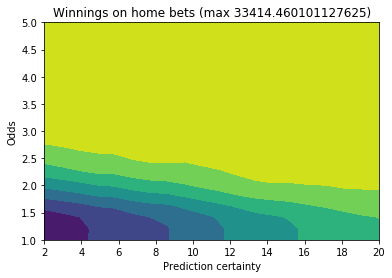

In [79]:
y = training_matches['Result'].values

odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_n in np.linspace(2,20,20):
        cash = 0
        
        for i in range(len(pred_t)):

            if pred_t[i] > pred_n and training_matches.iloc[i]['HomeTeamOdds'] > odd_t:
                cash -= bet

                if y[i] > 0:
                    cash += bet * training_matches.iloc[i]['HomeTeamOdds']

    #         elif away_prod[i] > t:
    #             cash -= bet
    #             bets += 1

    #             if y[i] < 0:
    #                 cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

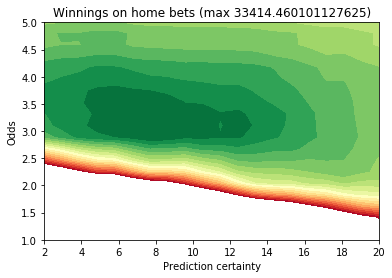

In [103]:
clevels = np.linspace(0,np.max(odd_winnings),20)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings, levels=clevels,cmap='RdYlGn')
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:55:31<00:00, 346.59s/it]


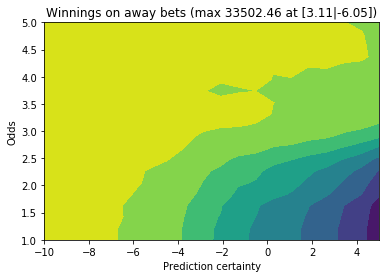

In [108]:

home_odd = 3
home_pred = 8
odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_n in np.linspace(-10,5,20):
        cash = 0
        
        for i in range(len(pred_t)):

            if pred_t[i] > home_pred and training_matches.iloc[i]['HomeTeamOdds'] > home_odd:
                cash -= bet

                if y[i] > 0:
                    cash += bet * training_matches.iloc[i]['HomeTeamOdds']

            elif pred_t[i] < pred_n and training_matches.iloc[i]['AwayTeamOdds'] > odd_t:
                cash -= bet


                if y[i] < 0:
                    cash += bet * training_matches.iloc[i]['AwayTeamOdds']

        winnings.append(cash)
        
    odd_winnings.append(winnings)
    

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

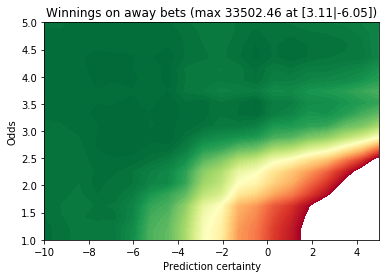

In [114]:
clevels = np.linspace(0,np.max(odd_winnings),100)

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings, levels=clevels,cmap='RdYlGn')
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

Thresholds for home bets: odds 2.9 and prediction 6<br>
Slope for away bets: 0.5\*pred + 4  if odds < 3, else YES

Average return on bet: -11.250001192092896%
Bets made: 7 home, 1 away
-18.0000019073


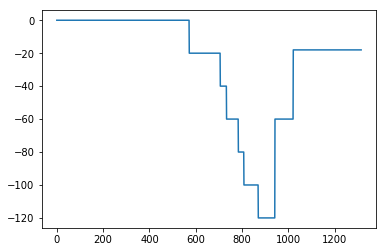

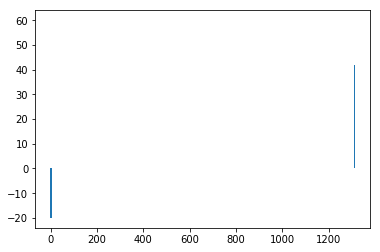

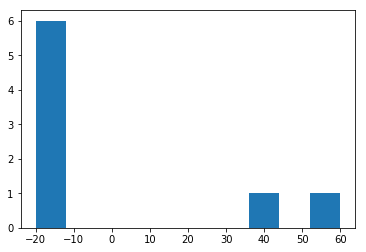

In [252]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
home_odd = 3
home_pred = 8
away_odd = 3
away_pred = -5

home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i] > home_pred and matches.iloc[i]['HomeTeamOdds'] > home_odd:
        cash -= bet
        home_bets += 1
        if y[i] > 0:
            cash += bet * matches.iloc[i]['HomeTeamOdds']
    elif pred[i] < away_pred and matches.iloc[i]['AwayTeamOdds'] > away_odd:
        cash -= bet
        away_bets += 1
        if y[i] < 0:
            cash += bet * matches.iloc[i]['AwayTeamOdds']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)
plt.hist(np.array(winnings)[np.where(np.array(winnings) != 0)[0]],bins=10)
plt.show()